In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import RandomForestClassifier


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         #'feature_linear_trend_magn_r', # cadence removal
                         #'feature_linear_trend_sigma_magn_r',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         #'feature_period_s_to_n_0_magn_r', # cadence removal
                         #'feature_period_1_magn_r', 
                         #'feature_period_s_to_n_1_magn_r', # cadence removal
                         #'feature_period_2_magn_r', 
                         #'feature_period_s_to_n_2_magn_r', # cadence removal
                         #'feature_period_3_magn_r', 
                         #'feature_period_s_to_n_3_magn_r', # cadence removal
                         #'feature_period_4_magn_r', 
                         #'feature_period_s_to_n_4_magn_r', # cadence removal
                         #'feature_periodogram_amplitude_magn_r',
                         #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                         #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         #'feature_linear_trend_magn_g', # cadence removal
                         #'feature_linear_trend_sigma_magn_g',  # cadence removal
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         #'feature_period_s_to_n_0_magn_g', # cadence removal
                         #'feature_period_1_magn_g', 
                         #'feature_period_s_to_n_1_magn_g', # cadence removal
                         #'feature_period_2_magn_g', 
                         #'feature_period_s_to_n_2_magn_g', # cadence removal
                         #'feature_period_3_magn_g', 
                         #'feature_period_s_to_n_3_magn_g', # cadence removal
                         #'feature_period_4_magn_g', 
                         #'feature_period_s_to_n_4_magn_g', # cadence removal
                         #'feature_periodogram_amplitude_magn_g',
                         #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                         #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                         #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
  'zmomentXX',
 'zmomentXY',
 'zmomentYY',
 'zmomentR1',
 'zmomentRH',
 'zPSFFlux',
# #  'zPSFFluxErr',
 'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
 'zKronFlux',
# #  'zKronFluxErr',
 'zKronRad',
# #  'zexpTime',
  'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
  'ymomentXX',
  'ymomentXY',
  'ymomentYY',
  'ymomentR1',
  'ymomentRH',
  'yPSFFlux',
# #   'yPSFFluxErr',
  'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
 'yKronFlux',
# #  'yKronFluxErr',
 'yKronRad',
# #  'yexpTime',
  'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
   'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
 'zApMag_zKronMag',
 'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

feature_names_tns = ['has_tns', 'tns_cls', 'spec_z', 'report_group']

lc_and_host_features = feature_names_r_g+feature_names_hostgal
lc_and_host_and_tns_features = lc_and_host_features + feature_names_tns

In [168]:
def plot_conf_matrix(y_test, y_pred, labels, title, kind, figsize=(6, 4)):
    if kind == 'Completeness':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    if kind == 'Purity':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='pred')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap = pd.DataFrame(recall, index=labels, columns=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(heatmap, annot=annotations, fmt='s', cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":16})
    plt.title(title, fontsize=18)
    plt.ylabel('True class', fontsize=18)
    plt.xlabel('Predicted class', fontsize=18)
    #plt.show()

In [4]:
def plot_RFC_prob_vs_lc(dataframe, anom_thresh):
    import antares_client

    df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
    anom_thresh = anom_thresh

    num_anom_epochs_l = []
    anom_ztfid_l, tnscls_l = [],[]
    for anom_ztfid, tnscls in zip(dataframe.index, dataframe.tns_cls):
        print(anom_ztfid, tnscls)
        try:
            lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
        except:
            print(f"couldn't feature space as func of time for {anom_ztfid}. Make anom epoch -9")
            num_anom_epochs_l.append(-9)
            continue

        lc_and_hosts_df = lc_and_hosts_df.dropna()
        anom_obj_df = lc_and_hosts_df[x_test.columns]

        
        try:
            pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
            num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
            num_anom_epochs_l.append(num_anom_epochs)
        except:
            print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
            continue

        try: 
            #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
            orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
            diff = len(orig)-len(pred_prob_anom)
            #if len(np.where(pred_prob_anom[:, 1]>=anom_thresh)) == 1:
            if not np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0] == 0:
                anom_idx = lc_and_hosts_df.loc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
            else: anom_idx = lc_and_hosts_df.iloc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
            anom_idx_is = True

        except: 
            print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
            anom_idx_is = False

        ztf_id_ref = anom_ztfid 

        ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

        try: df_ref = ref_info.timeseries.to_pandas()
        except: 
            print(f"No ref_info.timeseries.to_pandas() for {anom_ztfid}. Continue...")
            continue

        print(num_anom_epochs)
        anom_ztfid_l.append(anom_ztfid), tnscls_l.append(tnscls)

        df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
        df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

        mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
        mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
        ax1.invert_yaxis()
        ax1.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                    label=f'REF: {ztf_id_ref}')
        ax1.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
        #ax1.axvline(x=lc_and_hosts_df.loc[lc_and_hosts_df.loc[anom_idx].obs_num].mjd_cutoff)
        if anom_idx_is == True:
            ax1.axvline(x=lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
        #ax1.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))
        ax1.set_ylabel('Mag')


        print(f'https://alerce.online/object/{anom_ztfid}', tnscls)
        ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 0], label='p(Normal)')
        ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 1], label='p(Other)')
        #ax2.axhline(y=50)

        ax2.set_ylabel('Probability (%)')


        #ax2.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

        plt.xlabel('mjd_cutoff')
        plt.legend()
        plt.show()
        
def plot_RFC_prob_vs_lc_ztfid(anom_ztfid, anom_thresh, df_path):
    # Predict Excluded Object
    import antares_client
    
    df_path = df_path
    anom_thresh = anom_thresh

    try:
        lc_and_hosts_df = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
    except:
        print(f"couldn't feature space as func of time for {anom_ztfid}. pass.")
        pass

    lc_and_hosts_df = lc_and_hosts_df.dropna()
    anom_obj_df = lc_and_hosts_df[x_test.columns]

    try:
        pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
        num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
    except:
        print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
        return

    try: 
        #anom_idx = np.where(pred_prob_anom[:, 1]>=50)[0][0]
        orig = pd.read_csv(f'{df_path}/{anom_ztfid}_timeseries.csv')
        diff = len(orig)-len(pred_prob_anom)
        anom_idx = lc_and_hosts_df.loc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num + diff
        anom_idx_is = True

    except: 
        print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
        anom_idx_is = False
    
    ztf_id_ref = anom_ztfid 

    ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

    df_ref = ref_info.timeseries.to_pandas()

    df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
    df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

    mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
    ax1.invert_yaxis()
    ax1.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                label=f'REF: {ztf_id_ref}')
    ax1.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
    if anom_idx_is == True:
        ax1.axvline(x=lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
    #ax1.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

    print(f'https://alerce.online/object/{anom_ztfid}')
    ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 0], label='p(Normal)')
    ax2.plot(lc_and_hosts_df['mjd_cutoff'], pred_prob_anom[:, 1], label='p(Other)')
    #ax2.axhline(y=50)

    #ax2.set_xlim(min(df_ref_r.ant_mjd), max(df_ref_r.ant_mjd))

    plt.xlabel('mjd_cutoff')
    plt.ylabel('Probability (%)')
    plt.legend()
    plt.show()

In [5]:
#fakes_suffix = 'SMOTE_train_test_80-20_min14_kneighbors8'
fakes_suffix = 'SMOTE_train_test_70-30_min14_kneighbors8'
#suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{smote_suffix}"
#dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{smote_suffix}.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{smote_suffix}.csv.gz', compression='gzip', index_col=0)

#num=3039 #5000
#n_classes=11 #12
#n_epochs=4000 #500
#fakes_suffix = f'PZFLOW_train_test_70-30_min14_classes{n_classes}_epochs{n_epochs}'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5'
#fakes_suffix = f'PZFLOW_train_test_80-20_min14_classes{n_classes}_epochs{n_epochs}_n{num}_RollingSplineCoupling_B=5_chunks20'

suffix=f"noTNScut_pca60_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_NOfw_{fakes_suffix}"

#dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)

df_folder_path = f"../figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes/"
# Files used for actual model gen    
#x_train_all_latent_df = pd.read_csv(f'{df_folder_path}/x_train_all_3sdims_df.csv.gz', compression='gzip', index_col=0)
#x_test_all_latent_df = pd.read_csv(f'{df_folder_path}/x_test_all_3sdims_df.csv.gz', compression='gzip', index_col=0)
#dataset_bank_tns_df_resampled_train = x_train_all_latent_df
#dataset_bank_tns_df_resampled_test = x_test_all_latent_df


# test here isn't split into test+val set (val set used for VAE)
dataset_bank_tns_df_resampled_train = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_train_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)
dataset_bank_tns_df_resampled_test = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_tns_df_resampled_test_{fakes_suffix}.csv.gz', compression='gzip', index_col=0)

dataset_bank_tns_df_resampled_train

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF19abvhaqq                   0.391695   
ZTF21aaswtkh                   0.356501   
ZTF18abscghc                   0.224128   
ZTF21abjpjcn                   0.392974   
ZTF21aarhzdh                   0.908470   
...                                 ...   
ZTFabc91973                    0.648056   
ZTFabc46594                    0.486110   
ZTFabc20988                    0.447717   
ZTFabc25754                    0.351957   
ZTFabc81371                    0.445597   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF19abvhaqq                                 0.368108   
ZTF21aaswtkh                                 0.355052   
ZTF18abscghc                                 0.290376   
ZTF21abjpjcn                                 0.806768   
ZTF21aarhzdh                                 0.317764   
...                                               ...   
ZTFabc91973                                  0.438369   
ZTFabc46594                                  0.605627   
ZTFabc20988                                  0.433476   
ZTFabc25754                                  0.541262   
ZTFabc81371                                  0.432874   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF19abvhaqq                      0.375000                     0.000000   
ZTF21aaswtkh                      0.300000                     0.000000   
ZTF18abscghc                      0.400000                     0.000000   
ZTF21abjpjcn                      0.142857                     0.142857   
ZTF21aarhzdh                      0.263158                     0.000000   
...                                    ...                          ...   
ZTFabc91973                       0.306405                     0.000000   
ZTFabc46594                       0.258561                     0.017279   
ZTFabc20988                       0.428571                     0.000000   
ZTFabc25754                       0.343006                     0.012478   
ZTFabc81371                       0.428571                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF19abvhaqq               0.395856                                 0.783390   
ZTF21aaswtkh               0.321765                                 0.713001   
ZTF18abscghc               0.345730                                 0.448256   
ZTF21abjpjcn               0.316430                                 0.785948   
ZTF21aarhzdh               0.397708                                 1.816940   
...                             ...                                      ...   
ZTFabc91973                0.350863                                 1.296113   
ZTFabc46594                0.317578                                 0.937265   
ZTFabc20988                0.403265                                 0.895435   
ZTFabc25754                0.327531                                 0.678671   
ZTFabc81371                0.403129                                 0.891194   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF19abvhaqq                                   0.723513   
ZTF21aaswtkh                                   0.551514   
ZTF18abscghc                                   0.448256   
ZTF21abjpjcn                                   0.671357   
ZTF21aarhzdh                                   1.555440   
...                                                 ...   
ZTFabc91973                                    1.132292   
ZTFabc46594                                    0.604629   
ZTFabc20988                                    0.820801   
ZTFabc25754                                    

In [6]:
dataset_bank_tns_df_resampled_test

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF20aaybwth                   0.384511   
ZTF21abhvfrj                   0.477448   
ZTF20acngnvf                   0.221461   
ZTF20aciucub                   0.223271   
ZTF21abcfnuk                   0.240122   
...                                 ...   
ZTF20acupxyy                   0.630460   
ZTF21aarzxnb                   0.121910   
ZTF18acsxjhc                   0.926579   
ZTF21aatklhw                   0.772630   
ZTF21absyome                   0.524327   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20aaybwth                                 0.549172   
ZTF21abhvfrj                                 1.131876   
ZTF20acngnvf                                 0.330890   
ZTF20aciucub                                 0.301653   
ZTF21abcfnuk                                 0.239833   
...                                               ...   
ZTF20acupxyy                                 1.074418   
ZTF21aarzxnb                                 0.562210   
ZTF18acsxjhc                                 1.119445   
ZTF21aatklhw                                 0.303856   
ZTF21absyome                                 0.342202   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20aaybwth                      0.250000                     0.125000   
ZTF21abhvfrj                      0.090909                     0.090909   
ZTF20acngnvf                      0.235294                     0.058824   
ZTF20aciucub                      0.285714                     0.000000   
ZTF21abcfnuk                      0.285714                     0.000000   
...                                    ...                          ...   
ZTF20acupxyy                      0.400000                     0.000000   
ZTF21aarzxnb                      0.142857                     0.000000   
ZTF18acsxjhc                      0.303797                     0.037975   
ZTF21aatklhw                      0.384615                     0.000000   
ZTF21absyome                      0.181818                     0.090909   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF20aaybwth               0.324167                                 0.769022   
ZTF21abhvfrj               0.329433                                 0.954895   
ZTF20acngnvf               0.311743                                 0.442923   
ZTF20aciucub               0.343634                                 0.446543   
ZTF21abcfnuk               0.402769                                 0.480244   
...                             ...                                      ...   
ZTF20acupxyy               0.457814                                 1.260920   
ZTF21aarzxnb               0.376162                                 0.243820   
ZTF18acsxjhc               0.349061                                 1.801871   
ZTF21aatklhw               0.387778                                 1.545259   
ZTF21absyome               0.387020                                 1.048655   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF20aaybwth                                   0.619796   
ZTF21abhvfrj                                   0.633796   
ZTF20acngnvf                                   0.306310   
ZTF20aciucub                                   0.400569   
ZTF21abcfnuk                                   0.435988   
...                                                 ...   
ZTF20acupxyy                                   1.047050   
ZTF21aarzxnb                                   0.218541   
ZTF18acsxjhc                                   1.069640   
ZTF21aatklhw                                   

In [7]:
Counter(dataset_bank_tns_df_resampled_train.tns_cls)

Counter({'None': 2656,
         'SN Ia': 2656,
         'SN II': 2656,
         'SN Ib': 2656,
         'SN IIP': 2656,
         'TDE': 2656,
         'SN IIn': 2656,
         'SLSN-II': 2656,
         'SN IIb': 2656,
         'SN Ic': 2656,
         'SN Ic-BL': 2656,
         'SN Ia-91T-like': 2656})

In [8]:
Counter(dataset_bank_tns_df_resampled_test.tns_cls)

Counter({'None': 1160,
         'SN Ia': 321,
         'SN Ic-BL': 5,
         'SN II': 68,
         'SN IIn': 15,
         'SN IIb': 6,
         'SN Ib': 6,
         'SN IIP': 5,
         'SN Ic': 9,
         'SN Ia-91T-like': 9,
         'TDE': 8,
         'SLSN-II': 3})

In [9]:
# Try RFC without None
dataset_bank_tns_df_resampled_train = dataset_bank_tns_df_resampled_train[dataset_bank_tns_df_resampled_train['tns_cls'] != 'None']
dataset_bank_tns_df_resampled_train

# Try with None
#dataset_bank_tns_df_resampled_train

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aarhzdh                   0.908470   
ZTF21aatvcdl                   1.001925   
ZTF20ackzfvn                   0.842765   
ZTF21abngbrl                   0.734040   
ZTF21aaaroyw                   0.411922   
...                                 ...   
ZTFabc91973                    0.648056   
ZTFabc46594                    0.486110   
ZTFabc20988                    0.447717   
ZTFabc25754                    0.351957   
ZTFabc81371                    0.445597   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aarhzdh                                 0.317764   
ZTF21aatvcdl                                 0.535585   
ZTF20ackzfvn                                 0.292838   
ZTF21abngbrl                                 0.614425   
ZTF21aaaroyw                                 0.292416   
...                                               ...   
ZTFabc91973                                  0.438369   
ZTFabc46594                                  0.605627   
ZTFabc20988                                  0.433476   
ZTFabc25754                                  0.541262   
ZTFabc81371                                  0.432874   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aarhzdh                      0.263158                     0.000000   
ZTF21aatvcdl                      0.384615                     0.076923   
ZTF20ackzfvn                      0.285714                     0.000000   
ZTF21abngbrl                      0.125000                     0.000000   
ZTF21aaaroyw                      0.222222                     0.000000   
...                                    ...                          ...   
ZTFabc91973                       0.306405                     0.000000   
ZTFabc46594                       0.258561                     0.017279   
ZTFabc20988                       0.428571                     0.000000   
ZTFabc25754                       0.343006                     0.012478   
ZTFabc81371                       0.428571                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aarhzdh               0.397708                                 1.816940   
ZTF21aatvcdl               0.355134                                 2.003849   
ZTF20ackzfvn               0.347289                                 1.685530   
ZTF21abngbrl               0.424395                                 1.468081   
ZTF21aaaroyw               0.347490                                 0.823845   
...                             ...                                      ...   
ZTFabc91973                0.350863                                 1.296113   
ZTFabc46594                0.317578                                 0.937265   
ZTFabc20988                0.403265                                 0.895435   
ZTFabc25754                0.327531                                 0.678671   
ZTFabc81371                0.403129                                 0.891194   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aarhzdh                                   1.555440   
ZTF21aatvcdl                                   1.392731   
ZTF20ackzfvn                                   1.470047   
ZTF21abngbrl                                   1.324121   
ZTF21aaaroyw                                   0.629479   
...                                                 ...   
ZTFabc91973                                    1.132292   
ZTFabc46594                                    0.604629   
ZTFabc20988                                    0.820801   
ZTFabc25754                                    

In [10]:
Counter(dataset_bank_tns_df_resampled_train.tns_cls)

Counter({'SN Ia': 2656,
         'SN II': 2656,
         'SN Ib': 2656,
         'SN IIP': 2656,
         'TDE': 2656,
         'SN IIn': 2656,
         'SLSN-II': 2656,
         'SN IIb': 2656,
         'SN Ic': 2656,
         'SN Ic-BL': 2656,
         'SN Ia-91T-like': 2656})

In [11]:
# Try RFC without None
dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test[dataset_bank_tns_df_resampled_test['tns_cls'] != 'None']
dataset_bank_tns_df_resampled_test

# Try with None
#dataset_bank_tns_df_resampled_test

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

g_hosts_has_ps1_objid_df = pd.read_csv('../loci_dbs/alerce_cut/g_hosts_has_ps1_objid_df.csv.gz', compression='gzip', index_col=0)
g_hosts_has_ps1_objid_df

dataset_bank_9k = pd.read_csv(f'../loci_dbs/alerce_cut/dataset_bank_and_tns_df_9420objects.csv.gz', 
                           compression='gzip', index_col='ztf_object_id')
dataset_bank_9k

print("ZTFID RA_TRANSIENT DEC_TRANSIENT RA_HOST DEC_HOST TNS_CLS SPEC_Z DIST/DLR")
for ob, raT, decT, raH, decH, cls, z, dDLR in zip(dataset_bank_tns_df_resampled_test.index, 
                            dataset_bank_9k.loc[dataset_bank_tns_df_resampled_test.index].ra,
                            dataset_bank_9k.loc[dataset_bank_tns_df_resampled_test.index].dec,
                            g_hosts_has_ps1_objid_df.loc[dataset_bank_tns_df_resampled_test.index].raMean,
                            g_hosts_has_ps1_objid_df.loc[dataset_bank_tns_df_resampled_test.index].decMean,
                            dataset_bank_tns_df_resampled_test.tns_cls,
                            dataset_bank_tns_df_resampled_test.spec_z,
                            dataset_bank_tns_df_resampled_test['dist/DLR']):
    print(ob, raT, decT, raH, decH, cls, z, dDLR)

In [12]:
np.unique(np.array(dataset_bank_tns_df_resampled_train['tns_cls']))

array(['SLSN-II', 'SN II', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia',
       'SN Ia-91T-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'TDE'],
      dtype=object)

In [13]:
# Without None class
#dataset_bank_tns_df_resampled_val = dataset_bank_tns_df_resampled_test.iloc[0:100, :]
#dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test.iloc[100:, :]

# With None class
# for best results: Val 0:800, test 800:
#dataset_bank_tns_df_resampled_val = dataset_bank_tns_df_resampled_test.iloc[0:200, :]
#dataset_bank_tns_df_resampled_test = dataset_bank_tns_df_resampled_test.iloc[200:, :]

In [14]:
pd.concat([dataset_bank_tns_df_resampled_train.iloc[:, 0:120], dataset_bank_tns_df_resampled_train.iloc[:, 124:]], axis=1)



feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aarhzdh                   0.908470   
ZTF21aatvcdl                   1.001925   
ZTF20ackzfvn                   0.842765   
ZTF21abngbrl                   0.734040   
ZTF21aaaroyw                   0.411922   
...                                 ...   
ZTFabc91973                    0.648056   
ZTFabc46594                    0.486110   
ZTFabc20988                    0.447717   
ZTFabc25754                    0.351957   
ZTFabc81371                    0.445597   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aarhzdh                                 0.317764   
ZTF21aatvcdl                                 0.535585   
ZTF20ackzfvn                                 0.292838   
ZTF21abngbrl                                 0.614425   
ZTF21aaaroyw                                 0.292416   
...                                               ...   
ZTFabc91973                                  0.438369   
ZTFabc46594                                  0.605627   
ZTFabc20988                                  0.433476   
ZTFabc25754                                  0.541262   
ZTFabc81371                                  0.432874   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aarhzdh                      0.263158                     0.000000   
ZTF21aatvcdl                      0.384615                     0.076923   
ZTF20ackzfvn                      0.285714                     0.000000   
ZTF21abngbrl                      0.125000                     0.000000   
ZTF21aaaroyw                      0.222222                     0.000000   
...                                    ...                          ...   
ZTFabc91973                       0.306405                     0.000000   
ZTFabc46594                       0.258561                     0.017279   
ZTFabc20988                       0.428571                     0.000000   
ZTFabc25754                       0.343006                     0.012478   
ZTFabc81371                       0.428571                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aarhzdh               0.397708                                 1.816940   
ZTF21aatvcdl               0.355134                                 2.003849   
ZTF20ackzfvn               0.347289                                 1.685530   
ZTF21abngbrl               0.424395                                 1.468081   
ZTF21aaaroyw               0.347490                                 0.823845   
...                             ...                                      ...   
ZTFabc91973                0.350863                                 1.296113   
ZTFabc46594                0.317578                                 0.937265   
ZTFabc20988                0.403265                                 0.895435   
ZTFabc25754                0.327531                                 0.678671   
ZTFabc81371                0.403129                                 0.891194   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aarhzdh                                   1.555440   
ZTF21aatvcdl                                   1.392731   
ZTF20ackzfvn                                   1.470047   
ZTF21abngbrl                                   1.324121   
ZTF21aaaroyw                                   0.629479   
...                                                 ...   
ZTFabc91973                                    1.132292   
ZTFabc46594                                    0.604629   
ZTFabc20988                                    0.820801   
ZTFabc25754                                    

In [15]:
# x_train = dataset_bank_tns_df_resampled_train.iloc[:, 0:120]
# x_test = dataset_bank_tns_df_resampled_test.iloc[:, 0:120]
# x_val = dataset_bank_tns_df_resampled_val.iloc[:, 0:120]

x_train = pd.concat([dataset_bank_tns_df_resampled_train.iloc[:, 0:120], 
                     dataset_bank_tns_df_resampled_train.iloc[:, 124:]], axis=1)
x_test = pd.concat([dataset_bank_tns_df_resampled_test.iloc[:, 0:120], 
                     dataset_bank_tns_df_resampled_test.iloc[:, 124:]], axis=1)
#x_val = pd.concat([dataset_bank_tns_df_resampled_val.iloc[:, 0:120], 
#                     dataset_bank_tns_df_resampled_val.iloc[:, 124:]], axis=1)

x_train_all = dataset_bank_tns_df_resampled_train 
x_test_all = dataset_bank_tns_df_resampled_test
#x_val_all = dataset_bank_tns_df_resampled_val

# Normalize the input data & validation data
x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
x_train_normalized = (x_train - x_train_mean) / x_train_std

x_test_mean = np.mean(x_test, axis=0)
x_test_std = np.std(x_test, axis=0)
x_test_normalized = (x_test - x_train_mean) / x_train_std # scale test by train

#x_val_mean = np.mean(x_val, axis=0)
#x_val_std = np.std(x_val, axis=0)
#x_val_normalized = (x_val - x_train_mean) / x_train_std # scale to training

%%time

# Grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)

param_grid = {'max_depth': [30, 60, 90],
              'class_weight': [{"None": 1, "SLSN-II": w, "SN II": w, 'SN IIP': w, 'SN IIb': w, 'SN IIn': w, 'SN Ia': 1,
       'SN Ia-91T-like': w, 'SN Ib': w, 'SN Ic': w, 'SN Ic-BL': w, 'TDE': w} for w in range(1, 3)], 
             'max_features': [30, 60, 90],
             }
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
grid_search.fit(dataset_bank_tns_df_resampled_train.iloc[:, 0:120], np.array(dataset_bank_tns_df_resampled_train['tns_cls']))
best_params = grid_search.best_params_
print(best_params)

In [16]:
di  = {'CV': 'OOS', 
      'SLSN-I': 'OOS', 
      'SLSN-II': 'Other', 
      'SN II': 'Normal', 
      'SN IIP': 'Normal', 
      'SN IIb': 'Other', 
      'SN IIn': 'Other',
      'SN Ia': 'Normal', 
      'SN Ia-91T-like': 'Normal', 
      'SN Ia-CSM': 'Other',
      'SN Ia-91bg-like': 'Other',
      'SN Ia-pec': 'Other', 
      'SN Ib': 'Other', 
      'SN Ib/c': 'OOS',
      'SN Ibn': 'OOS',
      'SN Ic': 'Other',
      'SN Ic-BL': 'Other', 
      'TDE': 'Other',
      'None': 'OOS',
      'SN': 'OOS',
      'SN I': 'OOS',
      'AGN': 'OOS'}

x_train_all = x_train_all.replace({"tns_cls": di})
x_test_all = x_test_all.replace({"tns_cls": di})
x_train_all

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aarhzdh                   0.908470   
ZTF21aatvcdl                   1.001925   
ZTF20ackzfvn                   0.842765   
ZTF21abngbrl                   0.734040   
ZTF21aaaroyw                   0.411922   
...                                 ...   
ZTFabc91973                    0.648056   
ZTFabc46594                    0.486110   
ZTFabc20988                    0.447717   
ZTFabc25754                    0.351957   
ZTFabc81371                    0.445597   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aarhzdh                                 0.317764   
ZTF21aatvcdl                                 0.535585   
ZTF20ackzfvn                                 0.292838   
ZTF21abngbrl                                 0.614425   
ZTF21aaaroyw                                 0.292416   
...                                               ...   
ZTFabc91973                                  0.438369   
ZTFabc46594                                  0.605627   
ZTFabc20988                                  0.433476   
ZTFabc25754                                  0.541262   
ZTFabc81371                                  0.432874   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aarhzdh                      0.263158                     0.000000   
ZTF21aatvcdl                      0.384615                     0.076923   
ZTF20ackzfvn                      0.285714                     0.000000   
ZTF21abngbrl                      0.125000                     0.000000   
ZTF21aaaroyw                      0.222222                     0.000000   
...                                    ...                          ...   
ZTFabc91973                       0.306405                     0.000000   
ZTFabc46594                       0.258561                     0.017279   
ZTFabc20988                       0.428571                     0.000000   
ZTFabc25754                       0.343006                     0.012478   
ZTFabc81371                       0.428571                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aarhzdh               0.397708                                 1.816940   
ZTF21aatvcdl               0.355134                                 2.003849   
ZTF20ackzfvn               0.347289                                 1.685530   
ZTF21abngbrl               0.424395                                 1.468081   
ZTF21aaaroyw               0.347490                                 0.823845   
...                             ...                                      ...   
ZTFabc91973                0.350863                                 1.296113   
ZTFabc46594                0.317578                                 0.937265   
ZTFabc20988                0.403265                                 0.895435   
ZTFabc25754                0.327531                                 0.678671   
ZTFabc81371                0.403129                                 0.891194   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aarhzdh                                   1.555440   
ZTF21aatvcdl                                   1.392731   
ZTF20ackzfvn                                   1.470047   
ZTF21abngbrl                                   1.324121   
ZTF21aaaroyw                                   0.629479   
...                                                 ...   
ZTFabc91973                                    1.132292   
ZTFabc46594                                    0.604629   
ZTFabc20988                                    0.820801   
ZTFabc25754                                    

In [17]:
np.unique(x_train_all.tns_cls)

array(['Normal', 'Other'], dtype=object)

In [18]:
np.unique(x_test_all.tns_cls)

array(['Normal', 'Other'], dtype=object)

In [19]:
x_train = x_train.iloc[:, 0:120] # change to include or not include s1, s2, s3...
x_test = x_test.iloc[:, 0:120] # if so, add back in val set...

x_train

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aarhzdh                   0.908470   
ZTF21aatvcdl                   1.001925   
ZTF20ackzfvn                   0.842765   
ZTF21abngbrl                   0.734040   
ZTF21aaaroyw                   0.411922   
...                                 ...   
ZTFabc91973                    0.648056   
ZTFabc46594                    0.486110   
ZTFabc20988                    0.447717   
ZTFabc25754                    0.351957   
ZTFabc81371                    0.445597   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aarhzdh                                 0.317764   
ZTF21aatvcdl                                 0.535585   
ZTF20ackzfvn                                 0.292838   
ZTF21abngbrl                                 0.614425   
ZTF21aaaroyw                                 0.292416   
...                                               ...   
ZTFabc91973                                  0.438369   
ZTFabc46594                                  0.605627   
ZTFabc20988                                  0.433476   
ZTFabc25754                                  0.541262   
ZTFabc81371                                  0.432874   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aarhzdh                      0.263158                     0.000000   
ZTF21aatvcdl                      0.384615                     0.076923   
ZTF20ackzfvn                      0.285714                     0.000000   
ZTF21abngbrl                      0.125000                     0.000000   
ZTF21aaaroyw                      0.222222                     0.000000   
...                                    ...                          ...   
ZTFabc91973                       0.306405                     0.000000   
ZTFabc46594                       0.258561                     0.017279   
ZTFabc20988                       0.428571                     0.000000   
ZTFabc25754                       0.343006                     0.012478   
ZTFabc81371                       0.428571                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aarhzdh               0.397708                                 1.816940   
ZTF21aatvcdl               0.355134                                 2.003849   
ZTF20ackzfvn               0.347289                                 1.685530   
ZTF21abngbrl               0.424395                                 1.468081   
ZTF21aaaroyw               0.347490                                 0.823845   
...                             ...                                      ...   
ZTFabc91973                0.350863                                 1.296113   
ZTFabc46594                0.317578                                 0.937265   
ZTFabc20988                0.403265                                 0.895435   
ZTFabc25754                0.327531                                 0.678671   
ZTFabc81371                0.403129                                 0.891194   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aarhzdh                                   1.555440   
ZTF21aatvcdl                                   1.392731   
ZTF20ackzfvn                                   1.470047   
ZTF21abngbrl                                   1.324121   
ZTF21aaaroyw                                   0.629479   
...                                                 ...   
ZTFabc91973                                    1.132292   
ZTFabc46594                                    0.604629   
ZTFabc20988                                    0.820801   
ZTFabc25754                                    

In [20]:
x_test

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

In [21]:
n_estimators=100 #3500
max_depth=35 #35
random_state=11
max_features=35 # {“sqrt”, “log2”, None}, int or float, default=”sqrt” - sqrt(120) ~ 10
#class_weight={"None": 1, "SLSN-II": 1, "SN II": 1, 'SN IIP': 1, 'SN IIb': 1, 'SN IIn': 1, 'SN Ia': 1,
#       'SN Ia-91T-like': 1, 'SN Ib': 1, 'SN Ic': 1, 'SN Ic-BL': 1, 'TDE': 1} #"balanced"
class_weight={"Normal": 1, "Other": 1} #"balanced"

figure_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/figures"
model_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/model"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    
if not os.path.exists(model_path):
    os.makedirs(model_path)

cm_path = f"{figure_path}/confusion_matrix/"
if not os.path.exists(cm_path):
    os.makedirs(cm_path)

In [22]:
dataset_bank_tns_df_resampled_train.has_tns

ztf_object_id
ZTF21aarhzdh    Yes_TNS
ZTF21aatvcdl    Yes_TNS
ZTF20ackzfvn    Yes_TNS
ZTF21abngbrl    Yes_TNS
ZTF21aaaroyw    Yes_TNS
                 ...   
ZTFabc91973        Fake
ZTFabc46594        Fake
ZTFabc20988        Fake
ZTFabc25754        Fake
ZTFabc81371        Fake
Name: has_tns, Length: 29216, dtype: object

In [23]:
x_train

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aarhzdh                   0.908470   
ZTF21aatvcdl                   1.001925   
ZTF20ackzfvn                   0.842765   
ZTF21abngbrl                   0.734040   
ZTF21aaaroyw                   0.411922   
...                                 ...   
ZTFabc91973                    0.648056   
ZTFabc46594                    0.486110   
ZTFabc20988                    0.447717   
ZTFabc25754                    0.351957   
ZTFabc81371                    0.445597   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aarhzdh                                 0.317764   
ZTF21aatvcdl                                 0.535585   
ZTF20ackzfvn                                 0.292838   
ZTF21abngbrl                                 0.614425   
ZTF21aaaroyw                                 0.292416   
...                                               ...   
ZTFabc91973                                  0.438369   
ZTFabc46594                                  0.605627   
ZTFabc20988                                  0.433476   
ZTFabc25754                                  0.541262   
ZTFabc81371                                  0.432874   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aarhzdh                      0.263158                     0.000000   
ZTF21aatvcdl                      0.384615                     0.076923   
ZTF20ackzfvn                      0.285714                     0.000000   
ZTF21abngbrl                      0.125000                     0.000000   
ZTF21aaaroyw                      0.222222                     0.000000   
...                                    ...                          ...   
ZTFabc91973                       0.306405                     0.000000   
ZTFabc46594                       0.258561                     0.017279   
ZTFabc20988                       0.428571                     0.000000   
ZTFabc25754                       0.343006                     0.012478   
ZTFabc81371                       0.428571                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aarhzdh               0.397708                                 1.816940   
ZTF21aatvcdl               0.355134                                 2.003849   
ZTF20ackzfvn               0.347289                                 1.685530   
ZTF21abngbrl               0.424395                                 1.468081   
ZTF21aaaroyw               0.347490                                 0.823845   
...                             ...                                      ...   
ZTFabc91973                0.350863                                 1.296113   
ZTFabc46594                0.317578                                 0.937265   
ZTFabc20988                0.403265                                 0.895435   
ZTFabc25754                0.327531                                 0.678671   
ZTFabc81371                0.403129                                 0.891194   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aarhzdh                                   1.555440   
ZTF21aatvcdl                                   1.392731   
ZTF20ackzfvn                                   1.470047   
ZTF21abngbrl                                   1.324121   
ZTF21aaaroyw                                   0.629479   
...                                                 ...   
ZTFabc91973                                    1.132292   
ZTFabc46594                                    0.604629   
ZTFabc20988                                    0.820801   
ZTFabc25754                                    

In [24]:
np.array(x_train_all['tns_cls'])

array(['Normal', 'Normal', 'Normal', ..., 'Other', 'Other', 'Other'],
      dtype=object)

In [19]:
%%time
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=n_estimators, 
                             max_depth=max_depth, 
                             random_state=random_state, 
                             max_features=max_features,
                             class_weight=class_weight,
                             verbose=1, 
                             n_jobs=-1)
#clf.fit(dataset_bank_tns_df_resampled_train.iloc[:, 0:120], np.array(dataset_bank_tns_df_resampled_train['tns_cls']))
#clf.fit(x_train_normalized, np.array(x_train_all['tns_cls']))
clf.fit(x_train, np.array(x_train_all['tns_cls']))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s


CPU times: user 2min 33s, sys: 411 ms, total: 2min 33s
Wall time: 20.7 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.6s finished


RandomForestClassifier(class_weight={'Normal': 1, 'Other': 1}, max_depth=35,
                       max_features=35, n_jobs=-1, random_state=11, verbose=1)

In [21]:
pickle.dump(clf, open(f'{model_path}/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced.pkl', 'wb'))


### Load pickle

In [100]:
figure_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/figures"
model_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/model"
with open(f'{model_path}/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced.pkl', 'rb') as f:
    clf = pickle.load(f)

# K fold cross validation (Can't do it b/c SMOTE is from specific training set)

%%time
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Define your random forest classifier (replace with your model and parameters)
model = RandomForestClassifier(n_estimators=n_estimators, 
                             max_depth=max_depth, 
                             random_state=11, 
                             max_features=max_features,
                             class_weight=class_weight,
                             verbose=1, 
                             n_jobs=-1)

# Lists to store evaluation metrics for each fold
precision_scores = []
recall_scores = []
f1_scores = []

# Define the number of splits and random state
n_splits = 100
random_state = 11  # Change this to your desired random state
desired_train_size = 1100  # Adjust to your desired size
desired_test_size = 455    # Adjust to your desired size

# Example: Your "real" indices with gaps
X=x_all
y=y_all

# Separate the indices of real and simulated data
simulated_indices = np.where(x_tt_all['has_tns'] == "Fake")[0]
real_indices = np.where(x_tt_all['has_tns'] == 'Yes_TNS')[0]

# StratifiedKFold on indices for stratified sampling
stratified_kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Lists to store train and test indices
train_indices_list = []
test_indices_list = []

counter = 0
for train_idx, test_idx in stratified_kfold.split(real_indices, y[real_indices]):
#     # Use the stratified indices to select the real indices
#     train_real_indices = real_indices[train_idx]
#     test_real_indices = real_indices[test_idx]

    # TODO: GET RANDOM SHUFFLING OF INDICES!!!???
    
    # Ensure the training set size matches your desired size
    full_idx = np.array(list(train_idx)+list(test_idx))
    train_idx = full_idx[:desired_train_size]
    # Ensure the testing set size matches your desired size
    test_idx = full_idx[desired_train_size:-11]

    train_real_indices = real_indices[train_idx]
    test_real_indices = real_indices[test_idx]
    #print("train_real_indices", train_real_indices)
    #print("test_real_indices", test_real_indices)

    train_indices_list.append(train_real_indices)
    test_indices_list.append(test_real_indices)


# Now, you have train and test indices for each fold
for i, (train_indices, test_indices) in enumerate(zip(train_indices_list, test_indices_list)):
    print(f"Fold {i + 1}:")
#     print("Train Indices:", train_indices)
#     print("Test Indices:", test_indices)
    print("len Train Indices", len(train_indices))
    print("len Test Indices", len(test_indices))
#     print("SET")
#     print(set(train_indices) & set(test_indices))

#    if i == 1: break
#     if i == 0: # can recreate data
#         print("HI")
#         train_indices = [j for j in range(29217)]
#         test_indices = [i for i in range(29216, 29671)]
#         print("NEW", train_indices, test_indices)
#         print(len(train_indices), len( test_indices))


    print(len(np.where(y[test_indices] == "Other")[0]))
    if len(np.where(y[test_indices] == "Other")[0]) != 52:
        print("not 52 Other objects like test set. Try another fold!")
        counter += 0
        continue
    else:
        print("52")
        counter += 1
        print("counter", counter)


    # Train the model on the combined real and simulated training data
    model.fit(X.iloc[train_indices], y[train_indices])

    # Test the model on the real test data
    real_test_predictions = model.predict(X.iloc[test_indices])

    #for idx, pred, real in zip(X.iloc[test_indices].index, real_test_predictions, y[test_indices]):
    #    print(idx, pred, real)

    # Calculate performance metrics for this fold with explicit pos_label
    precision = precision_score(y[test_indices], real_test_predictions, pos_label='Other')
    recall = recall_score(y[test_indices], real_test_predictions, pos_label='Other')
    f1 = f1_score(y[test_indices], real_test_predictions, pos_label='Other')

    # Store the metrics for this fold
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    print(f"{i + 1} k-fold precision: {precision}")
    print(f"{i + 1} k-fold recall: {recall}")
    print(f"{i + 1} k-fold f1_score: {f1}")

    print(classification_report(y_true=y[test_indices], y_pred=real_test_predictions, target_names=np.unique(real_test_predictions)))

    if counter == 10:
        print("10")
        print(counter)
        break

# Print the mean evaluation metrics across folds
print("Mean Precision:", sum(precision_scores) / len(precision_scores))
print("Mean Recall:", sum(recall_scores) / len(recall_scores))
print("Mean F1-score:", sum(f1_scores) / len(f1_scores))


In [264]:
# Predict Excluded Object
predicted_probability = 100 * clf.predict_proba(x_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [265]:
#clf.classes_[1:]
clf.classes_

array(['Normal', 'Other'], dtype=object)

In [266]:
# Create a dataframe from the arrays
df = pd.DataFrame(predicted_probability, columns=clf.classes_)
df = df.set_index(x_test_all.index)

# Add a new column "RFC_best_cls" to the existing dataframe that contains the class label with the highest probability per row
# clf.classes_[1:] and row.values[1:] ignores the None class
#df['RFC_best_cls'] = df.apply(lambda row: clf.classes_[1:][np.argmax(row.values[1:])], axis=1)
# USE clf.classes_ and row.values if you don't train on the None class
df['RFC_best_cls'] = df.apply(lambda row: clf.classes_[np.argmax(row.values)], axis=1)
df

Normal      Other RFC_best_cls
ztf_object_id                                   
ZTF21aazebgh   80.436006  19.563994       Normal
ZTF21acgxypn   32.037458  67.962542        Other
ZTF19aapqqrb   70.000000  30.000000       Normal
ZTF21aasbxng   94.000000   6.000000       Normal
ZTF21aaglgcb   79.000000  21.000000       Normal
...                  ...        ...          ...
ZTF21acdalyp   92.000000   8.000000       Normal
ZTF21abdcauj   86.000000  14.000000       Normal
ZTF21aaetnfe   87.000000  13.000000       Normal
ZTF21acgzwsc   82.000000  18.000000       Normal
ZTF21aatklhw   61.074109  38.925891       Normal

[455 rows x 3 columns]

In [267]:
df2 = pd.concat([x_test_all, df], axis=1)
df2 = df2.replace({"tns_cls": di})
df2

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

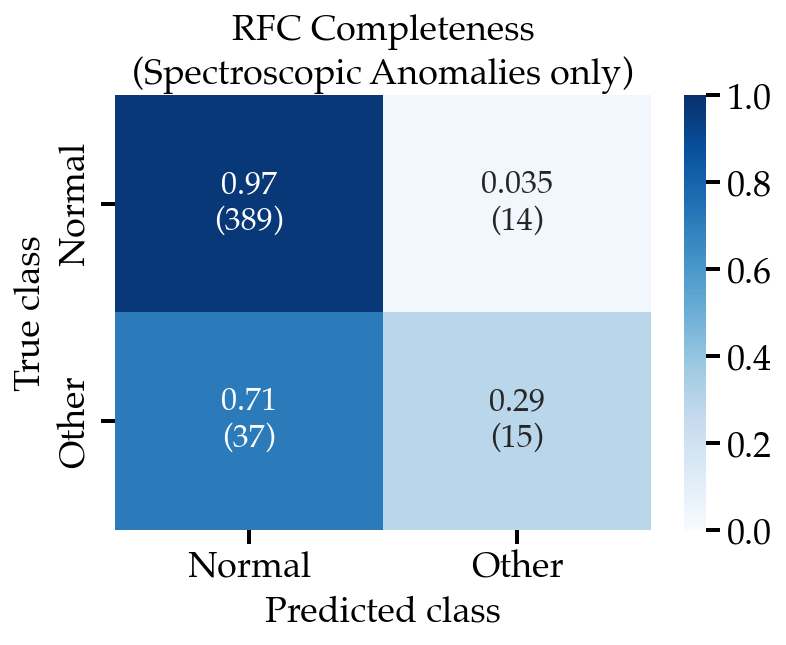

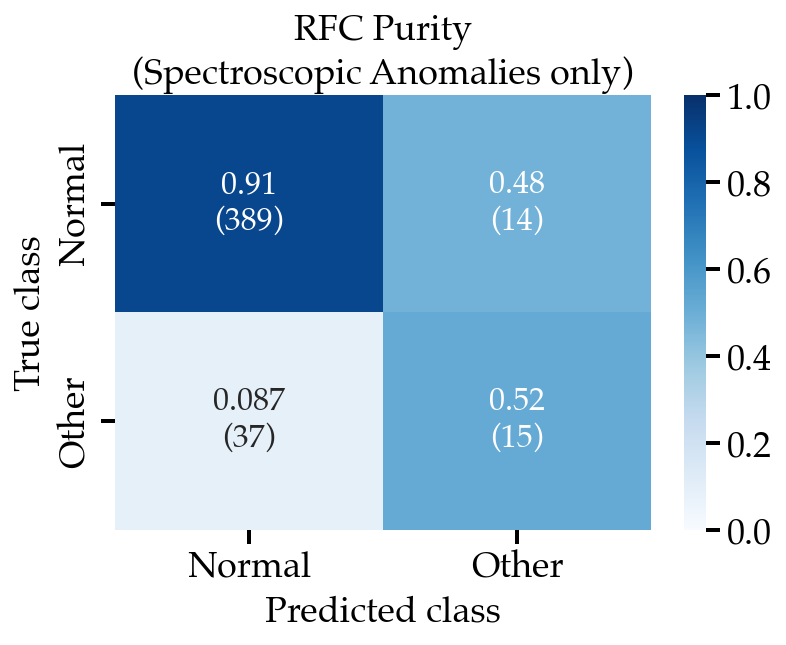

In [268]:
# Confusion matrices
title='spec_label_only'
df = df2
true_labels = np.array(df['tns_cls'])
predicted_labels = np.array(df['RFC_best_cls'])
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['Completeness', 'Purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'RFC {KIND}\n(Spectroscopic Anomalies only)', kind=KIND)
    plt.savefig(f'{cm_path}/confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [269]:
from sklearn.metrics import classification_report
y_true = true_labels
y_pred = predicted_labels
target_names = class_names
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.52      0.29      0.37        52

    accuracy                           0.89       455
   macro avg       0.72      0.63      0.65       455
weighted avg       0.87      0.89      0.87       455



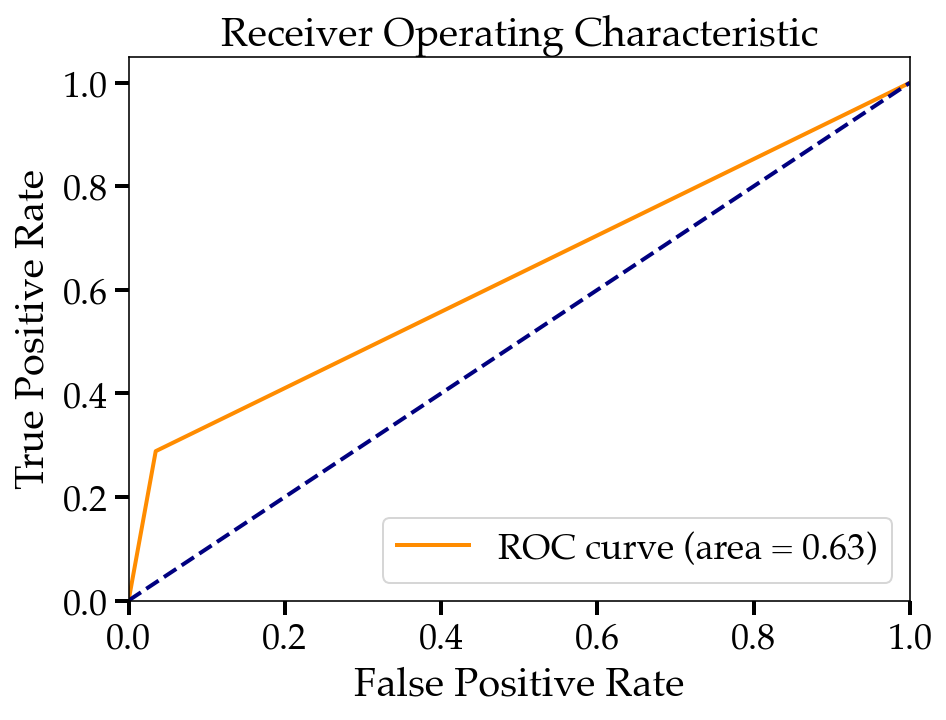

In [270]:
from sklearn.metrics import roc_curve, roc_auc_score

# Convert 'Normal' to 0 and 'Other' to 1
true_labels = np.where(true_labels == 'Normal', 0, 1)
# Convert 'Other' to 0 and 'Other' to 1
predicted_labels = np.where(predicted_labels == 'Normal', 0, 1)

fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
#plt.savefig(f'{figure_path}/AUROC_nclasses={nclasses}_noNone_{title}_{KIND}.pdf', dpi=300, bbox_inches='tight')
plt.show()

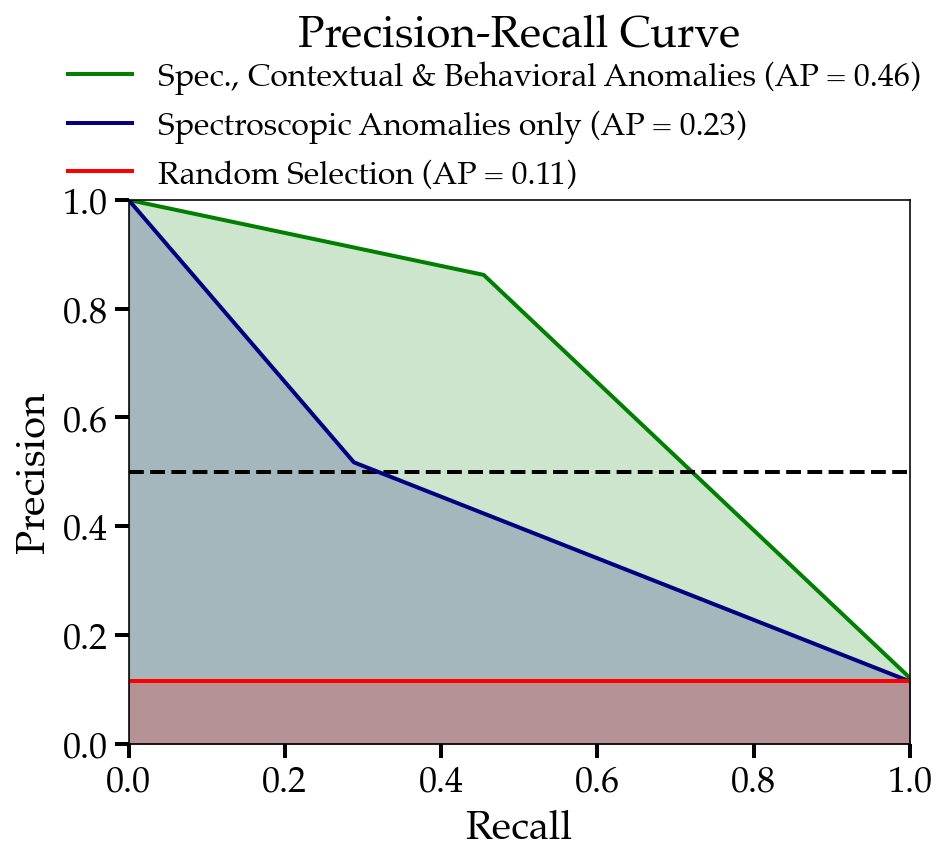

In [272]:
# precision-recall curve for binary classification tasks
# b/c predicted is 0, 1 binary and not %s

from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate random_precision
random_precision = np.sum(true_labels) / len(true_labels)

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(true_labels, predicted_labels)
average_precision = average_precision_score(true_labels, predicted_labels)

true_label_after_vetting = np.array(['Other']*55 + ['Normal']*400)
pred_label_after_vetting = np.array(['Other']*25 + ['Normal']*30 + ['Other']*4 + ['Normal']*396)

# Convert 'Normal' to 0 and 'Other' to 1
true_label_after_vetting = np.where(true_label_after_vetting == 'Normal', 0, 1)
# Convert 'Other' to 0 and 'Other' to 1
pred_label_after_vetting = np.where(pred_label_after_vetting == 'Normal', 0, 1)

precision_av, recall_av, thresholds_av = precision_recall_curve(true_label_after_vetting, pred_label_after_vetting)
average_precision_av = average_precision_score(true_label_after_vetting, pred_label_after_vetting)

plt.figure()

plt.plot(recall_av, precision_av, lw=2, color='green', label=f'Spec., Contextual & Behavioral Anomalies (AP = {average_precision_av:0.2f})')
# Fill the area under the curve with the line color
plt.fill_between(recall_av, precision_av, alpha=0.2, color='green')
#plt.axvline(x=0.72)
#plt.axvline(x=0.31)
plt.axhline(y=0.5, ls='--', color='k')

plt.plot(recall, precision, lw=2, color='navy', label=f'Spectroscopic Anomalies only (AP = {average_precision:0.2f})')
# Fill the area under the curve with the line color
plt.fill_between(recall, precision, alpha=0.2, color='navy')

plt.plot([0, 1], [random_precision, random_precision], color='red', label=f'Random Selection (AP = {random_precision:0.2f})')
plt.fill_between([0, 1], [random_precision, random_precision], alpha=0.2, color='red')


plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', pad=77, fontsize=22)
plt.legend(loc='upper right', bbox_to_anchor=(1.05,1.31), frameon=False, fontsize=16)
plt.savefig(f'{figure_path}/PRcurve.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [256]:
recall, precision

(array([1.        , 0.28846154, 0.        ]),
 array([0.11428571, 0.51724138, 1.        ]))

In [257]:
#https://alerce.online/object/ZTF21abtephz - known long rising SN II in normal/normal --> anomalous
#https://alerce.online/object/ZTF20aatxryt - Ia-CSM; 2020eyj has already described CSM interaction (Fremling et al. 2021 2021arXiv210412980F).
#https://alerce.online/object/ZTF19aaeuhgo - II; 2019bcv. Red, lasted 600d.


norm_df = df[df['RFC_best_cls'] == 'Normal']

for zid in norm_df[norm_df['tns_cls'] == 'Normal'].index:
    print(f"https://alerce.online/object/{zid}")

https://alerce.online/object/ZTF21aazebgh
https://alerce.online/object/ZTF19aapqqrb
https://alerce.online/object/ZTF21aasbxng
https://alerce.online/object/ZTF21aaglgcb
https://alerce.online/object/ZTF21aanwfjk
https://alerce.online/object/ZTF21abcixor
https://alerce.online/object/ZTF21aarerya
https://alerce.online/object/ZTF21abvvuhm
https://alerce.online/object/ZTF21acivpbd
https://alerce.online/object/ZTF21abjtqyq
https://alerce.online/object/ZTF21aafjjee
https://alerce.online/object/ZTF21aamxduf
https://alerce.online/object/ZTF21abvuttc
https://alerce.online/object/ZTF20acppsay
https://alerce.online/object/ZTF21accuexh
https://alerce.online/object/ZTF21aaavhbu
https://alerce.online/object/ZTF20acgprcg
https://alerce.online/object/ZTF21achlshg
https://alerce.online/object/ZTF22aaagxnb
https://alerce.online/object/ZTF20acmafkf
https://alerce.online/object/ZTF20acjsazw
https://alerce.online/object/ZTF22aaayewi
https://alerce.online/object/ZTF21abhuoyz
https://alerce.online/object/ZTF20

# precision-recall curve for binary classification tasks
# using p(Other)

from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate random_precision
random_precision = np.sum(true_labels) / len(true_labels)

predicted_labels_pOther = np.array(df['Other']/100)

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(true_labels, predicted_labels_pOther)
average_precision = average_precision_score(true_labels, predicted_labels_pOther)


# need to make pred %s
true_label_after_vetting = np.array(['Other']*52 + ['Normal']*403)
pred_label_after_vetting = np.array(['Other']*25 + ['Normal']*27 + ['Other']*4 + ['Normal']*399)

# Convert 'Normal' to 0 and 'Other' to 1
true_label_after_vetting = np.where(true_label_after_vetting == 'Normal', 0, 1)
# Convert 'Other' to 0 and 'Other' to 1
pred_label_after_vetting = np.where(pred_label_after_vetting == 'Normal', 0, 1)

precision_av, recall_av, thresholds_av = precision_recall_curve(true_label_after_vetting, pred_label_after_vetting)
average_precision_av = average_precision_score(true_label_after_vetting, pred_label_after_vetting)

plt.figure()

plt.plot(recall_av, precision_av, lw=2, color='green', label=f'Spec. label & Vetting (area = {average_precision_av:0.2f})')
# Fill the area under the curve with the line color
plt.fill_between(recall_av, precision_av, alpha=0.2, color='green')
#plt.axvline(x=0.73)
#plt.axvline(x=0.31)
plt.axhline(y=0.5, ls='--', color='k')

plt.plot(recall, precision, lw=2, color='navy', label=f'Spec. label only (area = {average_precision:0.2f})')
# Fill the area under the curve with the line color
plt.fill_between(recall, precision, alpha=0.2, color='navy')

plt.plot([0, 1], [random_precision, random_precision], color='red', label=f'Random Selection (area = {random_precision:0.2f})')
plt.fill_between([0, 1], [random_precision, random_precision], alpha=0.2, color='red')


plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', pad=75)
plt.legend(loc='upper right', bbox_to_anchor=(0.76,1.3), frameon=False, fontsize=16)
#plt.savefig(f'{figure_path}/PRcurve.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [258]:
# after vetting just p(Other): 
true_label_after_vetting = np.array(['Other']*55 + ['Normal']*400)
pred_label_after_vetting = np.array(['Other']*25 + ['Normal']*30 + ['Other']*4 + ['Normal']*396)
# after vetting everything, 
#true_label_after_vetting = np.array(['Other']*52 + ['Normal']*403)
#pred_label_after_vetting = np.array(['Other']*25 + ['Normal']*27 + ['Other']*4 + ['Normal']*399)


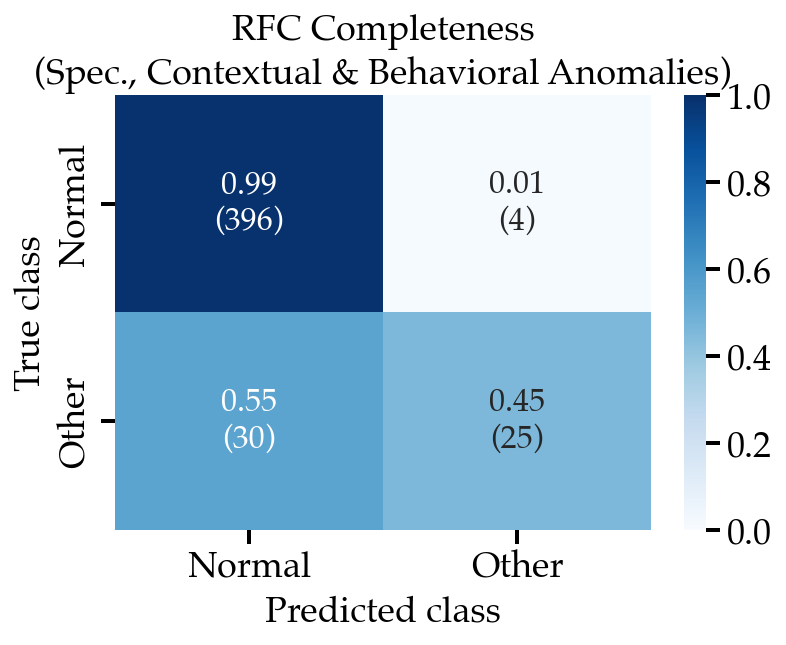

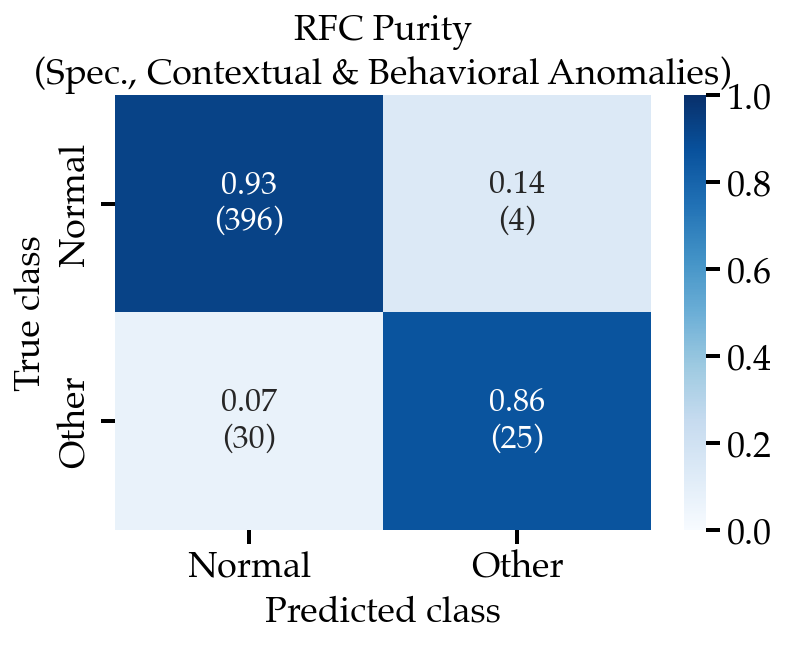

              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96       400
       Other       0.86      0.45      0.60        55

    accuracy                           0.93       455
   macro avg       0.90      0.72      0.78       455
weighted avg       0.92      0.93      0.91       455



In [259]:
# Confusion matrices
title='spec_label_and_vetting'
df = df2
true_labels = true_label_after_vetting
predicted_labels = pred_label_after_vetting
# define the class labels
class_names = np.unique(true_labels)
nclasses = len(class_names)

KINDS = ['Completeness', 'Purity']
for KIND in KINDS:
    # Sims test set
    plot_conf_matrix(true_labels, predicted_labels, labels=class_names, 
             title=f'RFC {KIND}\n(Spec., Contextual & Behavioral Anomalies)', kind=KIND)
    plt.savefig(f'{cm_path}/confmatrix_nclasses={nclasses}_noNone_{title}_{KIND}.pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
print(classification_report(y_true=true_label_after_vetting, y_pred=pred_label_after_vetting, target_names=target_names))

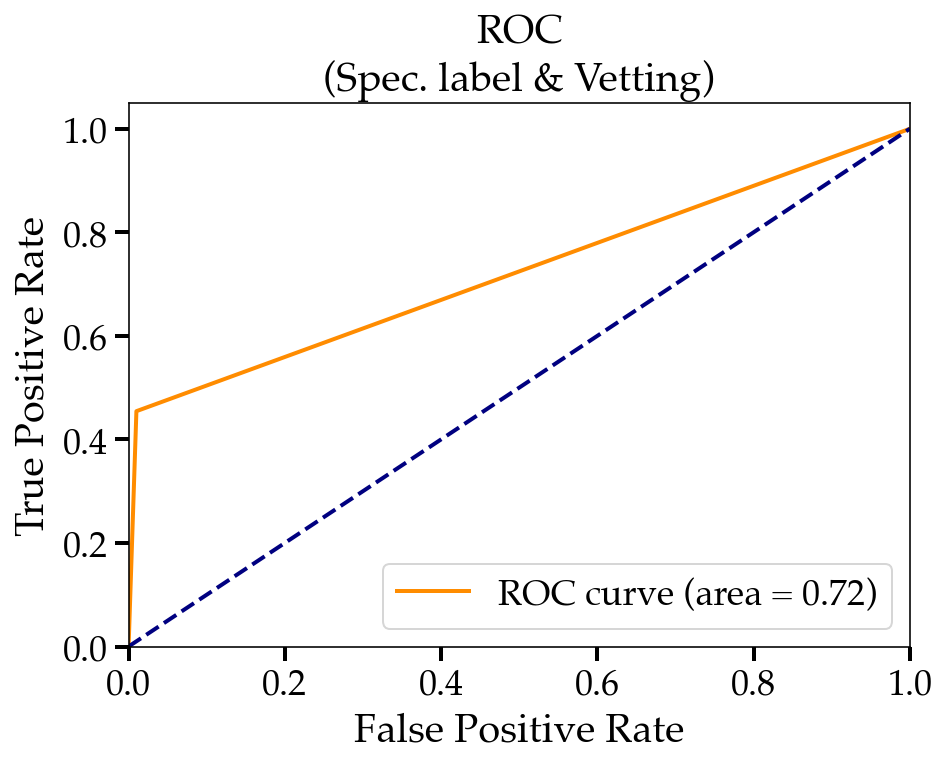

In [260]:
# Convert 'Normal' to 0 and 'Other' to 1
true_labels = np.where(true_labels == 'Normal', 0, 1)
# Convert 'Other' to 0 and 'Other' to 1
predicted_labels = np.where(predicted_labels == 'Normal', 0, 1)

fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC\n(Spec. label & Vetting)')
plt.legend(loc='lower right')
#plt.savefig(f'{figure_path}/AUROC_nclasses={nclasses}_noNone_{title}_{KIND}.pdf', dpi=300, bbox_inches='tight')
plt.show()

# TODO: make one combined PR-curve plot

# Re-run orig. model (random_state=11) w/ 25 different seeds to get uncertainties on purity and completeness

In [164]:
%%time
other_precision_scores, normal_precision_scores = [],[]
other_recall_scores, normal_recall_scores = [],[]
for rs in [12 + s for s in range(0, 25)]:
    # Train Random Forest Classifier
    clf = RandomForestClassifier(n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 random_state=rs, 
                                 max_features=max_features,
                                 class_weight=class_weight,
                                 verbose=1, 
                                 n_jobs=-1)

    clf.fit(x_train, np.array(x_train_all['tns_cls']))
    
    predicted_probability = 100 * clf.predict_proba(x_test)
    
    df = pd.DataFrame(predicted_probability, columns=clf.classes_)
    df = df.set_index(x_test_all.index)
    

    df['RFC_best_cls'] = df.apply(lambda row: clf.classes_[np.argmax(row.values)], axis=1)
    
    df2 = pd.concat([x_test_all, df], axis=1)
    df2 = df2.replace({"tns_cls": di})
    df = df2
    true_labels = np.array(df['tns_cls'])
    predicted_labels = np.array(df['RFC_best_cls'])
    class_names = np.unique(true_labels)
    
    # Calculate performance metrics
    other_precision = precision_score(true_labels, predicted_labels, pos_label='Other')
    other_recall = recall_score(true_labels, predicted_labels, pos_label='Other')
    print("other_precision", other_precision)
    print("other_recall", other_recall)
    normal_precision = precision_score(true_labels, predicted_labels, pos_label='Normal')
    normal_recall = recall_score(true_labels, predicted_labels, pos_label='Normal')
    print("normal_precision", normal_precision)
    print("normal_recall", normal_recall)
    print(classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=target_names))

    # Store the metrics for this fold
    other_precision_scores.append(other_precision)
    other_recall_scores.append(other_recall)
    
    # Store the metrics for this fold
    normal_precision_scores.append(normal_precision)
    normal_recall_scores.append(normal_recall)
    
# Print the mean evaluation metrics across folds
print("Mean Other Precision:", round(sum(other_precision_scores) / len(other_precision_scores), 3))
print("Mean Other Recall:", round(sum(other_recall_scores) / len(other_recall_scores), 3))

# Print the mean evaluation metrics across folds
print("Mean Normal Precision:", round(sum(normal_precision_scores) / len(normal_precision_scores), 3))
print("Mean Normal Recall:", round(sum(normal_recall_scores) / len(normal_recall_scores), 3))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.4444444444444444
other_recall 0.23076923076923078
normal_precision 0.9065420560747663
normal_recall 0.9627791563275434
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       403
       Other       0.44      0.23      0.30        52

    accuracy                           0.88       455
   macro avg       0.68      0.60      0.62       455
weighted avg       0.85      0.88      0.86       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.45161290322580644
other_recall 0.2692307692307692
normal_precision 0.910377358490566
normal_recall 0.9578163771712159
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       403
       Other       0.45      0.27      0.34        52

    accuracy                           0.88       455
   macro avg       0.68      0.61      0.64       455
weighted avg       0.86      0.88      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.5172413793103449
other_recall 0.28846153846153844
normal_precision 0.9131455399061033
normal_recall 0.9652605459057072
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.52      0.29      0.37        52

    accuracy                           0.89       455
   macro avg       0.72      0.63      0.65       455
weighted avg       0.87      0.89      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.4642857142857143
other_recall 0.25
normal_precision 0.9086651053864169
normal_recall 0.9627791563275434
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       403
       Other       0.46      0.25      0.33        52

    accuracy                           0.88       455
   macro avg       0.69      0.61      0.63       455
weighted avg       0.86      0.88      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.4
other_recall 0.23076923076923078
normal_precision 0.9058823529411765
normal_recall 0.9553349875930521
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       403
       Other       0.40      0.23      0.29        52

    accuracy                           0.87       455
   macro avg       0.65      0.59      0.61       455
weighted avg       0.85      0.87      0.86       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.48
other_recall 0.23076923076923078
normal_precision 0.9069767441860465
normal_recall 0.967741935483871
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.48      0.23      0.31        52

    accuracy                           0.88       455
   macro avg       0.69      0.60      0.62       455
weighted avg       0.86      0.88      0.86       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.4482758620689655
other_recall 0.25
normal_precision 0.9084507042253521
normal_recall 0.9602977667493796
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       403
       Other       0.45      0.25      0.32        52

    accuracy                           0.88       455
   macro avg       0.68      0.61      0.63       455
weighted avg       0.86      0.88      0.86       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.4666666666666667
other_recall 0.2692307692307692
normal_precision 0.9105882352941177
normal_recall 0.9602977667493796
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       403
       Other       0.47      0.27      0.34        52

    accuracy                           0.88       455
   macro avg       0.69      0.61      0.64       455
weighted avg       0.86      0.88      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.40625
other_recall 0.25
normal_precision 0.9078014184397163
normal_recall 0.9528535980148883
              precision    recall  f1-score   support

      Normal       0.91      0.95      0.93       403
       Other       0.41      0.25      0.31        52

    accuracy                           0.87       455
   macro avg       0.66      0.60      0.62       455
weighted avg       0.85      0.87      0.86       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.43333333333333335
other_recall 0.25
normal_precision 0.908235294117647
normal_recall 0.9578163771712159
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       403
       Other       0.43      0.25      0.32        52

    accuracy                           0.88       455
   macro avg       0.67      0.60      0.62       455
weighted avg       0.85      0.88      0.86       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.48
other_recall 0.23076923076923078
normal_precision 0.9069767441860465
normal_recall 0.967741935483871
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.48      0.23      0.31        52

    accuracy                           0.88       455
   macro avg       0.69      0.60      0.62       455
weighted avg       0.86      0.88      0.86       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.5
other_recall 0.25
normal_precision 0.9090909090909091
normal_recall 0.967741935483871
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.50      0.25      0.33        52

    accuracy                           0.89       455
   macro avg       0.70      0.61      0.64       455
weighted avg       0.86      0.89      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.4666666666666667
other_recall 0.2692307692307692
normal_precision 0.9105882352941177
normal_recall 0.9602977667493796
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       403
       Other       0.47      0.27      0.34        52

    accuracy                           0.88       455
   macro avg       0.69      0.61      0.64       455
weighted avg       0.86      0.88      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.5416666666666666
other_recall 0.25
normal_precision 0.9095127610208816
normal_recall 0.9727047146401985
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.54      0.25      0.34        52

    accuracy                           0.89       455
   macro avg       0.73      0.61      0.64       455
weighted avg       0.87      0.89      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.5185185185185185
other_recall 0.2692307692307692
normal_precision 0.9112149532710281
normal_recall 0.967741935483871
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.52      0.27      0.35        52

    accuracy                           0.89       455
   macro avg       0.71      0.62      0.65       455
weighted avg       0.87      0.89      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.42424242424242425
other_recall 0.2692307692307692
normal_precision 0.909952606635071
normal_recall 0.9528535980148883
              precision    recall  f1-score   support

      Normal       0.91      0.95      0.93       403
       Other       0.42      0.27      0.33        52

    accuracy                           0.87       455
   macro avg       0.67      0.61      0.63       455
weighted avg       0.85      0.87      0.86       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.5357142857142857
other_recall 0.28846153846153844
normal_precision 0.9133489461358314
normal_recall 0.967741935483871
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.54      0.29      0.37        52

    accuracy                           0.89       455
   macro avg       0.72      0.63      0.66       455
weighted avg       0.87      0.89      0.88       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.5
other_recall 0.25
normal_precision 0.9090909090909091
normal_recall 0.967741935483871
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.50      0.25      0.33        52

    accuracy                           0.89       455
   macro avg       0.70      0.61      0.64       455
weighted avg       0.86      0.89      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.4838709677419355
other_recall 0.28846153846153844
normal_precision 0.9127358490566038
normal_recall 0.9602977667493796
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.94       403
       Other       0.48      0.29      0.36        52

    accuracy                           0.88       455
   macro avg       0.70      0.62      0.65       455
weighted avg       0.86      0.88      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.4375
other_recall 0.2692307692307692
normal_precision 0.9101654846335697
normal_recall 0.9553349875930521
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       403
       Other       0.44      0.27      0.33        52

    accuracy                           0.88       455
   macro avg       0.67      0.61      0.63       455
weighted avg       0.86      0.88      0.86       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.4642857142857143
other_recall 0.25
normal_precision 0.9086651053864169
normal_recall 0.9627791563275434
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       403
       Other       0.46      0.25      0.33        52

    accuracy                           0.88       455
   macro avg       0.69      0.61      0.63       455
weighted avg       0.86      0.88      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.48148148148148145
other_recall 0.25
normal_precision 0.9088785046728972
normal_recall 0.9652605459057072
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.48      0.25      0.33        52

    accuracy                           0.88       455
   macro avg       0.70      0.61      0.63       455
weighted avg       0.86      0.88      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.46875
other_recall 0.28846153846153844
normal_precision 0.9125295508274232
normal_recall 0.9578163771712159
              precision    recall  f1-score   support

      Normal       0.91      0.96      0.93       403
       Other       0.47      0.29      0.36        52

    accuracy                           0.88       455
   macro avg       0.69      0.62      0.65       455
weighted avg       0.86      0.88      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


other_precision 0.48148148148148145
other_recall 0.25
normal_precision 0.9088785046728972
normal_recall 0.9652605459057072
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.48      0.25      0.33        52

    accuracy                           0.88       455
   macro avg       0.70      0.61      0.63       455
weighted avg       0.86      0.88      0.87       455



[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s


other_precision 0.5
other_recall 0.23076923076923078
normal_precision 0.9071925754060325
normal_recall 0.9702233250620348
              precision    recall  f1-score   support

      Normal       0.91      0.97      0.94       403
       Other       0.50      0.23      0.32        52

    accuracy                           0.89       455
   macro avg       0.70      0.60      0.63       455
weighted avg       0.86      0.89      0.87       455

Mean Other Precision: 0.472
Mean Other Recall: 0.257
Mean Normal Precision: 0.909
Mean Normal Recall: 0.963
CPU times: user 1h 8min 16s, sys: 10.1 s, total: 1h 8min 26s
Wall time: 9min 19s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


# Feature Importance

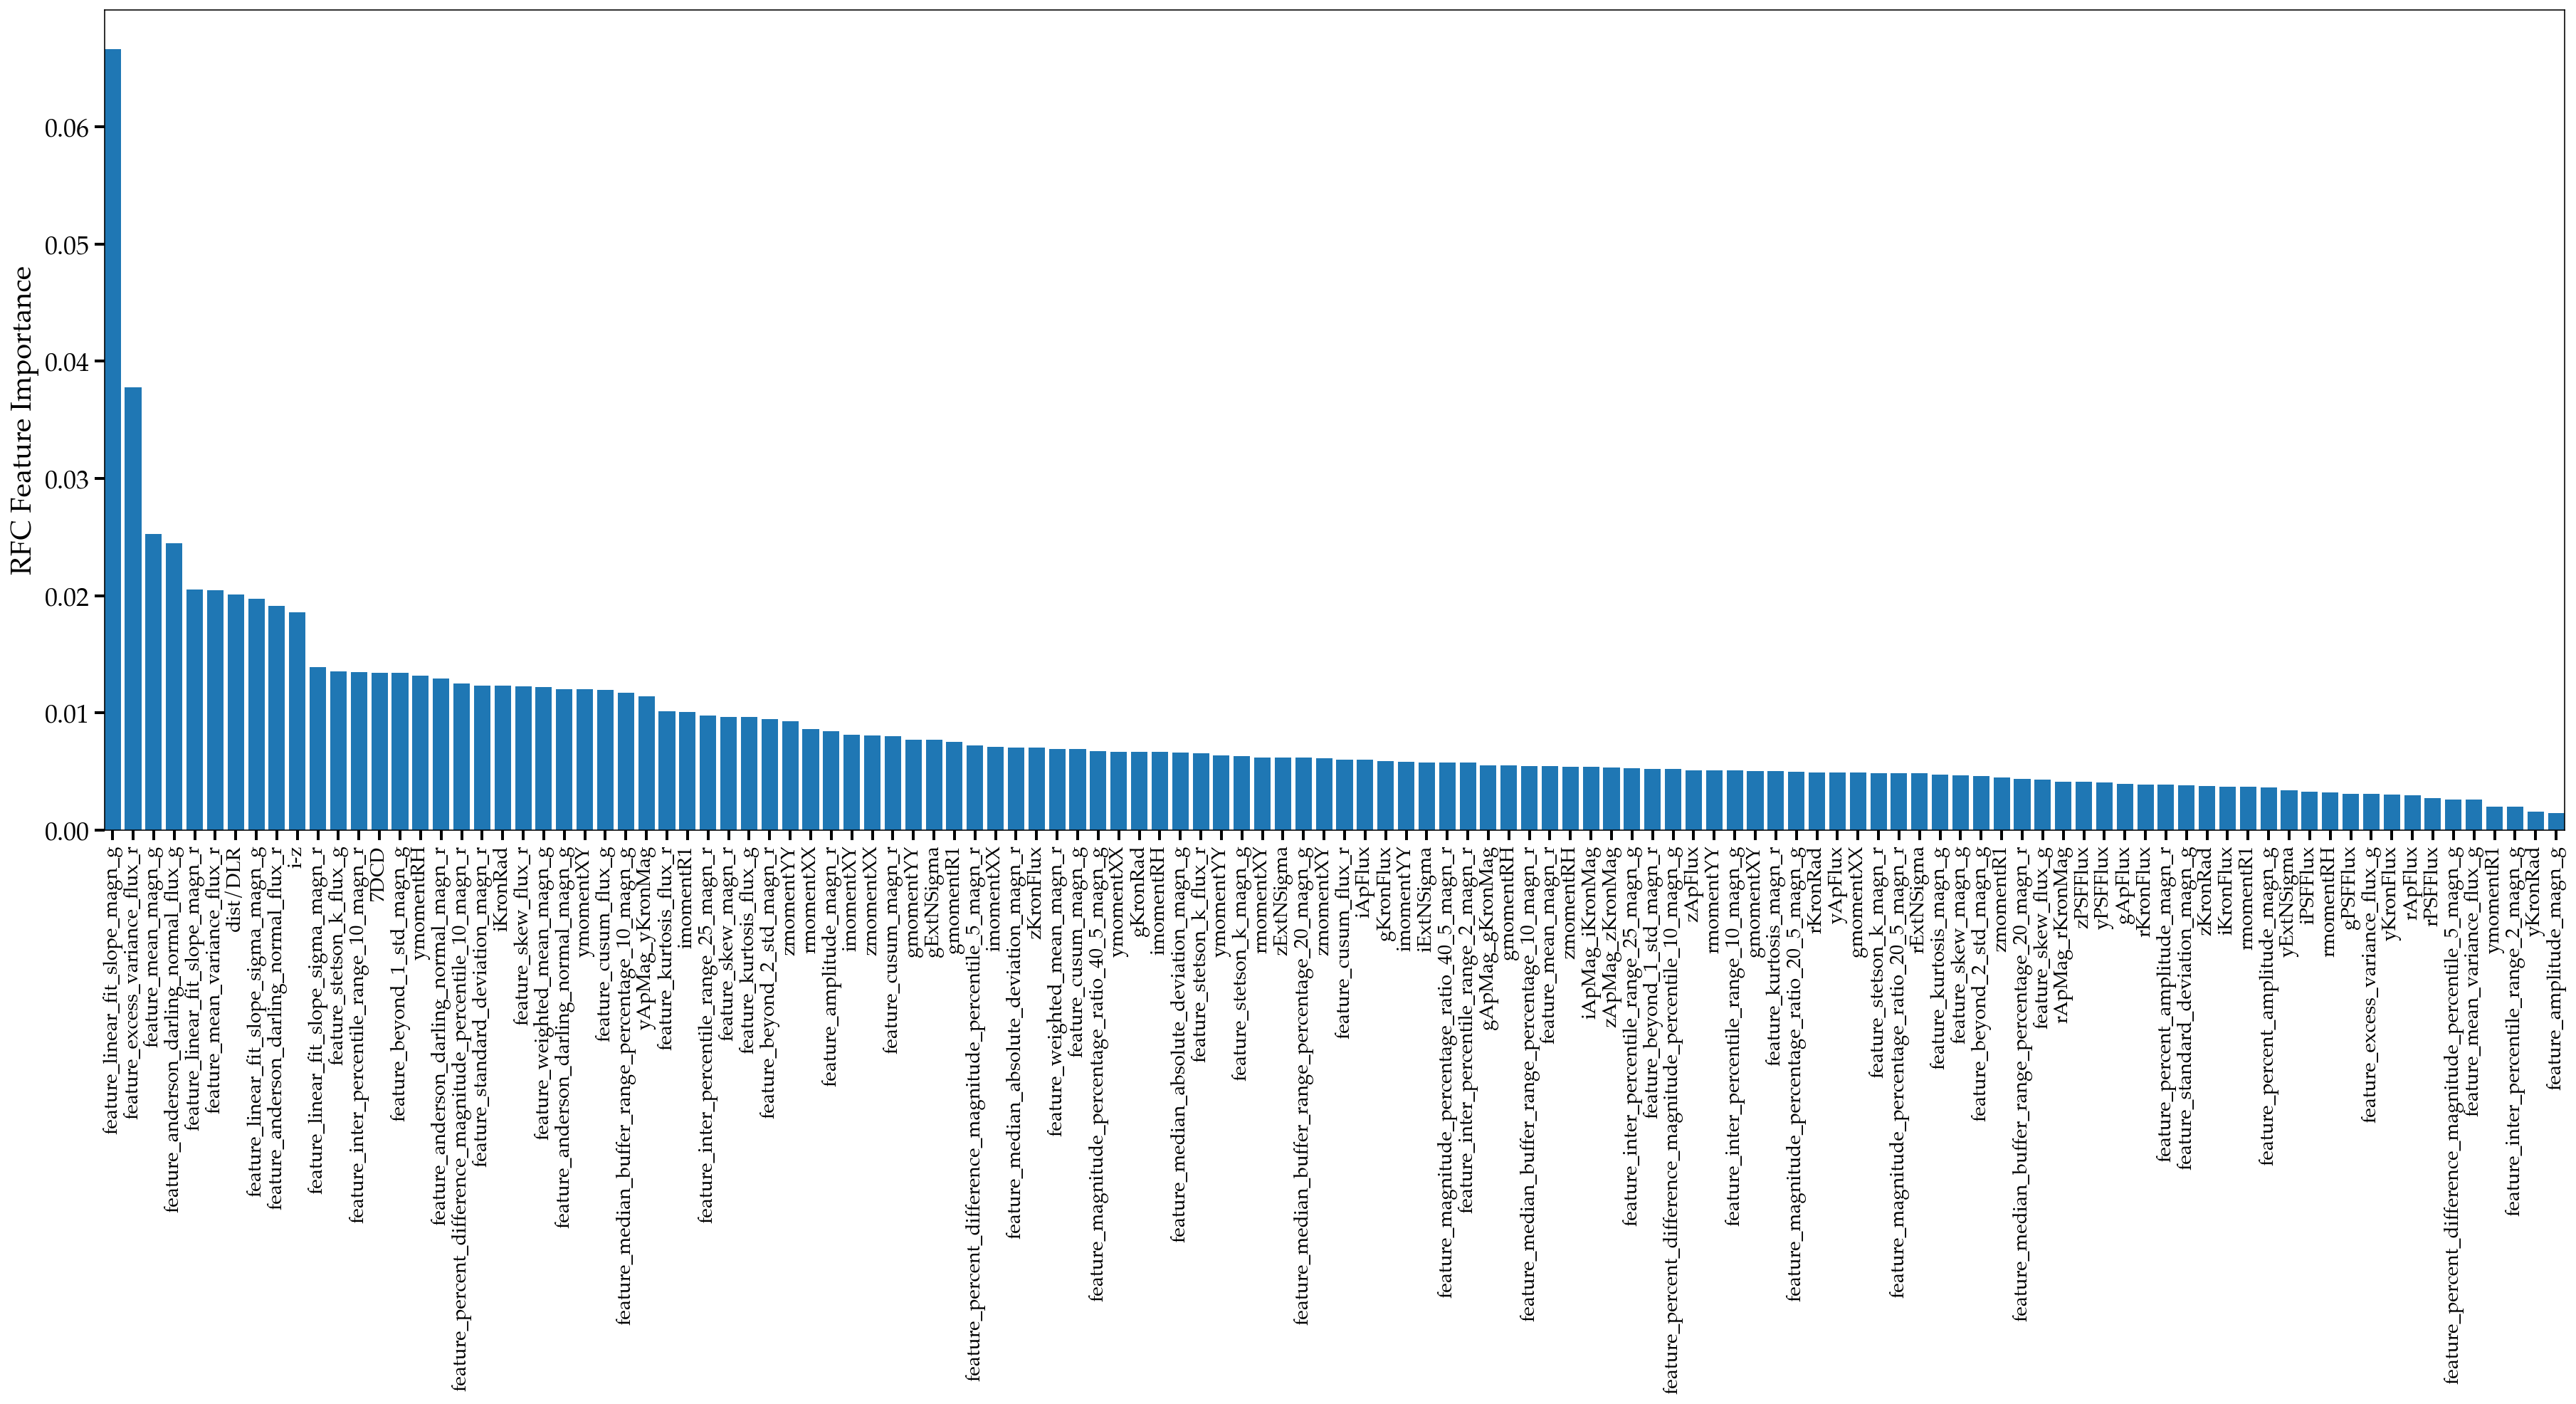

In [104]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

X_train = dataset_bank_tns_df_resampled_train.iloc[:, 0:120]

fig, ax = plt.subplots(figsize=(24, 8))
ax.bar(range(X_train.shape[1]), importances[indices])
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(X_train.columns[indices], rotation=90, fontsize=14)
plt.subplots_adjust(left=0.0, right=1, top=1.0, bottom=0)
ax.set_xlim(left=-0.40, right=119.4)
plt.ylabel('RFC Feature Importance')
#plt.savefig(f'{figure_path}/RFC_feature_importance_horizontal.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
df['tns_cls_orig'] = dataset_bank_tns_df_resampled_test['tns_cls']
df

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazebgh                   0.401764   
ZTF21acgxypn                   0.541942   
ZTF19aapqqrb                   0.143625   
ZTF21aasbxng                   0.943869   
ZTF21aaglgcb                   0.775517   
...                                 ...   
ZTF21acdalyp                   1.061692   
ZTF21abdcauj                   0.633349   
ZTF21aaetnfe                   1.442822   
ZTF21acgzwsc                   0.698412   
ZTF21aatklhw                   0.772630   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazebgh                                 0.347613   
ZTF21acgxypn                                 0.743175   
ZTF19aapqqrb                                 0.195803   
ZTF21aasbxng                                 0.500271   
ZTF21aaglgcb                                 0.484212   
...                                               ...   
ZTF21acdalyp                                 0.242709   
ZTF21abdcauj                                 0.322944   
ZTF21aaetnfe                                 1.007647   
ZTF21acgzwsc                                 0.256419   
ZTF21aatklhw                                 0.303856   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazebgh                      0.454545                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF19aapqqrb                      0.428571                     0.000000   
ZTF21aasbxng                      0.266667                     0.066667   
ZTF21aaglgcb                      0.363636                     0.090909   
...                                    ...                          ...   
ZTF21acdalyp                      0.357143                     0.071429   
ZTF21abdcauj                      0.400000                     0.000000   
ZTF21aaetnfe                      0.380952                     0.000000   
ZTF21acgzwsc                      0.333333                     0.000000   
ZTF21aatklhw                      0.384615                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazebgh               0.412583                                 0.803528   
ZTF21acgxypn               0.395337                                 1.083883   
ZTF19aapqqrb               0.380133                                 0.287251   
ZTF21aasbxng               0.355580                                 1.887737   
ZTF21aaglgcb               0.388404                                 1.551035   
...                             ...                                      ...   
ZTF21acdalyp               0.375832                                 2.123384   
ZTF21abdcauj               0.419177                                 1.266699   
ZTF21aaetnfe               0.455937                                 2.885643   
ZTF21acgzwsc               0.373687                                 1.396824   
ZTF21aatklhw               0.387778                                 1.545259   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazebgh                                   0.769645   
ZTF21acgxypn                                   0.948133   
ZTF19aapqqrb                                   0.271332   
ZTF21aasbxng                                   1.566141   
ZTF21aaglgcb                                   1.241484   
...                                                 ...   
ZTF21acdalyp                                   1.597695   
ZTF21abdcauj                                   0.828672   
ZTF21aaetnfe                                   2.600447   
ZTF21acgzwsc                                   

In [43]:
tagged_anom_df = df[df.RFC_best_cls == "Other"]
most_anomalous_indices = np.argsort(tagged_anom_df.Other)[:29]
tagged_anom_df = tagged_anom_df.iloc[most_anomalous_indices[::-1]] 
tagged_anom_df

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF20acnznms                   0.927183   
ZTF21abpyauz                   0.987303   
ZTF18acaqdaa                   0.964350   
ZTF21aautijg                   0.678457   
ZTF20acyroke                   0.756269   
ZTF18acvgjqv                   1.061049   
ZTF21aafmkjk                   0.671348   
ZTF21aapvvtb                   0.284339   
ZTF21acgxypn                   0.541942   
ZTF20abarsvz                   0.994728   
ZTF21aadacxv                   0.326600   
ZTF21aapffqd                   0.718870   
ZTF21aajvukh                   0.904922   
ZTF21acjgafq                   0.337940   
ZTF21aaizyqc                   1.022863   
ZTF21abcgnqn                   0.394596   
ZTF20accmtgt                   1.348523   
ZTF21aaabwfu                   0.726729   
ZTF21abaxaqq                   0.924701   
ZTF20actkutp                   0.678516   
ZTF21acmnpqa                   0.670024   
ZTF18abaeqpf                   1.072739   
ZTF20abqlmwn                   0.906152   
ZTF20acwytxn                   1.056182   
ZTF20abwxywy                   1.634157   
ZTF21aadkhte                   0.731375   
ZTF20acxqxyw                   0.806231   
ZTF19aaadwfi                   0.870700   
ZTF21aaaokyp                   0.887618   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20acnznms                                 0.978577   
ZTF21abpyauz                                 1.645826   
ZTF18acaqdaa                                 0.948676   
ZTF21aautijg                                 2.020706   
ZTF20acyroke                                 0.767546   
ZTF18acvgjqv                                 0.732289   
ZTF21aafmkjk                                 0.793086   
ZTF21aapvvtb                                 0.247243   
ZTF21acgxypn                                 0.743175   
ZTF20abarsvz                                 0.497720   
ZTF21aadacxv                                 0.454615   
ZTF21aapffqd                                 1.181767   
ZTF21aajvukh                                 0.466470   
ZTF21acjgafq                                 0.264147   
ZTF21aaizyqc                                 2.109273   
ZTF21abcgnqn                                 0.499984   
ZTF20accmtgt                                 0.240779   
ZTF21aaabwfu                                 0.344801   
ZTF21abaxaqq                                 2.200877   
ZTF20actkutp                                 1.128775   
ZTF21acmnpqa                                 0.165766   
ZTF18abaeqpf                                 2.835606   
ZTF20abqlmwn                                 2.573259   
ZTF20acwytxn                                 5.368489   
ZTF20abwxywy                                 0.994964   
ZTF21aadkhte                                 2.742344   
ZTF20acxqxyw                                 0.634359   
ZTF19aaadwfi                                 0.479876   
ZTF21aaaokyp                                 0.675508   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20acnznms                      0.469388                     0.000000   
ZTF21abpyauz                      0.137931                     0.034483   
ZTF18acaqdaa                      0.403509                     0.017544   
ZTF21aautijg                      0.171429                     0.057143   
ZTF20acyroke                      0.363636                     0.000000   
ZTF18acvgjqv                      0.375000                     0.031250   
ZTF21aafmkjk                      0.234043                     0.042553   
ZTF21aapvvtb                      0.357143                     0.000000   
ZTF21acgxypn                      0.200000                     0.000000   
ZTF20abarsvz                      0.384615                     0.051282   
ZTF21aadacxv 

In [44]:
Counter(tagged_anom_df.tns_cls_orig)

Counter({'SLSN-II': 2,
         'SN II': 9,
         'TDE': 6,
         'SN IIn': 3,
         'SN Ia': 5,
         'SN Ic-BL': 1,
         'SN IIb': 1,
         'SN Ic': 1,
         'SN Ib': 1})

(array([ 7., 12.,  3.,  1.,  0.,  3.,  1.,  0.,  0.,  1.]),
 array([0.010929 , 0.0456361, 0.0803432, 0.1150503, 0.1497574, 0.1844645,
        0.2191716, 0.2538787, 0.2885858, 0.3232929, 0.358    ]),
 <BarContainer object of 10 artists>)

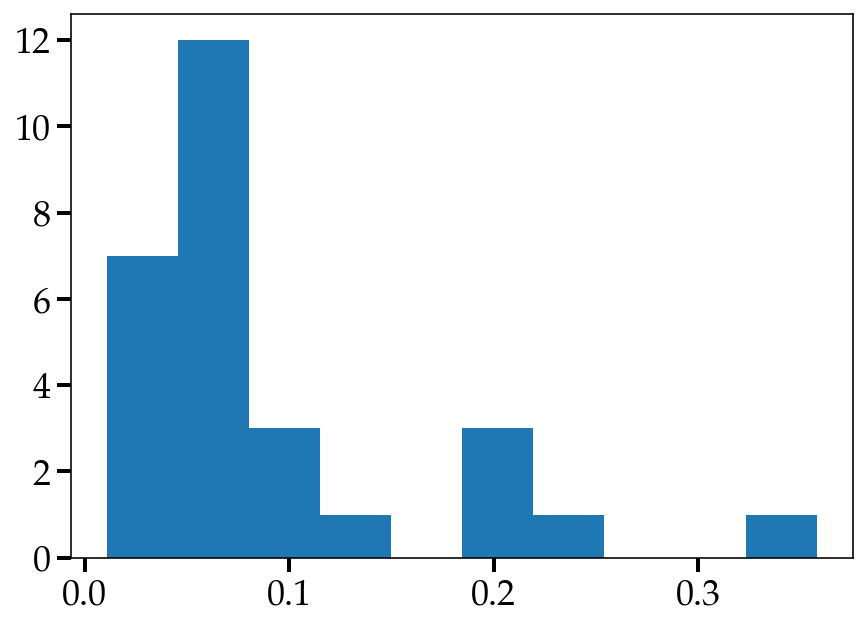

In [45]:
plt.hist(tagged_anom_df.spec_z)

In [73]:
for obj, cls, rfc_cls, pOther in zip(tagged_anom_df.index, tagged_anom_df.tns_cls_orig, tagged_anom_df.RFC_best_cls, tagged_anom_df.Other):
    print(f"https://alerce.online/object/{obj}", cls, rfc_cls, int(round(pOther, 1)))
    print(f"http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={g_hosts_has_ps1_objid_df.loc[obj].raMean}+{g_hosts_has_ps1_objid_df.loc[obj].decMean}&filter=color")
    print("#######")

https://alerce.online/object/ZTF20acnznms SLSN-II Other 91
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=165.00140358+21.11274844&filter=color
#######
https://alerce.online/object/ZTF21abpyauz SN II Other 89
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=358.26213626+-13.04804718&filter=color
#######
https://alerce.online/object/ZTF18acaqdaa TDE Other 76
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=262.01637855+30.69210414&filter=color
#######
https://alerce.online/object/ZTF21aautijg SN IIn Other 76
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=214.24681618+32.23525007&filter=color
#######
https://alerce.online/object/ZTF20acyroke SN Ia Other 72
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=188.96590727+37.70433227&filter=color
#######
https://alerce.online/object/ZTF18acvgjqv SN IIn Other 71
http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=134.07950975+52.54830444&filter=color
#######
https://alerce.online/object/ZTF21aafmkjk SN IIn Other 70
http://ps1images.stsc

In [100]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(70,0.3)
z=0.047
mu = cosmo.distmod(z).value
peak_abs_mag = 17.925-mu
peak_abs_mag

-18.67052713411429

In [55]:
g_hosts_has_ps1_objid_df = pd.read_csv('../loci_dbs/alerce_cut/g_hosts_has_ps1_objid_df.csv.gz', compression='gzip', index_col=0)

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (357) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


objName  objAltName1  objAltName2  \
ztf_object_id                                                         
ZTF17aaadars   PSO J045601.951+044116.934          NaN          NaN   
ZTF17aaadvfh   PSO J004029.558+403608.818          NaN          NaN   
ZTF17aaahrni   PSO J052140.316-041105.937          NaN          NaN   
ZTF17aaaivqs   PSO J082929.021+104624.312          NaN          NaN   
ZTF17aaaizmo   PSO J084836.813+104731.822          NaN          NaN   
...                                   ...          ...          ...   
ZTF22aaboiqa   PSO J114249.899+573231.179          NaN          NaN   
ZTF22aabovlw   PSO J162514.088+334650.634          NaN          NaN   
ZTF22aabovqa   PSO J171106.646+425630.090          NaN          NaN   
ZTF22aabovuq   PSO J171056.231+392950.684          NaN          NaN   
ZTF22aabowtj   PSO J171024.412+794147.638          NaN          NaN   

               objAltName3               objID    uniquePspsOBid  \
ztf_object_id                                                      
ZTF17aaadars           NaN  113620740081156099   956069000004642   
ZTF17aaadvfh           NaN  156720101231743602   914082000045703   
ZTF17aaahrni           NaN  102970804180328356   972544000032447   
ZTF17aaaivqs           NaN  120921273709268539  1027468000002465   
ZTF17aaaizmo           NaN  120951321533861089  1032427000002081   
...                    ...                 ...               ...   
ZTF22aaboiqa           NaN  177051757079321104  1069136000014362   
ZTF22aabovlw           NaN  148532463086857447   949649000045731   
ZTF22aabovqa           NaN  159532577776250649   953535000043742   
ZTF22aabovuq           NaN  155392577342847508   959547000028607   
ZTF22aabowtj           NaN  203632576012866567   989014000001041   

                      ippObjID  surveyID           htmID  zoneID  ...  \
ztf_object_id                                                     ...   
ZTF17aaadars    49039936590369         0  16541820005640   11362  ...   
ZTF17aaadvfh   234990545711751         0  17324649742377   15672  ...   
ZTF17aaahrni   368336395337409         0   9410099655746   10297  ...   
ZTF17aaaivqs    97835060038048         0  16295173533423   12092  ...   
ZTF17aaaizmo    98303211472928         0  16298063690455   12095  ...   
...                        ...       ...             ...     ...  ...   
ZTF22aaboiqa   305883275868186         0  15866137922506   17705  ...   
ZTF22aabovlw   220147138736802         0  15306706550423   14853  ...   
ZTF22aabovqa   254455337495262         0  15272409431749   15953  ...   
ZTF22aabovuq   254472517349311         0  15268202904088   15539  ...   
ZTF22aabowtj   356774343345168         0  14625216760758   20363  ...   

               primaryDetection_y  gpetR90  rpetR90  ipetR90  zpetR90  \
ztf_object_id                                                           
ZTF17aaadars                  1.0  1.59675  1.80257  1.25168  1.00706   
ZTF17aaadvfh                  1.0  3.51795  1.71009  3.68748  1.00743   
ZTF17aaahrni                  1.0  7.69536  4.78322  2.41682  2.38415   
ZTF17aaaivqs                  1.0  2.29301  1.98225      NaN  2.09011   
ZTF17aaaizmo                  1.0  7.82577  7.37937  7.62059  7.36754   
...                           ...      ...      ...      ...      ...   
ZTF22aaboiqa                  1.0  2.63672  2.32033  2.57768  2.74372   
ZTF22aabovlw                  1.0  6.14936  8.56862  7.80833  7.84493   
ZTF22aabovqa                  1.0  5.04883  5.25051  5.60975  5.06479   
ZTF22aabovuq                  1.0  5.35157  4.63887  4.35803  3.90332   
ZTF22aabowtj                  1.0  7.48074  3.80105  6.58223  1.74411   

                ypetR90  NED_redshift_flag  hasSimbad  class  level_0  
ztf_object_id                                                          
ZTF17aaadars   1.154150                NaN        0.0  False      NaN  
ZTF17aaadvfh   1.773110                NaN        1.0    NaN      NaN  
ZTF17aaahrni   0.953395              

In [58]:
g_hosts_has_ps1_objid_df.loc["ZTF21abpyauz"].raMean, g_hosts_has_ps1_objid_df.loc["ZTF21abpyauz"].decMean

(358.26213626, -13.04804718)

In [72]:
ob = 'ZTF20acnznms'
print(f"http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={g_hosts_has_ps1_objid_df.loc[ob].raMean}+{g_hosts_has_ps1_objid_df.loc[ob].decMean}&filter=color")
    

http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=165.00140358+21.11274844&filter=color


# IF on full features

In [49]:
%%time 
# In summary, you train your Random Forest Classifier to classify your data, 
# and then use the Isolation Forest algorithm on the output probabilities of the Random Forest Classifier 
# to detect anomalies.

from sklearn.ensemble import IsolationForest

anomaly_scores = IsolationForest(n_estimators=100, 
                                random_state=11, 
                                contamination=0.13, #change
                                max_features=35, # 12 for with None cls
                                n_jobs=-1).fit(x_test).decision_function(x_test)

most_anomalous_indices = np.argsort(anomaly_scores)[:29]
most_anomalous_samples = df2.iloc[most_anomalous_indices] 
most_anomalous_samples

CPU times: user 247 ms, sys: 89.3 ms, total: 336 ms
Wall time: 286 ms


/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


feature_amplitude_magn_r  \
ztf_object_id                             
ZTF20adadrhw                   2.070520   
ZTF21aavqphe                   2.030300   
ZTF21aagojfe                   1.922398   
ZTF20abptxls                   2.378984   
ZTF20adagenq                   2.246432   
ZTF21aagsypp                   1.947680   
ZTF20acwfftd                   0.940681   
ZTF20acounxo                   0.817722   
ZTF21abbwbja                   0.698014   
ZTF18aawfofp                   0.966969   
ZTF18acbvgtu                   0.333231   
ZTF22aaayewi                   0.468829   
ZTF20adadshh                   1.023753   
ZTF20abrjmgi                   1.755694   
ZTF20aatxryt                   1.710750   
ZTF21aciqcge                   0.540038   
ZTF21aanzcuj                   0.759306   
ZTF21acptqqo                   0.858155   
ZTF21aagsihi                   1.877941   
ZTF21acermmd                   1.248957   
ZTF20acwytxn                   1.056182   
ZTF21abchjer                   0.913735   
ZTF18actuhrs                   1.878891   
ZTF21aaetnfe                   1.442822   
ZTF21aagtqna                   0.940561   
ZTF21aarasky                   0.145838   
ZTF21aaygqkb                   1.070550   
ZTF21aarerya                   0.276559   
ZTF20abwxywy                   1.634157   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20adadrhw                                 1.750877   
ZTF21aavqphe                                 0.349804   
ZTF21aagojfe                                 1.359203   
ZTF20abptxls                                 0.741708   
ZTF20adagenq                                 0.591783   
ZTF21aagsypp                                 1.027686   
ZTF20acwfftd                                 4.199886   
ZTF20acounxo                                 1.572173   
ZTF21abbwbja                                 1.352401   
ZTF18aawfofp                                 0.902579   
ZTF18acbvgtu                                 0.201153   
ZTF22aaayewi                                 0.274049   
ZTF20adadshh                                 1.032415   
ZTF20abrjmgi                                 0.310299   
ZTF20aatxryt                                 0.856208   
ZTF21aciqcge                                 3.532657   
ZTF21aanzcuj                                 5.313059   
ZTF21acptqqo                                 0.405909   
ZTF21aagsihi                                 1.139061   
ZTF21acermmd                                 0.431365   
ZTF20acwytxn                                 5.368489   
ZTF21abchjer                                 0.840731   
ZTF18actuhrs                                 4.315469   
ZTF21aaetnfe                                 1.007647   
ZTF21aagtqna                                 5.566822   
ZTF21aarasky                                 0.370277   
ZTF21aaygqkb                                 5.143812   
ZTF21aarerya                                 0.853475   
ZTF20abwxywy                                 0.994964   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20adadrhw                      0.348837                     0.000000   
ZTF21aavqphe                      0.303030                     0.000000   
ZTF21aagojfe                      0.419355                     0.000000   
ZTF20abptxls                      0.372549                     0.019608   
ZTF20adagenq                      0.416667                     0.000000   
ZTF21aagsypp                      0.388889                     0.000000   
ZTF20acwfftd                      0.142857                     0.061224   
ZTF20acounxo                      0.176471                     0.000000   
ZTF21abbwbja                      0.142857                     0.142857   
ZTF18aawfofp                      0.090909                     0.090909   
ZTF18acbvgtu 

In [50]:
for obj, cls, rfc_cls in zip(most_anomalous_samples.index, most_anomalous_samples.tns_cls, most_anomalous_samples.RFC_best_cls):
    print(f"https://alerce.online/object/{obj}", cls, rfc_cls)

https://alerce.online/object/ZTF20adadrhw Other Normal
https://alerce.online/object/ZTF21aavqphe Normal Normal
https://alerce.online/object/ZTF21aagojfe Normal Normal
https://alerce.online/object/ZTF20abptxls Normal Normal
https://alerce.online/object/ZTF20adagenq Normal Normal
https://alerce.online/object/ZTF21aagsypp Normal Normal
https://alerce.online/object/ZTF20acwfftd Normal Normal
https://alerce.online/object/ZTF20acounxo Other Normal
https://alerce.online/object/ZTF21abbwbja Normal Normal
https://alerce.online/object/ZTF18aawfofp Normal Normal
https://alerce.online/object/ZTF18acbvgtu Normal Normal
https://alerce.online/object/ZTF22aaayewi Normal Normal
https://alerce.online/object/ZTF20adadshh Normal Normal
https://alerce.online/object/ZTF20abrjmgi Normal Normal
https://alerce.online/object/ZTF20aatxryt Normal Normal
https://alerce.online/object/ZTF21aciqcge Normal Normal
https://alerce.online/object/ZTF21aanzcuj Normal Normal
https://alerce.online/object/ZTF21acptqqo Normal N

#### Not nearly as good. Mostly just bright things you can get from Data Cut

In [33]:
df2_other =df2[df2['tns_cls'] == 'Other']
df2_other_cor = df2_other[df2_other['tns_cls'] == df2_other['RFC_best_cls']]
df2_other_inc = df2_other[df2_other['tns_cls'] != df2_other['RFC_best_cls']]

df2_other_inc

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21acqyqwu                   0.164925   
ZTF21abchjer                   0.913735   
ZTF20abtjjhb                   1.216100   
ZTF21aaffxdt                   0.090092   
ZTF20actekrw                   0.489840   
ZTF20acyydkh                   0.224917   
ZTF20abvquuo                   1.015534   
ZTF19abstsvm                   0.533802   
ZTF20acueziy                   0.884608   
ZTF20acusecr                   0.406060   
ZTF21acmrdga                   0.795146   
ZTF22aaaedas                   0.267684   
ZTF20aclnplo                   0.897853   
ZTF21abtdvpg                   0.660813   
ZTF20acgiglu                   0.786353   
ZTF20aczgmai                   0.511466   
ZTF21aaxtctv                   1.360205   
ZTF21aaxxihx                   0.766973   
ZTF21aarasky                   0.145838   
ZTF20adadrhw                   2.070520   
ZTF21aadatfg                   1.009226   
ZTF21aaoqbbw                   0.669034   
ZTF20aceokvr                   0.772009   
ZTF20acwofhd                   1.111611   
ZTF21aayonfd                   0.459514   
ZTF20acounxo                   0.817722   
ZTF21aaradzm                   1.213295   
ZTF21aaxvcmj                   0.531418   
ZTF21acqvuyb                   0.723663   
ZTF21aahfjrr                   0.802070   
ZTF21acjmvhx                   0.442817   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21acqyqwu                                 0.191106   
ZTF21abchjer                                 0.840731   
ZTF20abtjjhb                                 1.723425   
ZTF21aaffxdt                                 0.572517   
ZTF20actekrw                                 1.396014   
ZTF20acyydkh                                 0.229615   
ZTF20abvquuo                                 1.125783   
ZTF19abstsvm                                 0.952866   
ZTF20acueziy                                 0.583604   
ZTF20acusecr                                 0.733228   
ZTF21acmrdga                                 0.320703   
ZTF22aaaedas                                 0.528615   
ZTF20aclnplo                                 0.414874   
ZTF21abtdvpg                                 1.068944   
ZTF20acgiglu                                 0.560882   
ZTF20aczgmai                                 0.864766   
ZTF21aaxtctv                                 1.926664   
ZTF21aaxxihx                                 0.879043   
ZTF21aarasky                                 0.370277   
ZTF20adadrhw                                 1.750877   
ZTF21aadatfg                                 0.273438   
ZTF21aaoqbbw                                 1.296353   
ZTF20aceokvr                                 3.986711   
ZTF20acwofhd                                 1.231543   
ZTF21aayonfd                                 0.824207   
ZTF20acounxo                                 1.572173   
ZTF21aaradzm                                 1.519595   
ZTF21aaxvcmj                                 0.740801   
ZTF21acqvuyb                                 0.435419   
ZTF21aahfjrr                                 1.489103   
ZTF21acjmvhx                                 0.278013   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21acqyqwu                      0.222222                     0.000000   
ZTF21abchjer                      0.300000                     0.000000   
ZTF20abtjjhb                      0.212766                     0.063830   
ZTF21aaffxdt                      0.444444                     0.000000   
ZTF20actekrw                      0.166667                     0.083333   
ZTF20acyydkh                      0.222222                     0.000000   
ZTF20abvquuo                      0.413793                     0.000000   
ZTF19abstsvm                      0.22

In [34]:
print("Missed `anomalies' (labeled as Normal)")
for ob in df2_other_inc.index:
    print(f'https://alerce.online/object/{ob}', x_test_all.loc[ob].tns_cls)

Missed `anomalies' (labeled as Normal)
https://alerce.online/object/ZTF21acqyqwu SN Ib
https://alerce.online/object/ZTF21abchjer SN Ic-BL
https://alerce.online/object/ZTF20abtjjhb SN IIn
https://alerce.online/object/ZTF21aaffxdt SN IIn
https://alerce.online/object/ZTF20actekrw SN Ic
https://alerce.online/object/ZTF20acyydkh TDE
https://alerce.online/object/ZTF20abvquuo SN Ib
https://alerce.online/object/ZTF19abstsvm SN IIn
https://alerce.online/object/ZTF20acueziy SN Ic
https://alerce.online/object/ZTF20acusecr SN IIb
https://alerce.online/object/ZTF21acmrdga SN IIb
https://alerce.online/object/ZTF22aaaedas TDE
https://alerce.online/object/ZTF20aclnplo SN Ic
https://alerce.online/object/ZTF21abtdvpg SN IIn
https://alerce.online/object/ZTF20acgiglu SN IIb
https://alerce.online/object/ZTF20aczgmai SN IIn
https://alerce.online/object/ZTF21aaxtctv SN Ic
https://alerce.online/object/ZTF21aaxxihx SN Ic-BL
https://alerce.online/object/ZTF21aarasky SN IIb
https://alerce.online/object/ZTF20adad

ZTF21acqyqwu Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


12
https://alerce.online/object/ZTF21acqyqwu Other


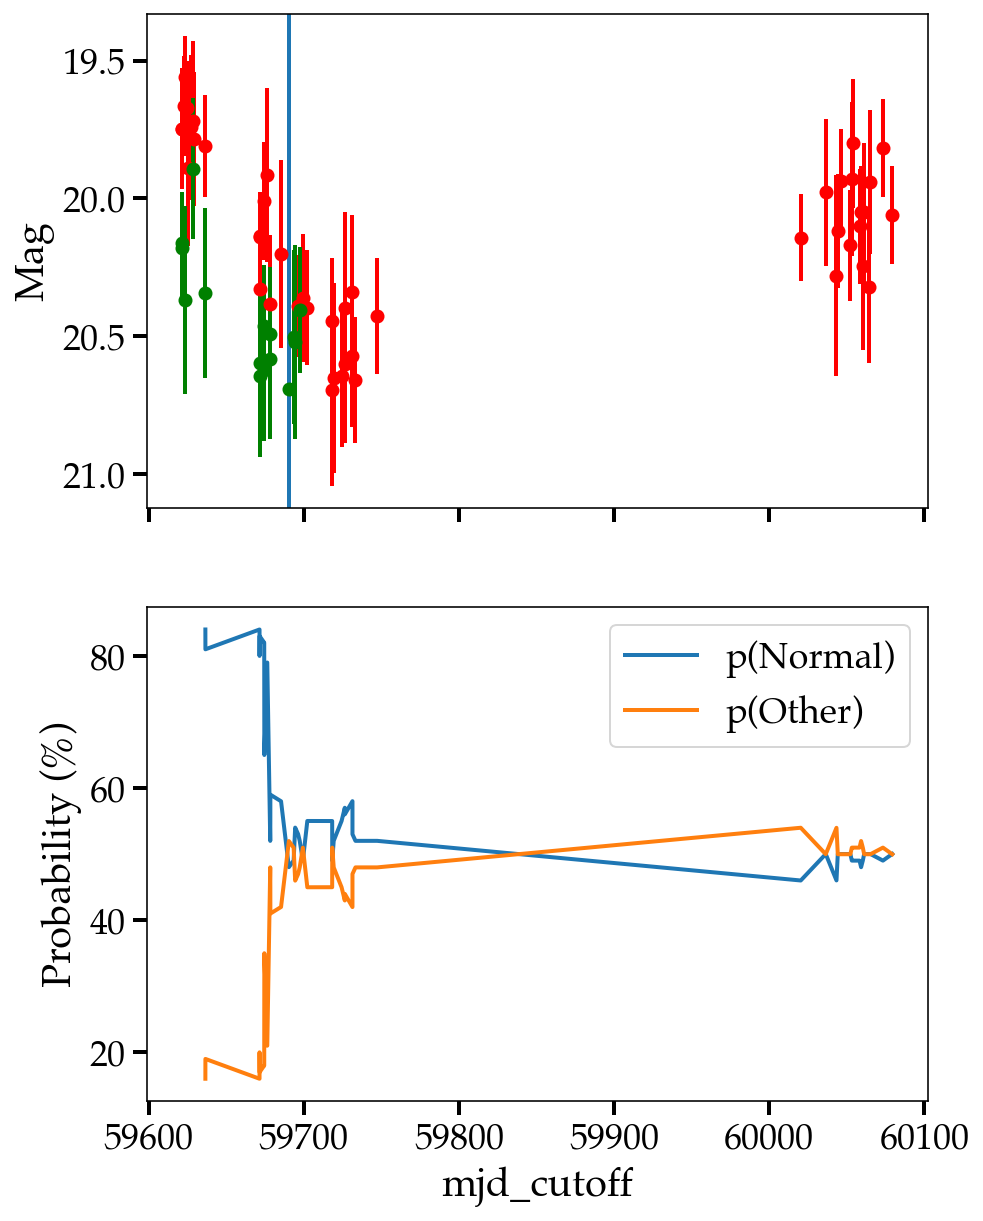

ZTF21abchjer Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


2
https://alerce.online/object/ZTF21abchjer Other


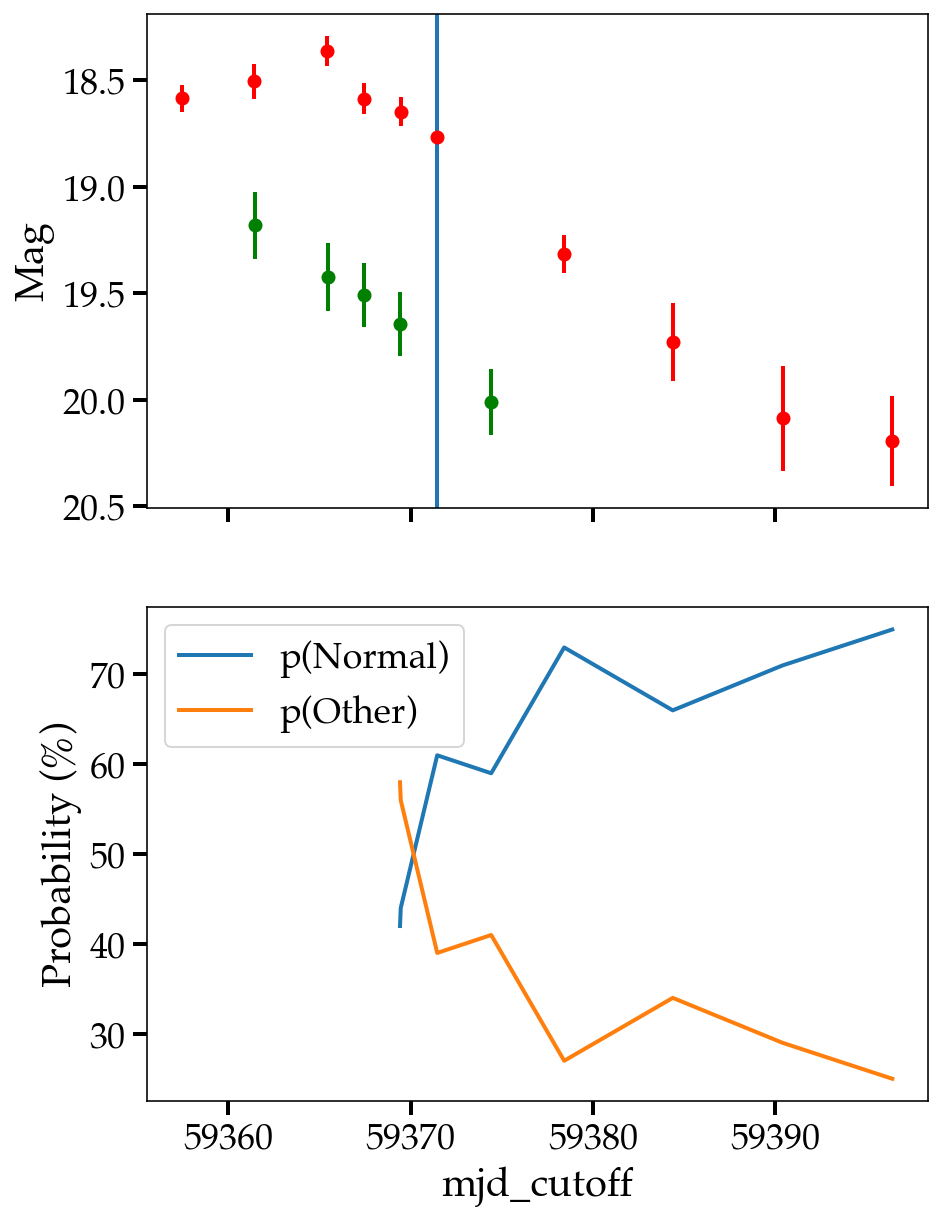

ZTF20abtjjhb Other
Prediction doesn't exceed anom_threshold of 50% for ZTF20abtjjhb.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF20abtjjhb Other


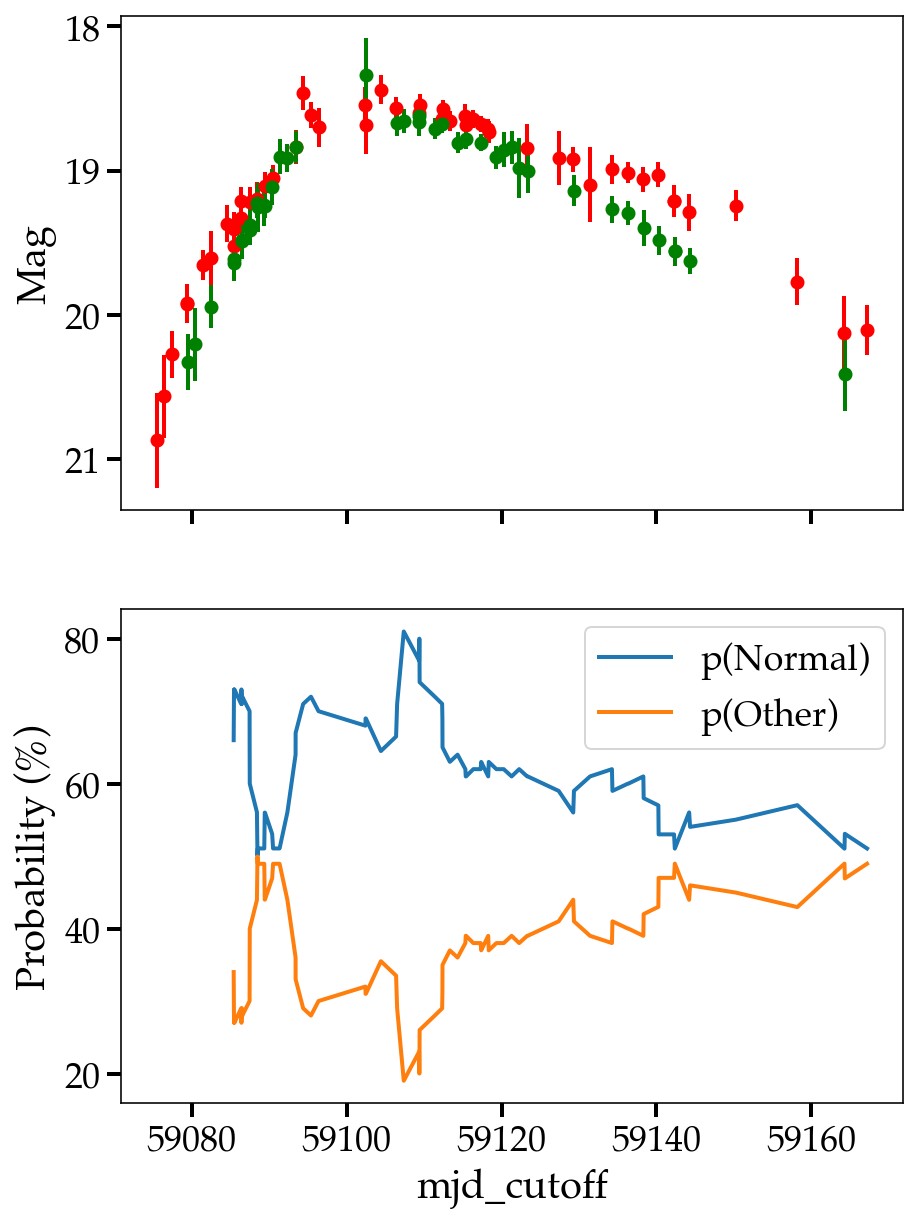

ZTF21aaffxdt Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21aaffxdt.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21aaffxdt Other


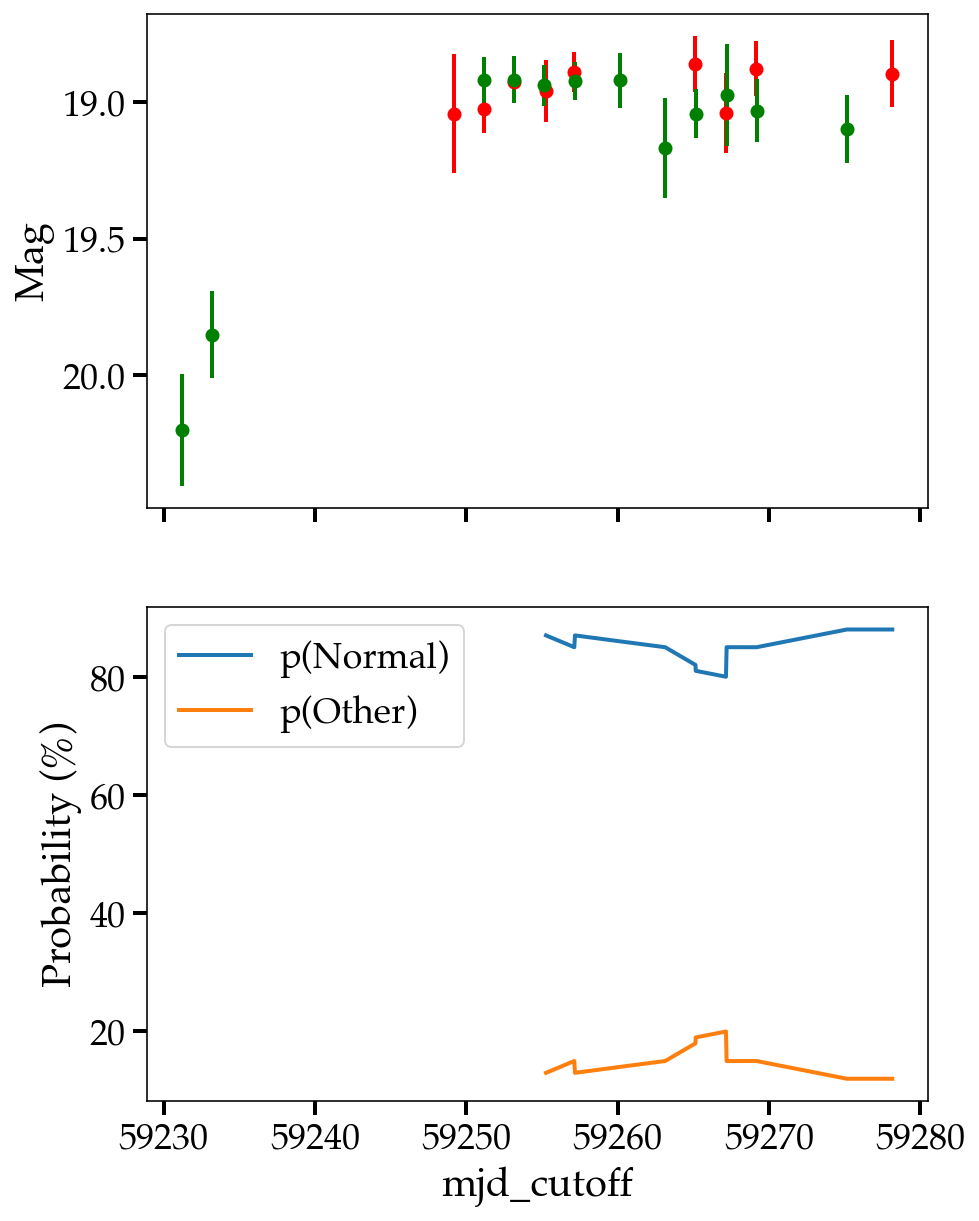

ZTF20actekrw Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


1
https://alerce.online/object/ZTF20actekrw Other


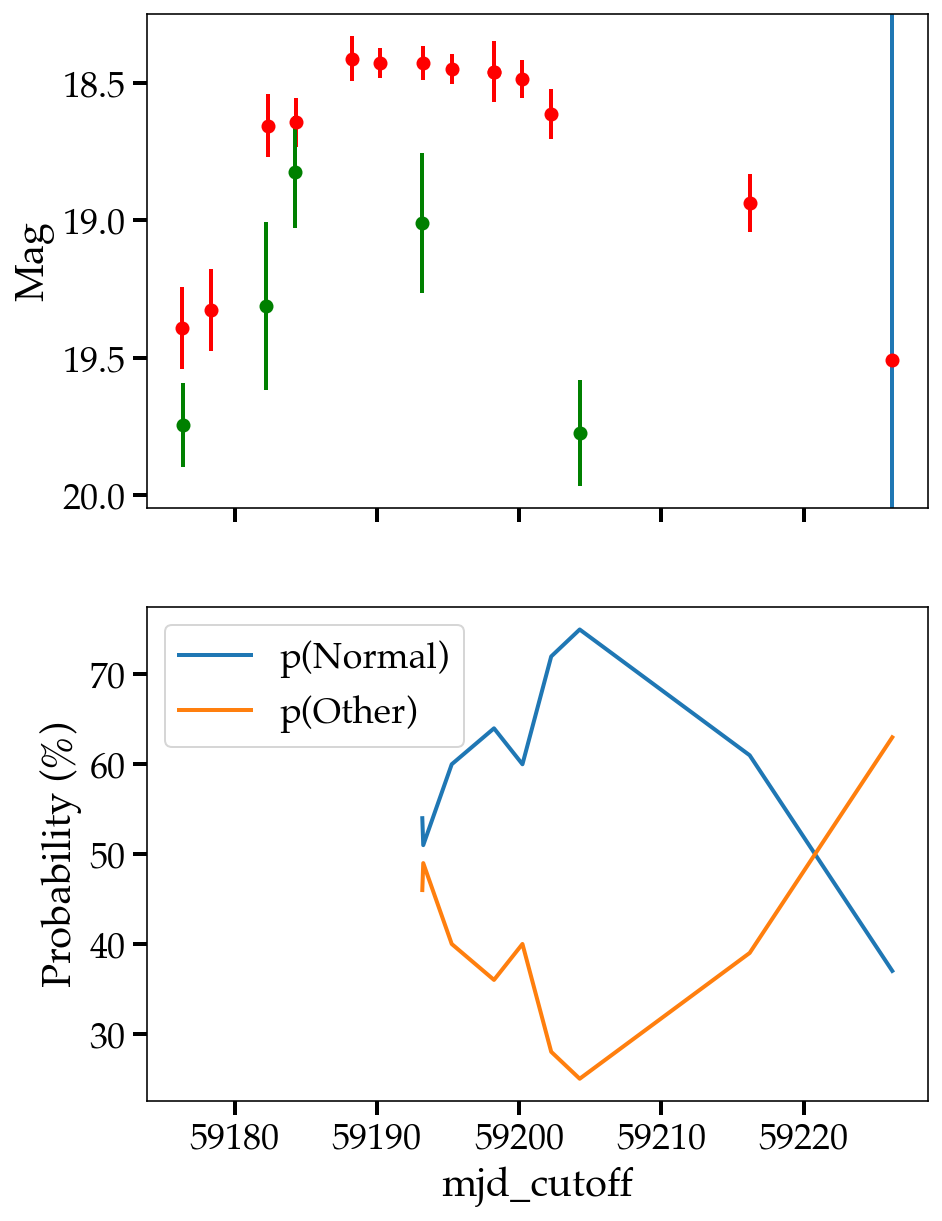

ZTF20acyydkh Other
Prediction doesn't exceed anom_threshold of 50% for ZTF20acyydkh.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF20acyydkh Other


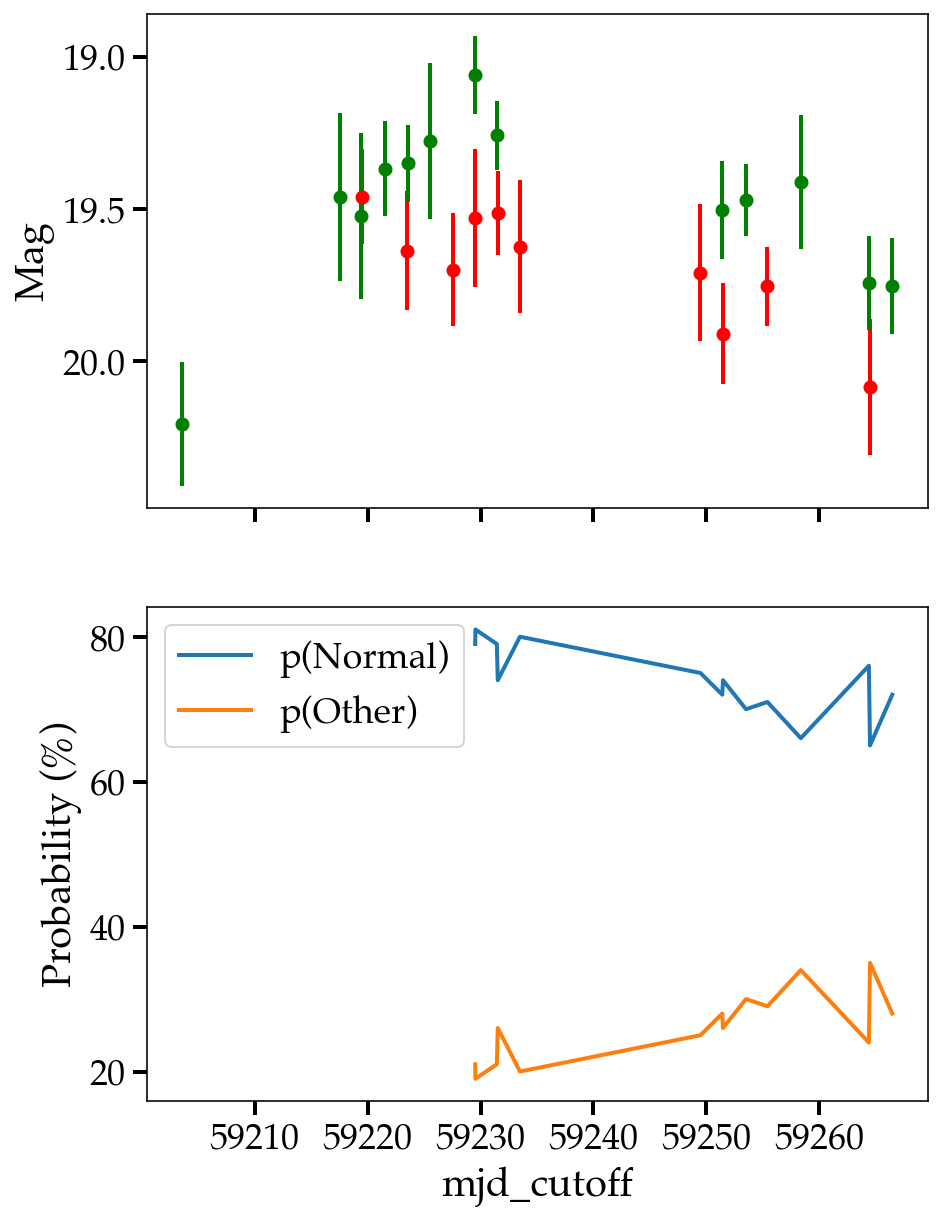

ZTF20abvquuo Other
Prediction doesn't exceed anom_threshold of 50% for ZTF20abvquuo.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF20abvquuo Other


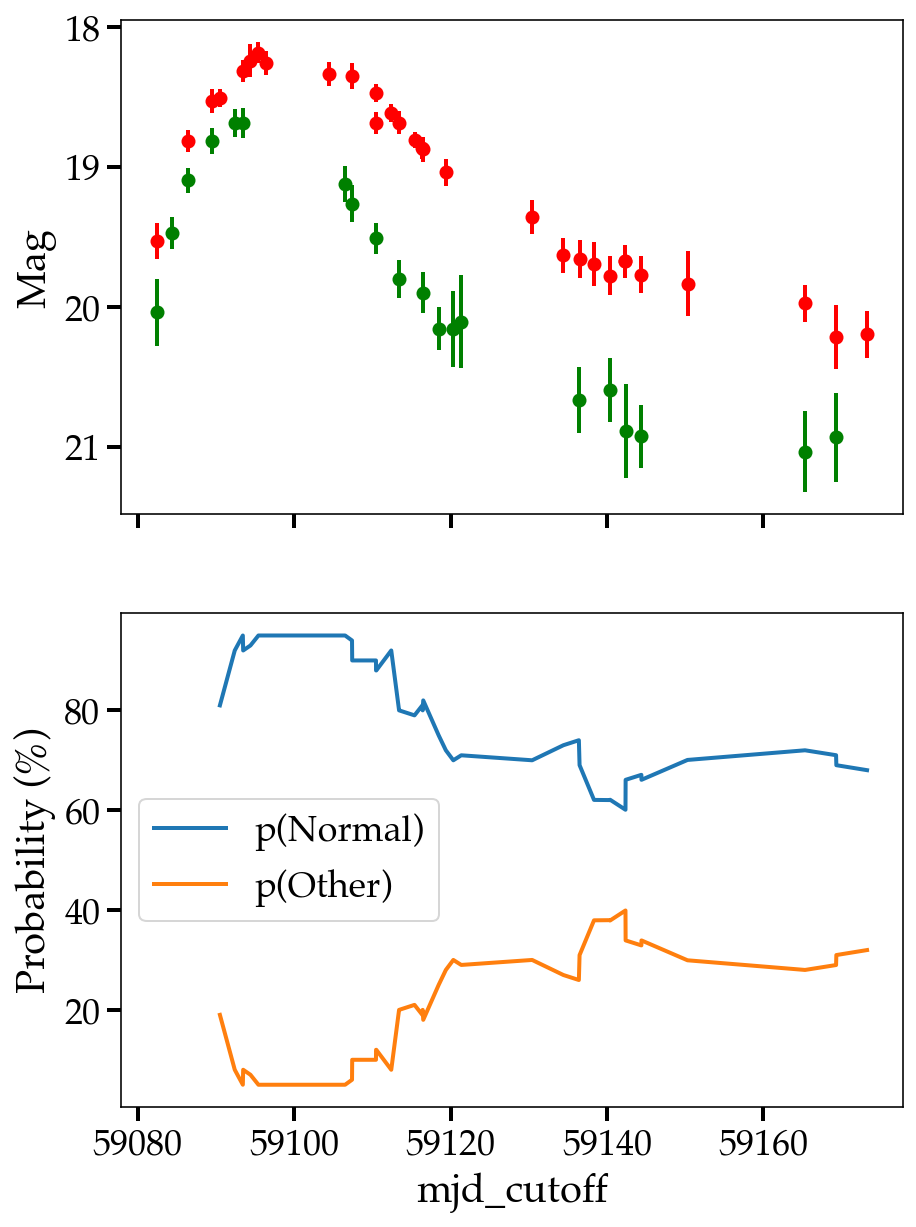

ZTF19abstsvm Other
Prediction doesn't exceed anom_threshold of 50% for ZTF19abstsvm.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF19abstsvm Other


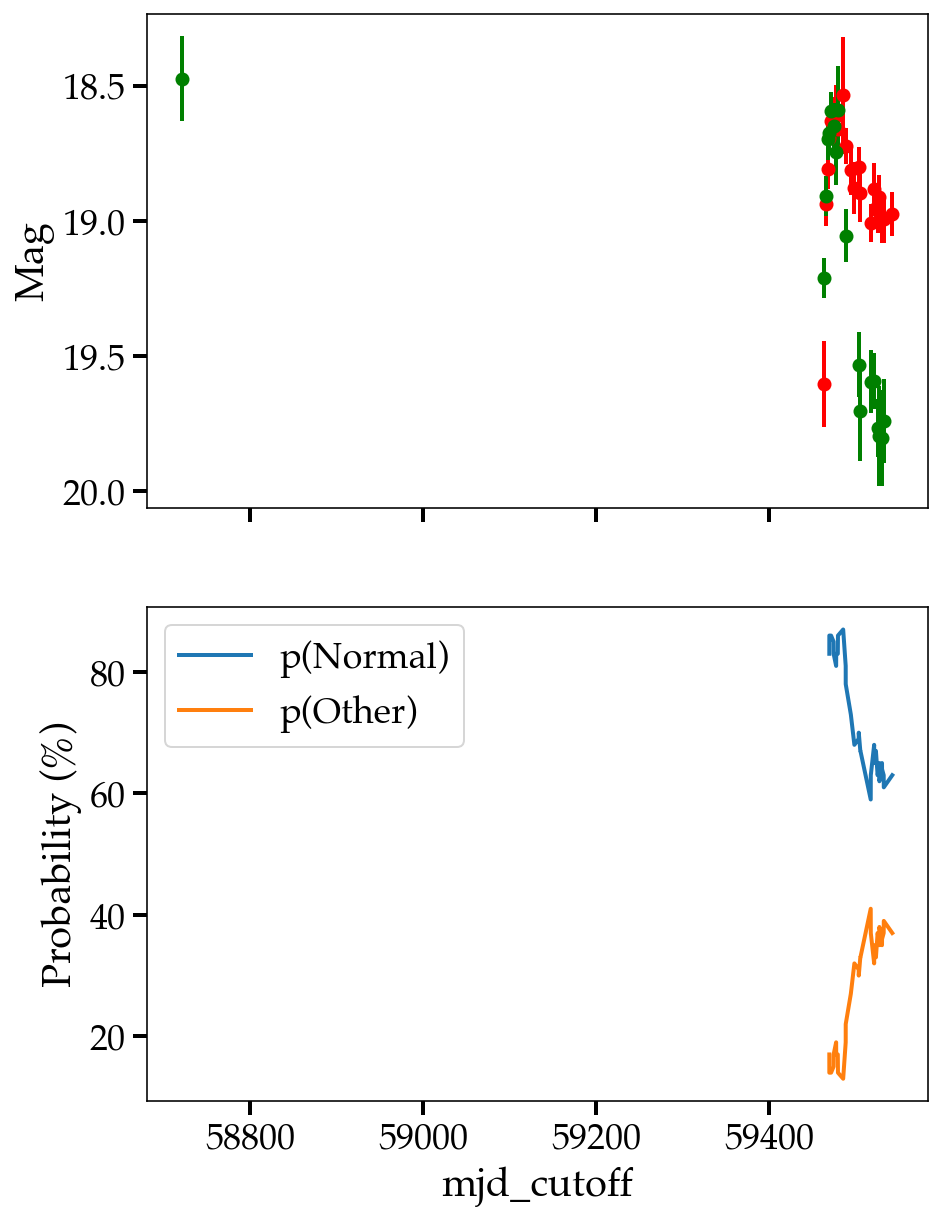

ZTF20acueziy Other
Prediction doesn't exceed anom_threshold of 50% for ZTF20acueziy.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF20acueziy Other


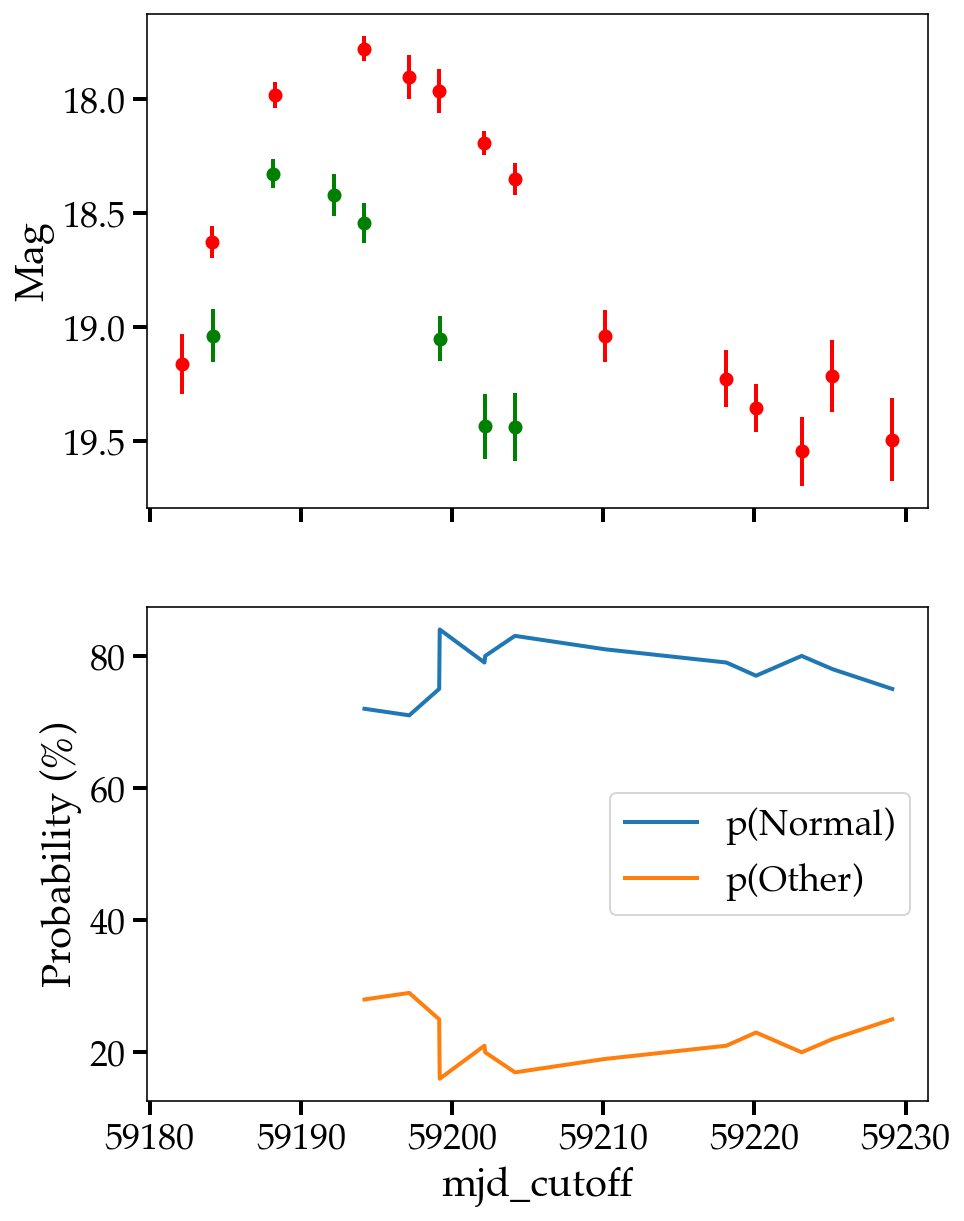

ZTF20acusecr Other
Prediction doesn't exceed anom_threshold of 50% for ZTF20acusecr.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF20acusecr Other


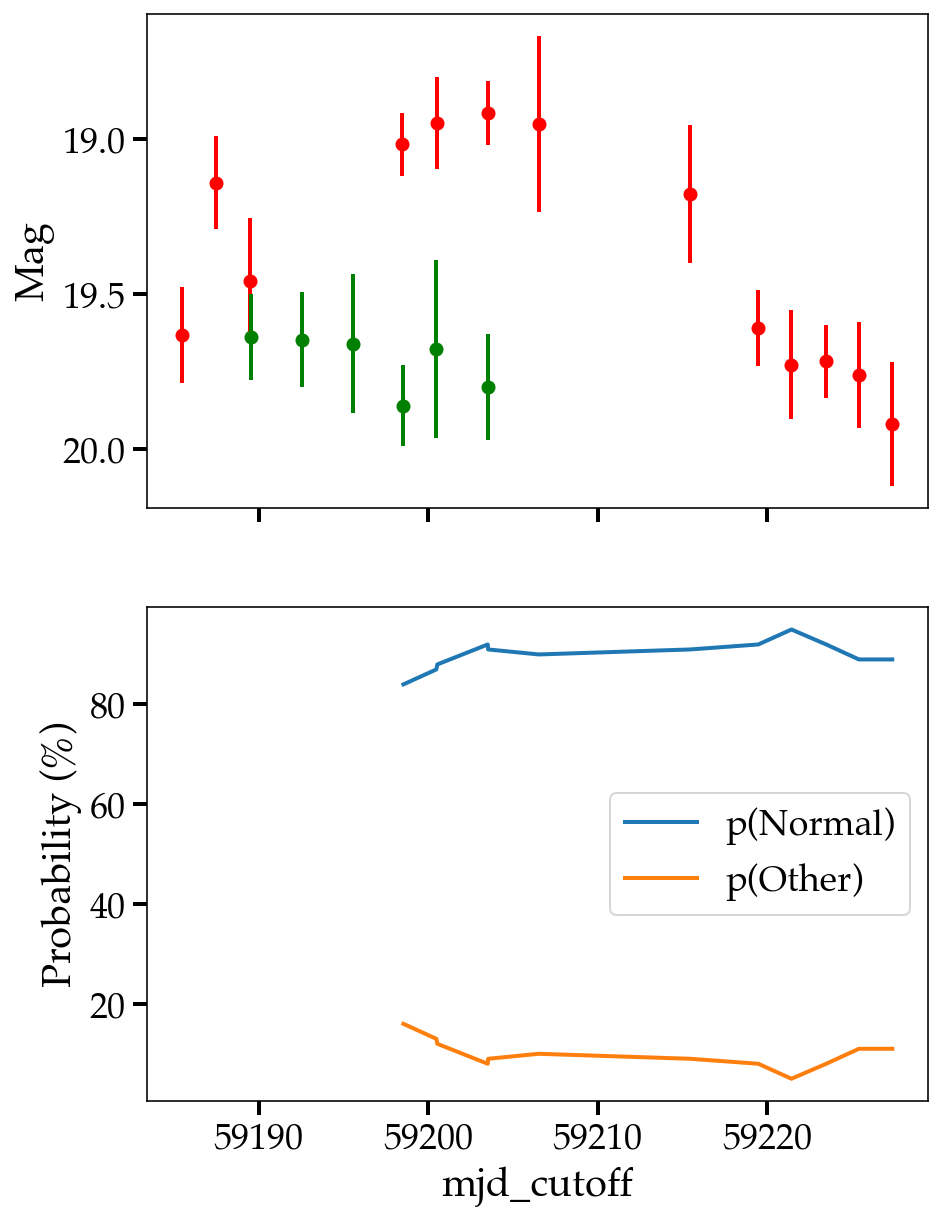

ZTF21acmrdga Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21acmrdga.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21acmrdga Other


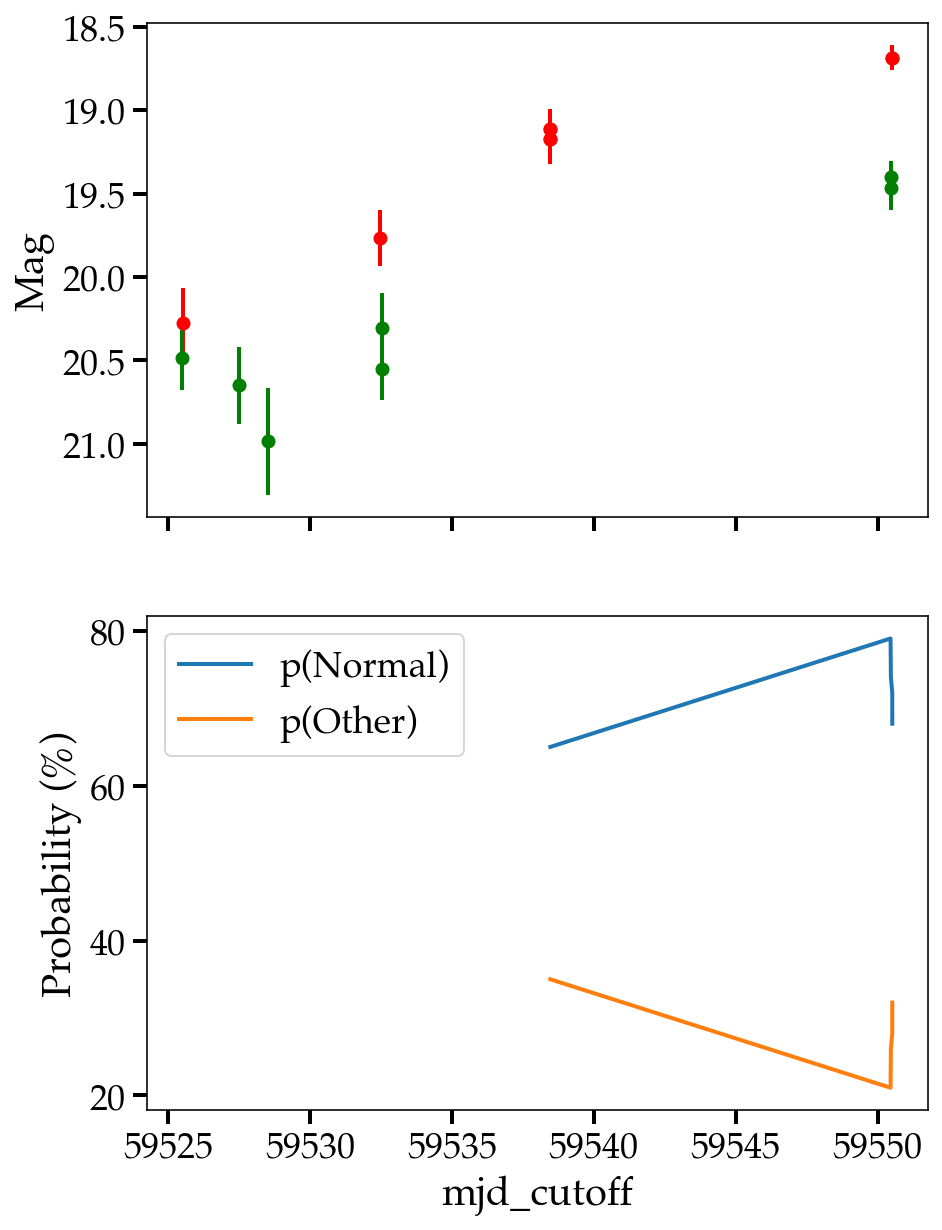

ZTF22aaaedas Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


1
https://alerce.online/object/ZTF22aaaedas Other


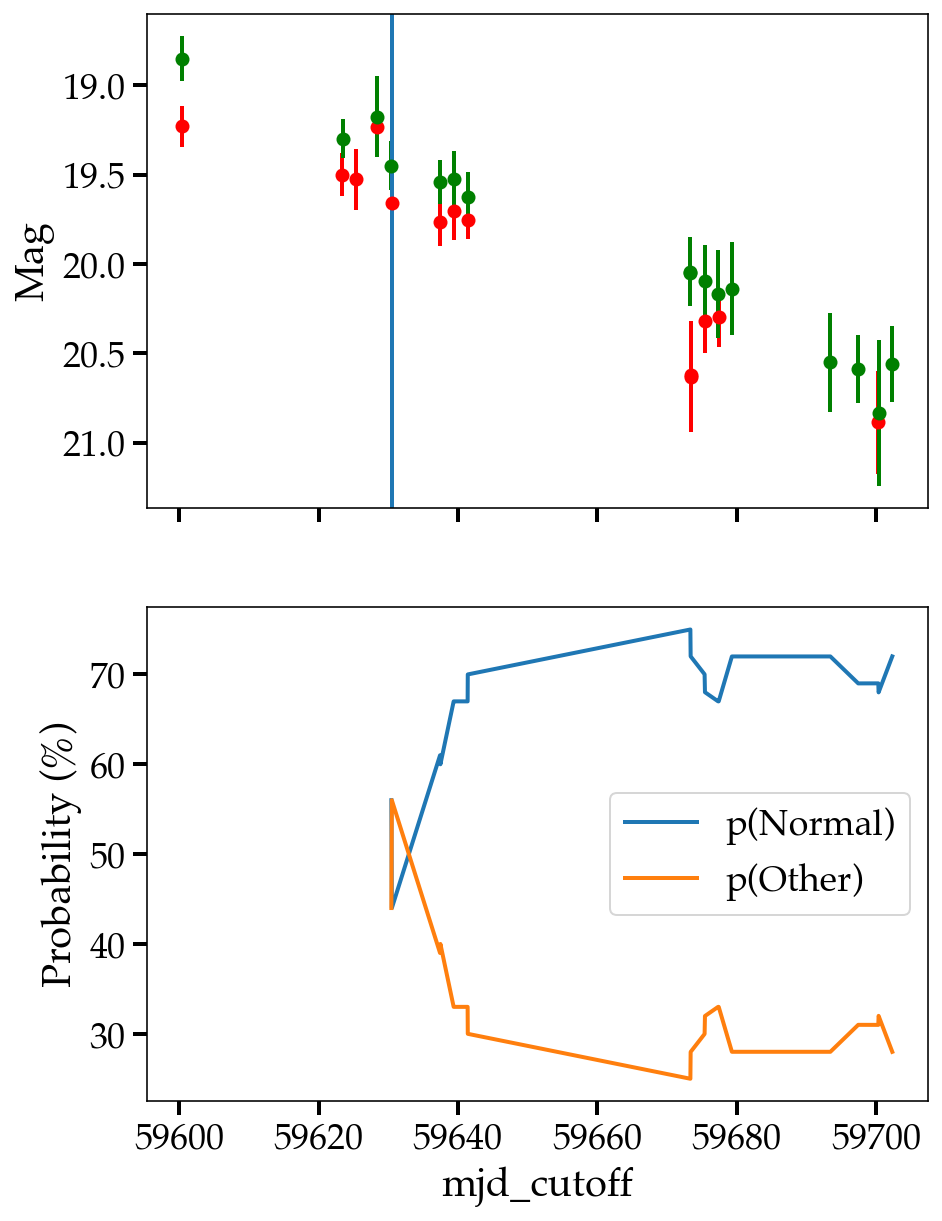

ZTF20aclnplo Other
Prediction doesn't exceed anom_threshold of 50% for ZTF20aclnplo.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF20aclnplo Other


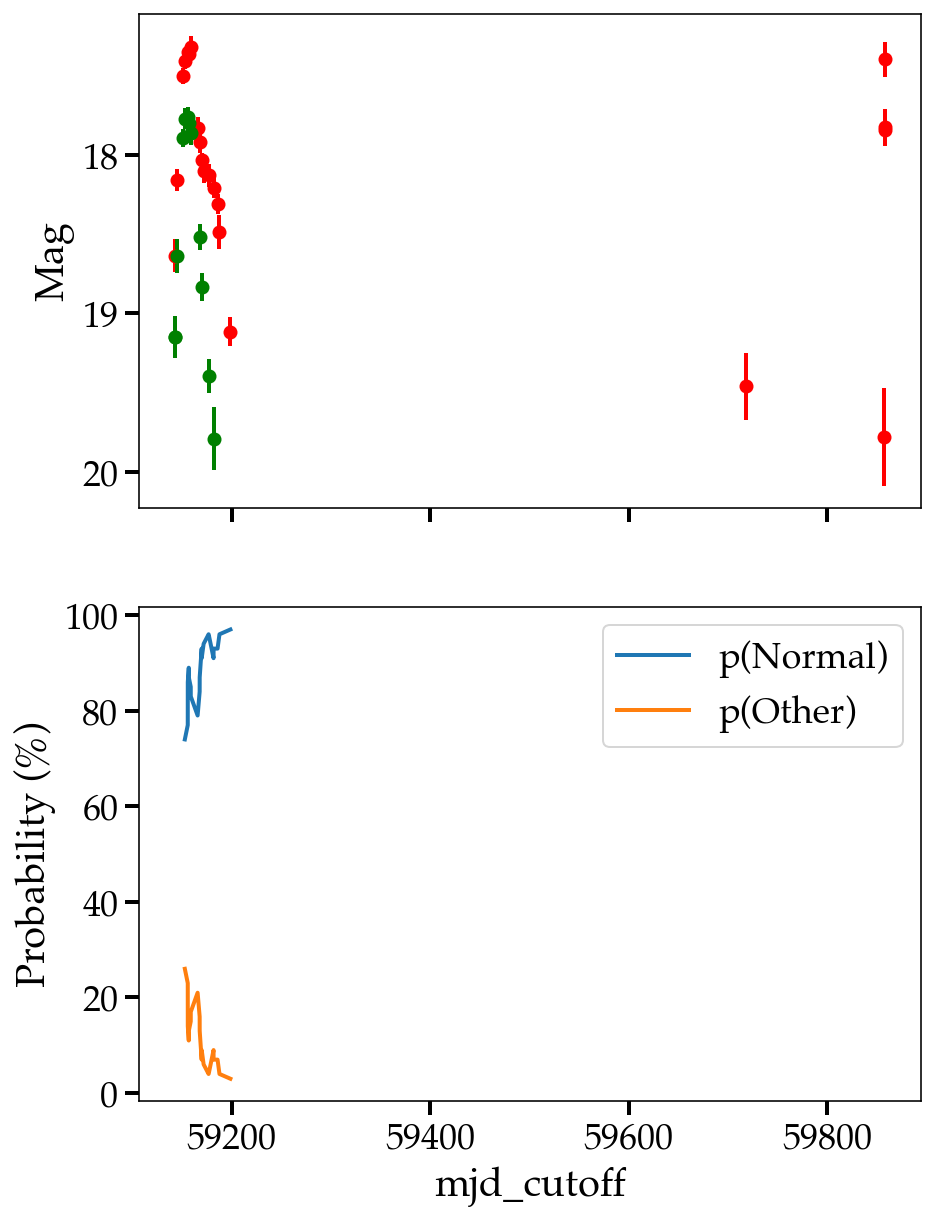

ZTF21abtdvpg Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


52
https://alerce.online/object/ZTF21abtdvpg Other


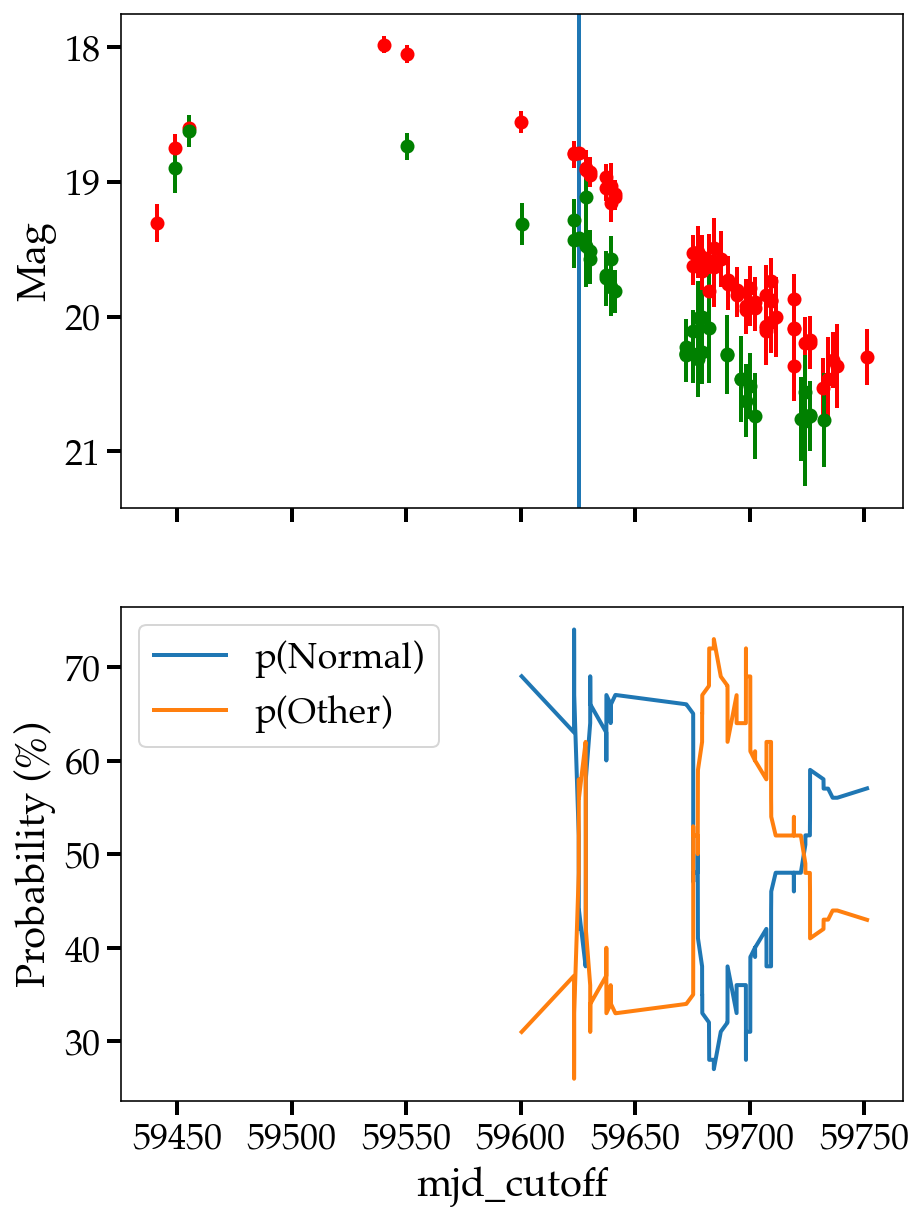

ZTF20acgiglu Other
Prediction doesn't exceed anom_threshold of 50% for ZTF20acgiglu.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF20acgiglu Other


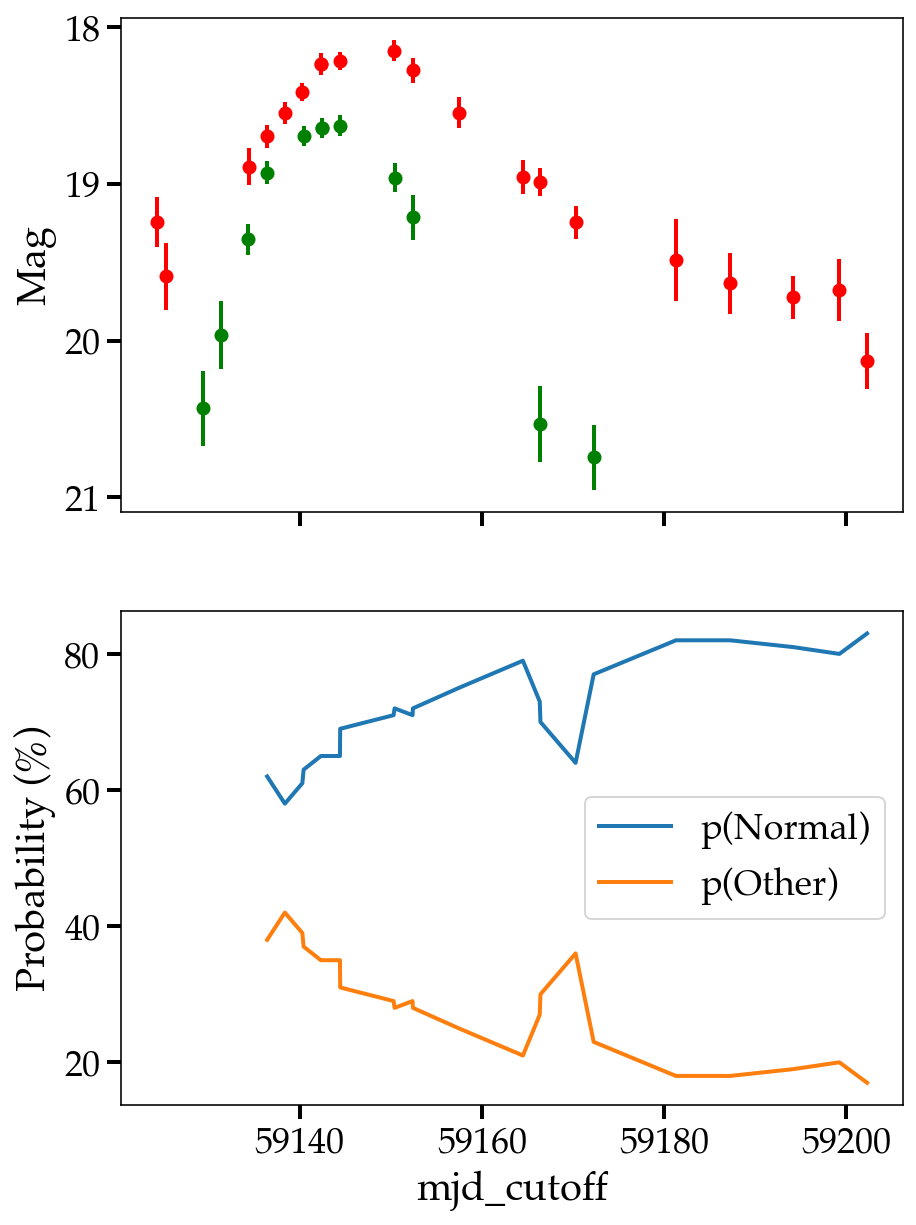

ZTF20aczgmai Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


4
https://alerce.online/object/ZTF20aczgmai Other


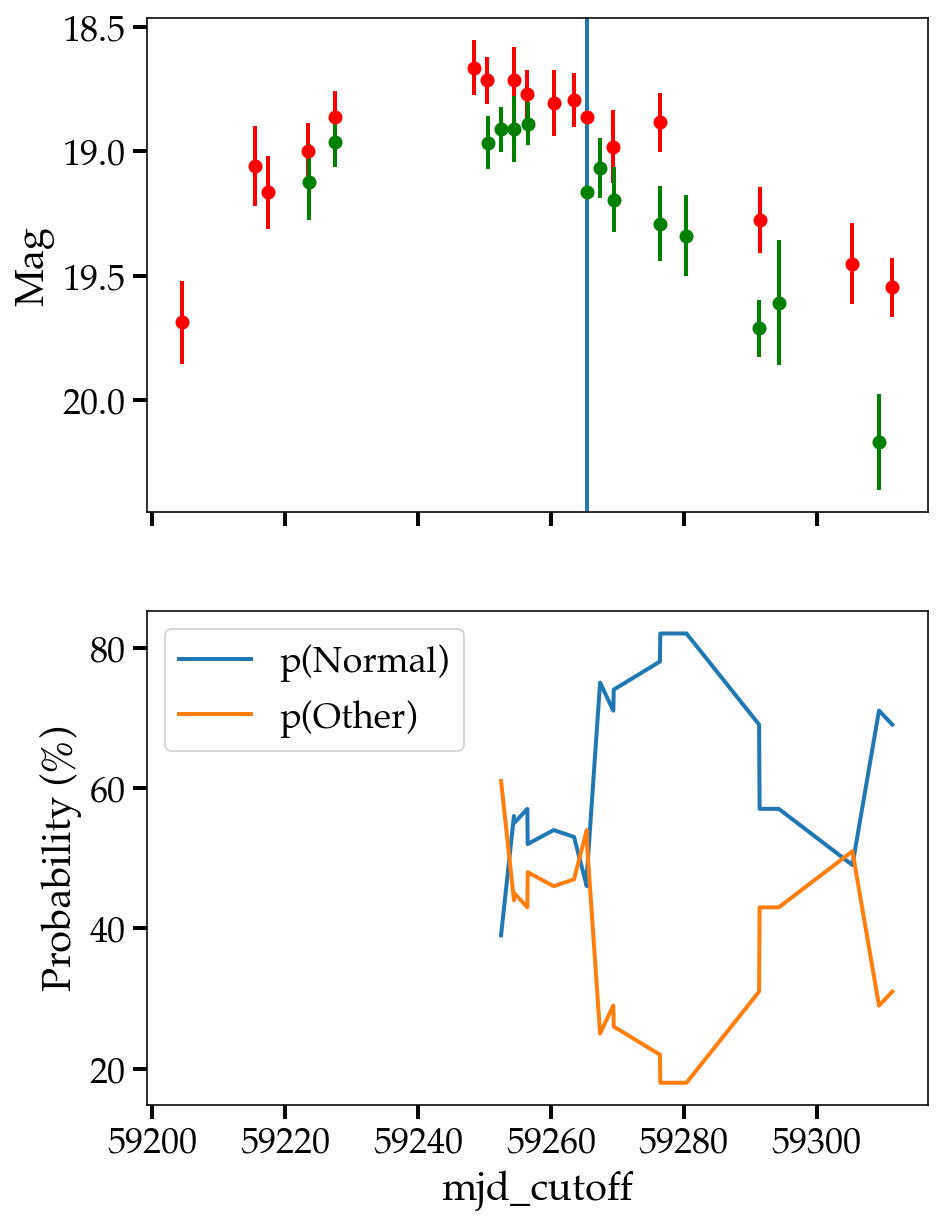

ZTF21aaxtctv Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21aaxtctv.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21aaxtctv Other


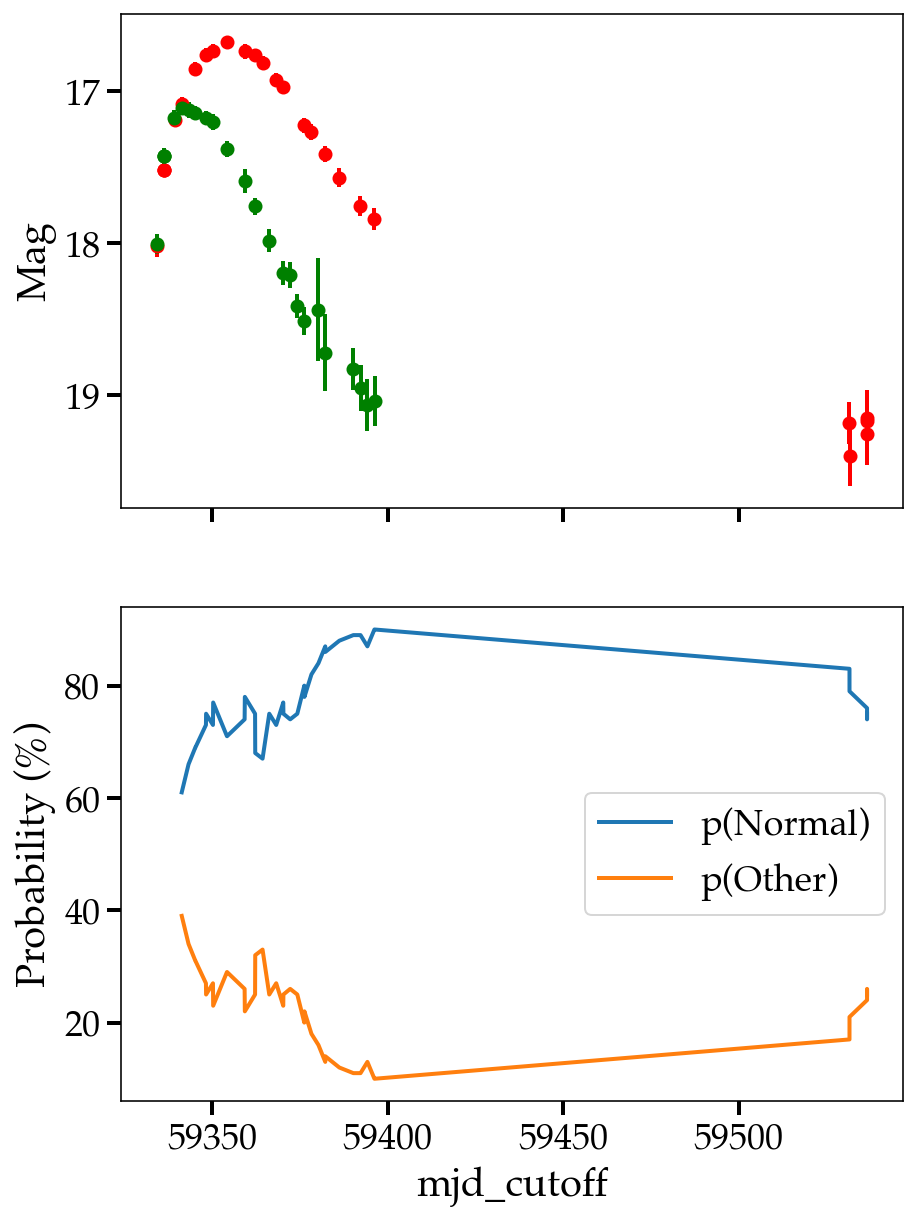

ZTF21aaxxihx Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21aaxxihx.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21aaxxihx Other


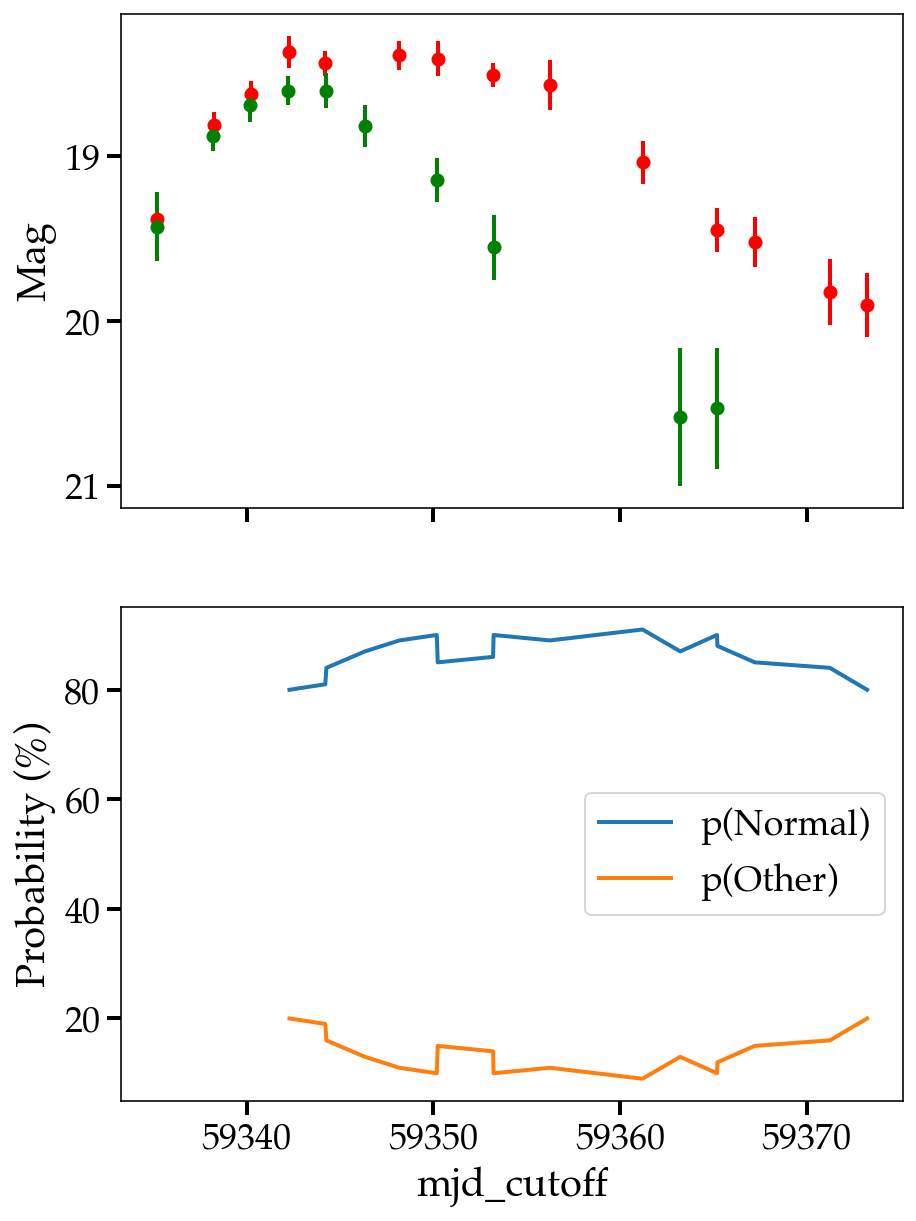

ZTF21aarasky Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21aarasky.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


0
https://alerce.online/object/ZTF21aarasky Other


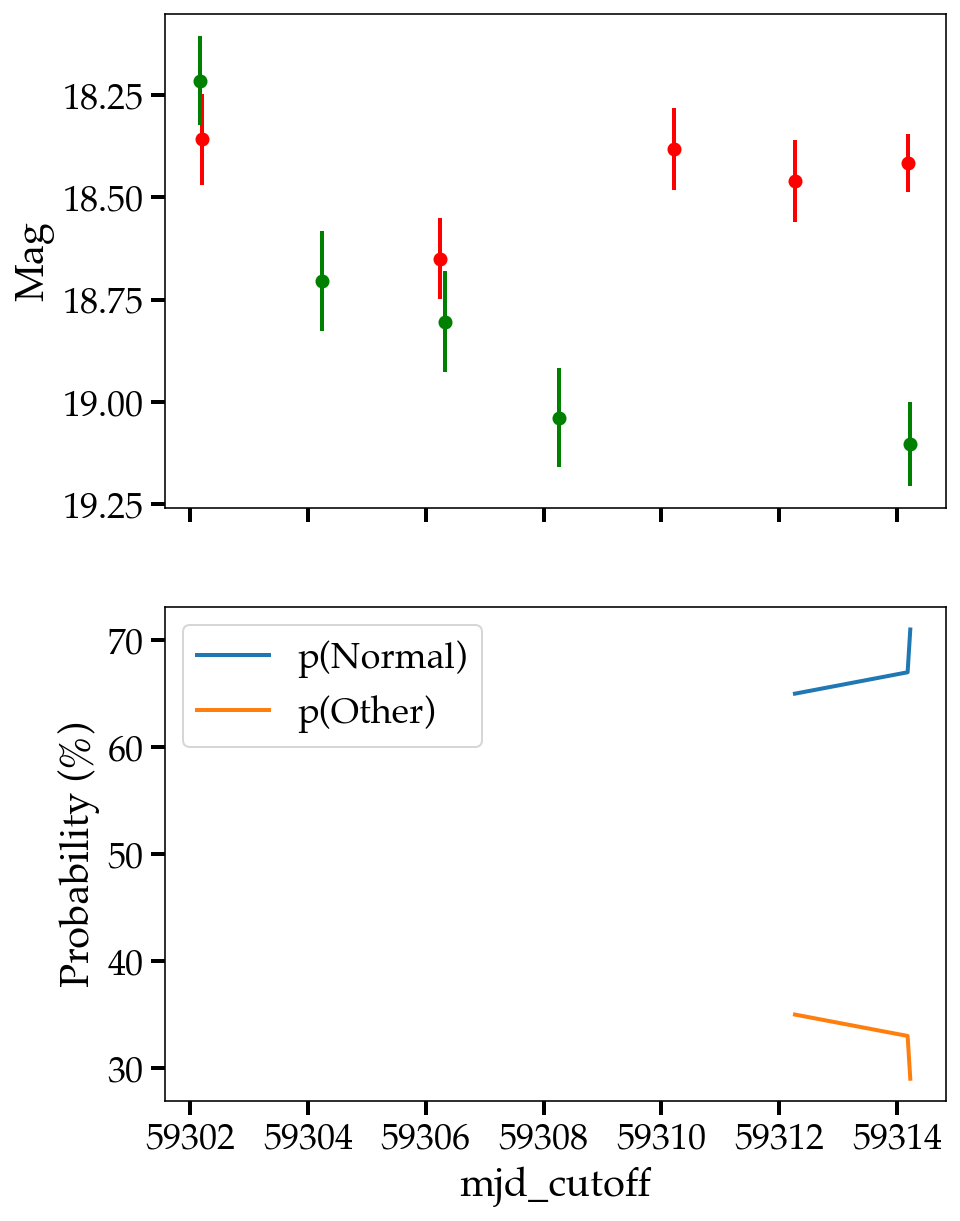

ZTF20adadrhw Other
Prediction doesn't exceed anom_threshold of 50% for ZTF20adadrhw.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF20adadrhw Other


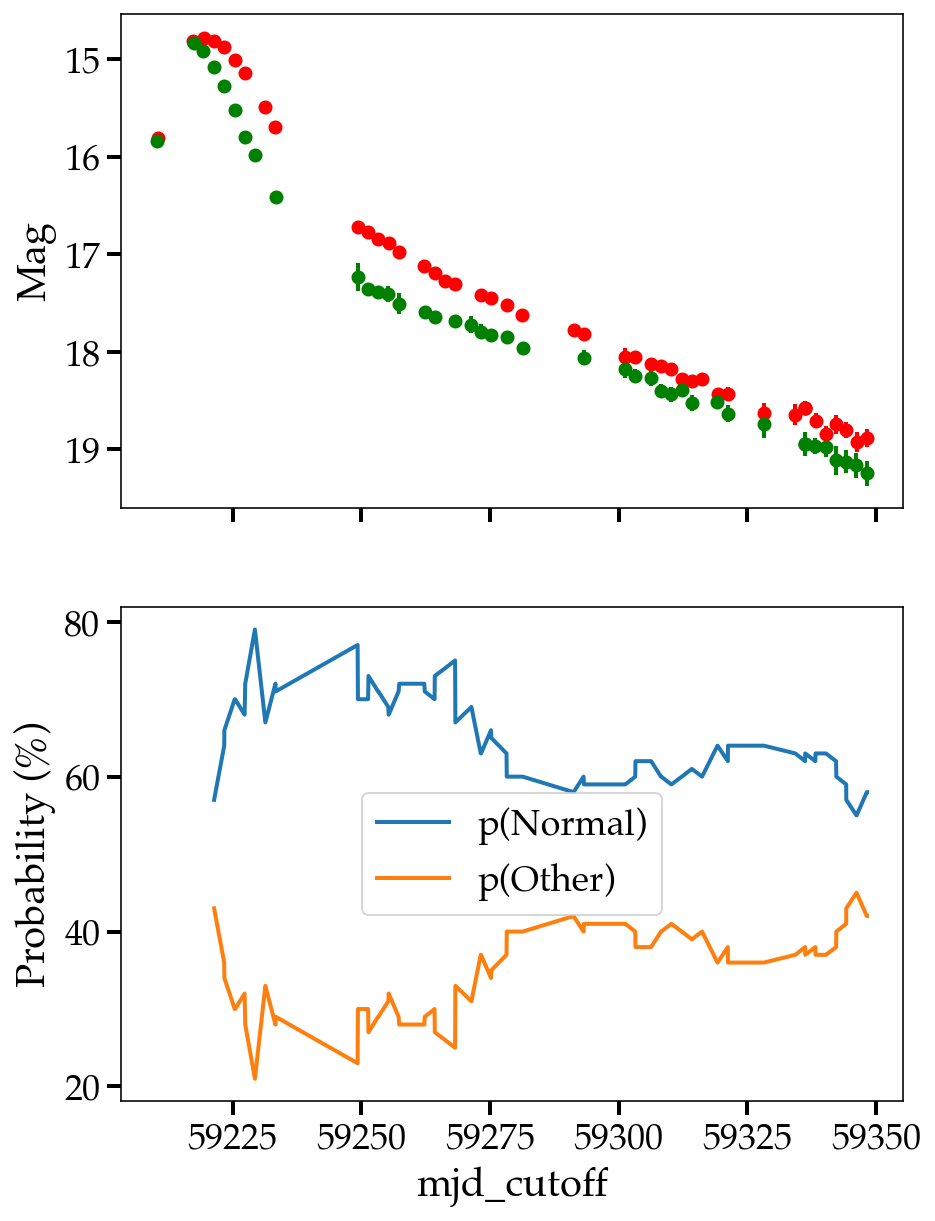

ZTF21aadatfg Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21aadatfg.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21aadatfg Other


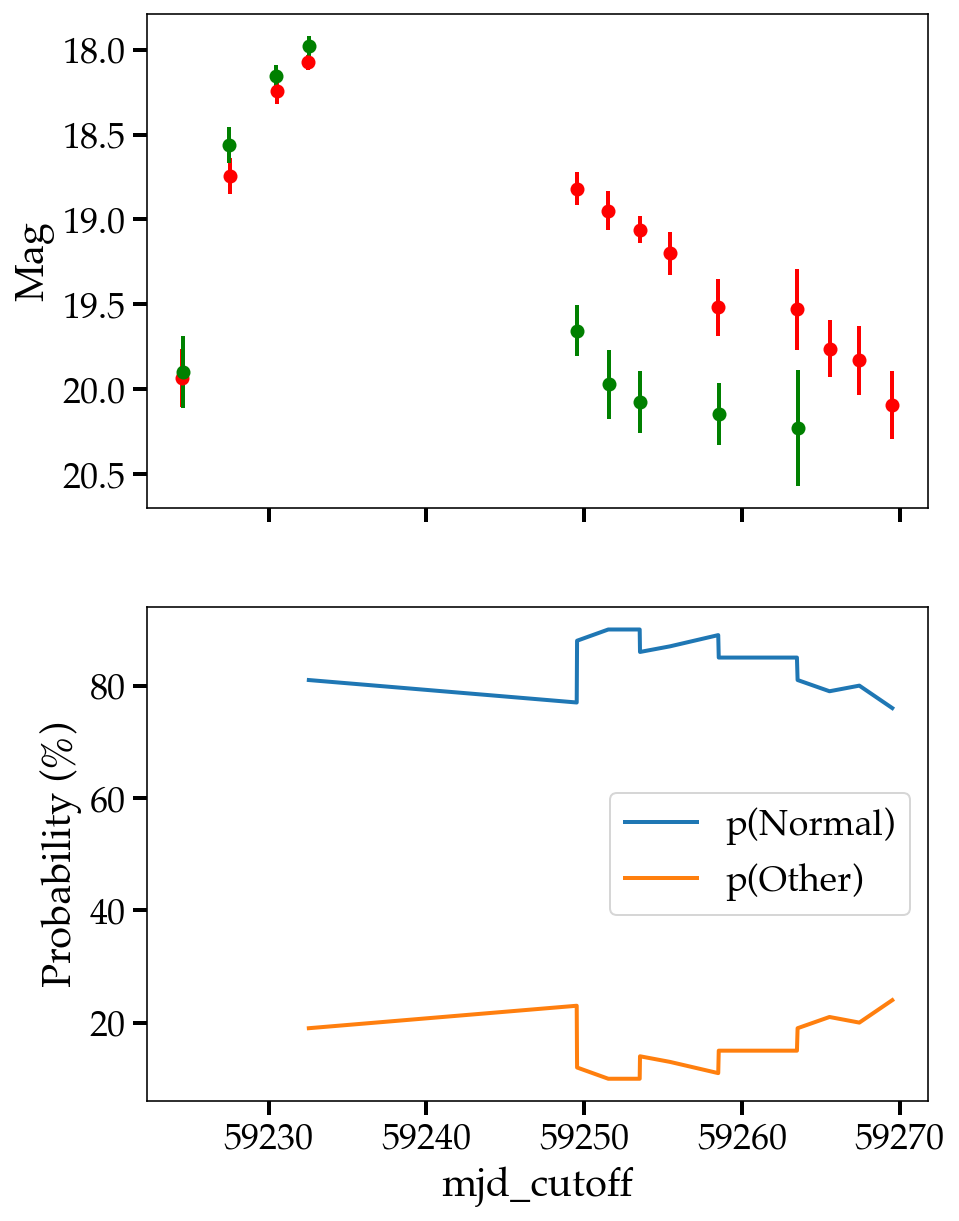

ZTF21aaoqbbw Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


2
https://alerce.online/object/ZTF21aaoqbbw Other


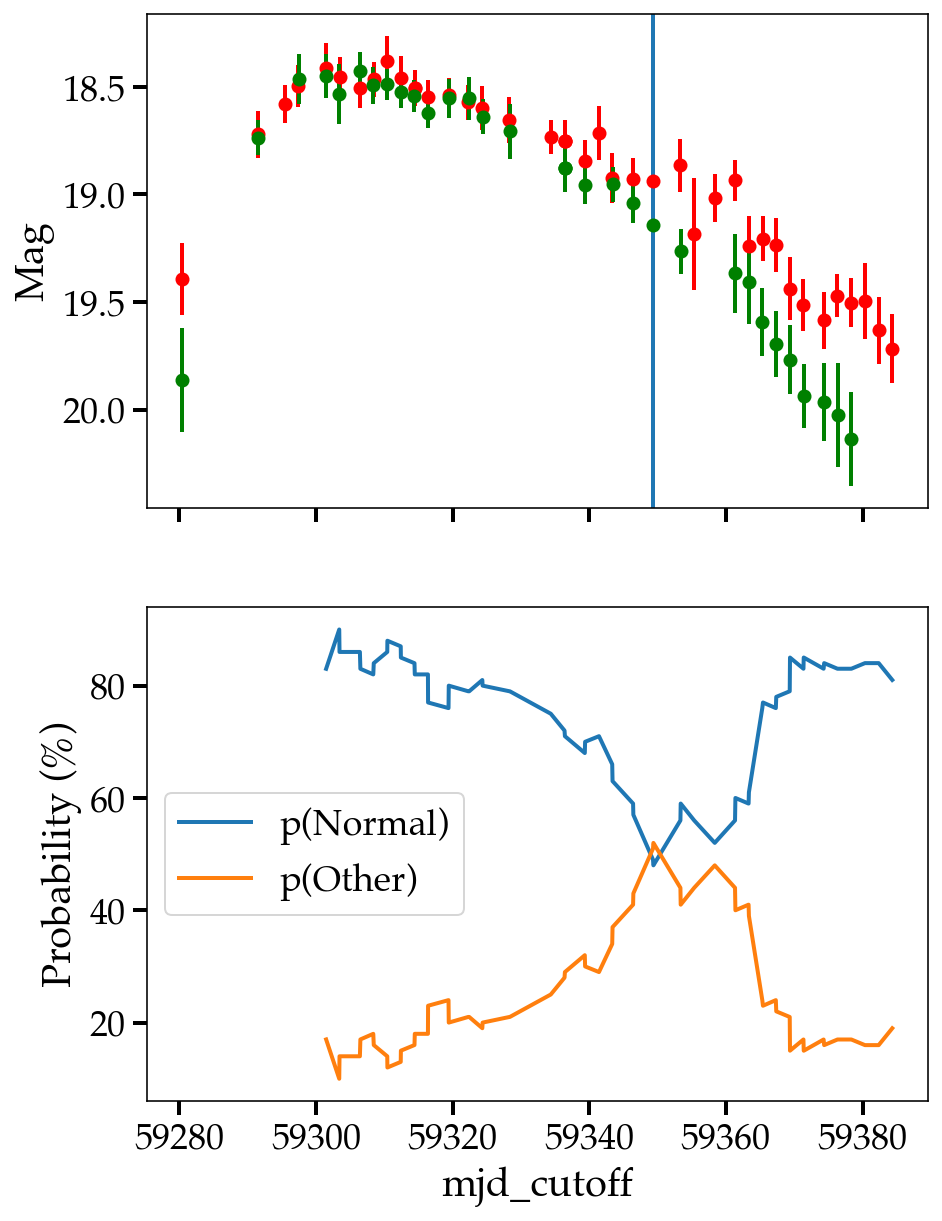

ZTF20aceokvr Other
Prediction doesn't exceed anom_threshold of 50% for ZTF20aceokvr.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF20aceokvr Other


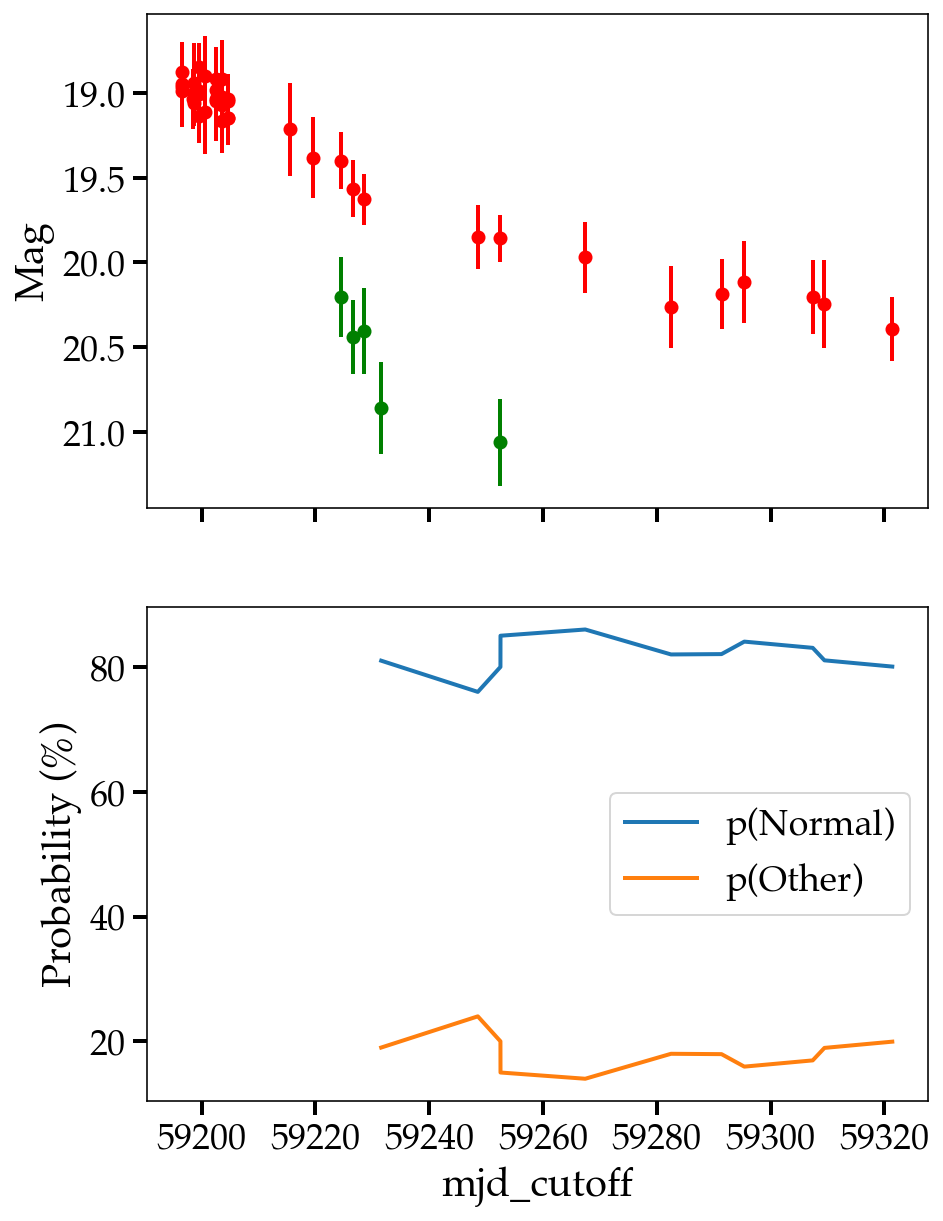

ZTF20acwofhd Other
Prediction doesn't exceed anom_threshold of 50% for ZTF20acwofhd.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF20acwofhd Other


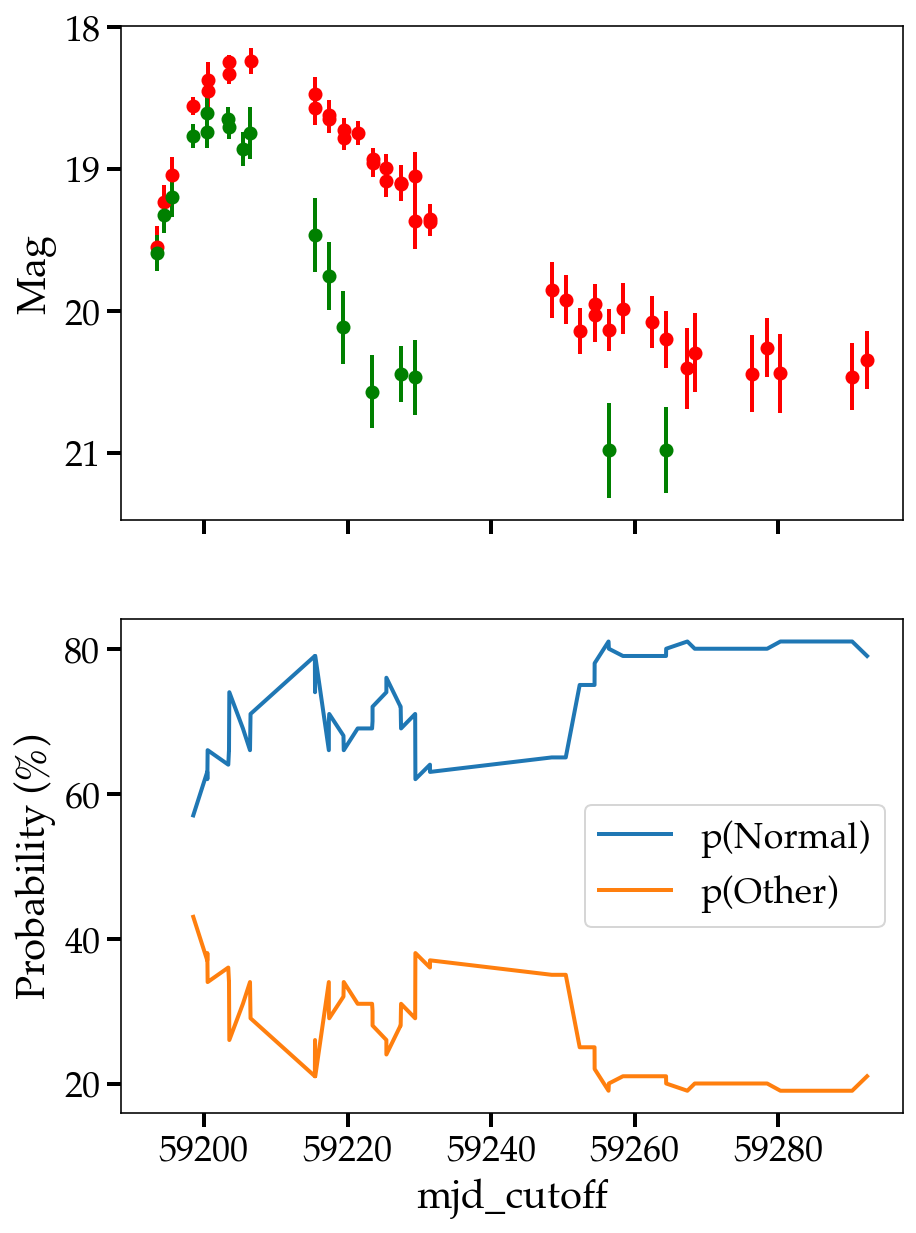

ZTF21aayonfd Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21aayonfd.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21aayonfd Other


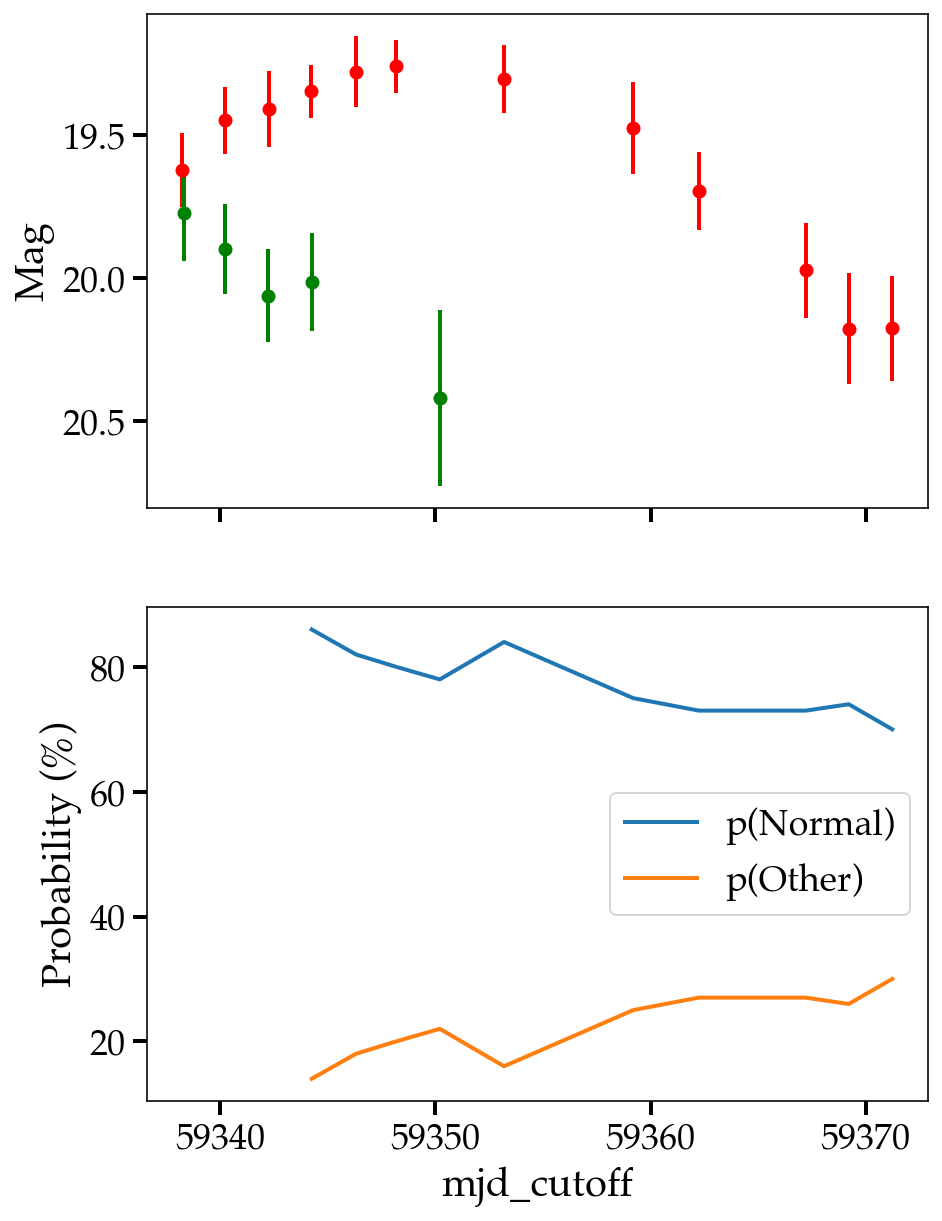

ZTF20acounxo Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


1
https://alerce.online/object/ZTF20acounxo Other


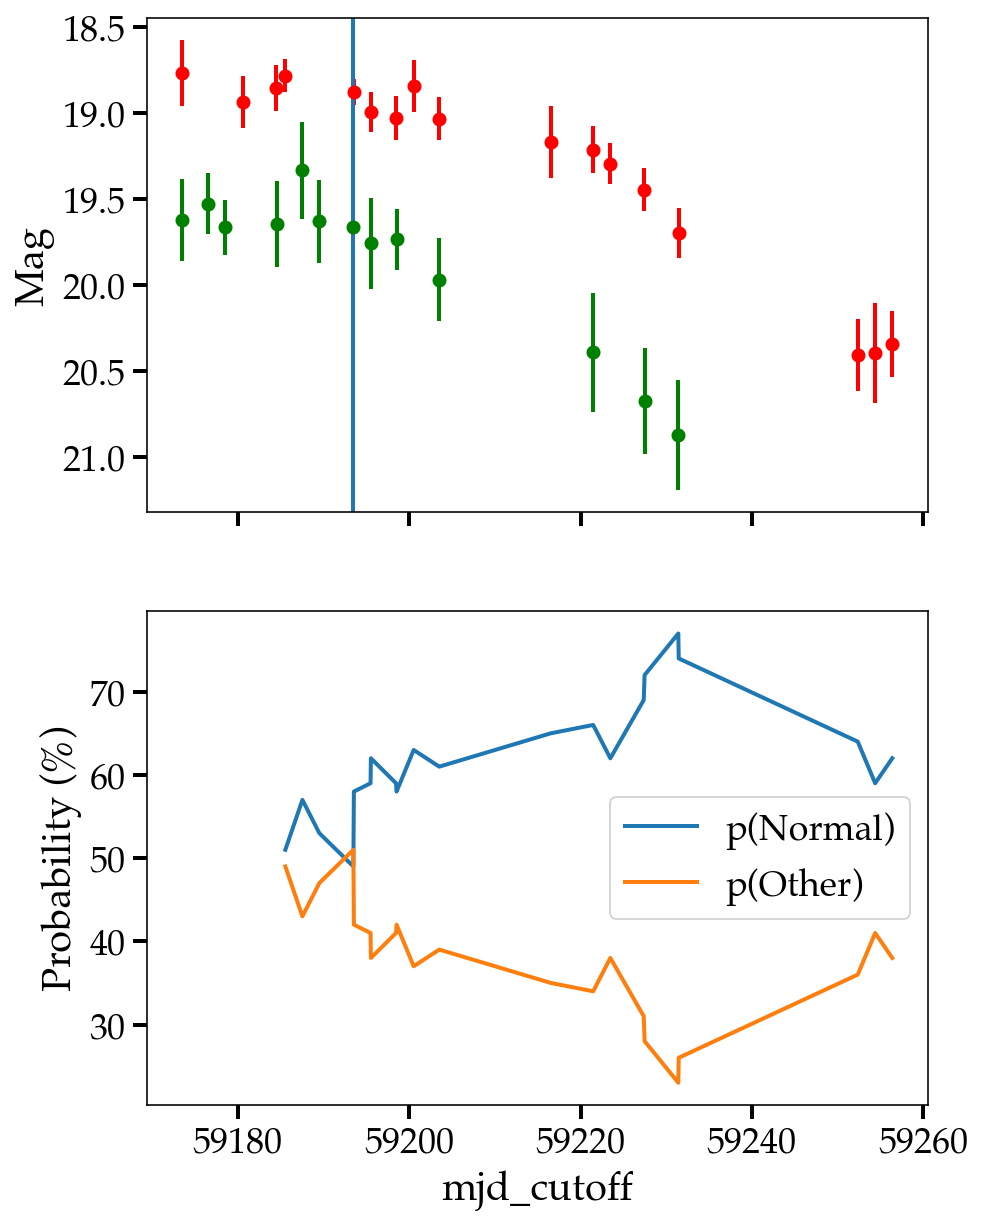

ZTF21aaradzm Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21aaradzm.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21aaradzm Other


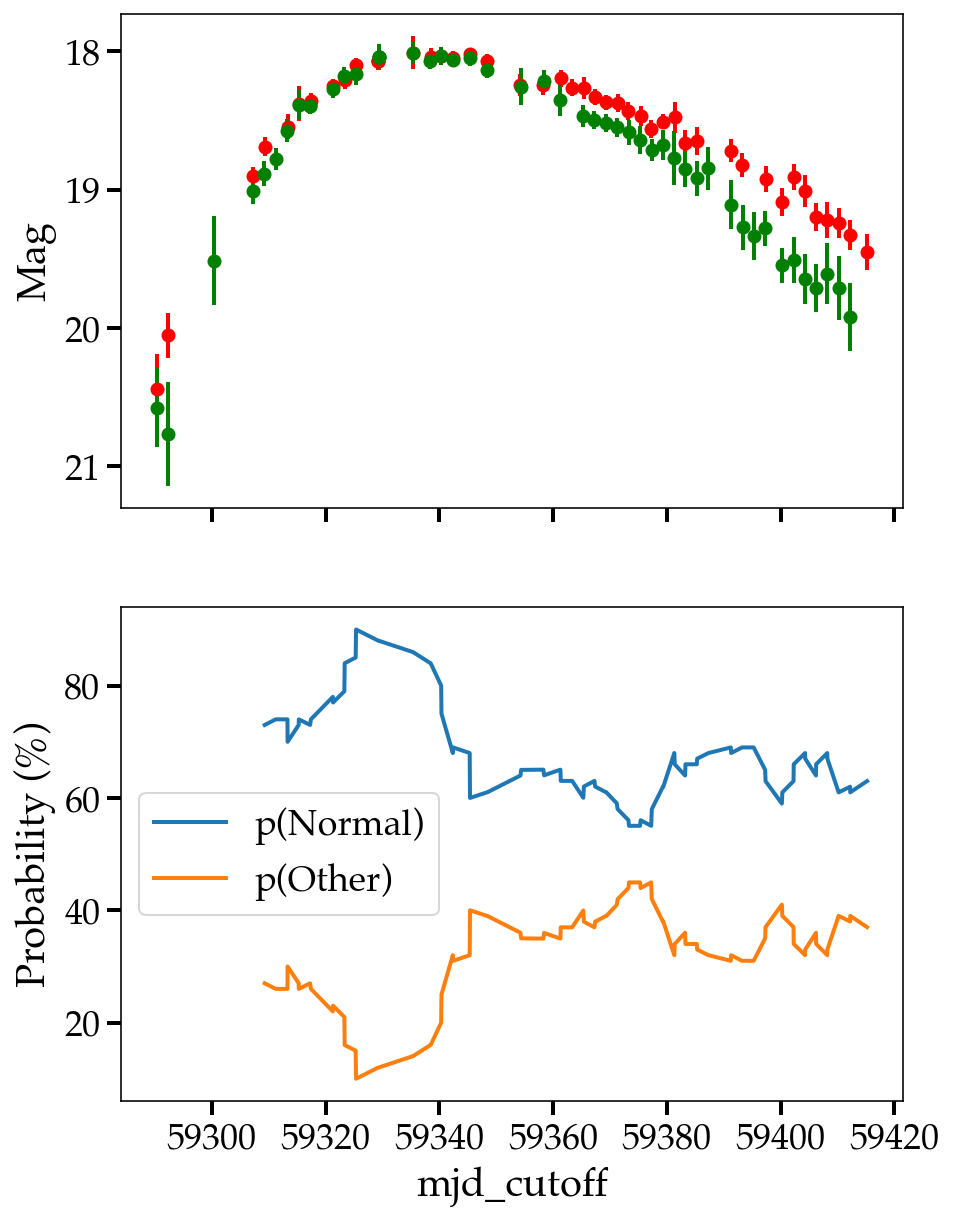

ZTF21aaxvcmj Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21aaxvcmj.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21aaxvcmj Other


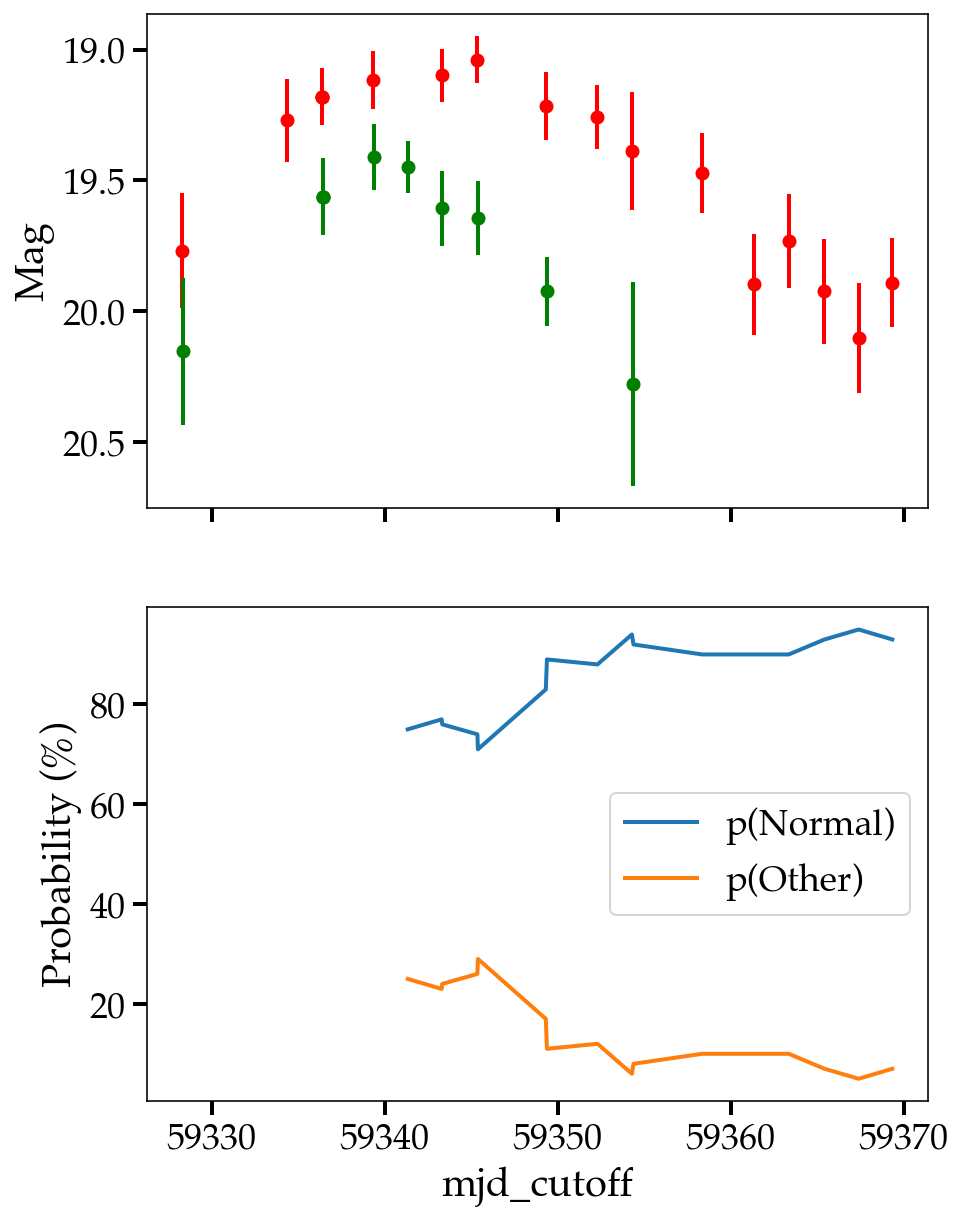

ZTF21acqvuyb Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21acqvuyb.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21acqvuyb Other


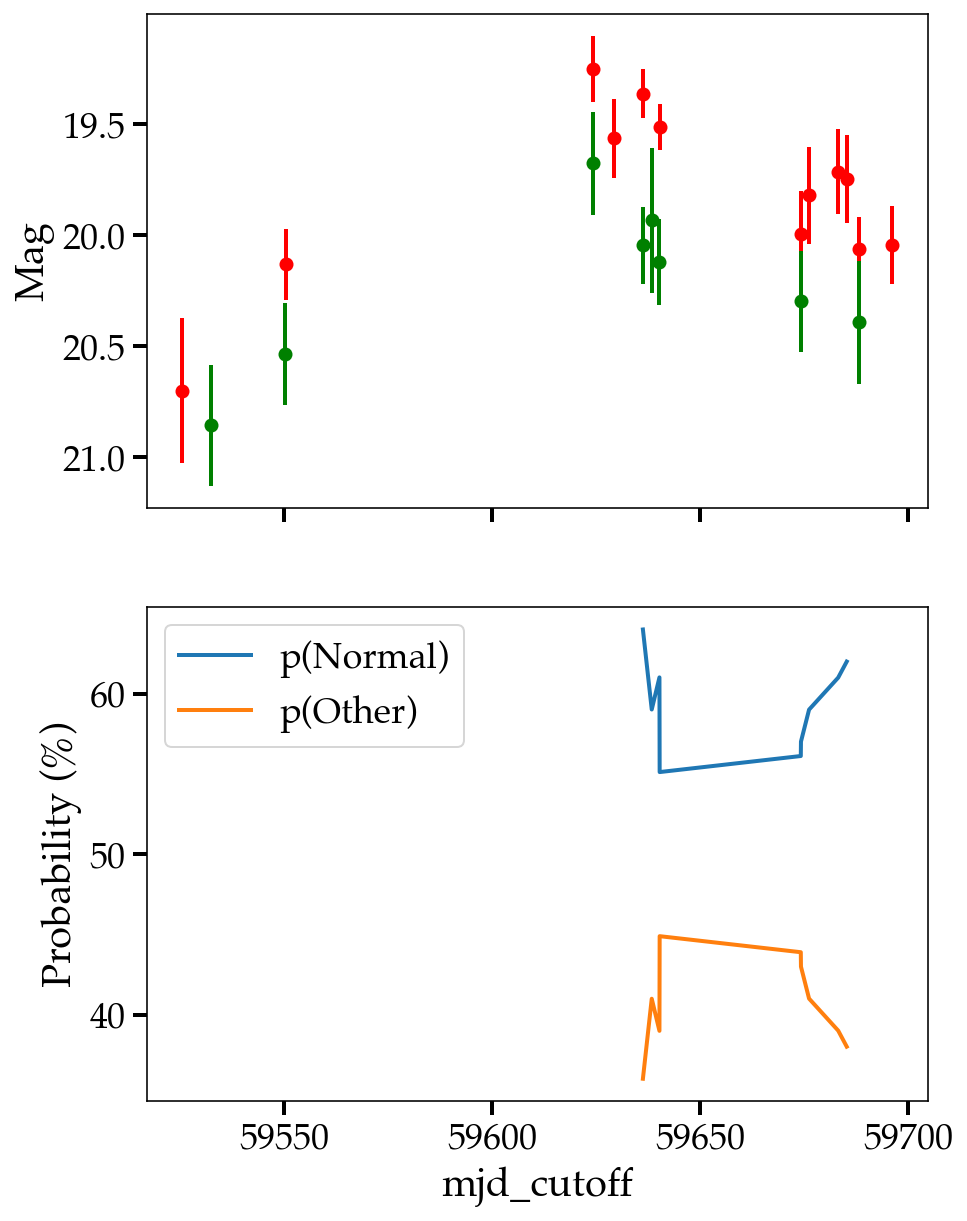

ZTF21aahfjrr Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21aahfjrr.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21aahfjrr Other


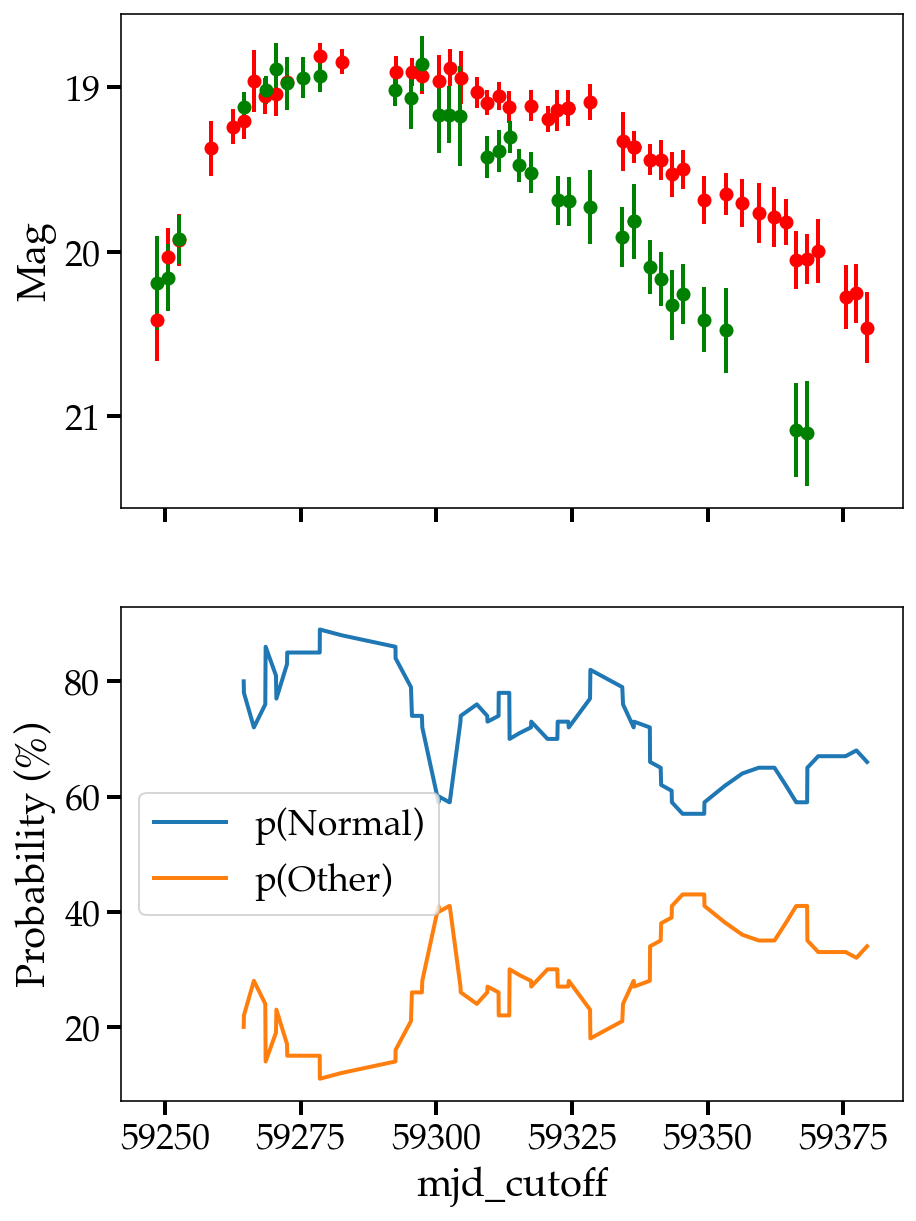

ZTF21acjmvhx Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21acjmvhx.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21acjmvhx Other


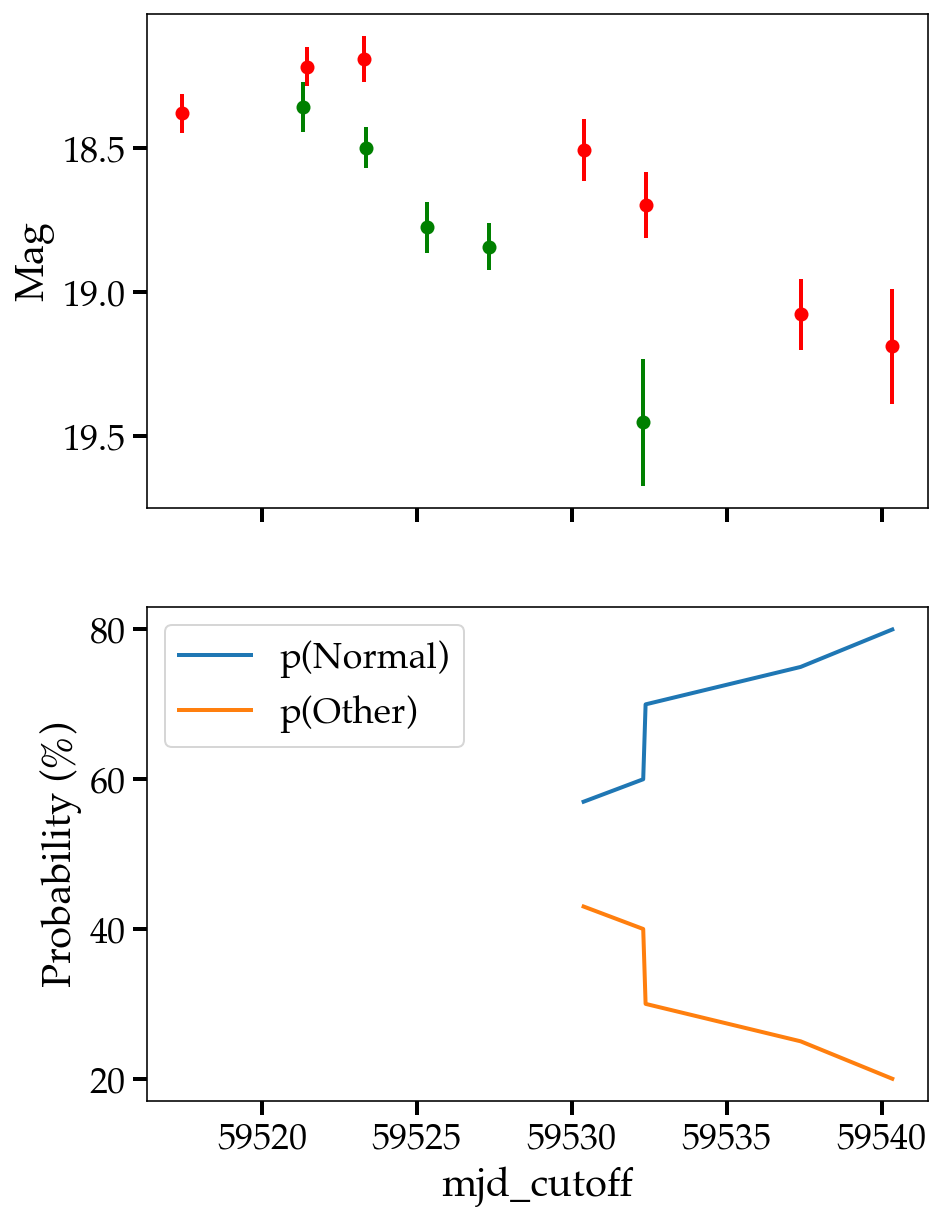

In [35]:
plot_RFC_prob_vs_lc(dataframe=df2_other_inc, anom_thresh=50)

Missed `anomalies` (labeled as Normal). But flag which ones are anomalous via timeseries/ func of time!
https://alerce.online/object/ZTF21acqyqwu SN Ib - NOT. 2021aghp; z=0.042. SN happened Dec 2021 (ATLAS) but first public ZTF obs are Feb 2022 (well on decline). So LC doesn't look Ib like at all. Understandable.
https://alerce.online/object/ZTF21abchjer SN Ic-BL - ANOM. 2021nc; z=0.02461. 2 anomalous epochs at beginning of features calc. 18.7mag.
https://alerce.online/object/ZTF20abtjjhb SN IIn - NOT. 2020rno; z=0.064. But few epochs SUPER CLOSE to 50% anom thresh. Would be anom with slightly lower threshold. Faint host gal.
https://alerce.online/object/ZTF21aaffxdt SN IIn - NOT. 2021bmv; z= 0.09. Only slight LC rise and at peak. No decline. Faint host gal. Kinda understandable.
https://alerce.online/object/ZTF20actekrw SN Ic - ANOM. 2020aauc; z=0.033. Anom at last epoch (19.5 mag). 
https://alerce.online/object/ZTF20acyydkh TDE - NOT. 2021ack; z=0.133. ? Always high normal classification...
https://alerce.online/object/ZTF20abvquuo SN Ib - NOT. 2020sai; z=0.03. ? Nice Ib... Small, faint elliptical. Always medium normal classification...
https://alerce.online/object/ZTF19abstsvm SN IIn - NOT. 2021yaz; z=0.039 ? Decent IIn... Always high normal classification...
https://alerce.online/object/ZTF20acueziy SN Ic - NOT. 2020abpa; z=0.023303 ? Nice Ic. Always high normal classification... Big spiral.
https://alerce.online/object/ZTF20acusecr SN IIb - NOT. 2020abkp; z=0.030884. ? decent IIb. Always high normal classification... M/MS elliptical.
https://alerce.online/object/ZTF21acmrdga SN IIb - NOT. 2021adud; z=0.034. Only LC rise. Understandable. no obvious second peak. Big elliptical. 
https://alerce.online/object/ZTF22aaaedas TDE - ANOM. 2022rz; z=0.107. 1 anomalous epochs at beginning of features calc, which is on LC decline (disc at decline); 19.5mag. 
https://alerce.online/object/ZTF20aclnplo SN Ic - NOT. 2020xpn; z=0.0347. ? Nice Ic. Always high normal classification... M/ML elliptical.
https://alerce.online/object/ZTF21abtdvpg SN IIn - ANOM. 2021waf; z=0.1265. Tagged after peak but earlier on in LC, at 19mag. Long lived after. 52 total anom epochs.
https://alerce.online/object/ZTF20acgiglu SN IIb - NOT. 2020urc; z=0.026728. ? Nice IIb. Always high normal. big spiral.
https://alerce.online/object/ZTF20aczgmai SN IIn - ANOM. 2020aeuv; z=0.042843. 2 anomalous epochs at beginning of features calc. 18.75mag, at peak.
https://alerce.online/object/ZTF21aaxtctv SN Ic - NOT. 2021krf; z=0.01356. ? Nice Ic. Always high normal classification...
https://alerce.online/object/ZTF21aaxxihx SN Ic-BL - NOT. 2021ktv; z=0.06. ? Nice Ic-BL. Always high normal classification...LSB host.
https://alerce.online/object/ZTF21aarasky SN IIb - NOT. 2021hlv; z=0.021698. Only 2 epochs of extracted feature data.
https://alerce.online/object/ZTF20adadrhw SN Ic - NOT. 2020adow; z=0.0075050001. ? Nice Ic. But can be found by mag cuts (15 mag)
https://alerce.online/object/ZTF21aadatfg SN Ic-BL - NOT. 2021xv; z=0.05. ? Nice Ic-BL. Always high normal classification...LSB host. Big gap after peak tho.
https://alerce.online/object/ZTF21aaoqbbw SN IIn - ANOM. 2021ezt; z=0.050162. 2 anom epochs. 19 mag, 20d after peak.
https://alerce.online/object/ZTF20aceokvr SN IIn - NOT. 2020uaq; z=0.115. Red, only decline of LC.
https://alerce.online/object/ZTF20acwofhd SN Ic - NOT. 2020acfp; z=0.032816. ? Nice Ic. Always high normal classification...spiral host
https://alerce.online/object/ZTF21aayonfd SN Ic - NOT. 2021lei; z=0.112 ? Nice Ic. Always high normal classification...LSB host
https://alerce.online/object/ZTF20acounxo SN IIn - ANOM. 2020aatv; z=0.019153. Early in feature extract, just after peak. 19mag.
https://alerce.online/object/ZTF21aaradzm SN IIn - NOT. 2021hur; z=0.03. ? Nice IIn.
https://alerce.online/object/ZTF21aaxvcmj SN Ib - NOT. 2021ksr; z=0.053. ? Nice Ib. Always high normal classification...
https://alerce.online/object/ZTF21acqvuyb SLSN-II - NOT. 2022akb; z=0.229. ? Kinda gappy but normal SLSN. LSB host.
https://alerce.online/object/ZTF21aahfjrr SN IIn - NOT. 2021bwf; z=0.194. ? Nice IIn.
https://alerce.online/object/ZTF21acjmvhx SN Ic-BL - NOT. 2021acpm; z=0.042. ? Nice Ic-BL. Always high normal classification. No real rise tho.

31 "other" objects by TNS label missed by RFC for full LC.
__________
7 tagged anomalous via timeseries (0 for full LC). 
* 4 SN IIn, 
* 1 TDE, 
* 1 Ic,
* 1 Ic-BL.

24 still missed by timeseries
* 1 SLSN-II,
* 6 SN IIn, 
* 4 SN IIb, 
* 1 TDE, 
* 3 Ib,
* 6 Ic,
* 3 Ic-BL.

In [36]:
df2_other_inc.loc['ZTF20aczgmai'] # new 2023 obs after adam's feature tar. 

feature_amplitude_magn_r                   0.511466
feature_anderson_darling_normal_magn_r     0.864766
feature_beyond_1_std_magn_r                0.235294
feature_beyond_2_std_magn_r                0.058824
feature_cusum_magn_r                       0.398861
                                            ...    
s2                                        -1.963357
s3                                         3.036371
Normal                                    69.018971
Other                                     30.981029
RFC_best_cls                                 Normal
Name: ZTF20aczgmai, Length: 130, dtype: object

In [37]:
df2_other_inc.loc['ZTF21acqyqwu'] # new 2023 obs after adam's feature tar. 

feature_amplitude_magn_r                  0.164925
feature_anderson_darling_normal_magn_r    0.191106
feature_beyond_1_std_magn_r               0.222222
feature_beyond_2_std_magn_r                    0.0
feature_cusum_magn_r                      0.351634
                                            ...   
s2                                        1.834771
s3                                        1.366241
Normal                                        81.0
Other                                         19.0
RFC_best_cls                                Normal
Name: ZTF21acqyqwu, Length: 130, dtype: object

In [38]:
df2_other_inc.loc['ZTF20actekrw'] # one epoch behind the timeseries extracted one. Should be "anom"

feature_amplitude_magn_r                   0.48984
feature_anderson_darling_normal_magn_r    1.396014
feature_beyond_1_std_magn_r               0.166667
feature_beyond_2_std_magn_r               0.083333
feature_cusum_magn_r                      0.382213
                                            ...   
s2                                       -1.007435
s3                                         2.45737
Normal                                        61.0
Other                                         39.0
RFC_best_cls                                Normal
Name: ZTF20actekrw, Length: 130, dtype: object

In [39]:
print("Correctly flagged `anomalies' (labeled as Other)")
for ob in df2_other_cor.index:
    print(f'https://alerce.online/object/{ob}', x_test_all.loc[ob].tns_cls)

Correctly flagged `anomalies' (labeled as Other)
https://alerce.online/object/ZTF20abwxywy SN Ic
https://alerce.online/object/ZTF21aafmkjk SN IIn
https://alerce.online/object/ZTF21aaabwfu SN IIb
https://alerce.online/object/ZTF21aautijg SN IIn
https://alerce.online/object/ZTF20acxqxyw SN Ib
https://alerce.online/object/ZTF21abcgnqn TDE
https://alerce.online/object/ZTF18acvgjqv SN IIn
https://alerce.online/object/ZTF21abaxaqq TDE
https://alerce.online/object/ZTF18acaqdaa TDE
https://alerce.online/object/ZTF21aaaokyp TDE
https://alerce.online/object/ZTF21aapvvtb TDE
https://alerce.online/object/ZTF20acnznms SLSN-II
https://alerce.online/object/ZTF19aaadwfi SLSN-II
https://alerce.online/object/ZTF20acwytxn TDE


ZTF20abwxywy Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


18
https://alerce.online/object/ZTF20abwxywy Other


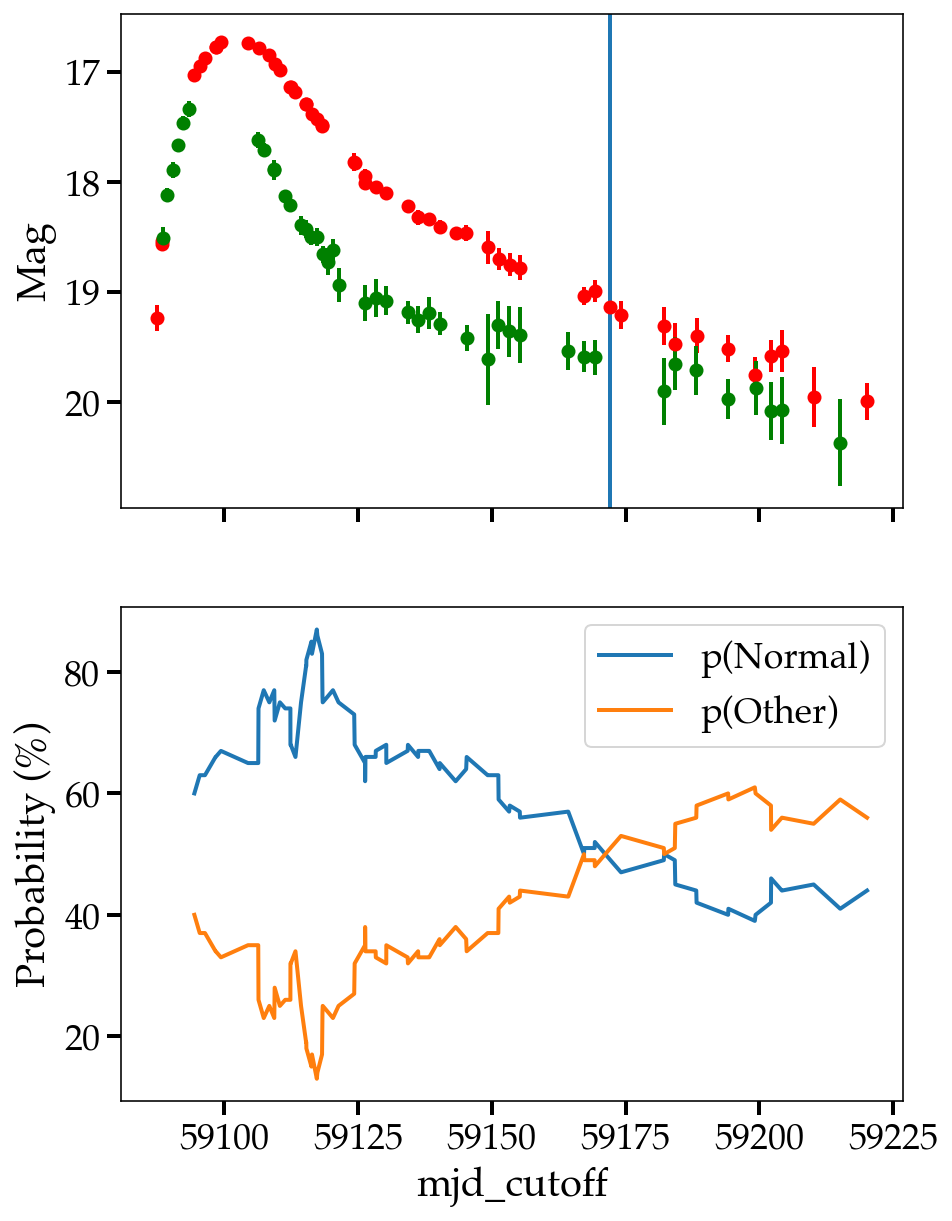

ZTF21aafmkjk Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


21
https://alerce.online/object/ZTF21aafmkjk Other


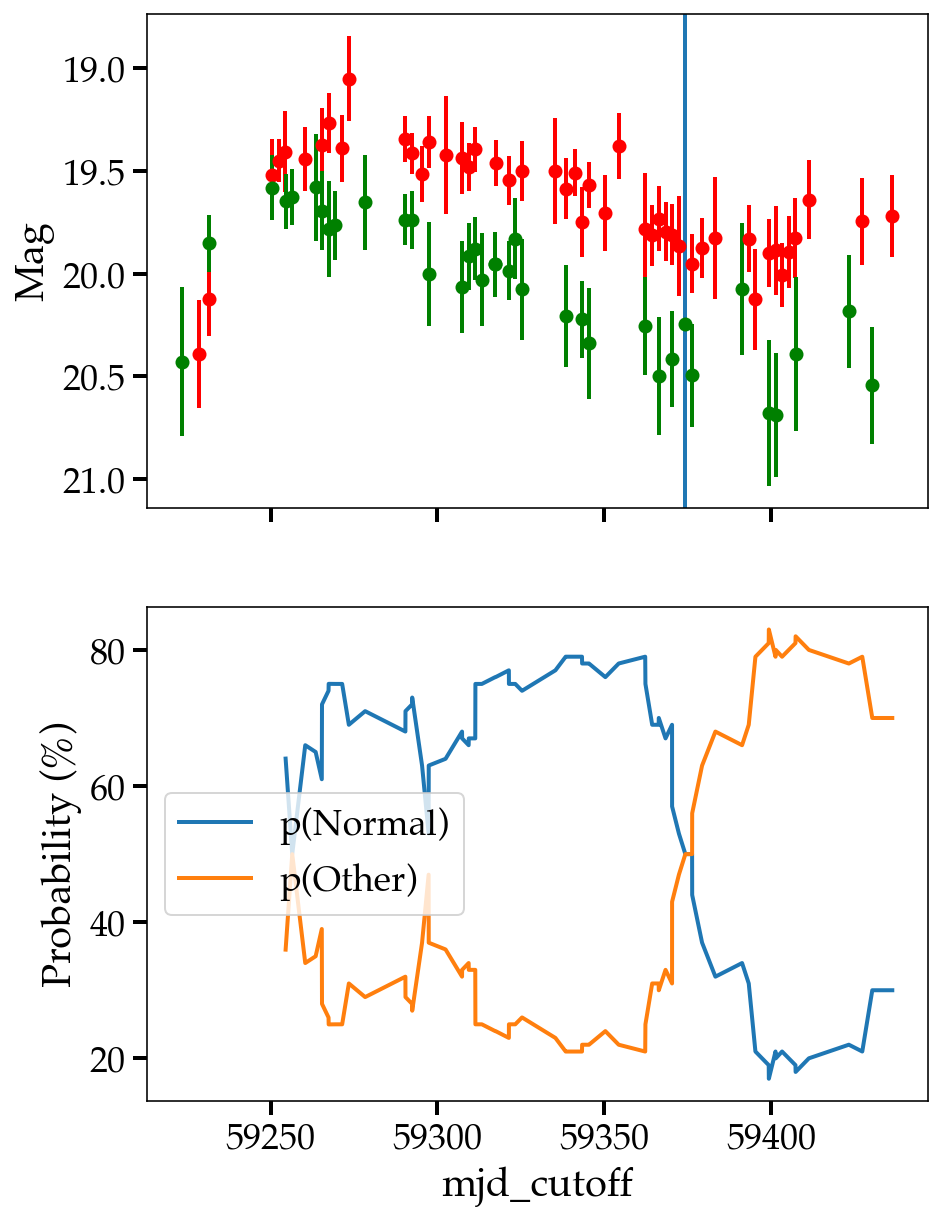

ZTF21aaabwfu Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF21aaabwfu.
5
https://alerce.online/object/ZTF21aaabwfu Other


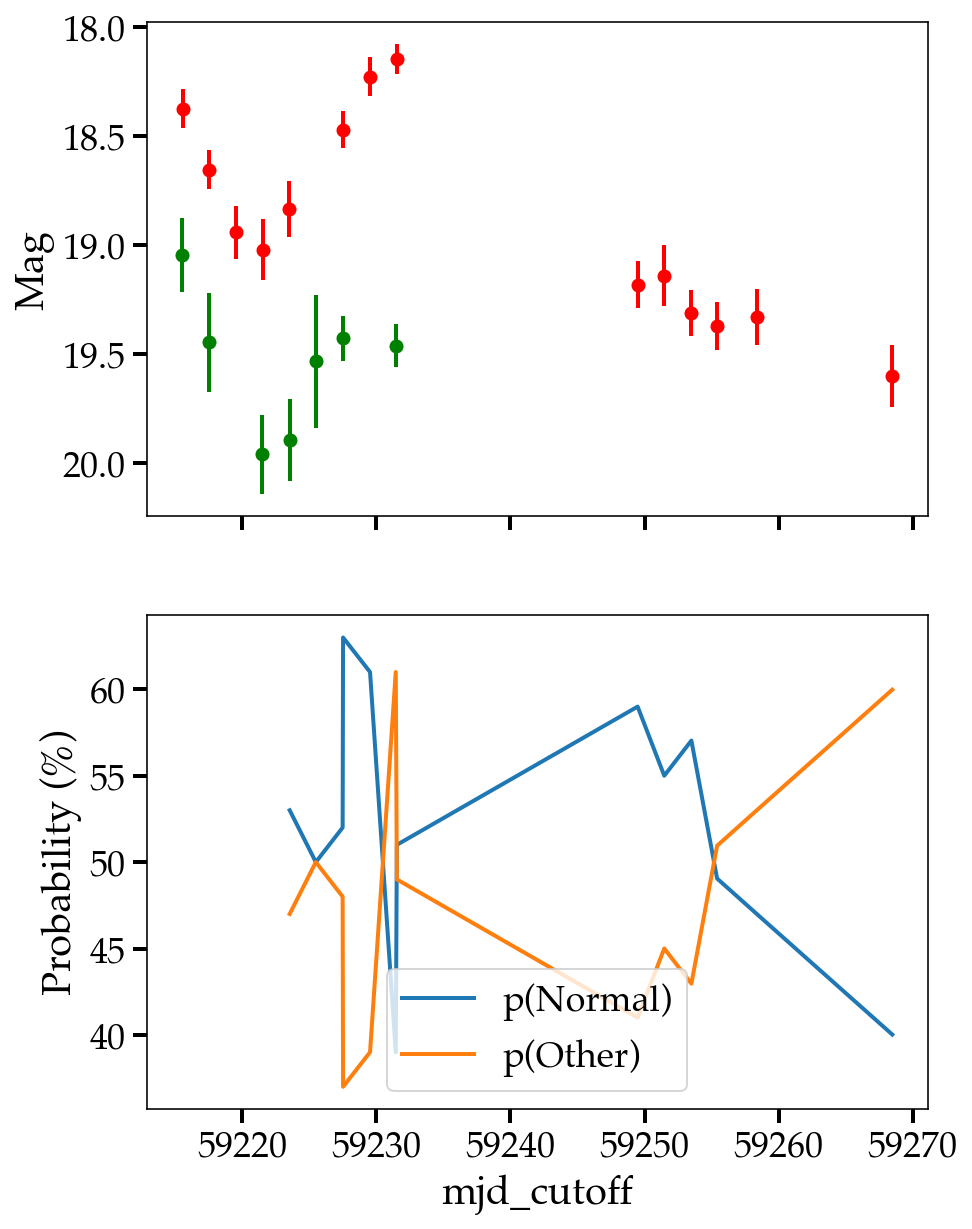

ZTF21aautijg Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


7
https://alerce.online/object/ZTF21aautijg Other


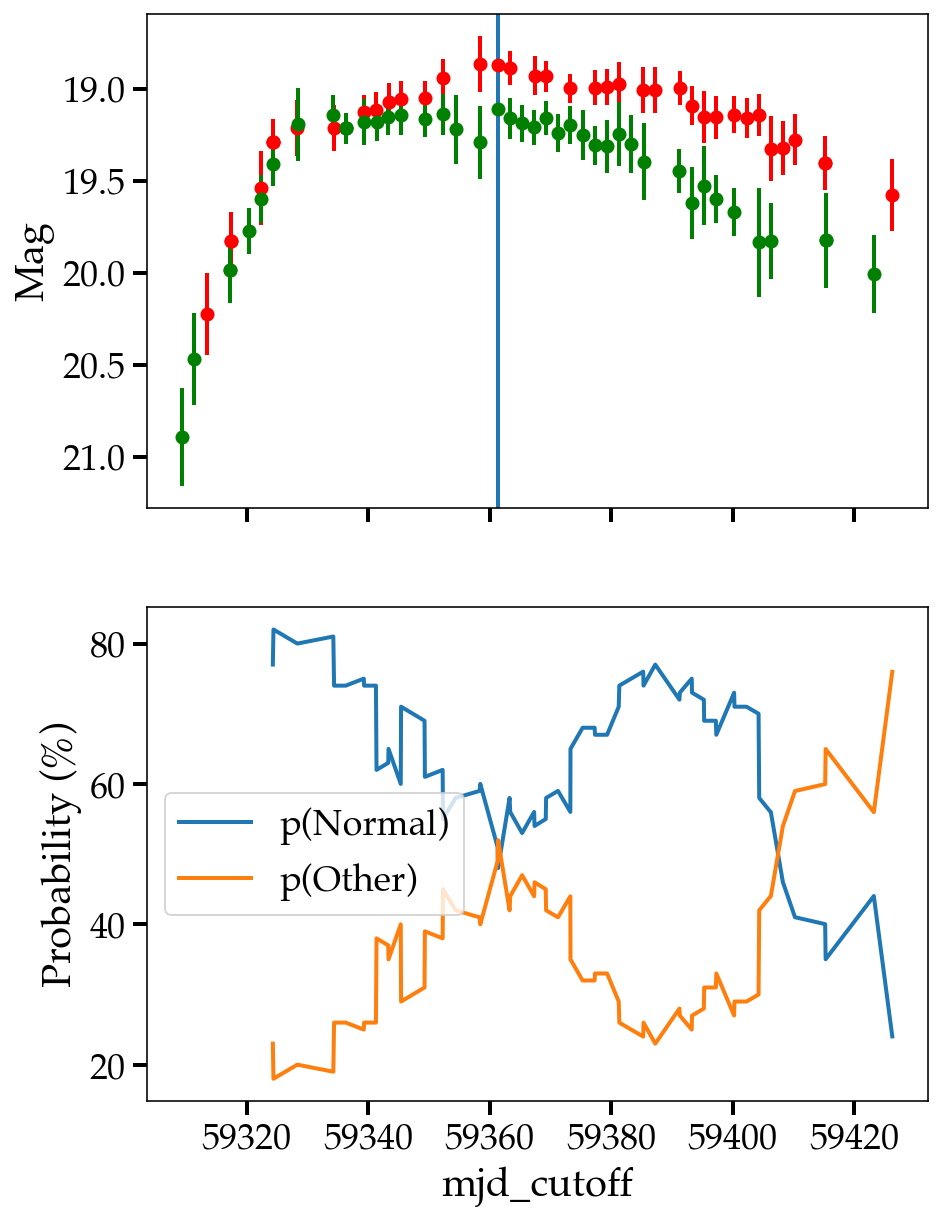

ZTF20acxqxyw Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


6
https://alerce.online/object/ZTF20acxqxyw Other


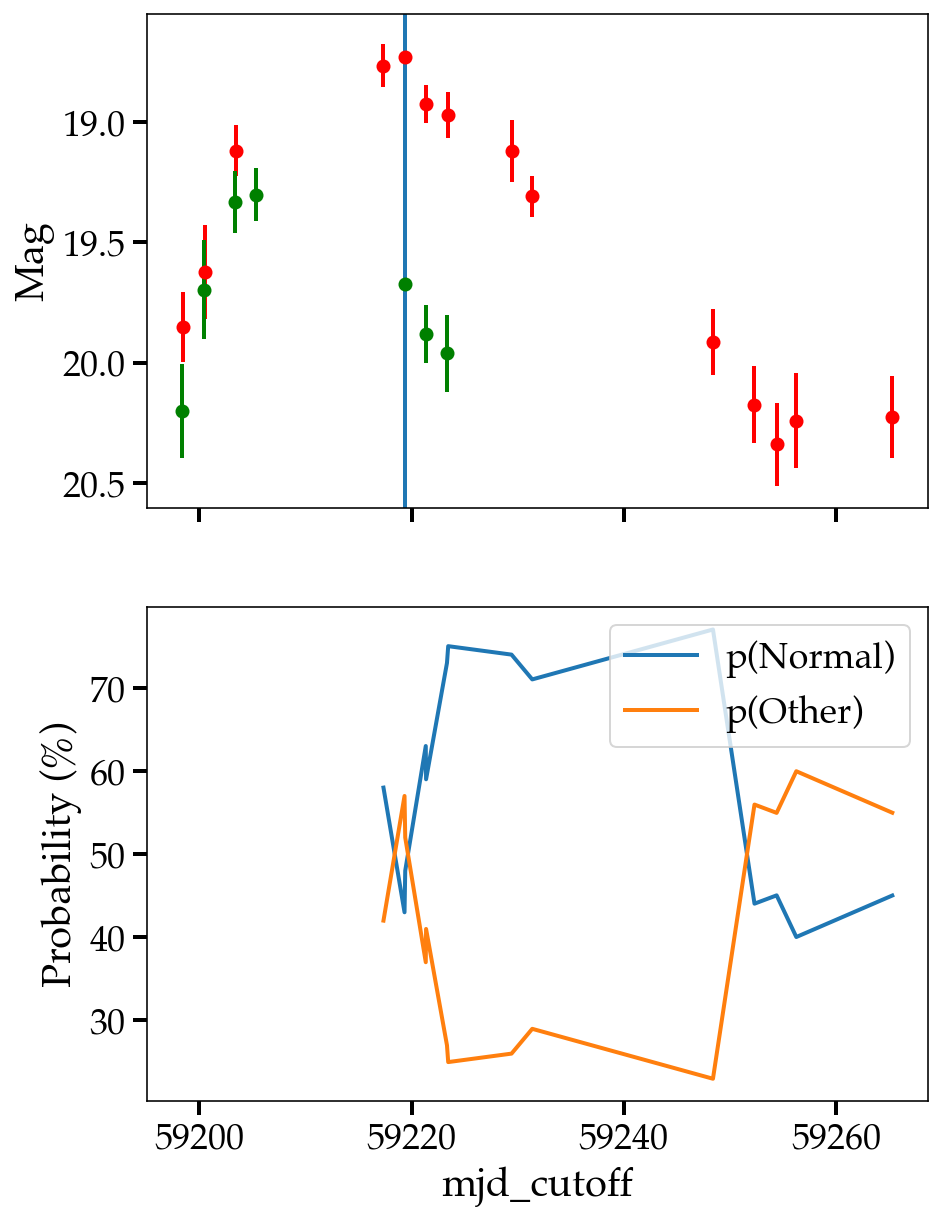

ZTF21abcgnqn Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


12
https://alerce.online/object/ZTF21abcgnqn Other


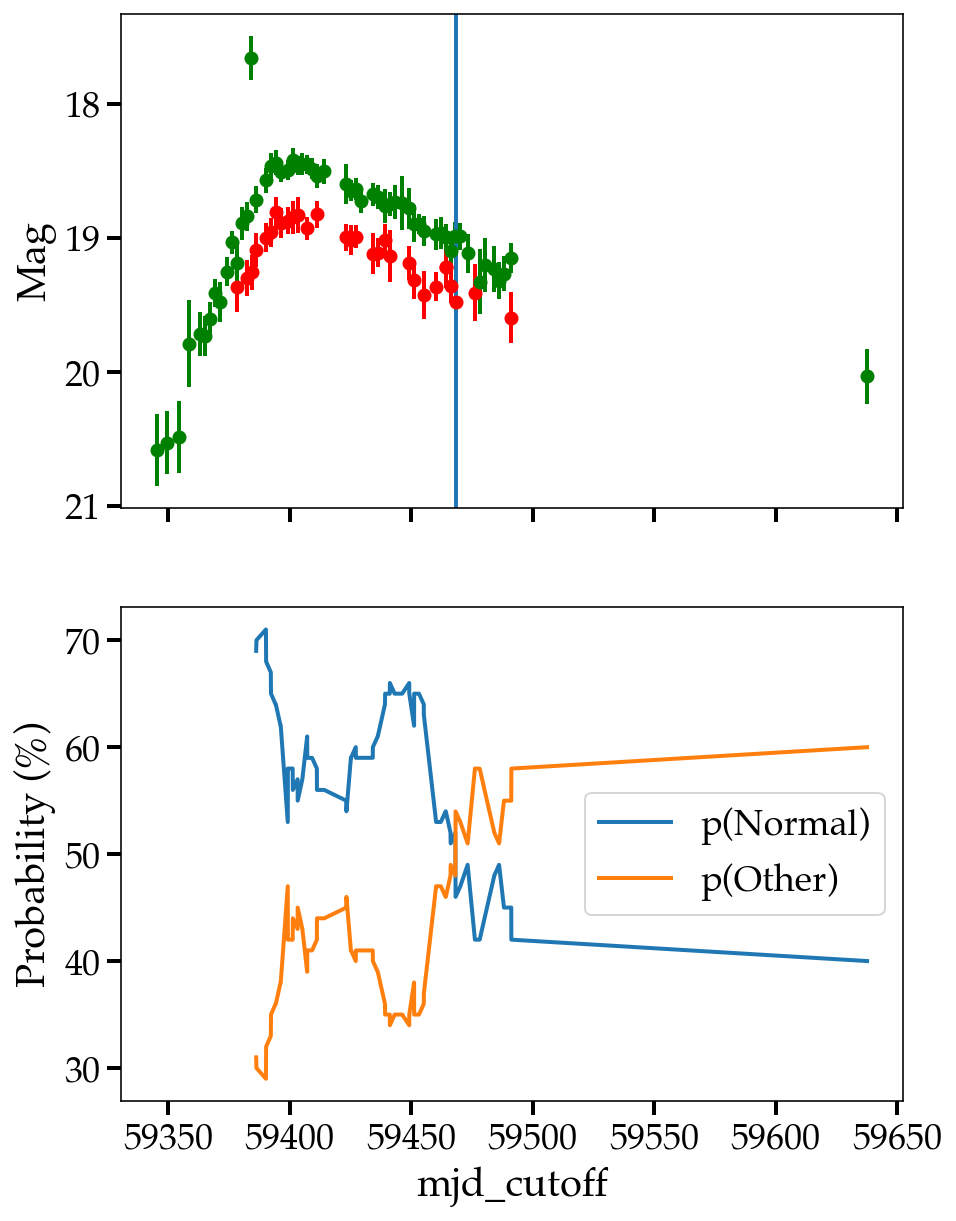

ZTF18acvgjqv Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


29
https://alerce.online/object/ZTF18acvgjqv Other


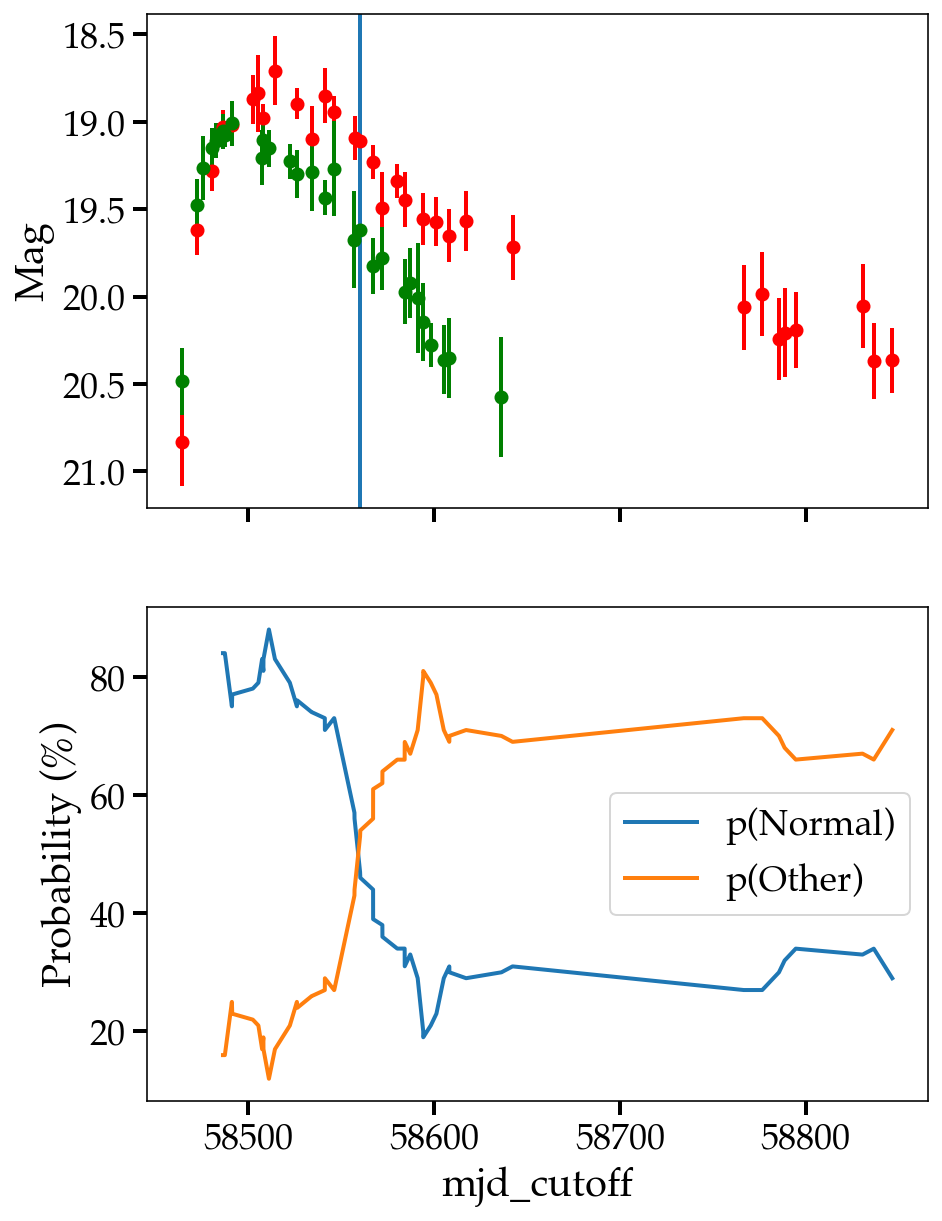

ZTF21abaxaqq Other
Prediction doesn't exceed anom_threshold of 50% for ZTF21abaxaqq.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


86
https://alerce.online/object/ZTF21abaxaqq Other


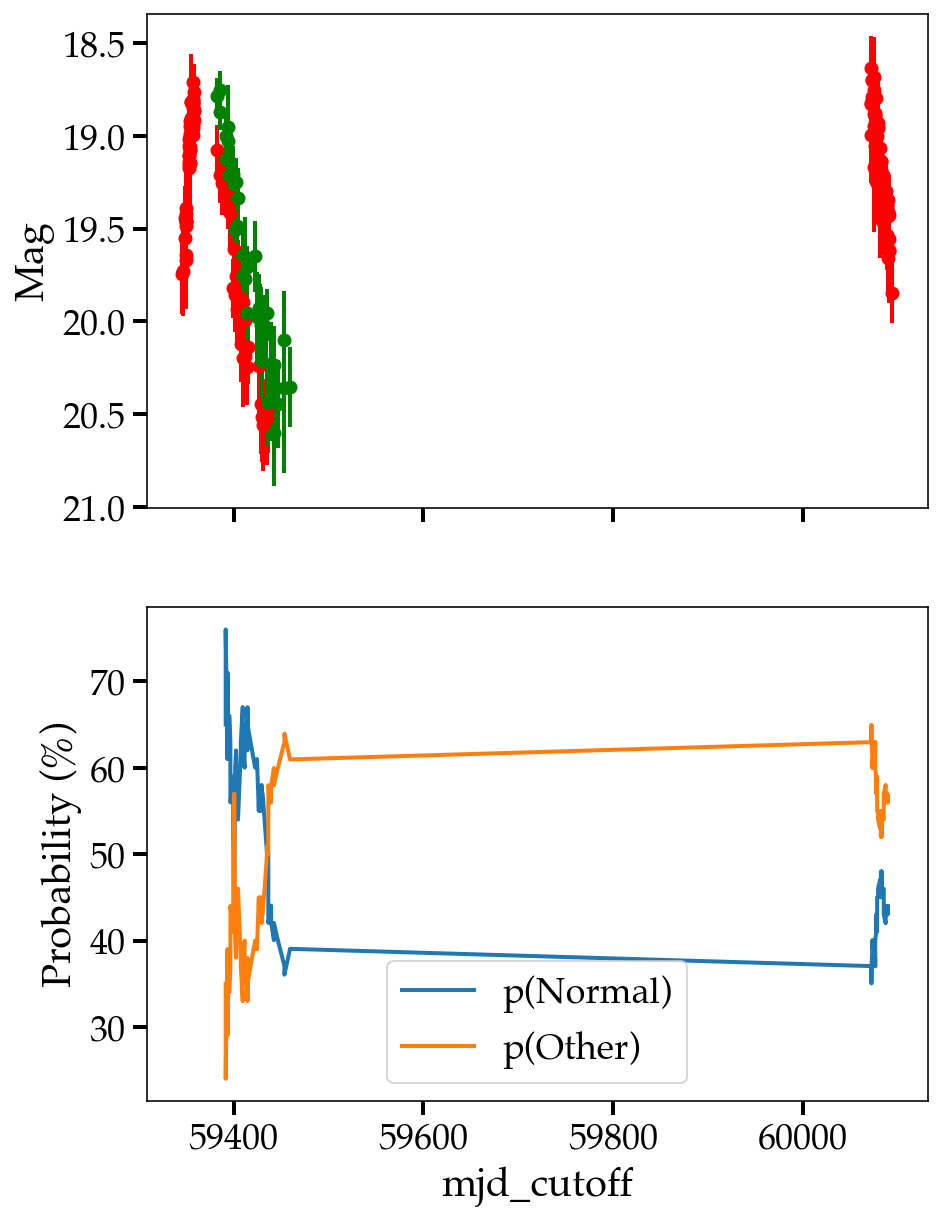

ZTF18acaqdaa Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


73
https://alerce.online/object/ZTF18acaqdaa Other


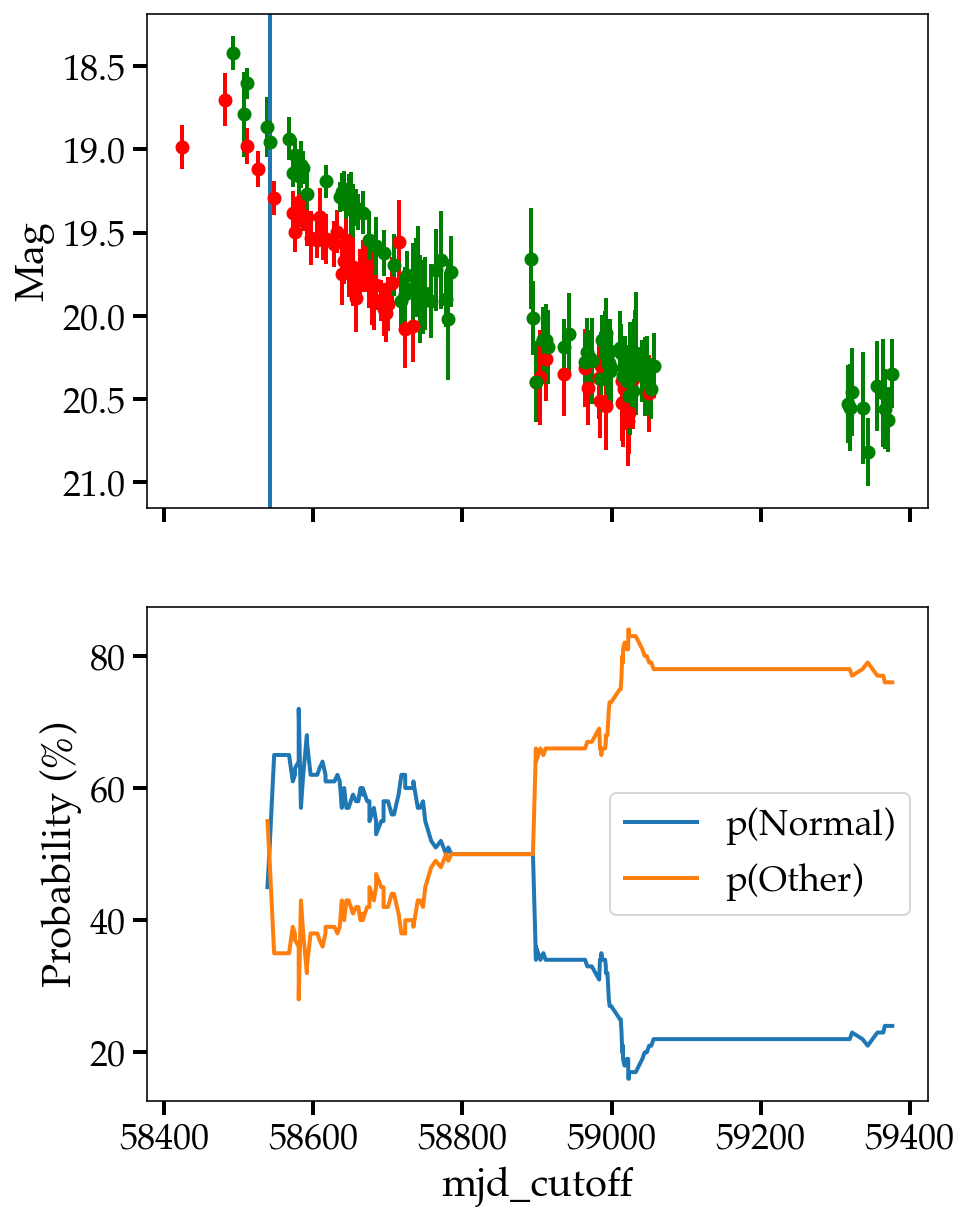

ZTF21aaaokyp Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


48
https://alerce.online/object/ZTF21aaaokyp Other


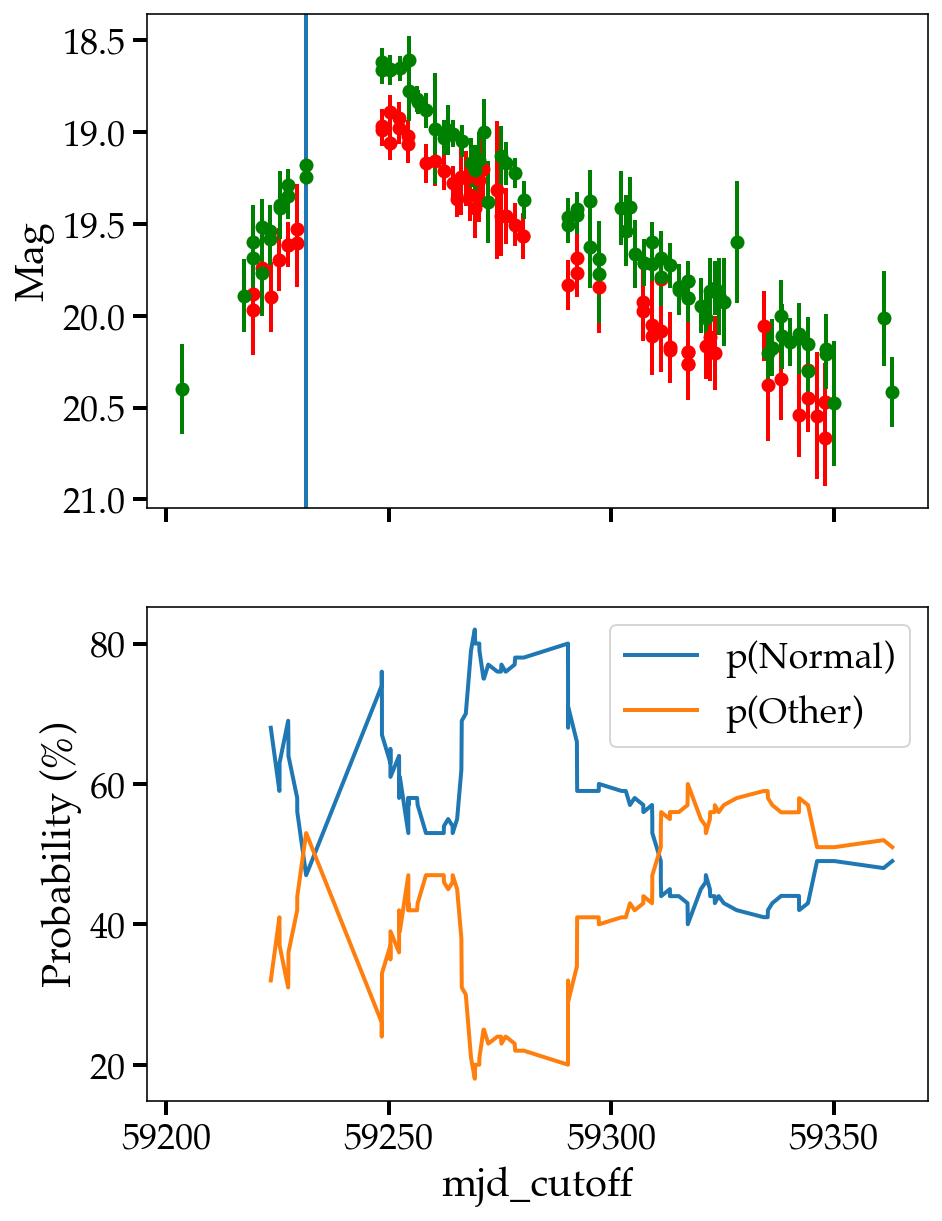

ZTF21aapvvtb Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


18
https://alerce.online/object/ZTF21aapvvtb Other


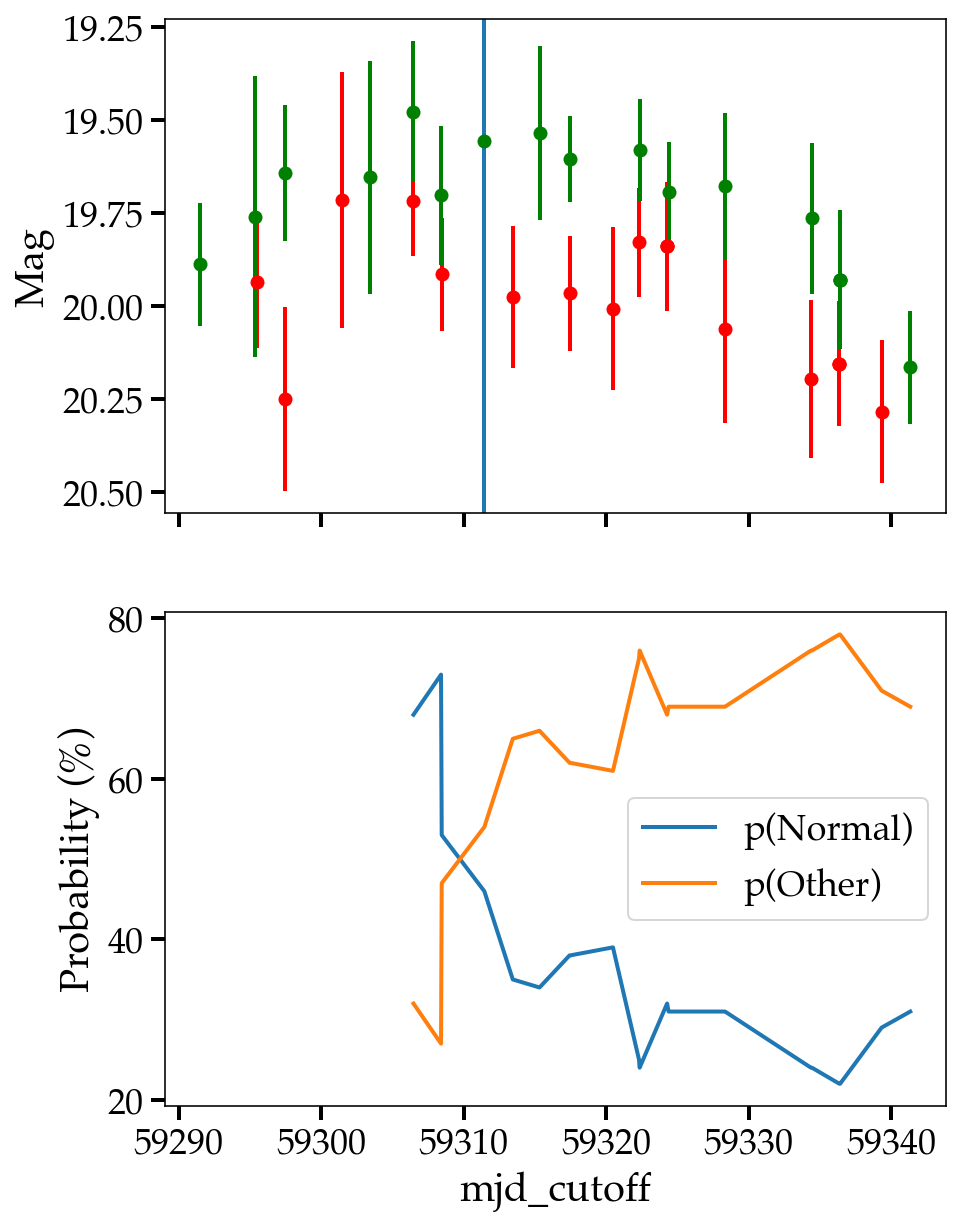

ZTF20acnznms Other


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


77
https://alerce.online/object/ZTF20acnznms Other


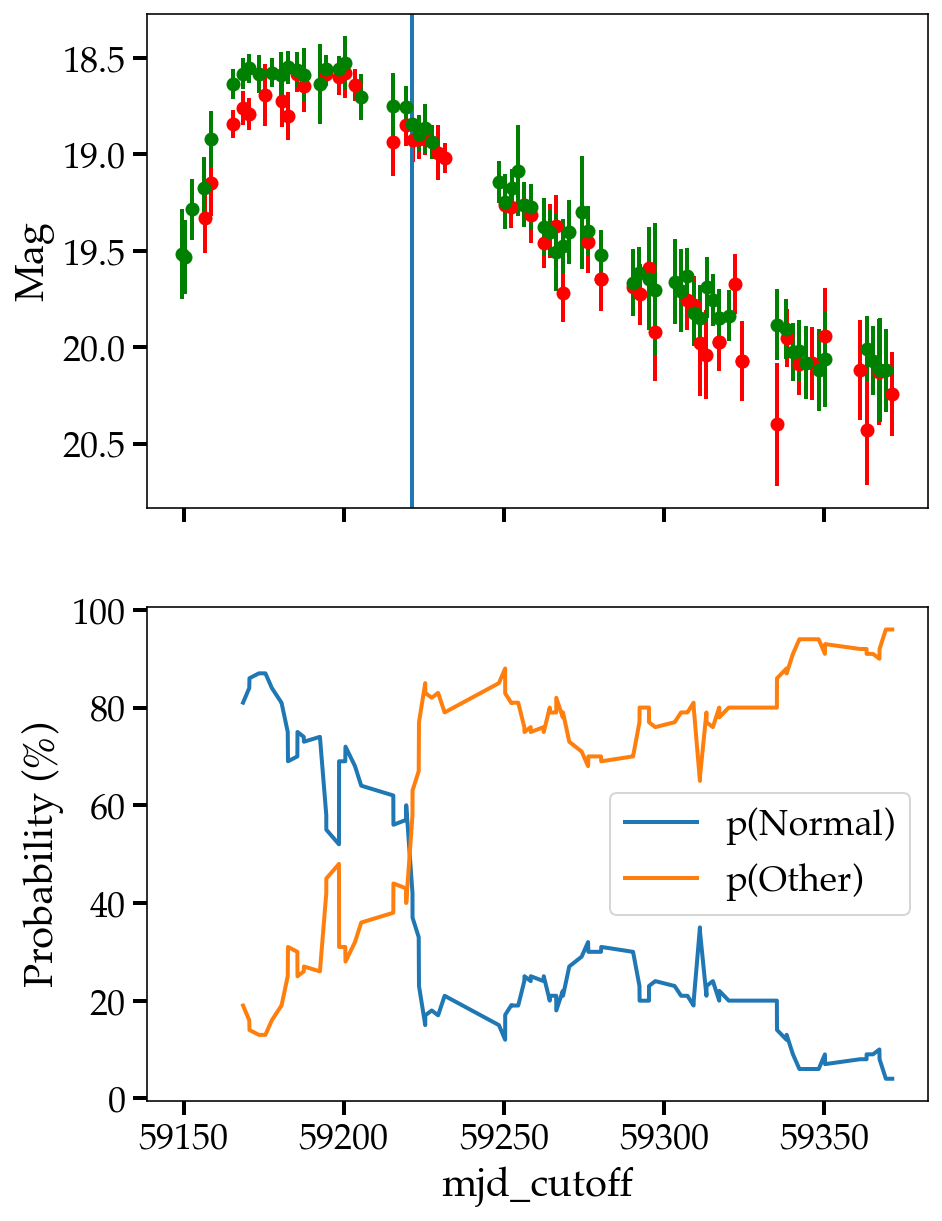

ZTF19aaadwfi Other
Prediction doesn't exceed anom_threshold of 50% for ZTF19aaadwfi.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF19aaadwfi Other


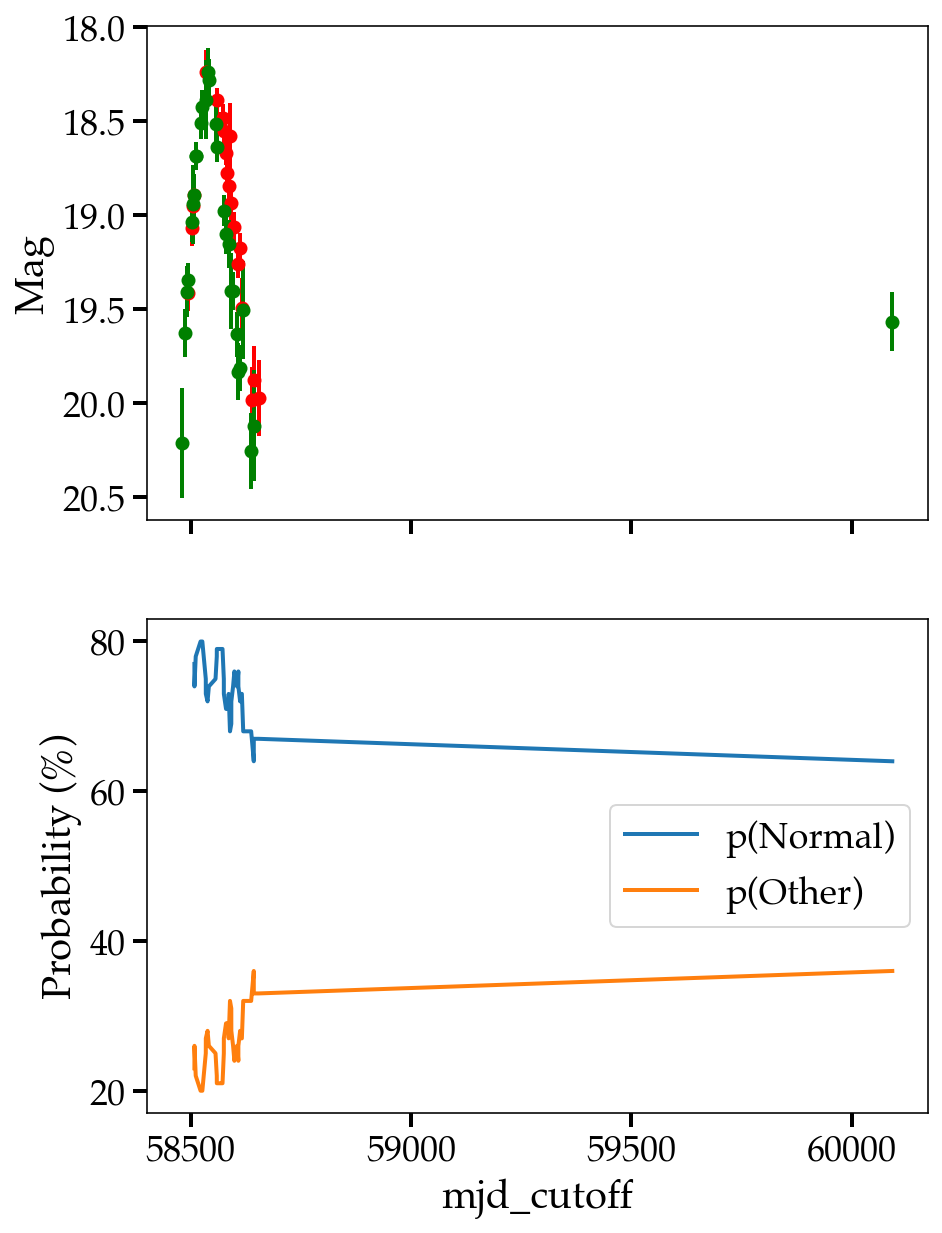

ZTF20acwytxn Other
Prediction doesn't exceed anom_threshold of 50% for ZTF20acwytxn.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


22
https://alerce.online/object/ZTF20acwytxn Other


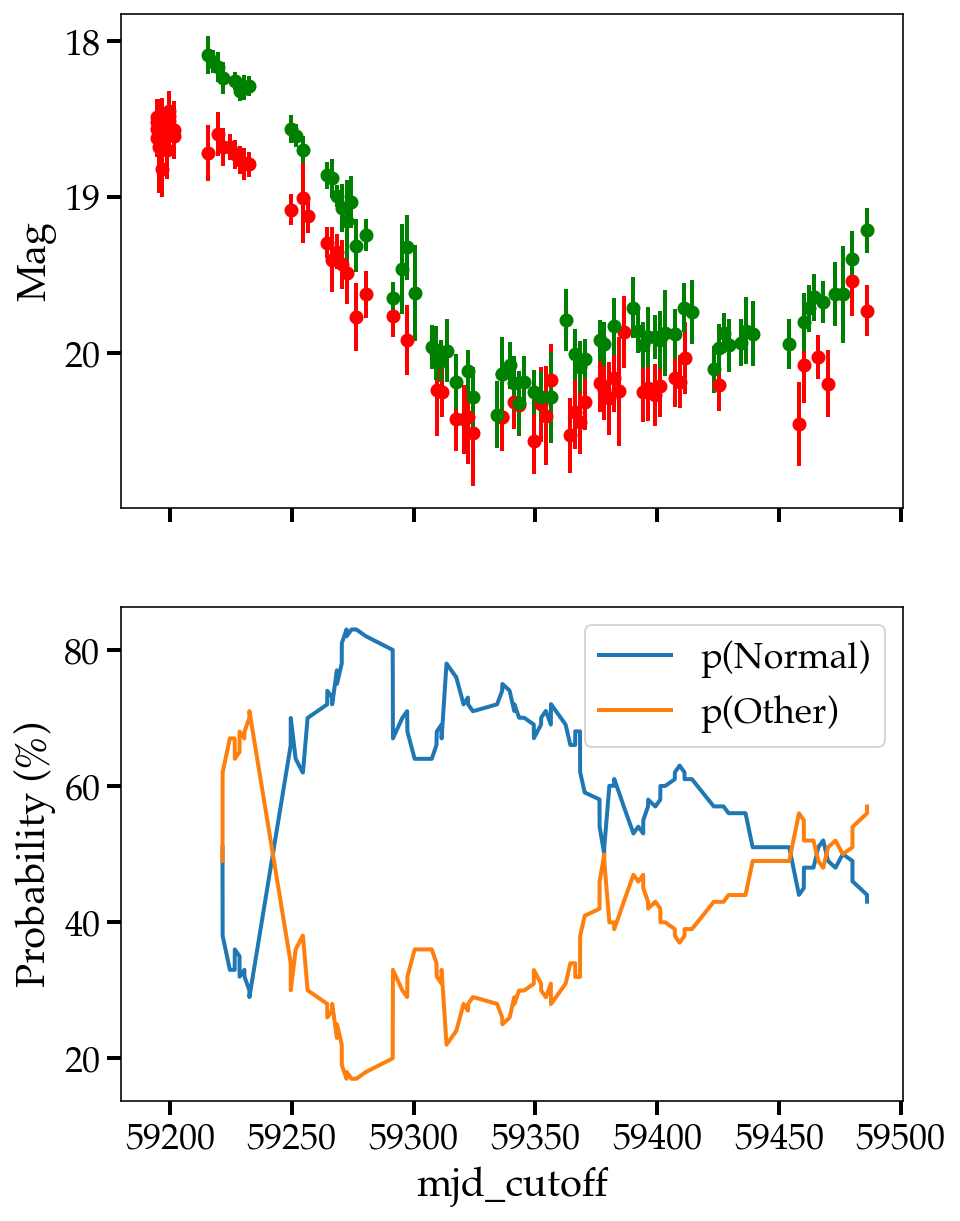

In [40]:
plot_RFC_prob_vs_lc(dataframe=df2_other_cor, anom_thresh=50)

14 "other" objects by TNS label correcly classified as other by RFC for full LC.
__________
14 tagged anomalous via full LC . 
* 2 SLSN-II,
* 3 SN IIn, 
* 1 SN IIb, 
* 6 TDE, 
* 1 Ib,
* 1 Ic,
* 0 Ic-BL.

+7 tagged anomalous recovered via timeseries ONLY (0 for full LC). 
* 0 SLSN-II,
* 4 SN IIn, 
* 0 SN IIb,
* 1 TDE, 
* 0 Ib,
* 1 Ic,
* 1 Ic-BL.

= 21 total tagged anomalous | anomalous label
* 2 SLSN-II, (2/3 = 66.7% total recovered)
* 7 SN IIn, (7/13 = 53.7% total recovered)
* 1 SN IIb, (1/5 = 20% total recovered)
* 7 TDE, (7/8 = 87.5% total recovered)
* 1 Ib, (1/4 = 25% total recovered)
* 2 Ic, (2/8 = 25% total recovered)
* 1 Ic-BL. (1/4 = 25% total recovered)

In [41]:
Counter(x_test_all.tns_cls)

Counter({'SN Ia': 279,
         'SN Ib': 4,
         'SN IIP': 4,
         'SN II': 63,
         'SN Ic': 8,
         'SN Ia-91T-like': 9,
         'SN Ic-BL': 4,
         'SN IIn': 13,
         'TDE': 8,
         'SN IIb': 5,
         'SLSN-II': 3})

In [42]:
df2_normal =df2[df2['tns_cls'] != 'Other']

df2_normal_cor = df2_normal[df2_normal['tns_cls'] == df2_normal['RFC_best_cls']]
df2_normal_inc = df2_normal[df2_normal['tns_cls'] != df2_normal['RFC_best_cls']]

print("Inorrectly flagged `anomalies' (Technically `Normal` by its TNS label. But investigate!)")
for ob in df2_normal_inc.index:
    print(f'https://alerce.online/object/{ob}', x_test_all.loc[ob].tns_cls)

Inorrectly flagged `anomalies' (Technically `Normal` by its TNS label. But investigate!)
https://alerce.online/object/ZTF20abarsvz SN Ia
https://alerce.online/object/ZTF21aaizyqc SN II
https://alerce.online/object/ZTF21aajvukh SN II
https://alerce.online/object/ZTF20accmtgt SN Ia
https://alerce.online/object/ZTF21aadacxv SN II
https://alerce.online/object/ZTF21aadkhte SN II
https://alerce.online/object/ZTF20actkutp SN II
https://alerce.online/object/ZTF21acmnpqa SN Ia
https://alerce.online/object/ZTF20acyroke SN Ia
https://alerce.online/object/ZTF18abaeqpf SN II
https://alerce.online/object/ZTF21aapffqd SN II
https://alerce.online/object/ZTF20abqlmwn SN II
https://alerce.online/object/ZTF21abpyauz SN II


## plot_RFC_prob_vs_lc(dataframe=df2_normal_inc, anom_thresh=50)

In [44]:
df2_normal_inc.loc['ZTF21aaizyqc']

feature_amplitude_magn_r                   1.022863
feature_anderson_darling_normal_magn_r     2.109273
feature_beyond_1_std_magn_r                 0.27907
feature_beyond_2_std_magn_r                0.046512
feature_cusum_magn_r                       0.407611
                                            ...    
s2                                        -0.626242
s3                                        -1.395525
Normal                                    38.030514
Other                                     61.969486
RFC_best_cls                                  Other
Name: ZTF21aaizyqc, Length: 130, dtype: object

Inorrectly flagged `anomalies` (Technically `Normal` by its TNS label. But investigate!)
https://alerce.online/object/ZTF20abarsvz SN Ia - NOT. 2021our, z=0.039. Normal Ia. Elliptical gal. Early epoch 300d before event probably is reason.
https://alerce.online/object/ZTF21aaizyqc SN II - ? 2021ckb; z=0.070265. Could be IIn. Lasted 70d. Interesting enough.
https://alerce.online/object/ZTF21aajvukh SN II - ANOM.  2021cpi; z=0.055. LC looks IIb.
https://alerce.online/object/ZTF20accmtgt SN Ia - ANOM. 2020tnq; z=0.033. 100d. Very end decline of Ia. 18.5mag
https://alerce.online/object/ZTF21aadacxv SN II - NOT. 2021aff; z=0.051. ? LC looks IIP
https://alerce.online/object/ZTF21aadkhte SN II - ANOM. 2021zj; z=0.046. 150d double peak SN II. Tag at 2nd peak
https://alerce.online/object/ZTF20actkutp SN II - ANOM. 2020abah; z=0.03. 100d rise (interaction). 180d LC. 
https://alerce.online/object/ZTF21acmnpqa SN Ia - ANOM?	2021adpx; z=0.047. 91bg-like Understandable b.c only LC rise except 1 epoch (the anom one)
https://alerce.online/object/ZTF20acyroke SN Ia - ANOM. 2020aeuh; z=0.126. Really Ia-CSM. Tagged at 2nd peak.
https://alerce.online/object/ZTF18abaeqpf SN II - ANOM. 2020ywo; z=0.0475. 200d SN II. Tagged just before peak (17.5mag) 
https://alerce.online/object/ZTF21aapffqd SN II - NOT. 2021fyp; z=0.052896. ? pretty Normal SN II
https://alerce.online/object/ZTF20abqlmwn SN II - ANOM. 2020rmk; z=0.025. Heavily reddened due to dust. 200d.
https://alerce.online/object/ZTF21abpyauz SN II - ANOM. 2021uzt; z=0.061. IIn cand, LSB host.

13 total tagged p(anomalous|normal label) via full LC
* 9 SN II (7 reasonable, 2 Questionable )
    * ------R------
    * 1 IIb cand.
        * 2021cpi; z=0.055
    * 2 IIn cand.
        * 2021ckb; z=0.070265
        * 2021uzt; z=0.061. abs mag~ -19.5 mag. 120d LC. LSB host.
    * 1 double peak SN II
        * 2021zj; z=0.046. 150d LC.
    * 3 SN II lasting ~200d
        * 2020abah; z=0.03. 100d rise (interaction). 180d LC. 
        * 2020ywo; z=0.0475. 200d LC. Tagged just before peak (17.5mag) 
        * 2020rmk; z=0.025. 200d LC. Heavily reddened due to dust. 
    * ------?------
    * 2 SN II normal
        * 2021aff z=0.051. IIP
        * 2021fyp; z=0.052896. Normal II. 30d rise. *Maybe* a IIn cand though.
    
* 4 SN Ia (3 reasonable, 1 questionable)
    * ------R------
    * 1 Ia-CSM cand.
        * 2020aeuh; z=0.126. Tagged at 2nd peak.
    * 2 Weird Ia
        * 2020tnq; z=0.033. Very end decline of Ia, lasted 100d 
        * 2021adpx; z=0.047. SN Ia-91bg cand.
    * ------?------
    * 1 Ia-norm
        * 2021our, z=0.039. Normal Ia.
     

In [45]:
# actually very long lived SN II, very red, one Ia-CSM, IIb, (MUCH better than numbers suggest slightly...)
# all interesting really!...

In [46]:
print("Correctly flagged `Normal' (Technically `Normal` by its TNS label. But investigate!)")
for ob in df2_normal_cor.index:
    print(f'https://alerce.online/object/{ob}', x_test_all.loc[ob].tns_cls)

Correctly flagged `Normal' (Technically `Normal` by its TNS label. But investigate!)
https://alerce.online/object/ZTF21abflgpq SN Ia
https://alerce.online/object/ZTF21abkaoxe SN Ia
https://alerce.online/object/ZTF20acpkled SN Ia
https://alerce.online/object/ZTF21aaazjia SN Ia
https://alerce.online/object/ZTF20acvdqtg SN Ia
https://alerce.online/object/ZTF21aaabwem SN IIP
https://alerce.online/object/ZTF20acqzpta SN Ia
https://alerce.online/object/ZTF21abhrmrv SN Ia
https://alerce.online/object/ZTF21aaabuoj SN Ia
https://alerce.online/object/ZTF20acbiwri SN II
https://alerce.online/object/ZTF21abrxoir SN Ia
https://alerce.online/object/ZTF21aaagzee SN Ia
https://alerce.online/object/ZTF21abfxjkq SN II
https://alerce.online/object/ZTF21abcnkbe SN Ia
https://alerce.online/object/ZTF21aciqcge SN Ia
https://alerce.online/object/ZTF20acwfftd SN Ia
https://alerce.online/object/ZTF21abzbwfo SN II
https://alerce.online/object/ZTF21aahzspd SN Ia
https://alerce.online/object/ZTF21aalnhby SN Ia
ht

In [47]:
# RUN!
# plot_RFC_prob_vs_lc(dataframe=df2_normal_cor, anom_thresh=50)

Correctly flagged `Normal` (Technically `Normal` by its TNS label. But investigate!)
https://alerce.online/object/ZTF21abflgpq SN Ia - NOT
https://alerce.online/object/ZTF21abkaoxe SN Ia - ""
https://alerce.online/object/ZTF20acpkled SN Ia
https://alerce.online/object/ZTF21aaazjia SN Ia
https://alerce.online/object/ZTF20acvdqtg SN Ia
https://alerce.online/object/ZTF21aaabwem SN IIP
https://alerce.online/object/ZTF20acqzpta SN Ia
https://alerce.online/object/ZTF21abhrmrv SN Ia
https://alerce.online/object/ZTF21aaabuoj SN Ia
https://alerce.online/object/ZTF20acbiwri SN II
https://alerce.online/object/ZTF21abrxoir SN Ia - ANOM. 2021vju; z=0.026657. ?
https://alerce.online/object/ZTF21aaagzee SN Ia
https://alerce.online/object/ZTF21abfxjkq SN II
https://alerce.online/object/ZTF21abcnkbe SN Ia
https://alerce.online/object/ZTF21aciqcge SN Ia
https://alerce.online/object/ZTF20acwfftd SN Ia
https://alerce.online/object/ZTF21abzbwfo SN II - ANOM. 2021yfi; z=0.22. Interesting enough. (TNS classificaion report: AT2021yfi was selected as a superluminous supernova candidate by Perley et al. (AstroNote 2021-280). We determine the redshift of z = 0.22 from P-cygni emission lines, which implies a peak magnitude of M_g ~ -21.3. The lack of narrow emission lines prevents a "superluminous IIn" classification and we instead adopt a generic Type II classification.)
https://alerce.online/object/ZTF21aahzspd SN Ia
https://alerce.online/object/ZTF21aalnhby SN Ia
https://alerce.online/object/ZTF21abizxkw SN Ia
https://alerce.online/object/ZTF21abjaksr SN Ia
https://alerce.online/object/ZTF20aciudrr SN Ia
https://alerce.online/object/ZTF21aarejnt SN Ia
https://alerce.online/object/ZTF21aaxzbrn SN Ia
https://alerce.online/object/ZTF21aamucom SN Ia-91T-like
https://alerce.online/object/ZTF18aaisqmw SN Ia
https://alerce.online/object/ZTF20acowcee SN Ia
https://alerce.online/object/ZTF21aajuerd SN Ia
https://alerce.online/object/ZTF21acefbte SN Ia
https://alerce.online/object/ZTF21aapzzgf SN Ia
https://alerce.online/object/ZTF21acaegsr SN Ia
https://alerce.online/object/ZTF21aabygea SN II
https://alerce.online/object/ZTF21aaczpca SN Ia
https://alerce.online/object/ZTF22aaafdna SN Ia
https://alerce.online/object/ZTF21aamwqim SN II
https://alerce.online/object/ZTF21acnfoqn SN II
https://alerce.online/object/ZTF21aakybgi SN Ia
https://alerce.online/object/ZTF21aapkhsc SN Ia
https://alerce.online/object/ZTF18aayyqia SN Ia
https://alerce.online/object/ZTF21abqpwpu SN Ia
https://alerce.online/object/ZTF20acqlcge SN Ia
https://alerce.online/object/ZTF20achtpbn SN Ia
https://alerce.online/object/ZTF21acgyzel SN Ia
https://alerce.online/object/ZTF20acxncha SN Ia
https://alerce.online/object/ZTF21aarwlht SN Ia
https://alerce.online/object/ZTF20acwyihb SN Ia
https://alerce.online/object/ZTF21aaxtdrs SN Ia
https://alerce.online/object/ZTF21abcmtev SN II
https://alerce.online/object/ZTF21abjdqbo SN Ia
https://alerce.online/object/ZTF21abrzsol SN Ia
https://alerce.online/object/ZTF21abcnpnk SN Ia - ANOM. 2021ntw; z=0.099. ? Normal Ia. No obvious 2nd bump tho.
https://alerce.online/object/ZTF20abyzomt SN II
https://alerce.online/object/ZTF20acpwjus SN Ia-91T-like
https://alerce.online/object/ZTF21aagtqgz SN Ia-91T-like - ANOM. 2021brx; z=0.06232. One anom epoch just after peak. 18.5 mag.
https://alerce.online/object/ZTF20abywydb SN II
https://alerce.online/object/ZTF22aaabnwa SN Ia
https://alerce.online/object/ZTF21aaabzap SN Ia
https://alerce.online/object/ZTF22aaaeeva SN Ia
https://alerce.online/object/ZTF21abxknvv SN Ia
https://alerce.online/object/ZTF21aakigqr SN II
https://alerce.online/object/ZTF21abhttll SN Ia
https://alerce.online/object/ZTF21achkgap SN Ia
https://alerce.online/object/ZTF21aarohyu SN Ia
https://alerce.online/object/ZTF21abjdiok SN Ia
https://alerce.online/object/ZTF21acdoydr SN Ia
https://alerce.online/object/ZTF21aaqzqaa SN Ia
https://alerce.online/object/ZTF21abkkwie SN Ia
https://alerce.online/object/ZTF22aaafdrn SN Ia
https://alerce.online/object/ZTF20acuoclk SN Ia
https://alerce.online/object/ZTF21acdcxfz SN Ia
https://alerce.online/object/ZTF21aasufxv SN Ia
https://alerce.online/object/ZTF18abufaej SN II
https://alerce.online/object/ZTF21aarasvn SN II
https://alerce.online/object/ZTF20acjdhof SN Ia-91T-like
https://alerce.online/object/ZTF21aaxstzy SN Ia - ANOM. 2021kpu; z=0.069. ? Normal. Ia.
https://alerce.online/object/ZTF21aalxurx SN II - ANOM. 2021dqs; z=0.027. 150d LC. Understandable. Tagged at peak (~19mag). 
https://alerce.online/object/ZTF21aawckpe SN Ia
https://alerce.online/object/ZTF21aawlwoy SN Ia
https://alerce.online/object/ZTF21aaadiap SN Ia
https://alerce.online/object/ZTF21aaqzkhx SN Ia
https://alerce.online/object/ZTF18abrfccm SN Ia
https://alerce.online/object/ZTF20acsesce SN Ia
https://alerce.online/object/ZTF20acxbbaj SN Ia
https://alerce.online/object/ZTF20acfkyll SN II
https://alerce.online/object/ZTF21absbwyz SN Ia
https://alerce.online/object/ZTF20acuzlib SN Ia
https://alerce.online/object/ZTF21abicgai SN Ia
https://alerce.online/object/ZTF21aalydkl SN Ia
https://alerce.online/object/ZTF21acaqdnb SN Ia
https://alerce.online/object/ZTF21abmwgow SN Ia
https://alerce.online/object/ZTF22aaailga SN Ia
https://alerce.online/object/ZTF21aagmoqw SN Ia
https://alerce.online/object/ZTF20acywefl SN Ia
https://alerce.online/object/ZTF21abidxwo SN II
https://alerce.online/object/ZTF21abzgzvs SN Ia
https://alerce.online/object/ZTF21aagyxgr SN Ia
https://alerce.online/object/ZTF21abvqrln SN Ia
https://alerce.online/object/ZTF21abpland SN Ia
https://alerce.online/object/ZTF21acbjxhr SN Ia
https://alerce.online/object/ZTF20abweedo SN Ia
https://alerce.online/object/ZTF21aalenaa SN Ia
https://alerce.online/object/ZTF20acmbhgy SN Ia
https://alerce.online/object/ZTF21aaoekcj SN Ia
https://alerce.online/object/ZTF21aazazvw SN Ia
https://alerce.online/object/ZTF21abplsmq SN Ia
https://alerce.online/object/ZTF21abtuutw SN Ia
https://alerce.online/object/ZTF21abwdzio SN Ia
https://alerce.online/object/ZTF21abxpinb SN Ia - ANOM. 2021ydb; z=0.095. x1=-3. Normal Ia. Only 1 anom epoch. Elliptical gal. 20 mag.
https://alerce.online/object/ZTF21abnvsic SN Ia - ANOM. 2021uby; z=0.072. No second bump, spectra is normal Ia tho.
https://alerce.online/object/ZTF21aarytbc SN II
https://alerce.online/object/ZTF20acvjagm SN II
https://alerce.online/object/ZTF21abbzcxe SN Ia
https://alerce.online/object/ZTF18aawitry SN Ia
https://alerce.online/object/ZTF21aazwtoz SN Ia
https://alerce.online/object/ZTF21aavxruq SN Ia
https://alerce.online/object/ZTF21aaluoym SN Ia
https://alerce.online/object/ZTF21abbuxfm SN Ia
https://alerce.online/object/ZTF20actveqm SN Ia
https://alerce.online/object/ZTF21ackeofr SN Ia
https://alerce.online/object/ZTF20acuhgar SN II - ANOM. 2020abdi; z=0.053. 175d LC. Understandable. -19.2 Abs mag. long lived. Tagged near peak (18 mag). Spiral.
https://alerce.online/object/ZTF20aczgvcg SN Ia
https://alerce.online/object/ZTF20acpknjk SN Ia
https://alerce.online/object/ZTF21acjosgg SN Ia
https://alerce.online/object/ZTF21acajcyb SN Ia
https://alerce.online/object/ZTF20abvowvw SN Ia
https://alerce.online/object/ZTF22aaaepjq SN Ia
https://alerce.online/object/ZTF18aacnlxz SN II
https://alerce.online/object/ZTF20acflmyv SN Ia
https://alerce.online/object/ZTF20acxznai SN Ia
https://alerce.online/object/ZTF21abfxlvo SN Ia
https://alerce.online/object/ZTF20achtubm SN Ia - ANOM. 2020vem; z=0.136. Normal Ia spec. No obvious 2nd peak. 19.75 mag.
https://alerce.online/object/ZTF18aaiwewk SN Ia
https://alerce.online/object/ZTF21abuuuuj SN Ia
https://alerce.online/object/ZTF21aahsqng SN Ia
https://alerce.online/object/ZTF20achoqvb SN Ia
https://alerce.online/object/ZTF21abbkvrt SN Ia
https://alerce.online/object/ZTF22aaahhbo SN II
https://alerce.online/object/ZTF18aaoxrup SN Ia
https://alerce.online/object/ZTF18abrebsb SN Ia
https://alerce.online/object/ZTF21aayyxum SN Ia
https://alerce.online/object/ZTF21abicckd SN Ia
https://alerce.online/object/ZTF21abviabc SN II - ANOM. 2021wyn; z=0.053467. Lots of host gal extinction/red. Spiral.
https://alerce.online/object/ZTF21aaxubqf SN Ia
https://alerce.online/object/ZTF21aasgcve SN Ia-91T-like
https://alerce.online/object/ZTF21aaagypx SN IIP
https://alerce.online/object/ZTF20acxtdcm SN II
https://alerce.online/object/ZTF20acrerzb SN Ia
https://alerce.online/object/ZTF18aaqnxjb SN Ia
https://alerce.online/object/ZTF20acajvrj SN Ia
https://alerce.online/object/ZTF20aciuciv SN II
https://alerce.online/object/ZTF21aappktx SN Ia
https://alerce.online/object/ZTF21abbwbja SN Ia
https://alerce.online/object/ZTF20aatxryt SN Ia
https://alerce.online/object/ZTF21acizsaz SN Ia
https://alerce.online/object/ZTF18acbvgtu SN Ia
https://alerce.online/object/ZTF20acnagjb SN Ia
https://alerce.online/object/ZTF22aaabnan SN Ia
https://alerce.online/object/ZTF18acsremz SN Ia
https://alerce.online/object/ZTF21aaphlty SN Ia - ANOM. 2021fwz; z=0.04887. Understandable. Looks 2006gz-like (Ia-pec), at ~ -10d instead of Ia-norm.
https://alerce.online/object/ZTF20acgznau SN Ia
https://alerce.online/object/ZTF20actpbck SN Ia
https://alerce.online/object/ZTF21achqiue SN Ia
https://alerce.online/object/ZTF21aaswtok SN Ia
https://alerce.online/object/ZTF21aapkfjx SN Ia
https://alerce.online/object/ZTF21aagsypp SN Ia
https://alerce.online/object/ZTF20acpxvez SN Ia
https://alerce.online/object/ZTF20acfnuee SN Ia
https://alerce.online/object/ZTF21aagtill SN Ia
https://alerce.online/object/ZTF20acwncbd SN Ia
https://alerce.online/object/ZTF20accodxy SN Ia - ANOM. 2020uog; z=0.075. ? Normal Ia. Flagged ~10d after peak, 19.25 mag. LSB host.
https://alerce.online/object/ZTF19aaeuhgo SN II - ANOM. 2019bcv; z=0.0678. Rightfully so. 600d SN II. Very red.
https://alerce.online/object/ZTF21aabyqps SN Ia
https://alerce.online/object/ZTF21acmresp SN Ia
https://alerce.online/object/ZTF21abdlyrc SN Ia
https://alerce.online/object/ZTF21aajgdpo SN II
https://alerce.online/object/ZTF21aadzuil SN Ia
https://alerce.online/object/ZTF21aabgdda SN Ia
https://alerce.online/object/ZTF18acuimze SN Ia
https://alerce.online/object/ZTF22aaaepao SN II
https://alerce.online/object/ZTF21abzkgvc SN Ia
https://alerce.online/object/ZTF21aaahyjj SN Ia-91T-like - ANOM. 2021me; z=0.095. Understandable. No second bump. LSB host.
https://alerce.online/object/ZTF20acjpwdk SN Ia
https://alerce.online/object/ZTF21aazhegf SN II
https://alerce.online/object/ZTF18acbygcu SN Ia
https://alerce.online/object/ZTF21aavrvuj SN II
https://alerce.online/object/ZTF21aarjehy SN II
https://alerce.online/object/ZTF21abyahbi SN II
https://alerce.online/object/ZTF21aaflzqy SN Ia
https://alerce.online/object/ZTF21aaraqpr SN Ia
https://alerce.online/object/ZTF21aaigdly SN II - ANOM. 2021cdw; z=0.03969. ? flagged on decline at 19.5 mag. Spiral.
https://alerce.online/object/ZTF20achdwmq SN Ia
https://alerce.online/object/ZTF21aafkktu SN II
https://alerce.online/object/ZTF21abxsngi SN Ia - ANOM. 2021xwy; z=	0.042. very dust extincted Ia.
https://alerce.online/object/ZTF21aaublej SN Ia
https://alerce.online/object/ZTF21abchdql SN Ia
https://alerce.online/object/ZTF21acipbwd SN Ia
https://alerce.online/object/ZTF21acptqqo SN Ia
https://alerce.online/object/ZTF20acoxmsr SN Ia
https://alerce.online/object/ZTF20acgnrqu SN Ia
https://alerce.online/object/ZTF21abwzpgf SN Ia
https://alerce.online/object/ZTF20aclgnds SN Ia
https://alerce.online/object/ZTF20acowddo SN Ia
https://alerce.online/object/ZTF21aalkknw SN Ia - ANOM. 2021dnk; z=0.1. LSB host. ?  Barely reaches anom threshold right at beginning.
https://alerce.online/object/ZTF18acbyyff SN Ia 
https://alerce.online/object/ZTF21aarybxo SN Ia
https://alerce.online/object/ZTF21aaqugxm SN II
https://alerce.online/object/ZTF20acoqlav SN Ia
https://alerce.online/object/ZTF21acbntop SN Ia
https://alerce.online/object/ZTF21acjgmiy SN Ia
https://alerce.online/object/ZTF22aaagxev SN Ia
https://alerce.online/object/ZTF20acjfimy SN Ia
https://alerce.online/object/ZTF21aagsihi SN Ia
https://alerce.online/object/ZTF21aaquhqr SN II
https://alerce.online/object/ZTF20acpqagp SN Ia
https://alerce.online/object/ZTF21aagygzv SN Ia
https://alerce.online/object/ZTF20actvpyc SN Ia
https://alerce.online/object/ZTF21acizbmv SN Ia
https://alerce.online/object/ZTF18abxhsyn SN Ia
https://alerce.online/object/ZTF20accrkpa SN II - ANOM. 2020tzd; z=0.081. ? Normal SN II. Right at anom threshold.
https://alerce.online/object/ZTF21abpviss SN Ia
https://alerce.online/object/ZTF21aahaksd SN Ia
https://alerce.online/object/ZTF21aaigqir SN Ia
https://alerce.online/object/ZTF20acobamg SN Ia
https://alerce.online/object/ZTF21abmqpja SN Ia
https://alerce.online/object/ZTF20acjrytv SN Ia
https://alerce.online/object/ZTF18accrorf SN Ia
https://alerce.online/object/ZTF21aapjmgf SN II
https://alerce.online/object/ZTF21aakvrgb SN Ia
https://alerce.online/object/ZTF21aceaiqm SN Ia
https://alerce.online/object/ZTF22aaaenuc SN Ia
https://alerce.online/object/ZTF21aavsbkt SN Ia
https://alerce.online/object/ZTF20accdijx SN II
https://alerce.online/object/ZTF22aaayjne SN Ia
https://alerce.online/object/ZTF18acsohut SN Ia
https://alerce.online/object/ZTF21aamgcrv SN Ia
https://alerce.online/object/ZTF21aalgszc SN Ia
https://alerce.online/object/ZTF21abdahai SN II
https://alerce.online/object/ZTF20abptxls SN Ia
https://alerce.online/object/ZTF21abvdazf SN Ia
https://alerce.online/object/ZTF18aaszvfn SN IIP
https://alerce.online/object/ZTF21acdnnfg SN Ia
https://alerce.online/object/ZTF20acpgzif SN Ia
https://alerce.online/object/ZTF21aaukcog SN II - ANOM. 2021jaj. z=0.04. Interesting II LC. Tagged on rise (barely)
https://alerce.online/object/ZTF18aawfofp SN Ia
https://alerce.online/object/ZTF21acjxiqw SN IIP
https://alerce.online/object/ZTF20acvemao SN Ia
https://alerce.online/object/ZTF21abmdhes SN Ia
https://alerce.online/object/ZTF21acilvjb SN Ia
https://alerce.online/object/ZTF22aaaehtn SN II
https://alerce.online/object/ZTF21aagtqgq SN Ia
https://alerce.online/object/ZTF21aagoliy SN Ia - ANOM. 2021cjc; z=0.07484. Ia-pec from spectra. Right at 50% thresh.
https://alerce.online/object/ZTF21aasafkl SN Ia
https://alerce.online/object/ZTF21aasbjgq SN Ia
https://alerce.online/object/ZTF21abxzzys SN Ia
https://alerce.online/object/ZTF18abuxjrd SN Ia
https://alerce.online/object/ZTF20acgchsp SN II
https://alerce.online/object/ZTF21aabfwwl SN II
https://alerce.online/object/ZTF21aatwlhj SN Ia
https://alerce.online/object/ZTF21aaxxoei SN II
https://alerce.online/object/ZTF21abctnoh SN Ia
https://alerce.online/object/ZTF21abtsoky SN Ia
https://alerce.online/object/ZTF22aaabpkx SN Ia
https://alerce.online/object/ZTF20adagenq SN Ia - ANOM. 2020aeps; z=0.0244. ? Tagged right at beginning of feature calc on rise.
https://alerce.online/object/ZTF19abkftvd SN Ia
https://alerce.online/object/ZTF21aaaadvr SN II - ANOM. 2020aerc; z=0.0166. 250d LC. Understandable. Long lived, red, gappy.
https://alerce.online/object/ZTF20abrjmgi SN Ia - ANOM. 2020qxp. z=nan. Understandable. on decline of bright Ia. The spectrum is similar to other transitional Type Ia supernova such as SN 2007on (TNS report).
https://alerce.online/object/ZTF21aaaovua SN Ia
https://alerce.online/object/ZTF21aapfpod SN Ia
https://alerce.online/object/ZTF20acxyipy SN Ia
https://alerce.online/object/ZTF21acermmd SN Ia
https://alerce.online/object/ZTF18actuhrs SN Ia - ANOM. 2018evt; z=0.029. Bright SN on decline. Red. No second bump obs (maybe all after).... Understandable.
https://alerce.online/object/ZTF21abvdyoj SN Ia
https://alerce.online/object/ZTF21aavodtn SN Ia
https://alerce.online/object/ZTF21aaaalaf SN Ia
https://alerce.online/object/ZTF21aafnabs SN Ia
https://alerce.online/object/ZTF21abcfgub SN Ia
https://alerce.online/object/ZTF21aawzsew SN Ia
https://alerce.online/object/ZTF21abowpnd SN Ia
https://alerce.online/object/ZTF21aaljjvt SN Ia
https://alerce.online/object/ZTF21abjamta SN II
https://alerce.online/object/ZTF20acpkprl SN Ia
https://alerce.online/object/ZTF20ackpjmb SN Ia
https://alerce.online/object/ZTF21abtgbwr SN Ia
https://alerce.online/object/ZTF21ackcrao SN Ia
https://alerce.online/object/ZTF21abtmczy SN Ia
https://alerce.online/object/ZTF21abaiicy SN Ia
https://alerce.online/object/ZTF22aaacwup SN Ia
https://alerce.online/object/ZTF20acpqbfu SN II
https://alerce.online/object/ZTF21aavozbk SN Ia
https://alerce.online/object/ZTF20abzvxyk SN Ia - ANOM. 2020tpn; z=0.093. Normal Ia.
https://alerce.online/object/ZTF20acfvgdp SN II
https://alerce.online/object/ZTF21abmspzt SN Ia
https://alerce.online/object/ZTF21aagojfe SN Ia
https://alerce.online/object/ZTF21abbgkgc SN Ia
https://alerce.online/object/ZTF20acyybvq SN Ia
https://alerce.online/object/ZTF21aaxtzzj SN II
https://alerce.online/object/ZTF18acploez SN II
https://alerce.online/object/ZTF22aaacdfe SN Ia
https://alerce.online/object/ZTF21abkkuja SN Ia
https://alerce.online/object/ZTF21acfccil SN Ia-91T-like
https://alerce.online/object/ZTF20acmntog SN Ia
https://alerce.online/object/ZTF21aadrtcs SN Ia
https://alerce.online/object/ZTF20aczhajq SN Ia
https://alerce.online/object/ZTF22aabhtsw SN Ia
https://alerce.online/object/ZTF22aaarcds SN Ia
https://alerce.online/object/ZTF21abnspht SN Ia
https://alerce.online/object/ZTF21abrlslx SN Ia
https://alerce.online/object/ZTF20acpkzxq SN Ia
https://alerce.online/object/ZTF21aagtqna SN II
https://alerce.online/object/ZTF20actskcf SN Ia
https://alerce.online/object/ZTF20acwfcfs SN Ia
https://alerce.online/object/ZTF21aanuyro SN Ia
https://alerce.online/object/ZTF21acioiha SN Ia
https://alerce.online/object/ZTF21aaabviz SN Ia
https://alerce.online/object/ZTF20acpkpla SN Ia
https://alerce.online/object/ZTF21aaaecrv SN Ia
https://alerce.online/object/ZTF20achrklb SN Ia-91T-like
https://alerce.online/object/ZTF20acwogqz SN Ia
https://alerce.online/object/ZTF20acwozwz SN Ia
https://alerce.online/object/ZTF21abfjgwr SN Ia
https://alerce.online/object/ZTF21aaufthj SN Ia
https://alerce.online/object/ZTF21aalnyny SN Ia
https://alerce.online/object/ZTF20acplqek SN Ia
https://alerce.online/object/ZTF21ackwgzm SN Ia
https://alerce.online/object/ZTF20aciuftf SN Ia
https://alerce.online/object/ZTF21abxdibe SN Ia
https://alerce.online/object/ZTF21aanzcuj SN II
https://alerce.online/object/ZTF20acwyoxc SN Ia
https://alerce.online/object/ZTF21aaxgzln SN Ia
https://alerce.online/object/ZTF21abfiuqf SN II - ANOM. 2021pla; z=0.023646. SN II on rise. Right at anom thresh. 1 epoch.
https://alerce.online/object/ZTF20acorjop SN II
https://alerce.online/object/ZTF20aclxbwk SN Ia
https://alerce.online/object/ZTF20achbejn SN II
https://alerce.online/object/ZTF21aaxwcgj SN Ia
https://alerce.online/object/ZTF21aaqgrrf SN Ia
https://alerce.online/object/ZTF21abeokcr SN Ia
https://alerce.online/object/ZTF21aavqphe SN Ia
https://alerce.online/object/ZTF21acdalyp SN Ia-91T-like
https://alerce.online/object/ZTF21abdcauj SN Ia
https://alerce.online/object/ZTF21aaetnfe SN Ia
https://alerce.online/object/ZTF21acgzwsc SN Ia
https://alerce.online/object/ZTF21aatklhw SN Ia

342 "normal" objects by TNS label.
_____________
317 total tagged p(normal|normal label), timeseries & full LC. 

27 total tagged p(anomalous|normal label) via timeseries ONLY (0 for full LC). 
* 10 SN II (6 reasonable, 4 questionable)
    * ------R------
    * 1 High-z SN II: 
        * 2021yfi; z=0.22, abs mag~ -21mag. (AT2021yfi was selected as a superluminous supernova candidate by Perley et al. (AstroNote 2021-280). We determine the redshift of z = 0.22 from P-cygni emission lines, which implies a peak magnitude of M_g ~ -21.3. The lack of narrow emission lines prevents a "superluminous IIn" classification and we instead adopt a generic Type II classification.)
    * 4 SN II lasting >=150d:
        * 2021dqs; z=0.027. 150d LC.
        * 2020abdi; z=0.053. 175d LC. (ATel #14305: Blue spectrum, with an indication of a P-Cygni H-alpha component at -7,000 km/s. The long rise (~ 1 month) and the luminosity (M_g = -19 mag) indicates some interaction)
        * 2019bcv; z=0.0678. 600d LC(!). Very red. Also IIn candidate (Abs mag ~ -19.5 mag).
        * 2020aerc; z=0.0166. 250d LC. 
    * 1 SN II with lots of host gal extinction/ very red
        * 2021wyn; z=0.053467. ~100d LC. (g-r = 1 mag).
    * ------?------
    * 4 Normal SN II
        * 2021cdw; z=0.03969. (spectrum is characterized by a blue continuum with weak hydrogen and helium P-Cygni lines superimposed, indicating that this object is a young Type II supernova.)
        * 2020tzd; z=0.081. Normal SN II. 60d LC.
        * 2021jaj. z=0.04. Normal SN II. 65d LC. 20d Rise.
        * 2021pla; z=0.023646. Normal SN II. 80d LC.
        
* 17 SN Ia (7 reasonable, 10 questionable)
    * ------R------
    * 7 Weird(ish) Ia-norm
        * 2021ydb; z=0.095. SALT3 x1=-3. 
        * 2021fwz; z=0.04887. Looks 2006gz-like (Ia-pec), at ~ -10d instead of Ia-norm.
        * 2021me; z=0.095. SN Ia-91T-like. SALT3 x1=-3, bad fit. LSB host.
        * 2021xwy; z=0.042. Very dust extincted Ia (g-r = 1 mag). SALT3 c= +0.3. 
        * 2021cjc; z=0.07484. SN Ia-pec from spectra.
        * 2020qxp; z=0.003. Transitional SN Ia / 91bg-like. (TNS report: The spectrum is similar to other transitional Type Ia supernova such as SN 2007on. The spectrum exhibits prevalent features associated with O-I and the Ca-II near-infrared triplet.)
        * 2018evt; z=0.029. Red, no second bump. SN Ia-91T-like. LC looks more like SN II. 10 YSE spectra.
    * ------?------
    * 1 SN Ia-91T-like: 
        * 2021brx; z=0.06232.
    * 9 Ia-norm: 
        * 2021vju; z=0.026657. Normal Ia.
        * 2021ntw; z=0.099. Normal Ia. (no visible 2nd bump but gappy).
        * 2021kpu; z=0.069. Normal Ia.
        * 2021uby; z=0.072. Normal Ia. (no visible 2nd bump but spectrum is normal).
        * 2020vem; z=0.136. Normal Ia.
        * 2020uog; z=0.075. Normal Ia. LSB host. Kinda weird LC, but not really.
        * 2021dnk; z=0.1. Normal Ia. LSB host. 
        * 2020aeps; z=0.0244. Normal Ia. Very near red star (check host). 
        * 2020tpn; z=0.093. Normal Ia.
    
    
    
From before, 13 total tagged p(anomalous|normal label) via full LC. 
* 9 SN II (7 reasonable, 2 Questionable )
    * ------R------
    * 1 IIb cand.
        * 2021cpi; z=0.055
    * 2 IIn cand.
        * 2021ckb; z=0.070265
        * 2021uzt; z=0.061. abs mag~ -19.5 mag. 120d LC. LSB host.
    * 1 double peak SN II
        * 2021zj; z=0.046. 150d LC.
    * 3 SN II lasting ~200d
        * 2020abah; z=0.03. 100d rise (interaction). 180d LC. 
        * 2020ywo; z=0.0475. 200d LC. Tagged just before peak (17.5mag) 
        * 2020rmk; z=0.025. 200d LC. Heavily reddened due to dust. 
    * ------?------
    * 2 SN II normal
        * 2021aff z=0.051. IIP
        * 2021fyp; z=0.052896. Normal II. 30d rise. *Maybe* a IIn cand though.
    
* 4 SN Ia (3 reasonable, 1 questionable)
    * ------R------
    * 1 Ia-CSM cand.
        * 2020aeuh; z=0.126. Tagged at 2nd peak.
    * 2 Weird Ia
        * 2020tnq; z=0.033. Very end decline of Ia, lasted 100d 
        * 2021adpx; z=0.047. SN Ia-91bg cand.
    * ------?------
    * 1 Ia-norm
        * 2021our, z=0.039. Normal Ia. - look into it (Ic?)
    
    
    
+++++++++++++++++++++++++
+++++++++++++++++++++++++
    
**Thus, 40 TOTAL p(anomalous|normal label) via timeseries OR full LC:**
* 19 SN II (13 reasonable, 6 questionable)
    * ------R------
    * 1 High-z SN II: 
        * 2021yfi; z=0.22, abs mag~ -21mag. (AT2021yfi was selected as a superluminous supernova candidate by Perley et al. (AstroNote 2021-280). We determine the redshift of z = 0.22 from P-cygni emission lines, which implies a peak magnitude of M_g ~ -21.3. The lack of narrow emission lines prevents a "superluminous IIn" classification and we instead adopt a generic Type II classification.)
    * 7 SN II lasting >=150d:
        * 2021dqs; z=0.027. 150d LC.
        * 2020abdi; z=0.053. 175d LC. (ATel #14305: Blue spectrum, with an indication of a P-Cygni H-alpha component at -7,000 km/s. The long rise (~ 1 month) and the luminosity (M_g = -19 mag) indicates some interaction)
        * 2019bcv; z=0.0678. 600d LC(!). Very red. Also IIn candidate (Abs mag ~ -19.5 mag).
        * 2020aerc; z=0.0166. 250d LC. 
        * 2020abah; z=0.03. 100d rise (interaction). 180d LC. 
        * 2020ywo; z=0.0475. 200d LC. Tagged just before peak (17.5mag) 
        * 2020rmk; z=0.025. 200d LC. Heavily reddened due to dust. 
    * 1 SN II with lots of host gal extinction/ very red
        * 2021wyn; z=0.053467. ~100d LC. (g-r = 1 mag).
    * 1 IIb cand.
        * 2021cpi; z=0.055
    * 2 IIn cand.
        * 2021ckb; z=0.070265
        * 2021uzt; z=0.061. abs mag~ -19.5 mag. 120d LC. LSB host.
    * 1 double peak SN II
        * 2021zj; z=0.046. 150d LC.

    * ------?------
    * 6 Normal SN II
        * 2021cdw; z=0.03969. (spectrum is characterized by a blue continuum with weak hydrogen and helium P-Cygni lines superimposed, indicating that this object is a young Type II supernova.)
        * 2020tzd; z=0.081. Normal SN II. 60d LC.
        * 2021jaj. z=0.04. Normal SN II. 65d LC. 20d Rise.
        * 2021pla; z=0.023646. Normal SN II. 80d LC.
        * 2021aff z=0.051. IIP
        * 2021fyp; z=0.052896. Normal II. 30d rise. *Maybe* a IIn cand though.
        
* 21 SN Ia (10 reasonable, 11 questionable)
    * ------R------
    * 1 Ia-CSM cand.
        * 2020aeuh; z=0.126. Tagged at 2nd peak.
    * 9 Weird(ish) Ia-norm
        * 2021ydb; z=0.095. SALT3 x1=-3. 
        * 2021fwz; z=0.04887. Looks 2006gz-like (Ia-pec), at ~ -10d instead of Ia-norm.
        * 2021me; z=0.095. SN Ia-91T-like. SALT3 x1=-3, bad fit. LSB host.
        * 2021xwy; z=0.042. Very dust extincted Ia (g-r = 1 mag). SALT3 c= +0.3. 
        * 2021cjc; z=0.07484. SN Ia-pec from spectra.
        * 2020qxp; z=0.003. Transitional SN Ia / 91bg-like. (TNS report: The spectrum is similar to other transitional Type Ia supernova such as SN 2007on. The spectrum exhibits prevalent features associated with O-I and the Ca-II near-infrared triplet.)
        * 2018evt; z=0.029. Red, no second bump. SN Ia-91T-like. LC looks more like SN II. 10 YSE spectra.
        * 2020tnq; z=0.033. Very end decline of Ia, lasted 100d 
        * 2021adpx; z=0.047. SN Ia-91bg cand.

    * ------?------
    * 1 SN Ia-91T-like: 
        * 2021brx; z=0.06232.
    * 10 Ia-norm: 
        * 2021vju; z=0.026657. Normal Ia.
        * 2021ntw; z=0.099. Normal Ia. (no visible 2nd bump but gappy).
        * 2021kpu; z=0.069. Normal Ia.
        * 2021uby; z=0.072. Normal Ia. (no visible 2nd bump but spectrum is normal).
        * 2020vem; z=0.136. Normal Ia.
        * 2020uog; z=0.075. Normal Ia. LSB host. Kinda weird LC, but not really.
        * 2021dnk; z=0.1. Normal Ia. LSB host. 
        * 2020aeps; z=0.0244. Normal Ia. Very near red star (check host). 
        * 2020tpn; z=0.093. Normal Ia.
        * 2021our, z=0.039. Normal Ia.

**approx 1/2 are reasonable/explainable**

# Totals

**21/45=46.6% completeness TOTAL tagged p(anomalous|anomalous label), timeseries & full LC.**

14 total tagged p(anomalous|anomalous label)
* 2 SLSN-II, (2/3 = 66.7% total recovered) | 1 missed
* 7 SN IIn, (7/13 = 53.7% total recovered) | 6 missed
* 1 SN IIb, (1/5 = 20% total recovered)    | 4 missed
* 7 TDE, (7/8 = 87.5% total recovered)     | 1 missed
* 1 Ib, (1/4 = 25% total recovered)        | 3 missed
* 2 Ic, (2/8 = 25% total recovered)        | 6 missed
* 1 Ic-BL. (1/4 = 25% total recovered)     | 3 missed

13 total tagged p(anomalous|normal label)
* 9 SN II (7 weird/interesting, 2 normal)    
* 4 SN Ia (3 weird/interesting, 1 normal)

**40/355 (= 11%) TOTAL tagged p(anomalous|normal label), timeseries OR full LC:**
* 19 SN II (13 reasonable, 6 questionable)
* 21 SN Ia (10 reasonable, 11 questionable)

**23 reasonable, 17 questionable** (**approx 1/2 are reasonable/explainable**)
**=44 Legit or Reasonable / 41 Missed OR questionable.
**=(21+13 solid cand.=)34 LEGIT ANOM / 41 Missed OR questionable = 66% 

**= 44 Legit or reasonable /61 p(anom) = 72% Purity
**= 34 LEGIT ANOM /61 p(anom) = 55.7% Purity


## **OVERALL, 315/355 (=89%) TOTAL tagged p(normal|normal label), timeseries OR full LC**

# **OVERALL, 14/45=31.1% completeness of anom labels for p(anom)>0.5 from full LC ONLY!!** @:
    * (14/27=)52% Purity | anom labels only
    * (24/27=)88% Purity | anom labels + interesting things
# **OVERALL, 21/45=46.6% completeness of anom labels for p(anom)>0.5 from timeseries AND full LC!!** @:
    * (21/61=)34% Purity | anom labels only
    * (44/61=)72% Purity | anom labels + interesting things

In [48]:
len(df2_other_cor)+len(df2_other_inc)+len(df2_normal_cor)+len(df2_normal_inc)

400

In [49]:
len(df2_other_cor)+len(df2_other_inc)

45

In [50]:
len(df2_normal_cor)+len(df2_normal_inc)

355

In [51]:
len(df2_normal_cor)

342

# for objects w/o spectra in test set


In [52]:
x_test_phot = x_test_all_latent_df[x_test_all_latent_df.tns_cls == 'None']
#x_test_phot = x_test_phot.iloc[:, 0:120]
x_test_phot


feature_amplitude_magn_r  \
ztf_object_id                             
ZTF21aazhvdk                   0.126699   
ZTF21aasgirv                   0.553014   
ZTF20abxurnb                   0.932099   
ZTF21abiaxnv                   0.480581   
ZTF21aarigez                   0.233550   
...                                 ...   
ZTF21acdrwjj                   0.531735   
ZTF20acupxyy                   0.630460   
ZTF21aarzxnb                   0.121910   
ZTF18acsxjhc                   0.926579   
ZTF21absyome                   0.524327   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF21aazhvdk                                 0.111518   
ZTF21aasgirv                                 0.313536   
ZTF20abxurnb                                 5.755516   
ZTF21abiaxnv                                 0.608540   
ZTF21aarigez                                 0.811238   
...                                               ...   
ZTF21acdrwjj                                 0.764937   
ZTF20acupxyy                                 1.074418   
ZTF21aarzxnb                                 0.562210   
ZTF18acsxjhc                                 1.119445   
ZTF21absyome                                 0.342202   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF21aazhvdk                      0.500000                     0.000000   
ZTF21aasgirv                      0.416667                     0.000000   
ZTF20abxurnb                      0.290909                     0.018182   
ZTF21abiaxnv                      0.520000                     0.000000   
ZTF21aarigez                      0.111111                     0.111111   
...                                    ...                          ...   
ZTF21acdrwjj                      0.444444                     0.000000   
ZTF20acupxyy                      0.400000                     0.000000   
ZTF21aarzxnb                      0.142857                     0.000000   
ZTF18acsxjhc                      0.303797                     0.037975   
ZTF21absyome                      0.181818                     0.090909   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF21aazhvdk               0.317395                                 0.253399   
ZTF21aasgirv               0.419009                                 1.106028   
ZTF20abxurnb               0.424212                                 1.519733   
ZTF21abiaxnv               0.419712                                 0.961163   
ZTF21aarigez               0.259825                                 0.467100   
...                             ...                                      ...   
ZTF21acdrwjj               0.424533                                 1.063471   
ZTF20acupxyy               0.457814                                 1.260920   
ZTF21aarzxnb               0.376162                                 0.243820   
ZTF18acsxjhc               0.349061                                 1.801871   
ZTF21absyome               0.387020                                 1.048655   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF21aazhvdk                                   0.253399   
ZTF21aasgirv                                   0.953766   
ZTF20abxurnb                                   1.123900   
ZTF21abiaxnv                                   0.764732   
ZTF21aarigez                                   0.363947   
...                                                 ...   
ZTF21acdrwjj                                   0.954860   
ZTF20acupxyy                                   1.047050   
ZTF21aarzxnb                                   0.218541   
ZTF18acsxjhc                                   

ZTF18acurdnh None
Prediction doesn't exceed anom_threshold of 50% for ZTF18acurdnh.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF18acurdnh None


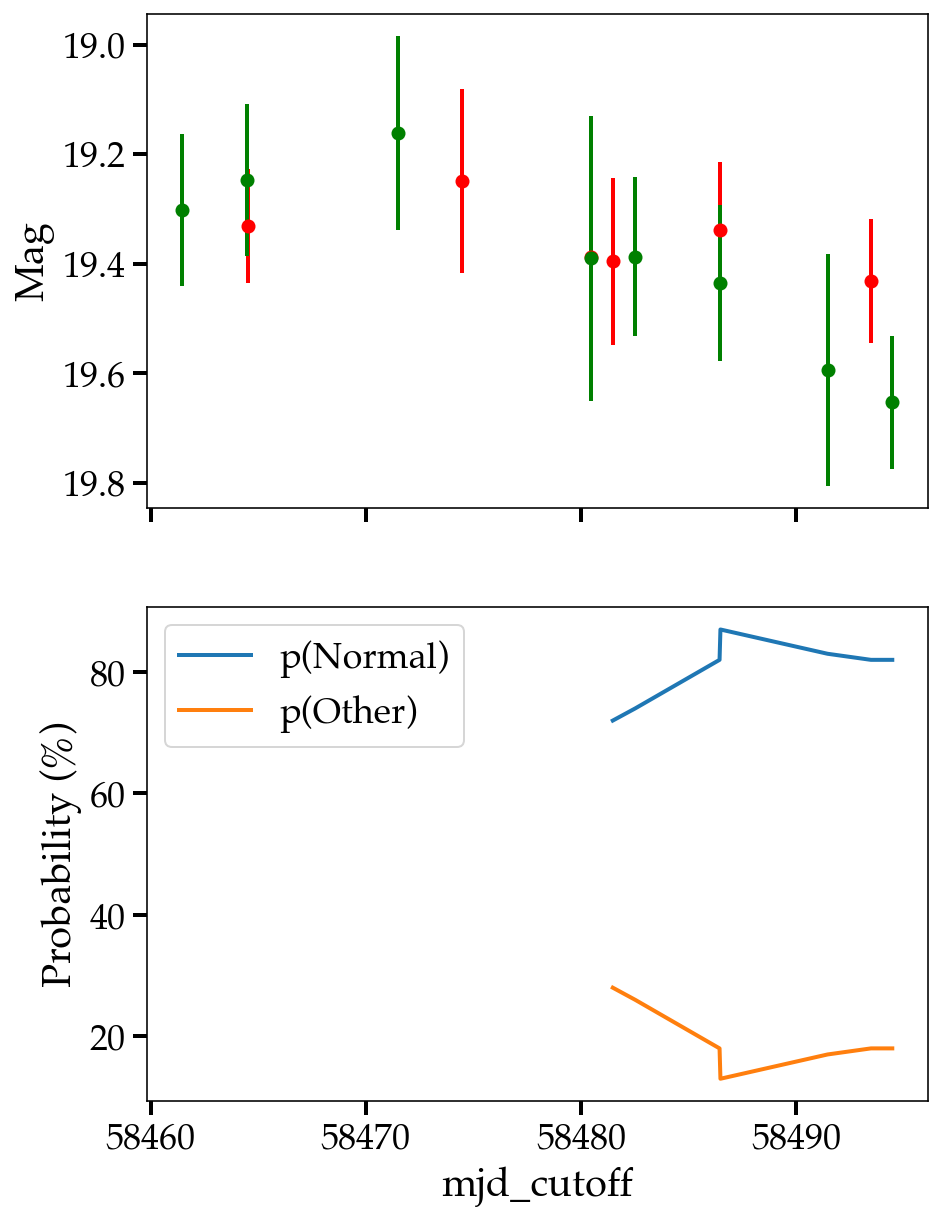

ZTF21acipqbt None
Prediction doesn't exceed anom_threshold of 50% for ZTF21acipqbt.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21acipqbt None


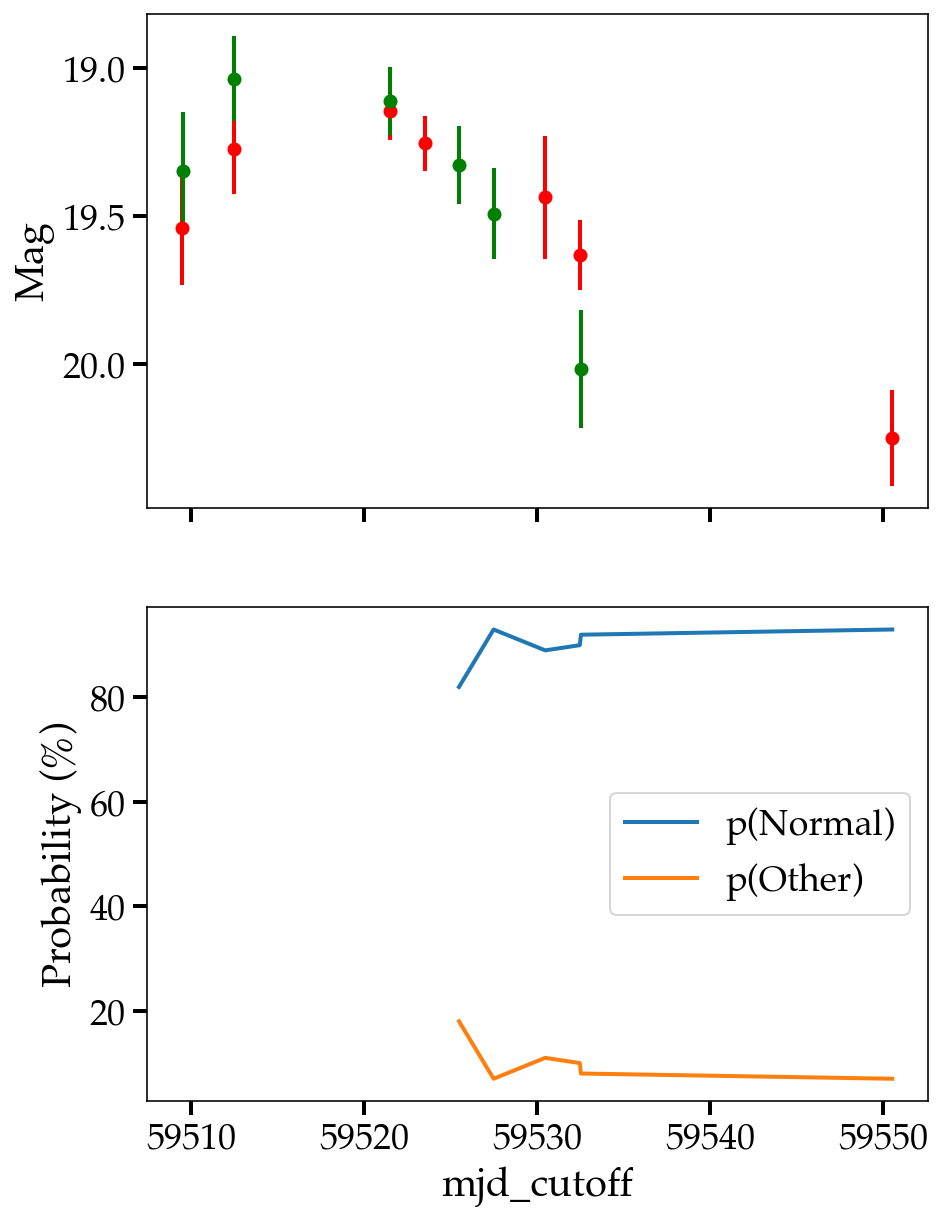

ZTF21aayddvb None
Prediction doesn't exceed anom_threshold of 50% for ZTF21aayddvb.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21aayddvb None


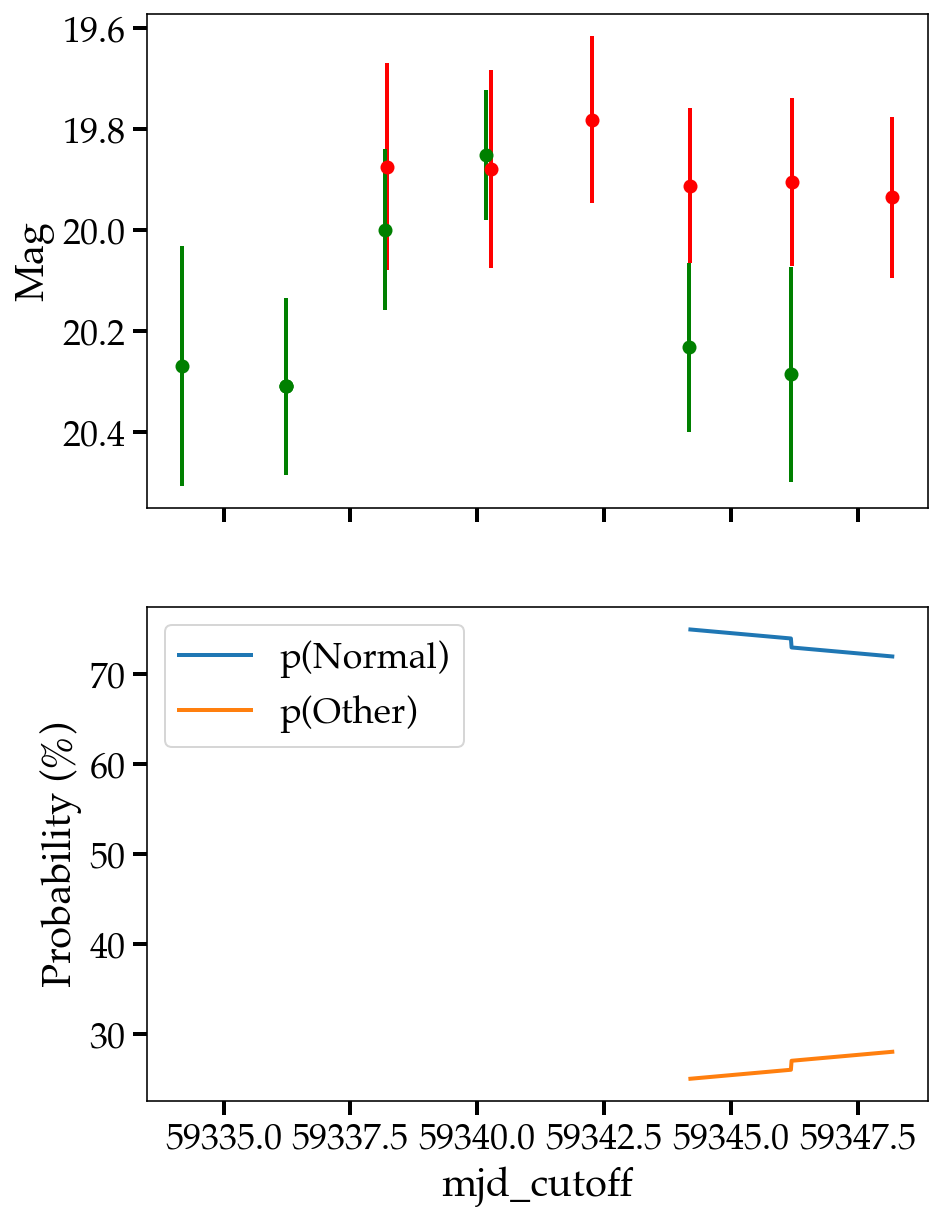

ZTF20aciuubo None
Prediction doesn't exceed anom_threshold of 50% for ZTF20aciuubo.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF20aciuubo None


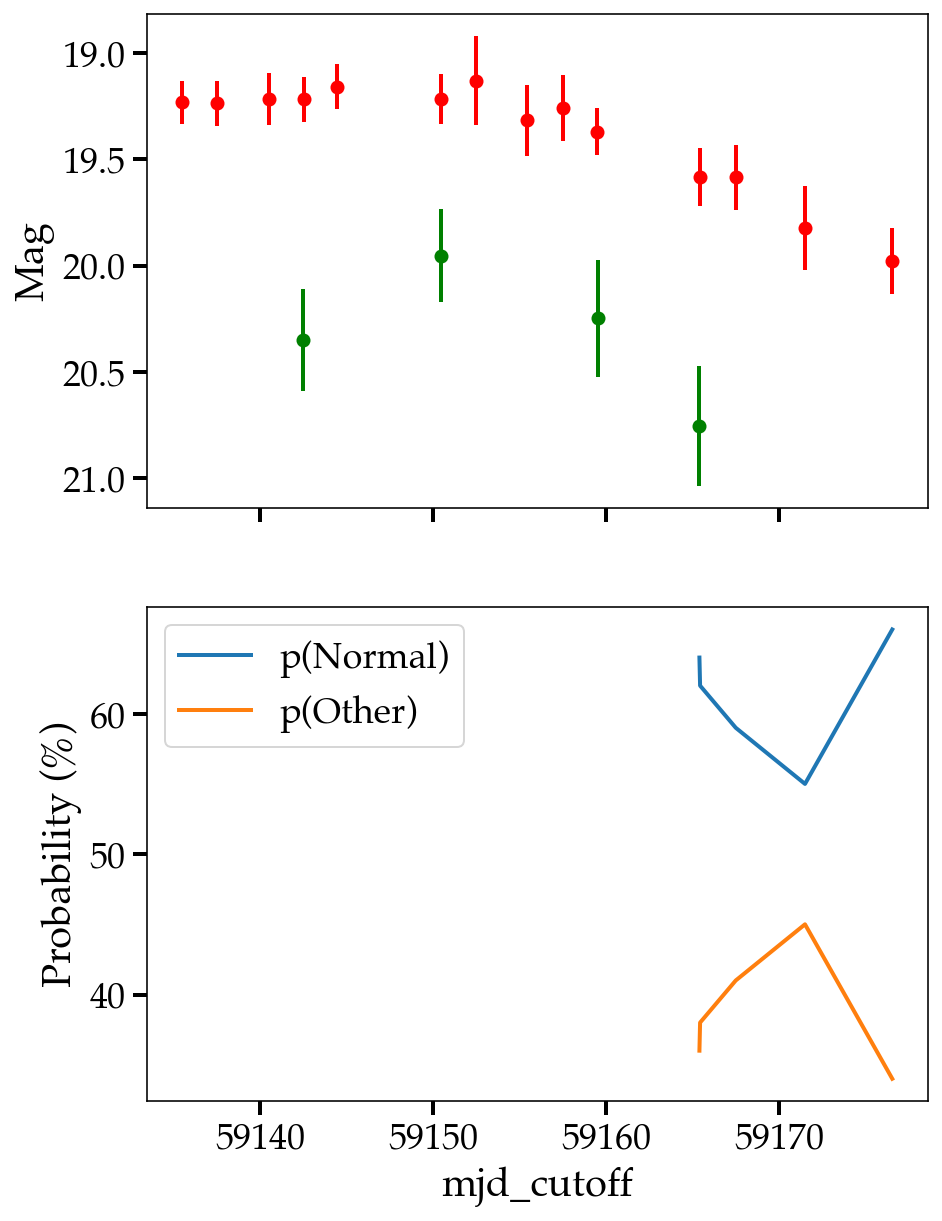

ZTF21acjvlar None
Prediction doesn't exceed anom_threshold of 50% for ZTF21acjvlar.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21acjvlar None


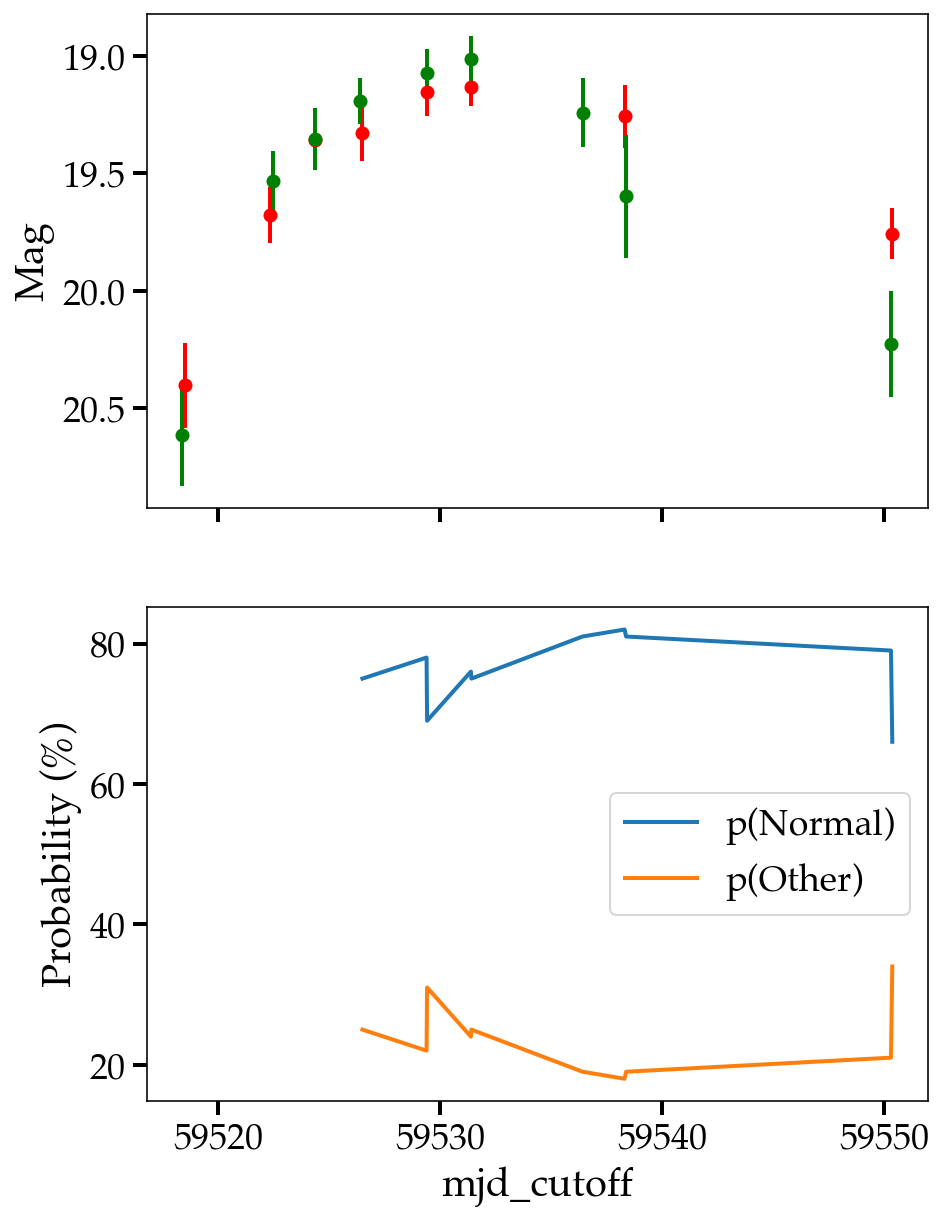

ZTF21acdqytg None
Prediction doesn't exceed anom_threshold of 50% for ZTF21acdqytg.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21acdqytg None


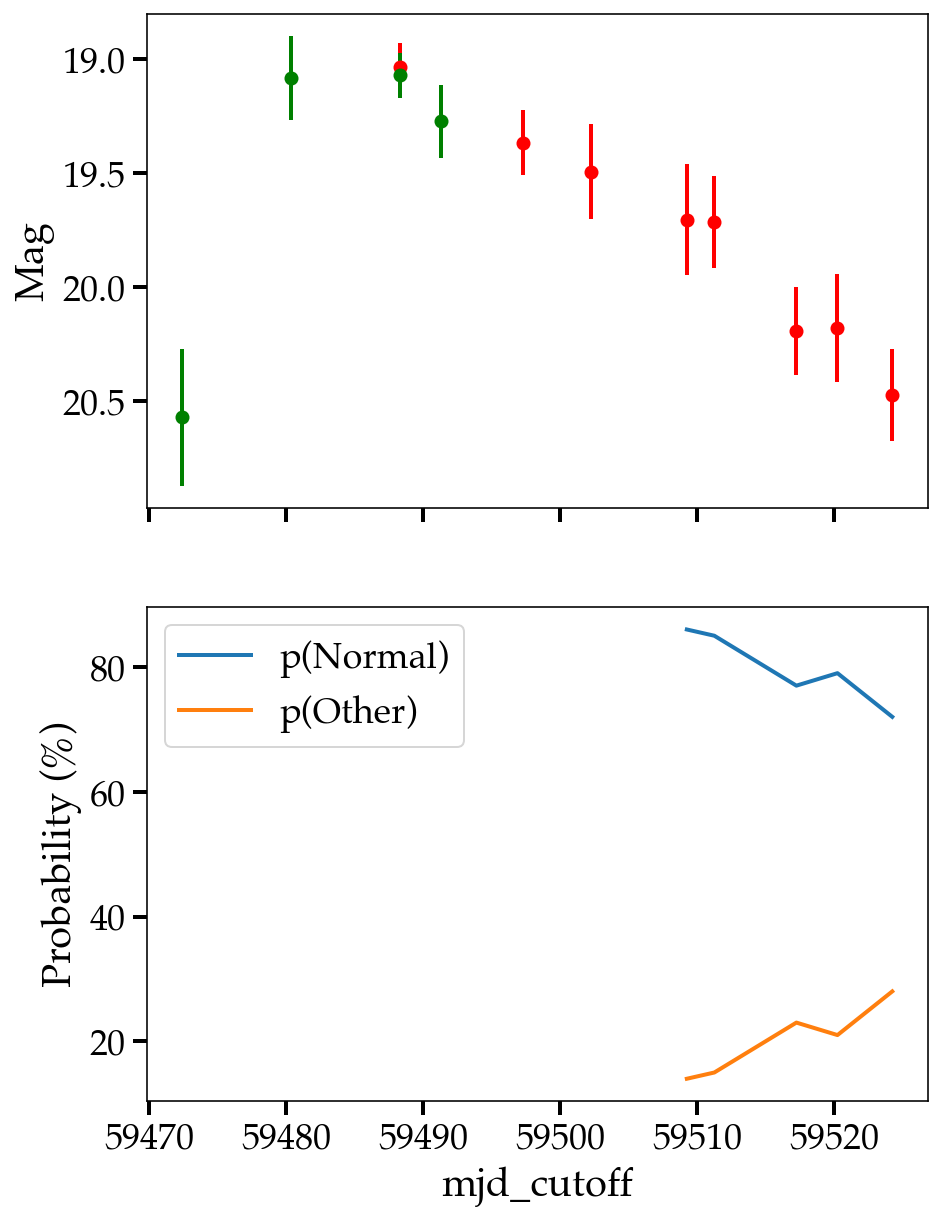

ZTF21abifsyr None
Prediction doesn't exceed anom_threshold of 50% for ZTF21abifsyr.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21abifsyr None


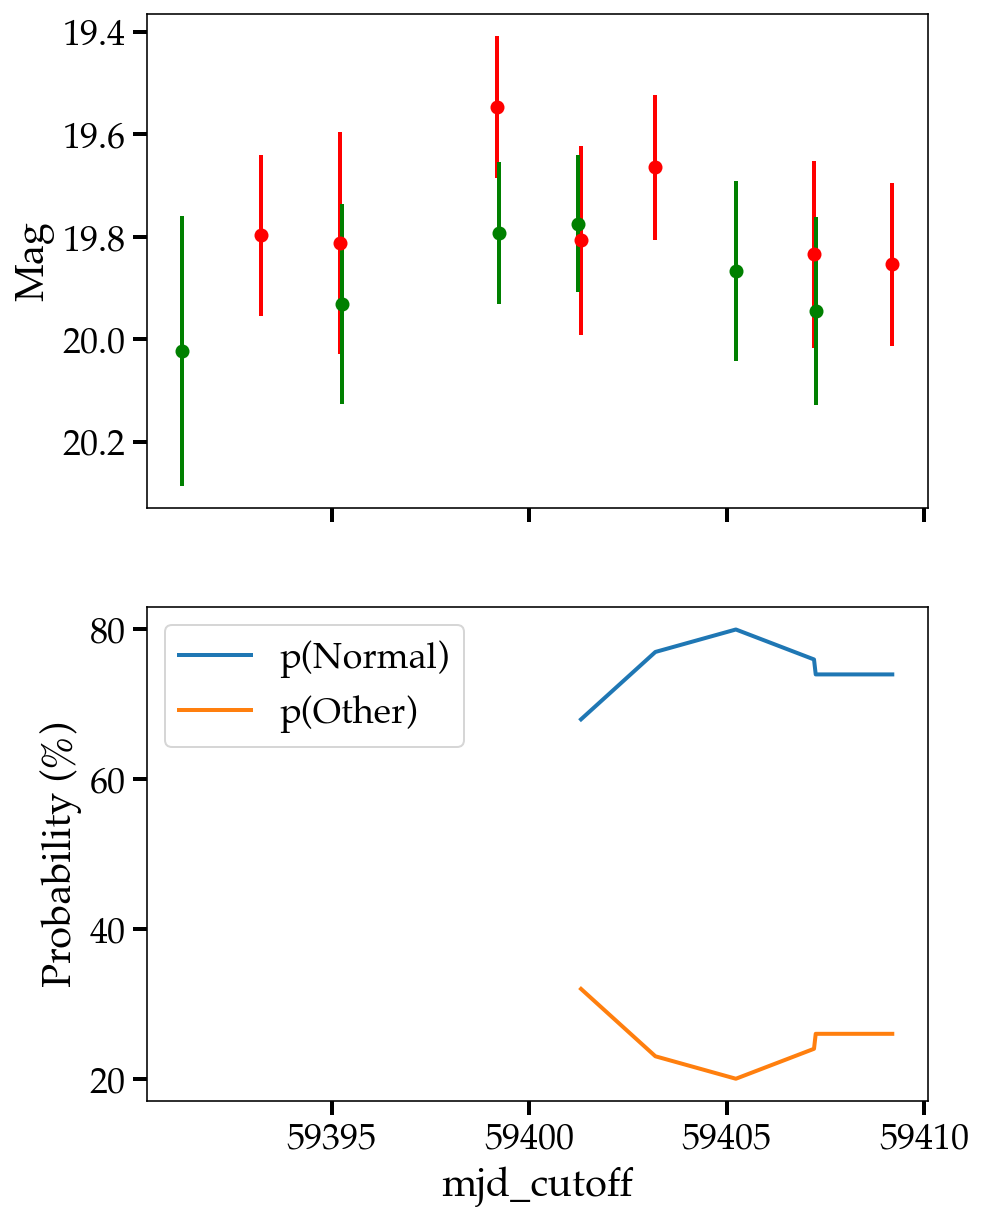

ZTF21abxnhpn None
Prediction doesn't exceed anom_threshold of 50% for ZTF21abxnhpn.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21abxnhpn None


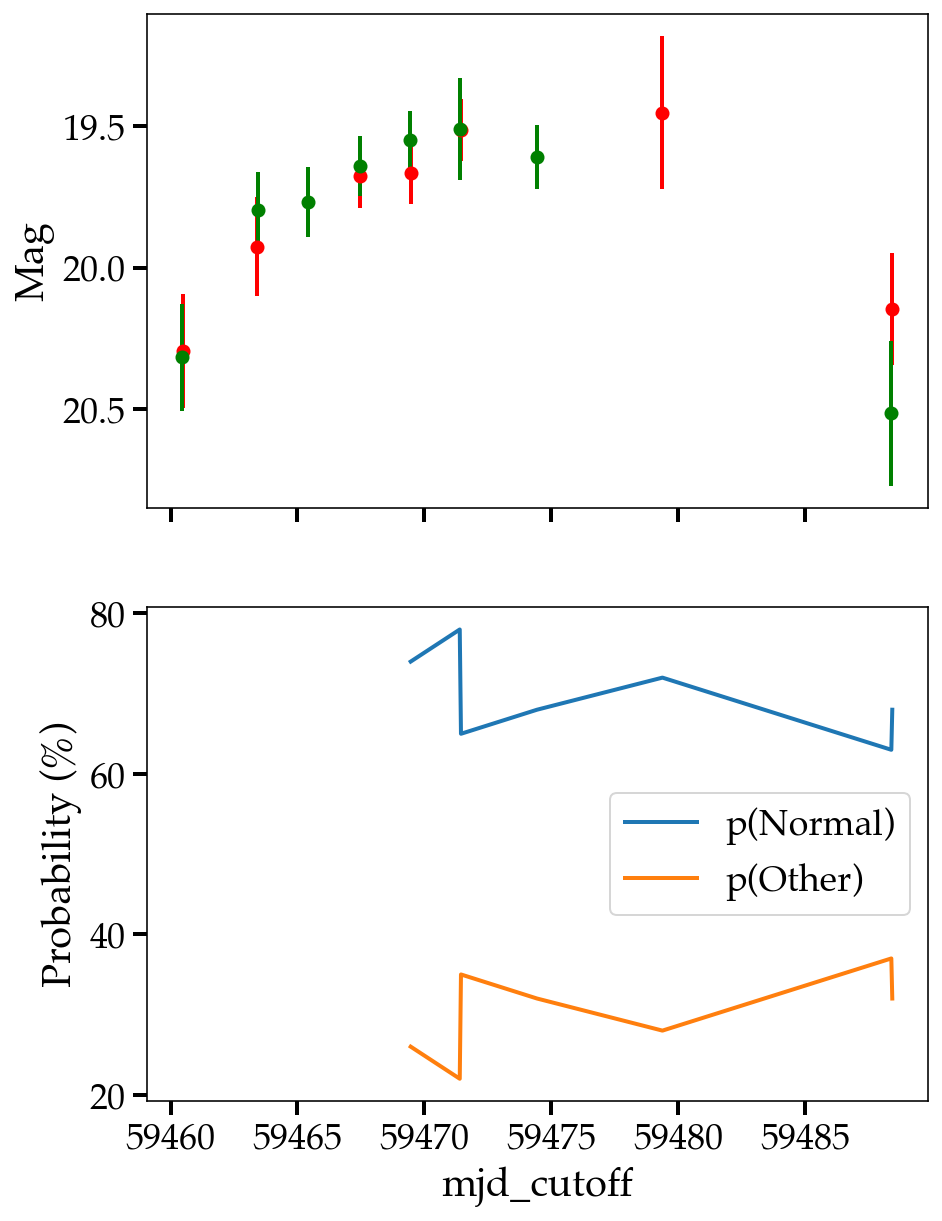

ZTF18acsyeum None
Prediction doesn't exceed anom_threshold of 50% for ZTF18acsyeum.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF18acsyeum None


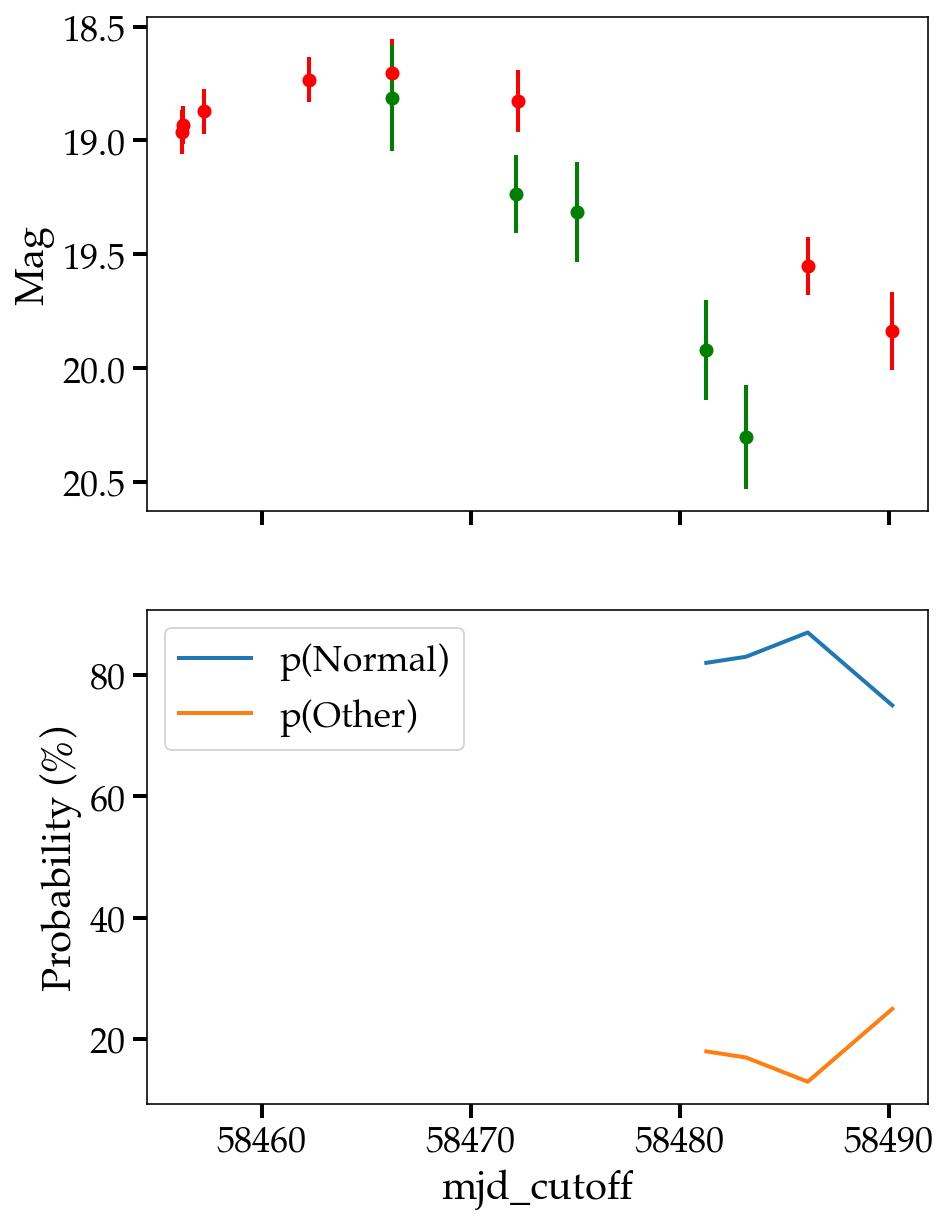

ZTF21aazcwiz None
Prediction doesn't exceed anom_threshold of 50% for ZTF21aazcwiz.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21aazcwiz None


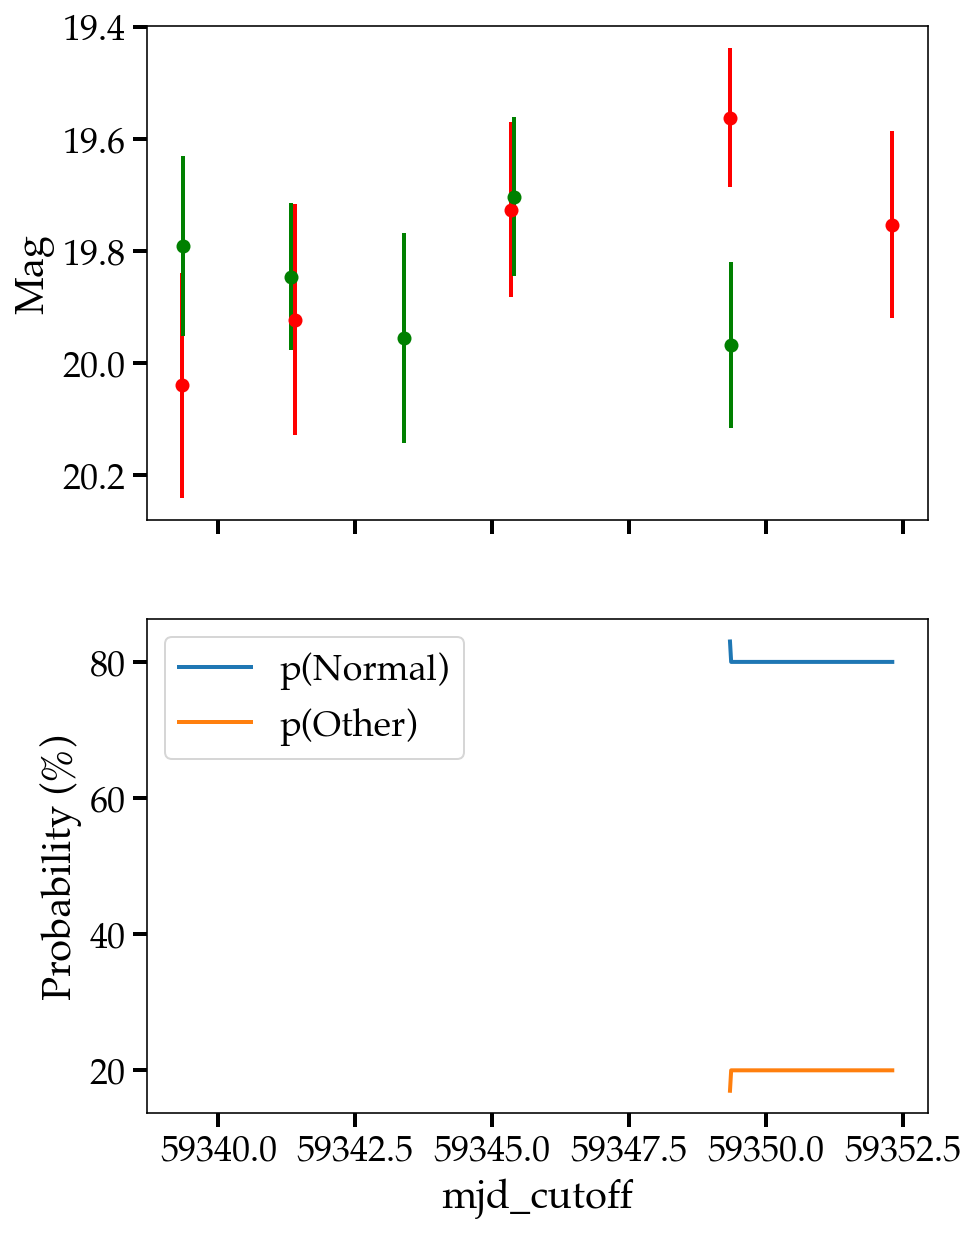

ZTF21abwulai None
Prediction doesn't exceed anom_threshold of 50% for ZTF21abwulai.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


3
https://alerce.online/object/ZTF21abwulai None


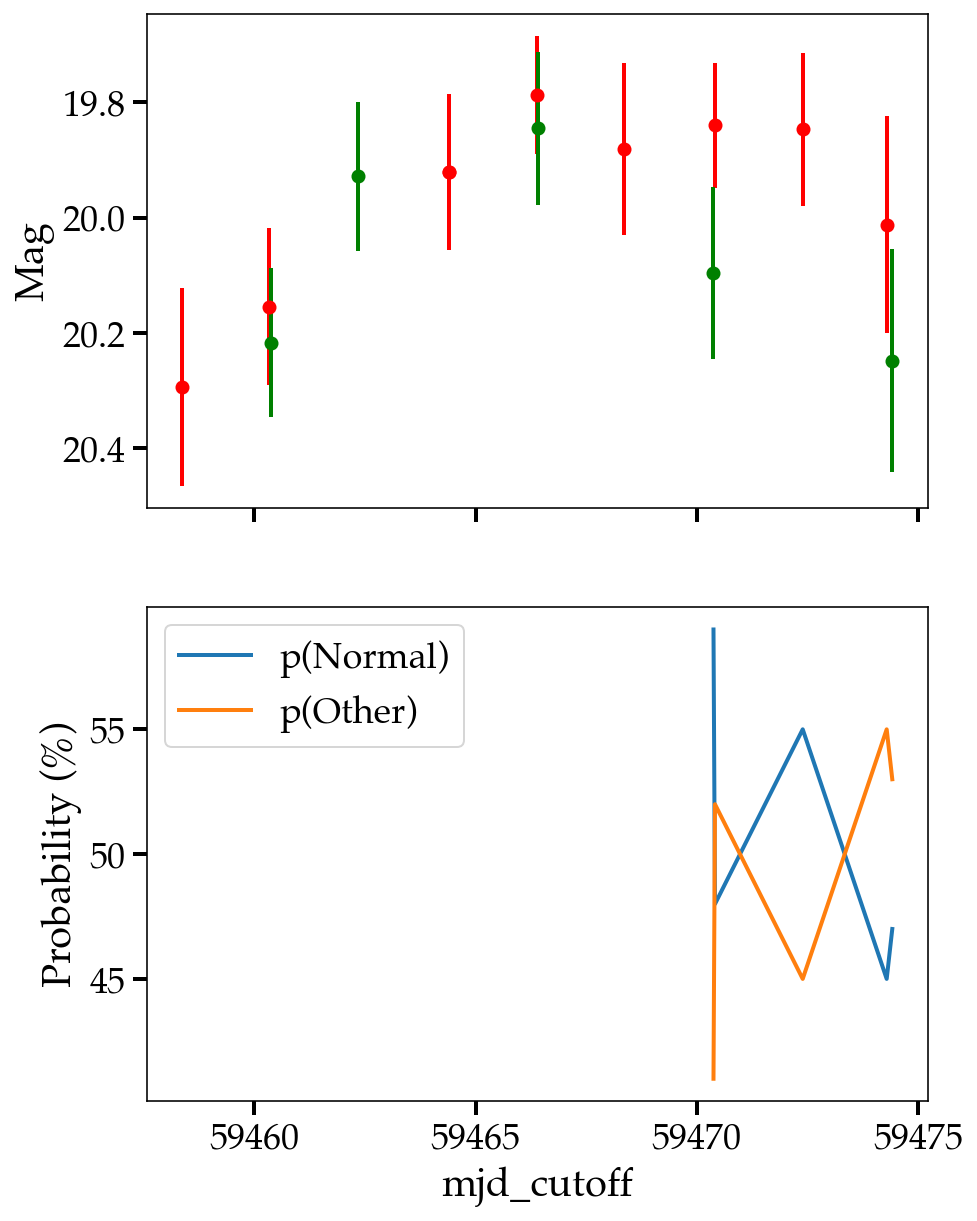

ZTF21aapfowm None
Prediction doesn't exceed anom_threshold of 50% for ZTF21aapfowm.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21aapfowm None


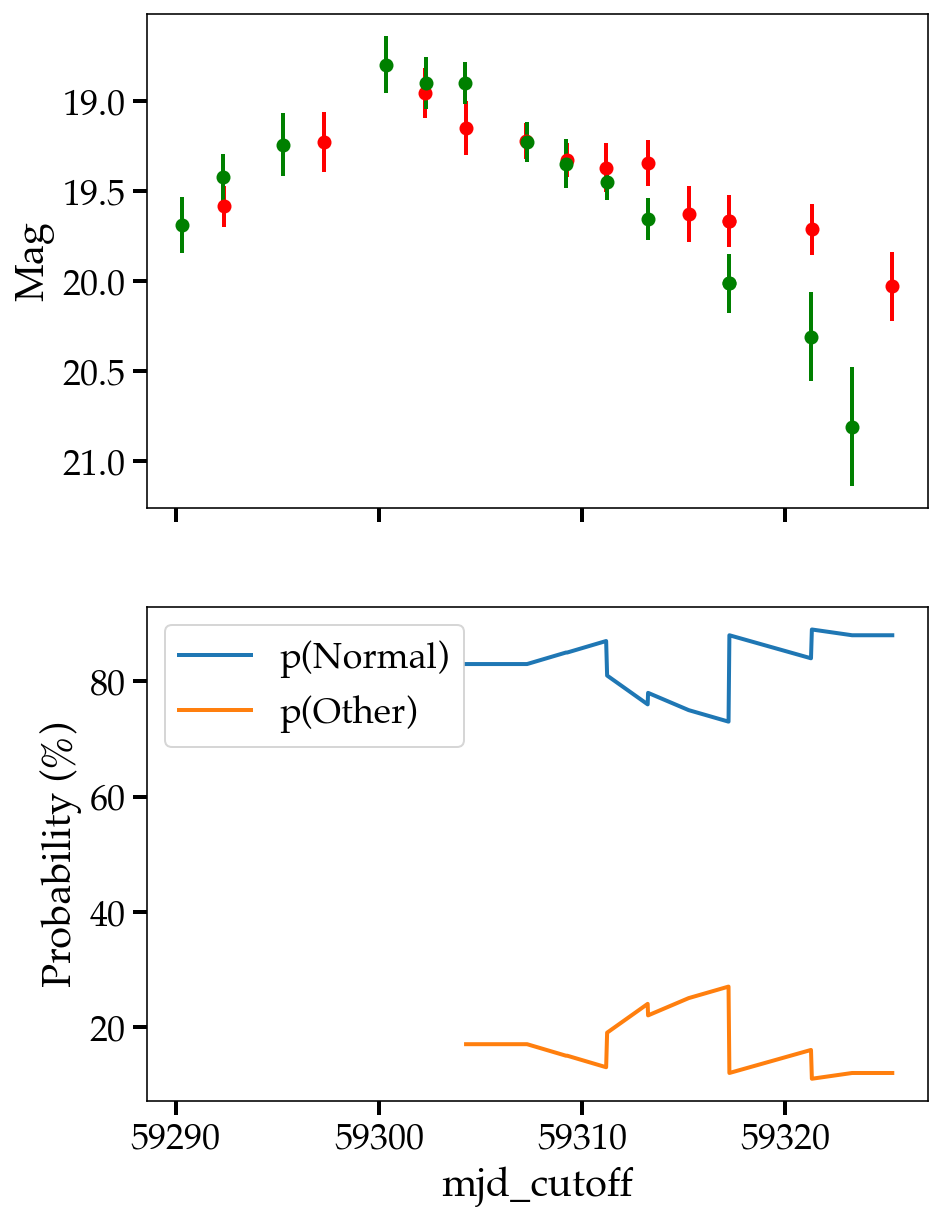

ZTF18adbadiw None
Prediction doesn't exceed anom_threshold of 50% for ZTF18adbadiw.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF18adbadiw None


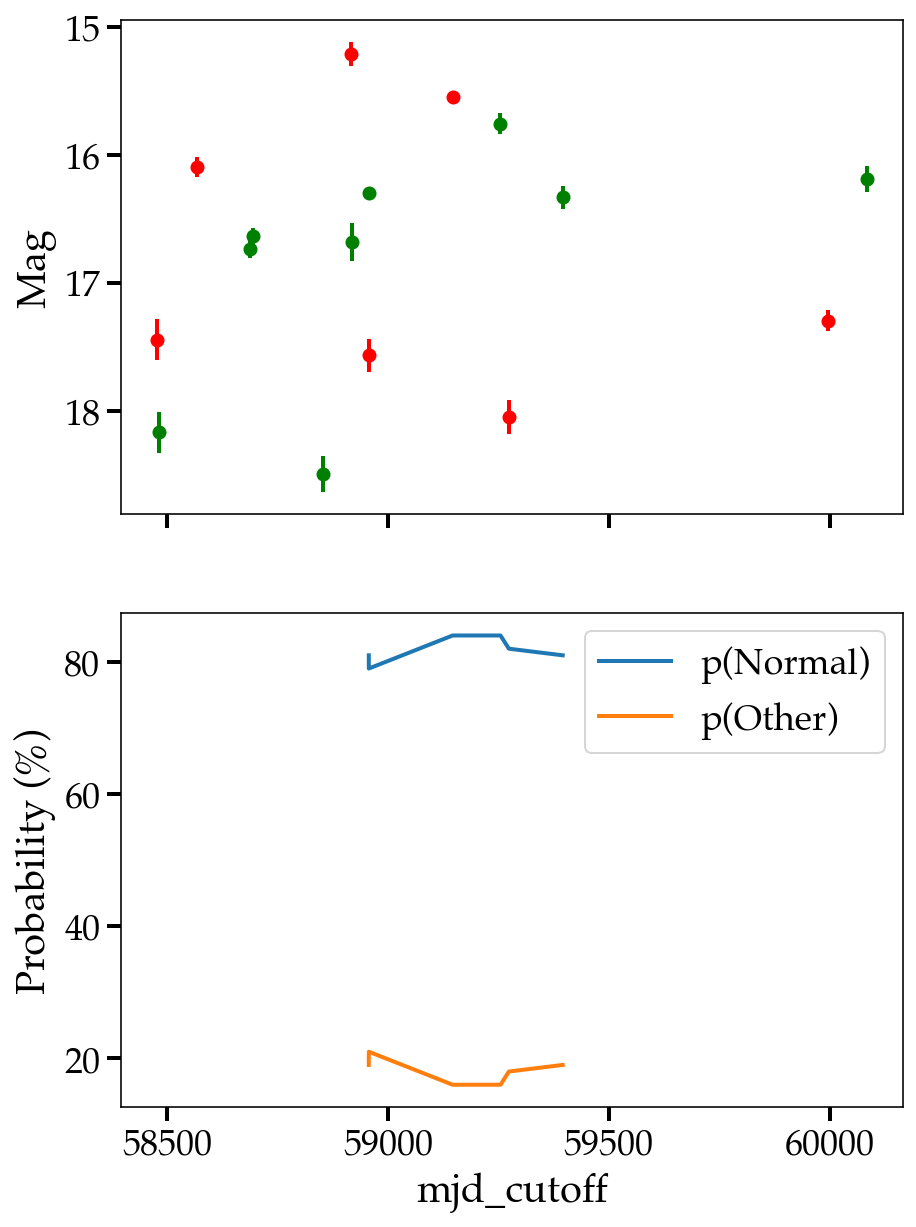

ZTF19aafllhf None
Prediction doesn't exceed anom_threshold of 50% for ZTF19aafllhf.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


3
https://alerce.online/object/ZTF19aafllhf None


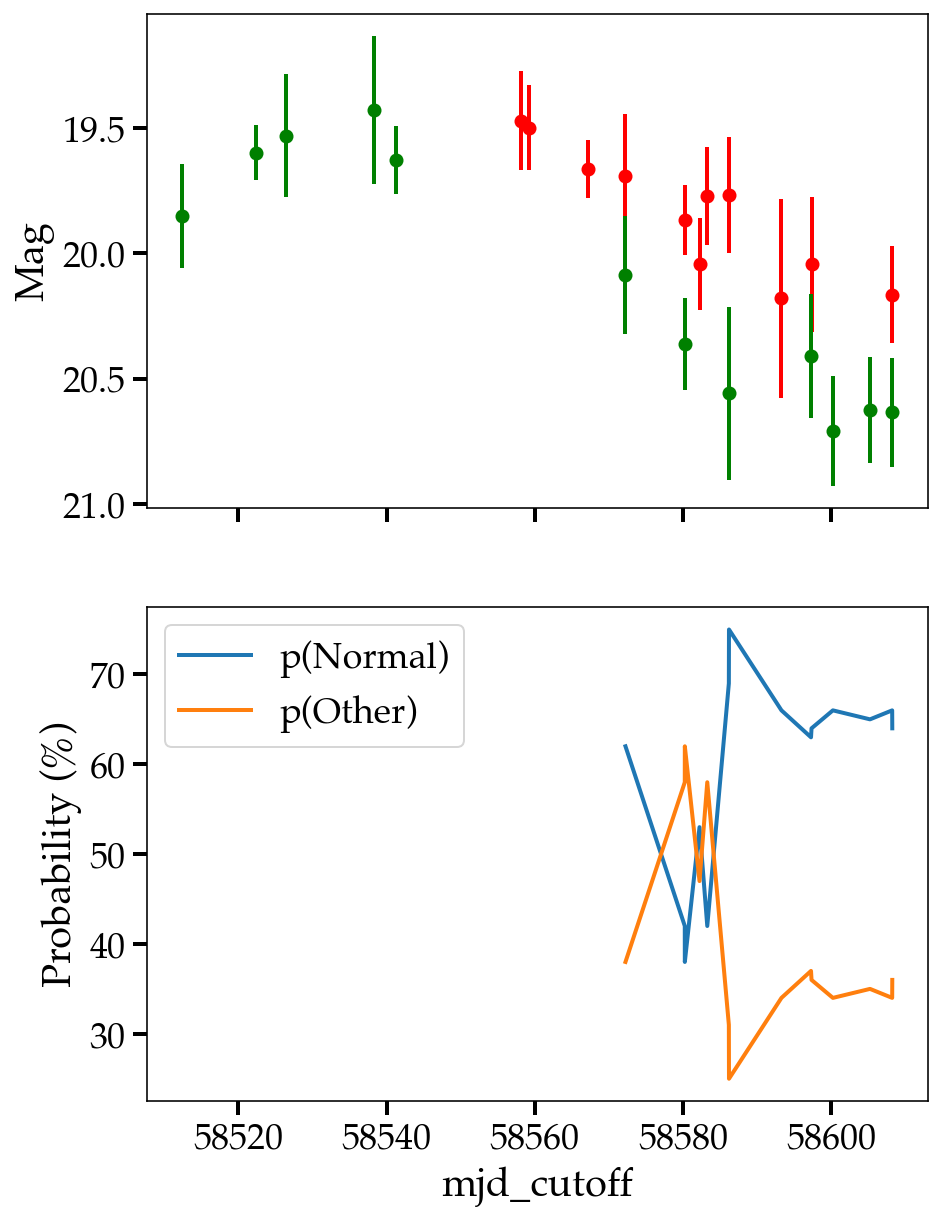

ZTF18aczzwjf None
Prediction doesn't exceed anom_threshold of 50% for ZTF18aczzwjf.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF18aczzwjf None


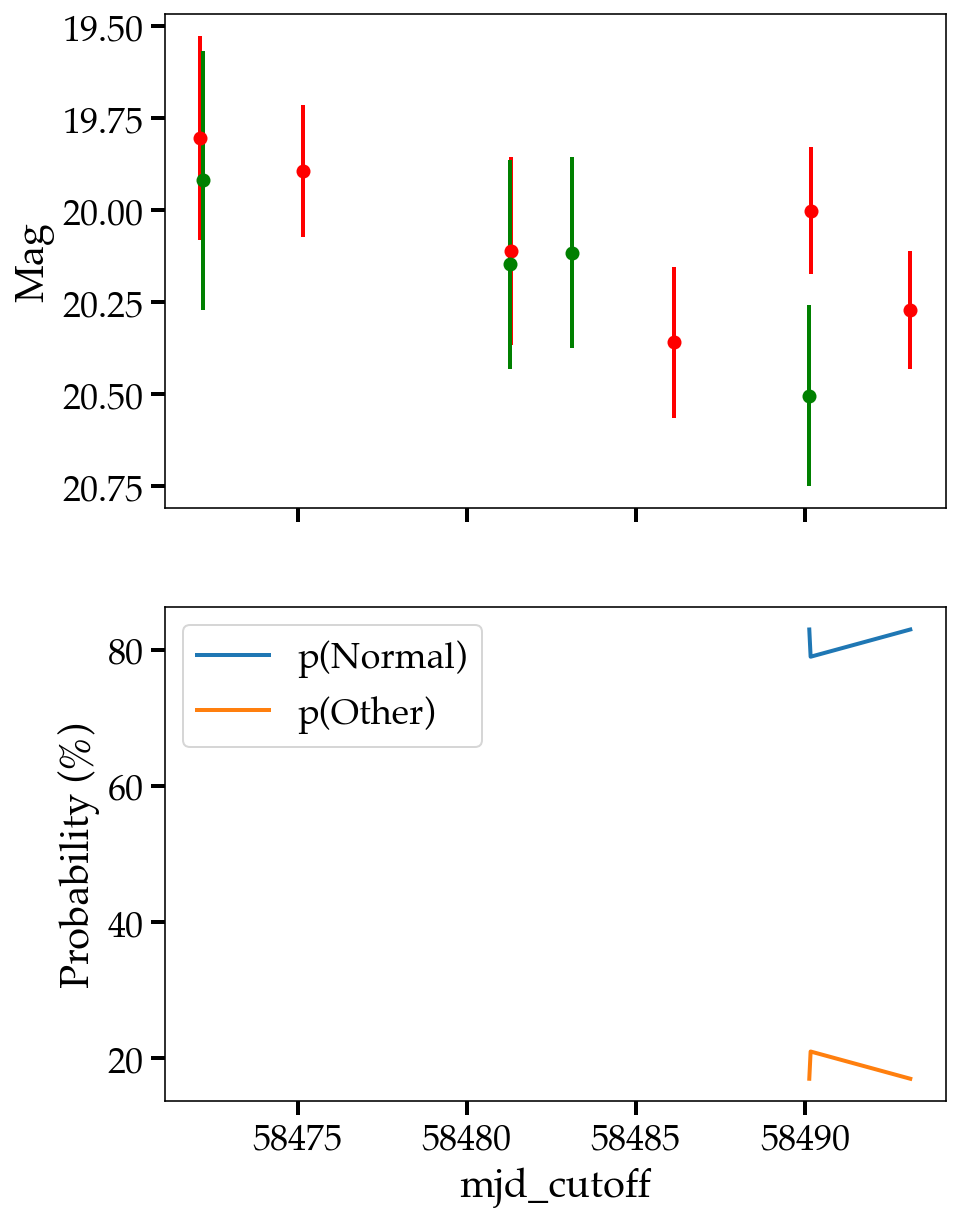

ZTF21acfixmg None
Prediction doesn't exceed anom_threshold of 50% for ZTF21acfixmg.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21acfixmg None


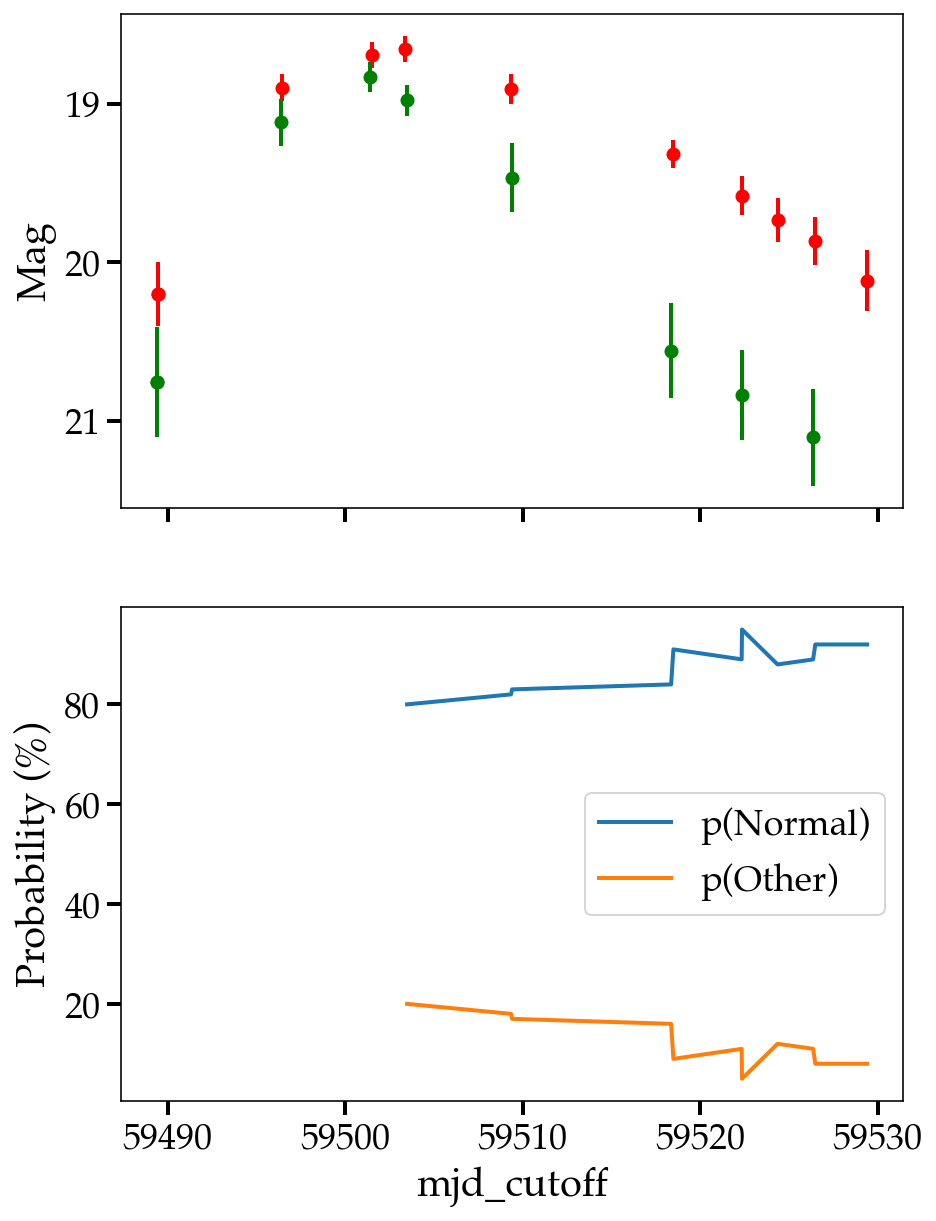

ZTF21acjkcsk None
Prediction doesn't exceed anom_threshold of 50% for ZTF21acjkcsk.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21acjkcsk None


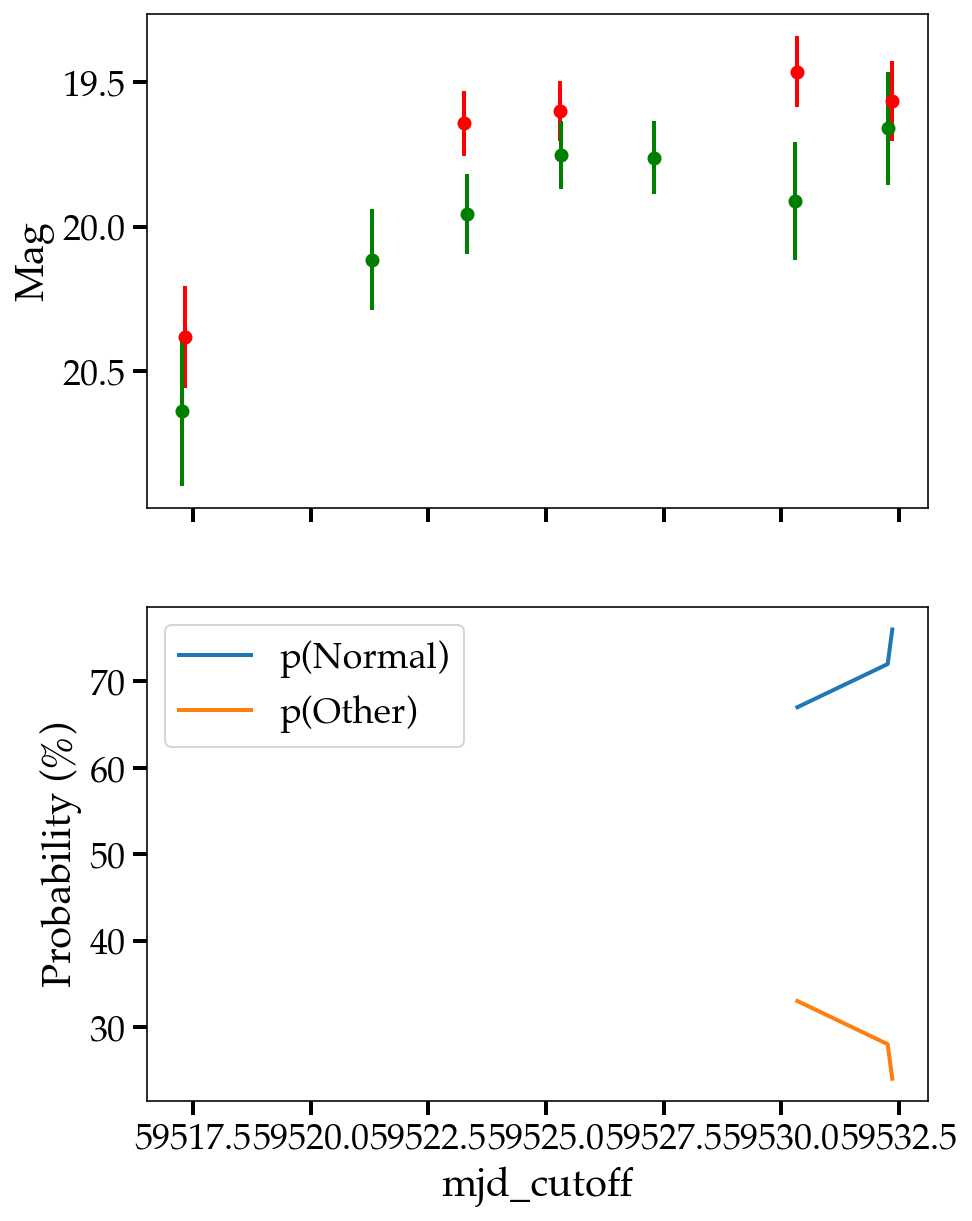

ZTF21ackoixz None
Prediction doesn't exceed anom_threshold of 50% for ZTF21ackoixz.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21ackoixz None


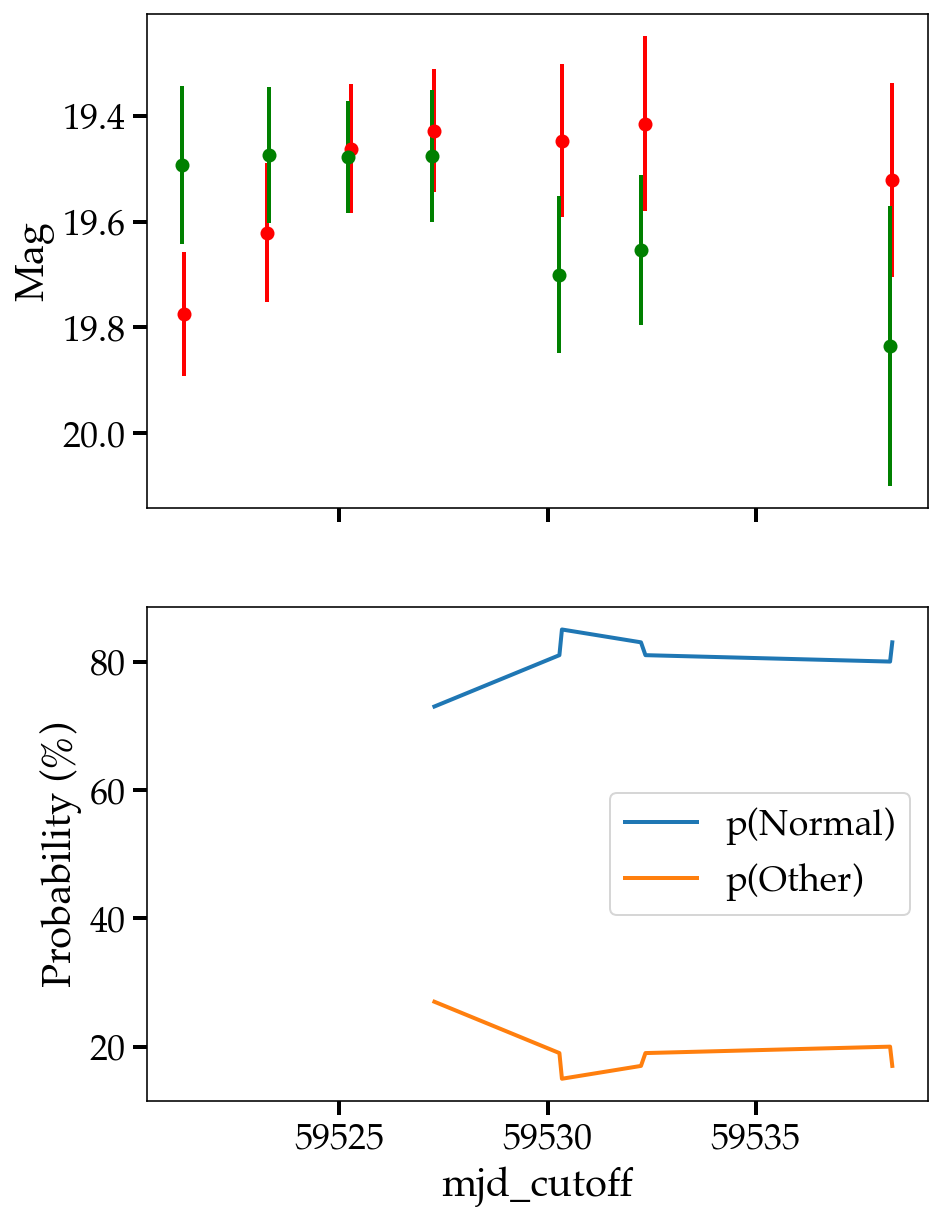

ZTF19aailczw None


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


60
https://alerce.online/object/ZTF19aailczw None


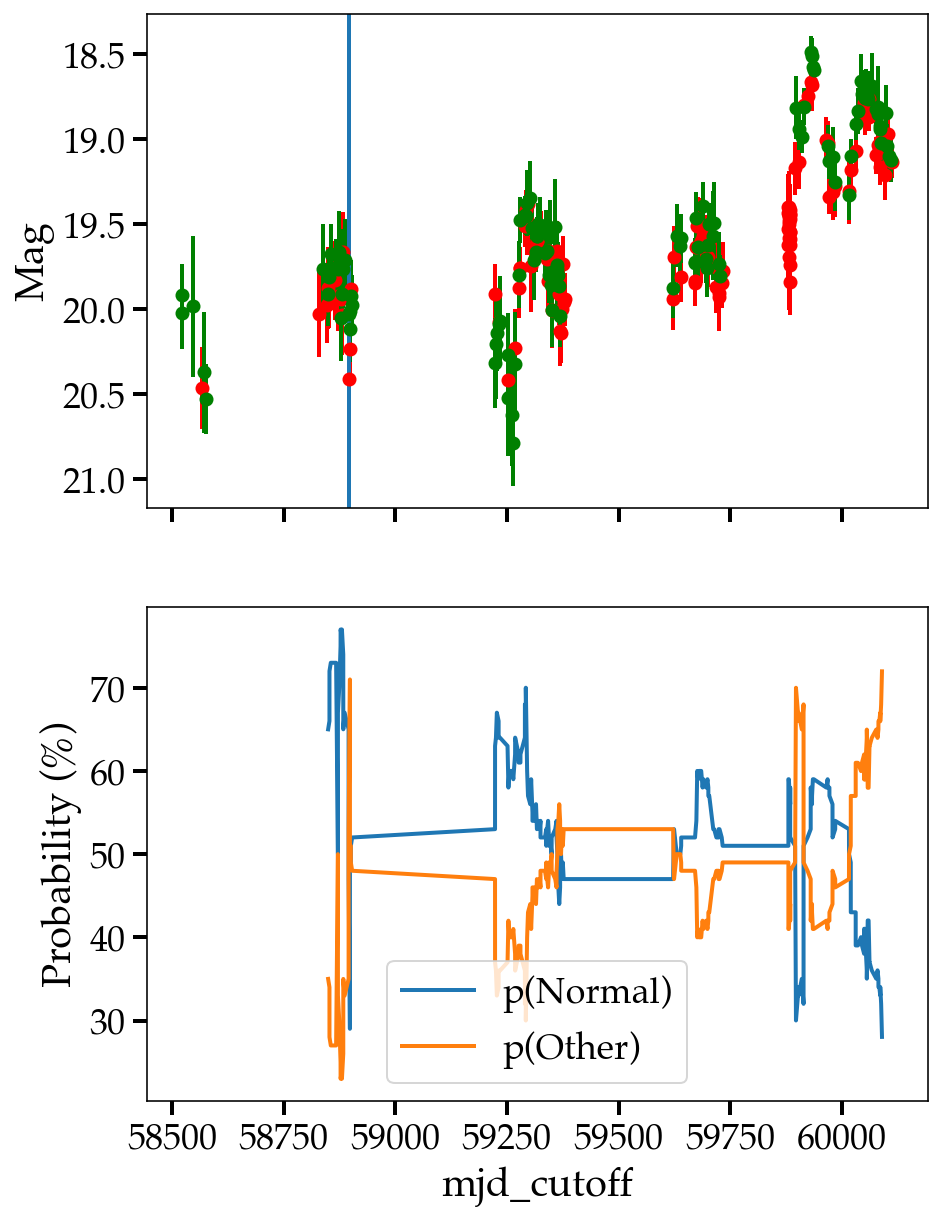

ZTF19aabyuzq None
Prediction doesn't exceed anom_threshold of 50% for ZTF19aabyuzq.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF19aabyuzq None


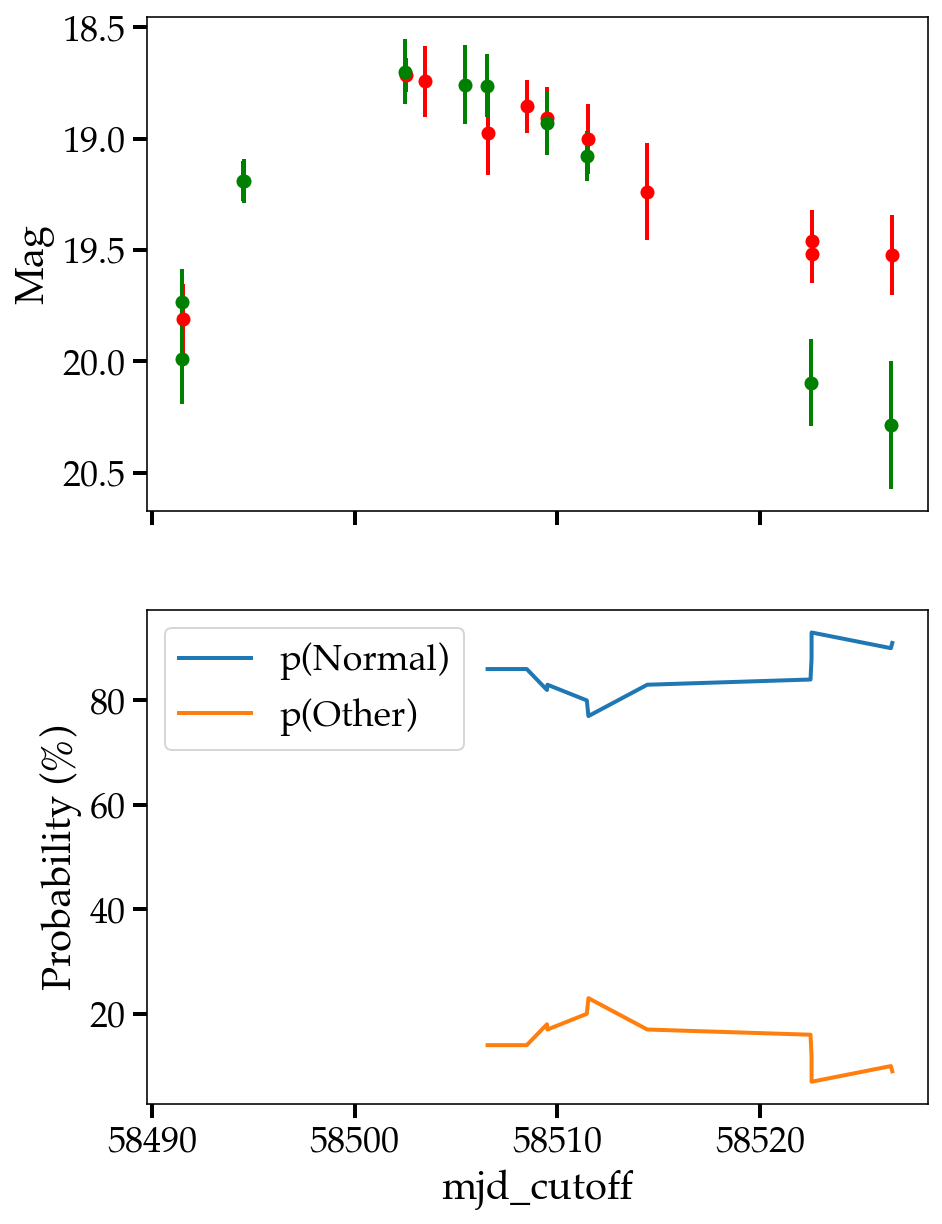

ZTF21abizhud None
Prediction doesn't exceed anom_threshold of 50% for ZTF21abizhud.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21abizhud None


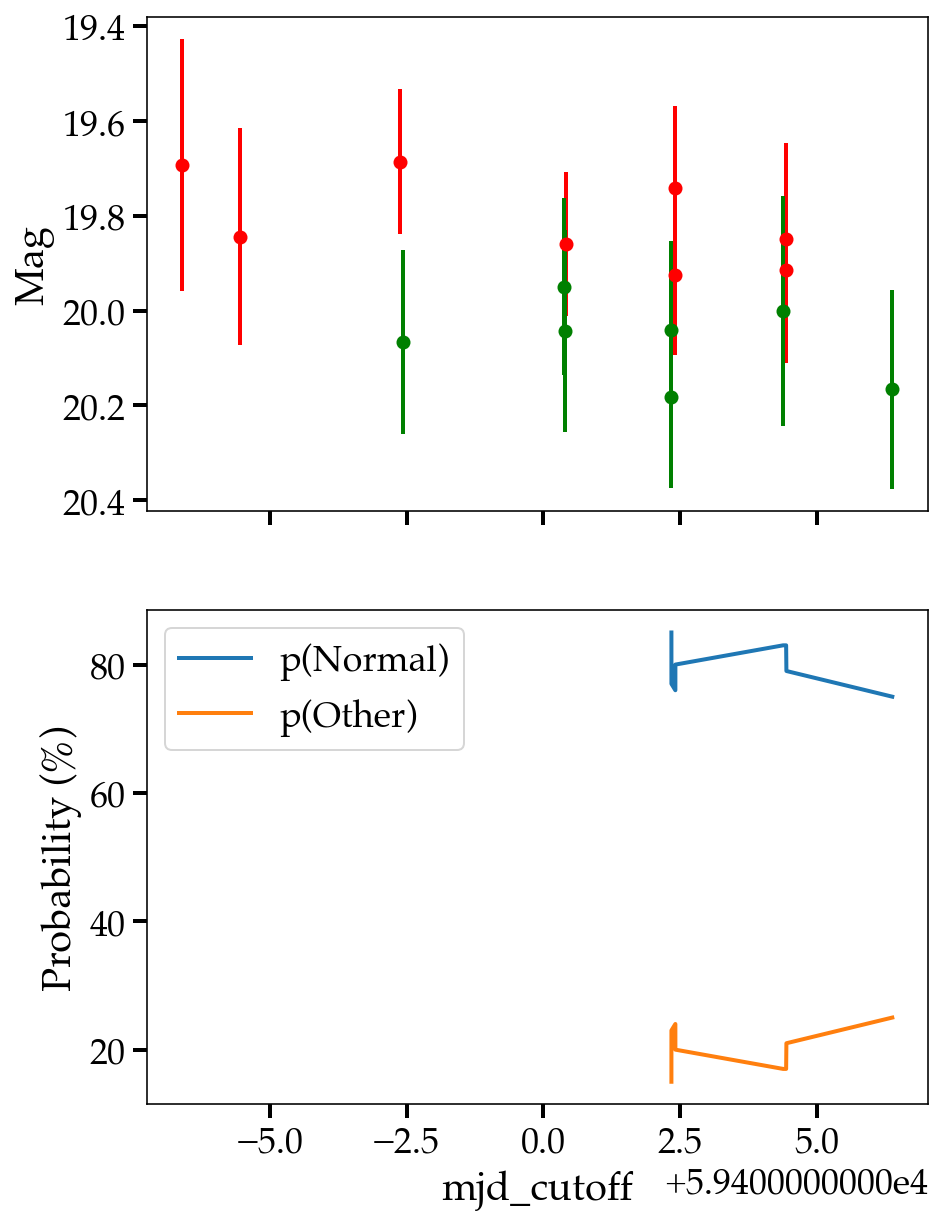

ZTF21abmdcfm None


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


4
https://alerce.online/object/ZTF21abmdcfm None


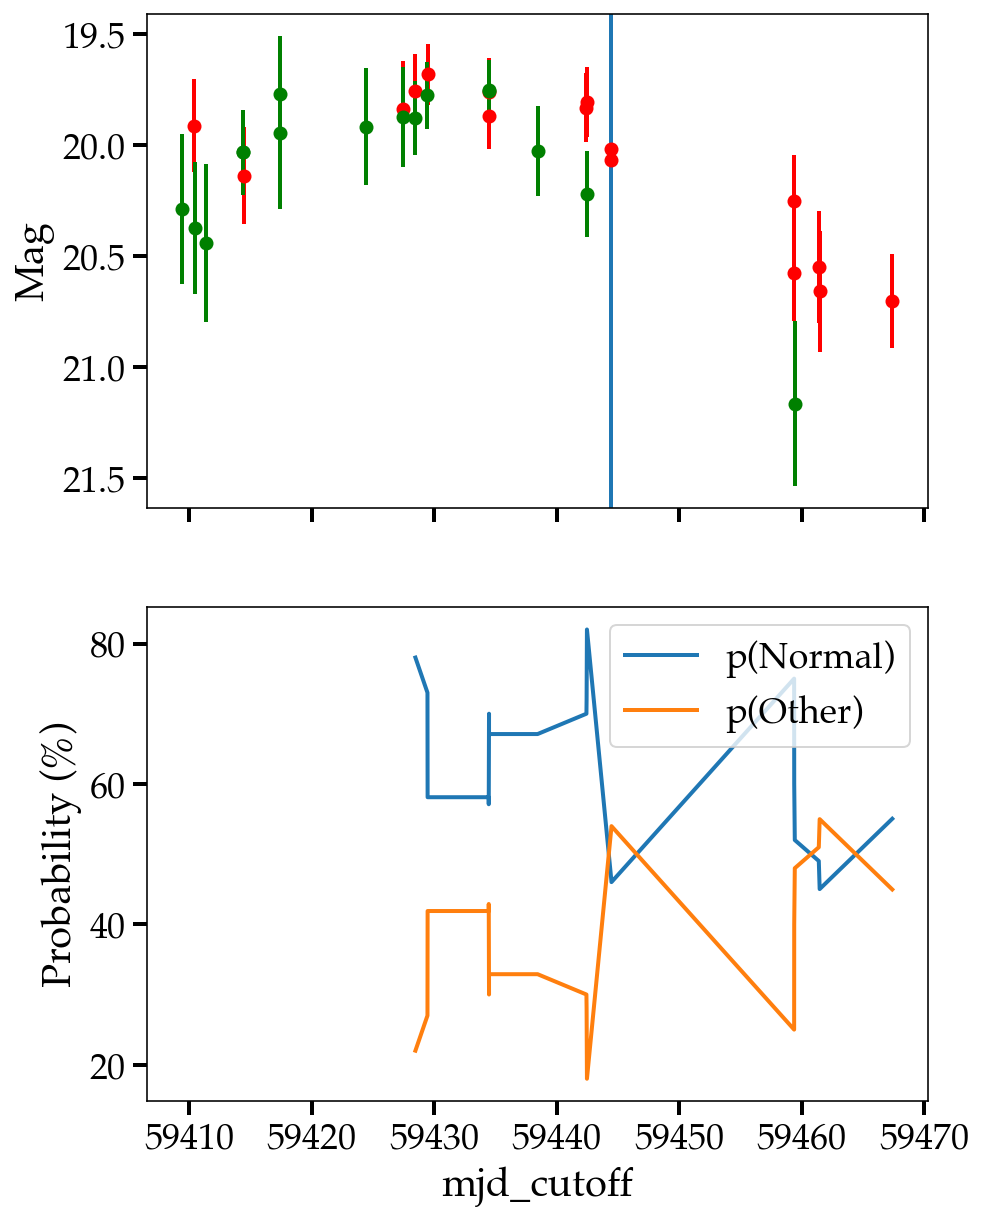

ZTF20aadynoq None
Prediction doesn't exceed anom_threshold of 50% for ZTF20aadynoq.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF20aadynoq None


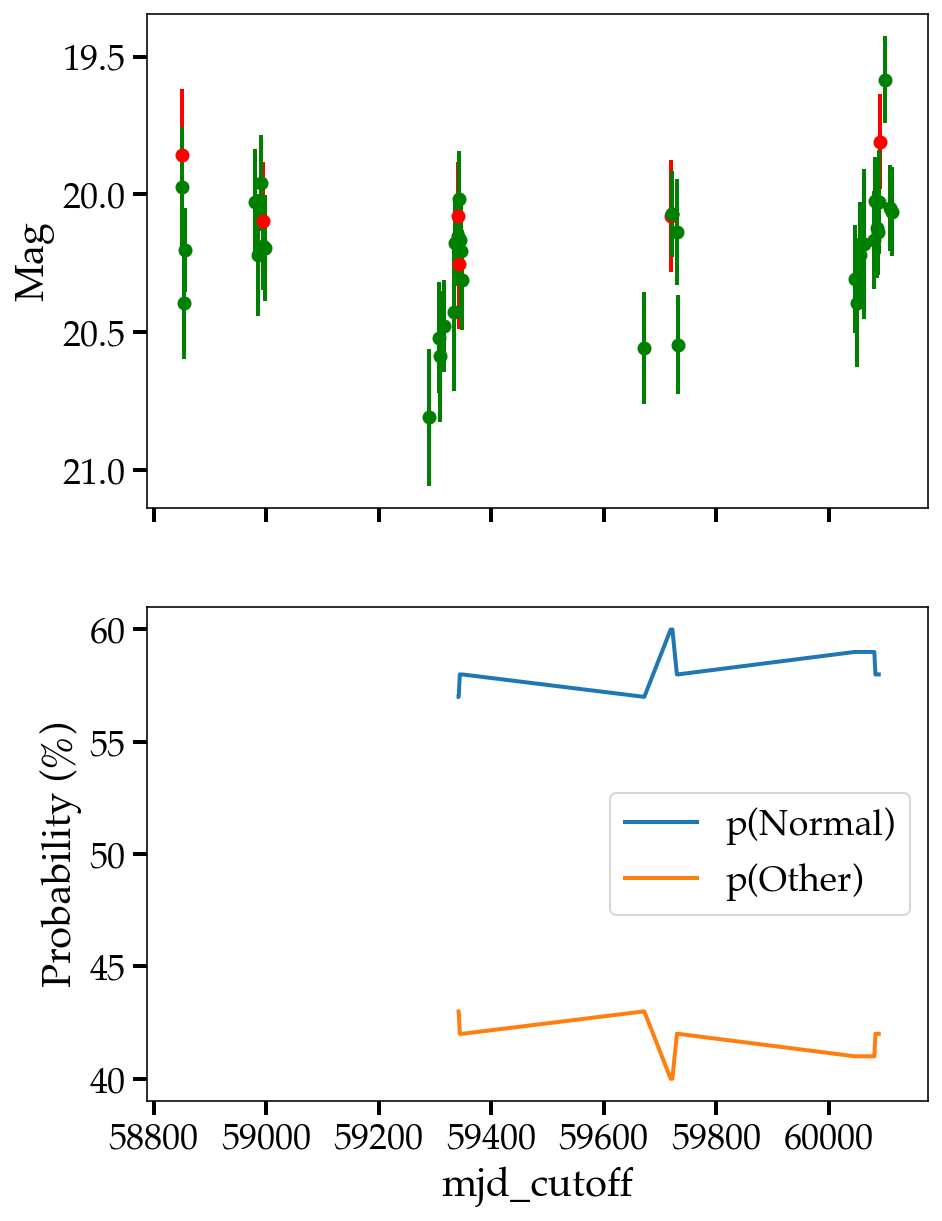

ZTF21abotogu None
Prediction doesn't exceed anom_threshold of 50% for ZTF21abotogu.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


0
https://alerce.online/object/ZTF21abotogu None


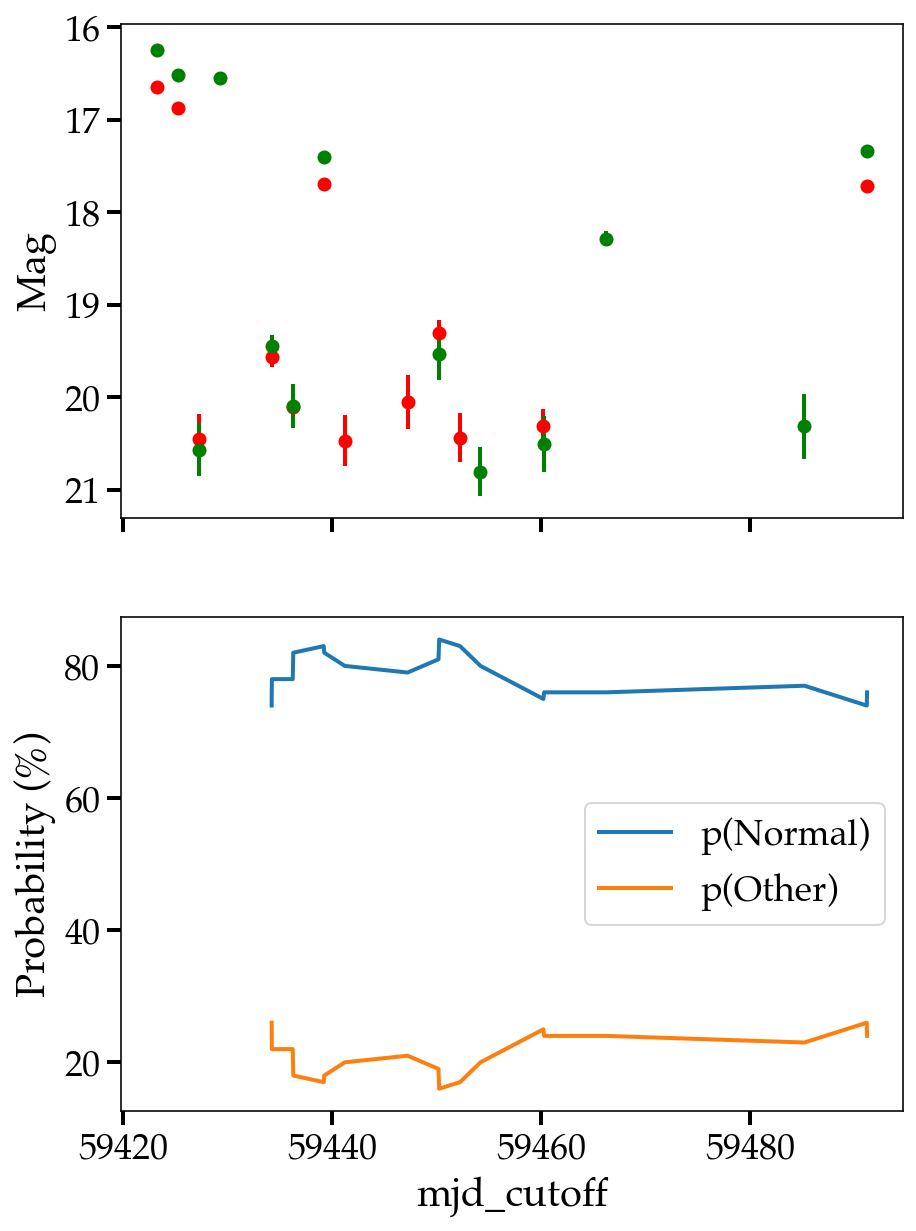

ZTF22aaajail None


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


5
https://alerce.online/object/ZTF22aaajail None


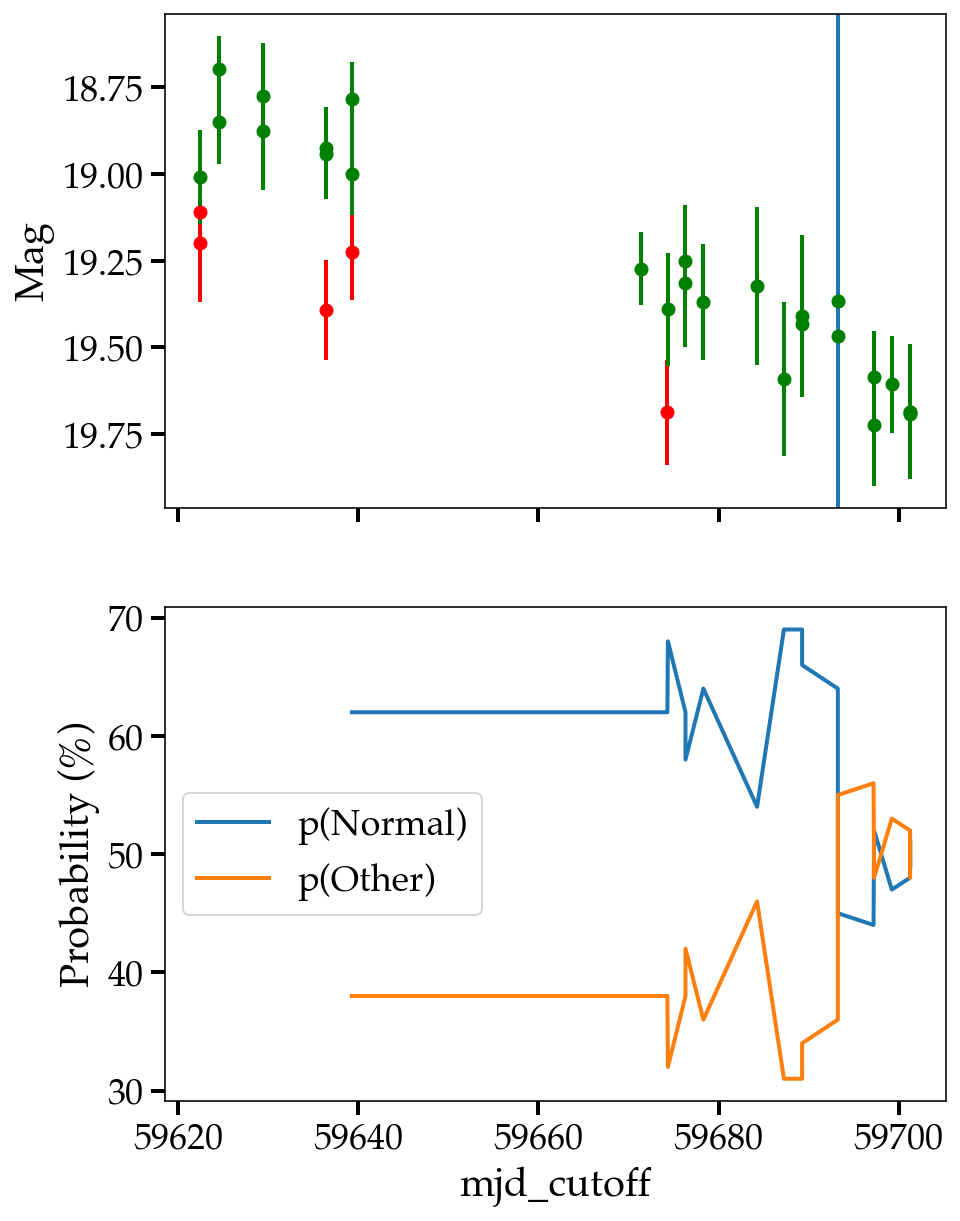

In [84]:
plot_RFC_prob_vs_lc(dataframe=x_test_phot.iloc[900:925:, :], anom_thresh=50)

#### robust to stars and most bogus except AGN.

# Missed TDE?? --> to check with Sebastian

https://alerce.online/object/ZTF20acpmojv 2020zev: (shame b/c would've tagged early too)
https://alerce.online/object/ZTF21abownod 2021ugf: either very blue Ia or TDE
https://alerce.online/object/ZTF21aazqmfh 2021stx: TDE, maybe SLSN
https://alerce.online/object/ZTF21aazenvp 2021ovg: ""

# Other interesting ones (not all encompassing)

https://alerce.online/object/ZTF18aazydub prob SLSN from SNAD120
https://alerce.online/object/ZTF20acphjfv  High z SN Ia w/ LSB host?
https://alerce.online/object/ZTF21aalhtgv 2021fao: Missed SLSN
https://alerce.online/object/ZTF20acpiesv 2020zoj (YSE): SN II/ IIn (Abs mag ~ -19.5 mag) that lasted 180d
https://alerce.online/object/ZTF21aagpdzy 2021bvl: missed SN Ibc
https://alerce.online/object/ZTF20actkqax: missed SLSN (and not reported?)
https://alerce.online/object/ZTF21aaeotnn 2021asj: prob slsn
https://alerce.online/object/ZTF21aaygekw 2021lhi (YSE): missed SLSN

In [54]:
# (for Non-latent space input) TDE like FLEET works, not SN Ib, SN Ic, SLSN-II...

# custom anomalous objects outside of test set

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


https://alerce.online/object/ZTF22aaezyos


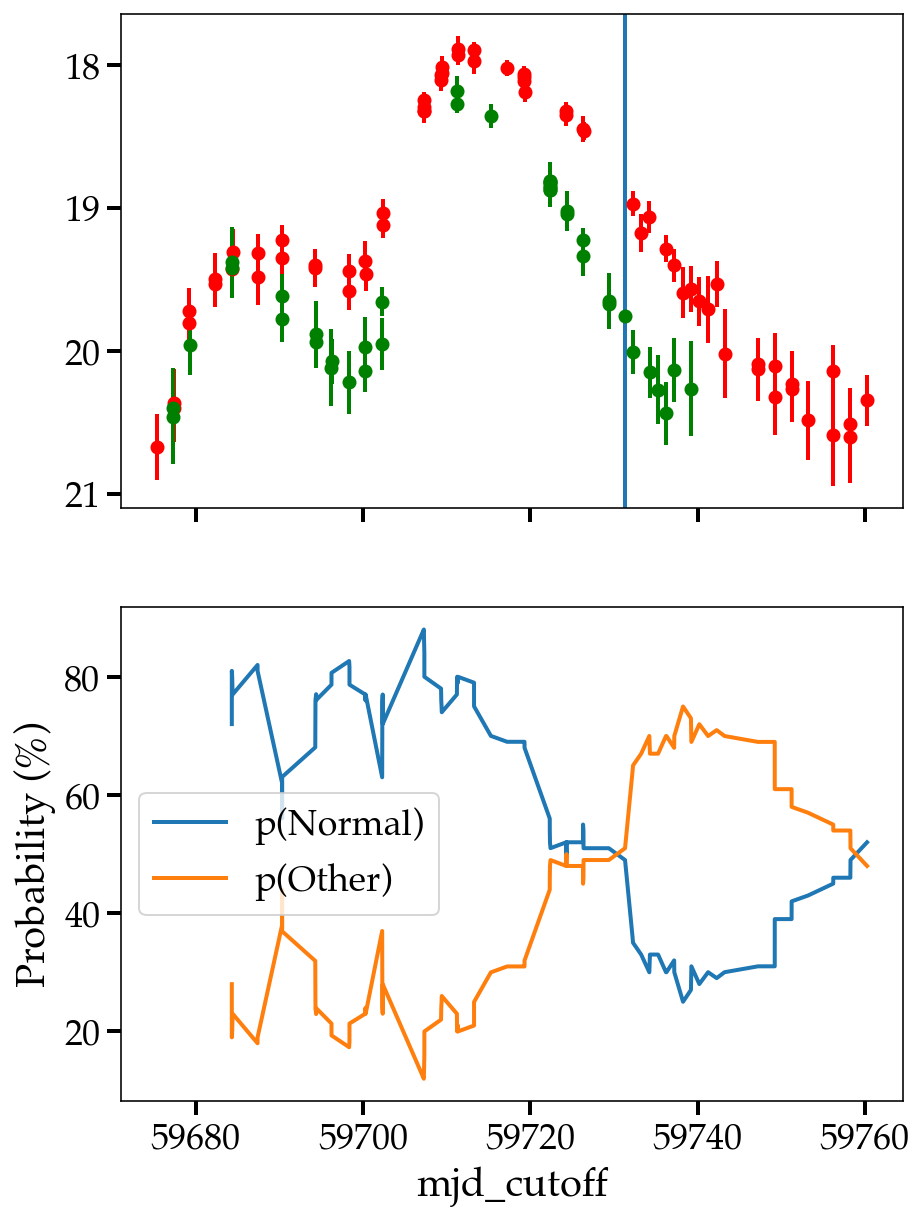

In [55]:
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF22aaezyos', 
                          anom_thresh=50, 
                          #df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"
                         )

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


https://alerce.online/object/ZTF20acwobku


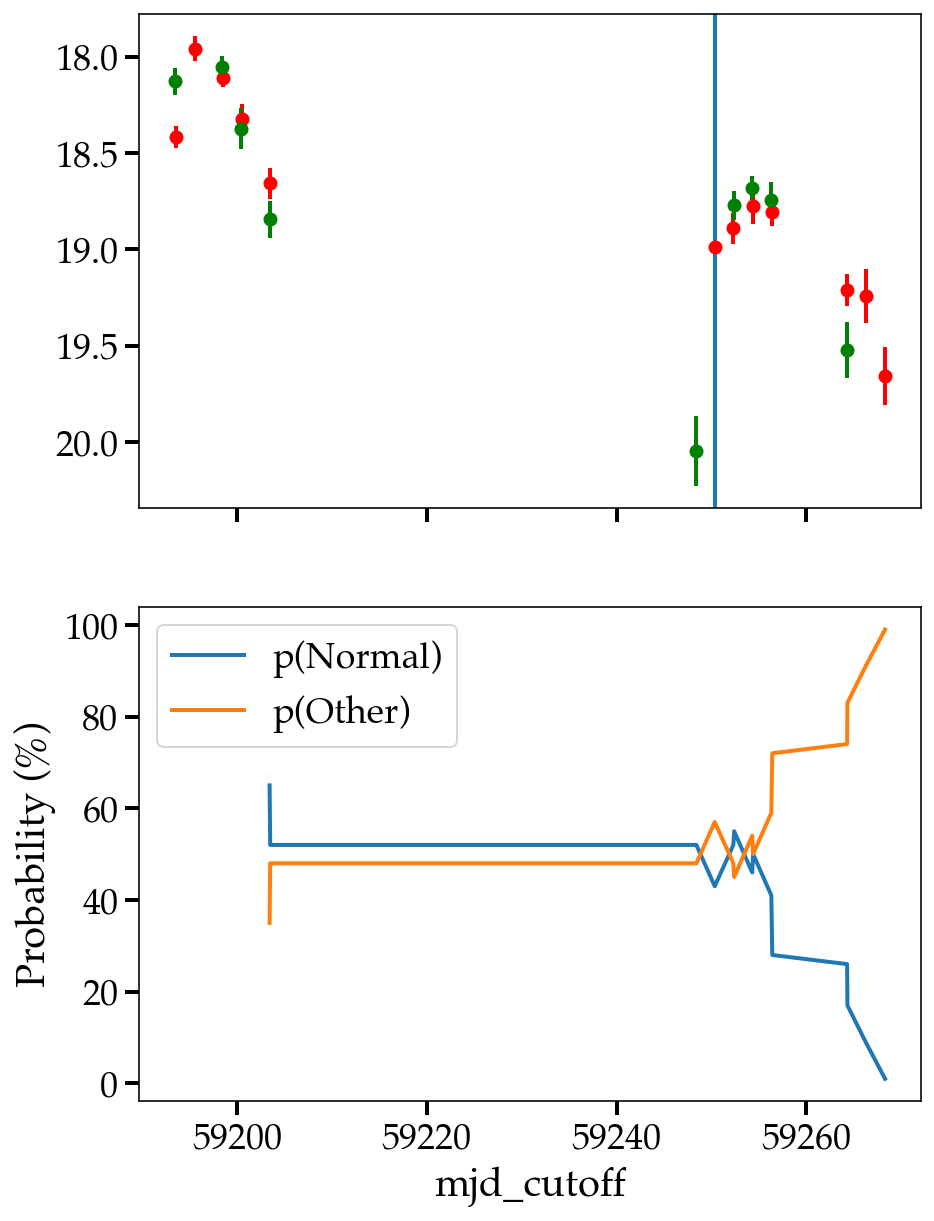

In [56]:
# 2020acct
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF20acwobku', 
                          anom_thresh=50, 
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
                          #df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"
                         )

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF22aasxgjp.
https://alerce.online/object/ZTF22aasxgjp


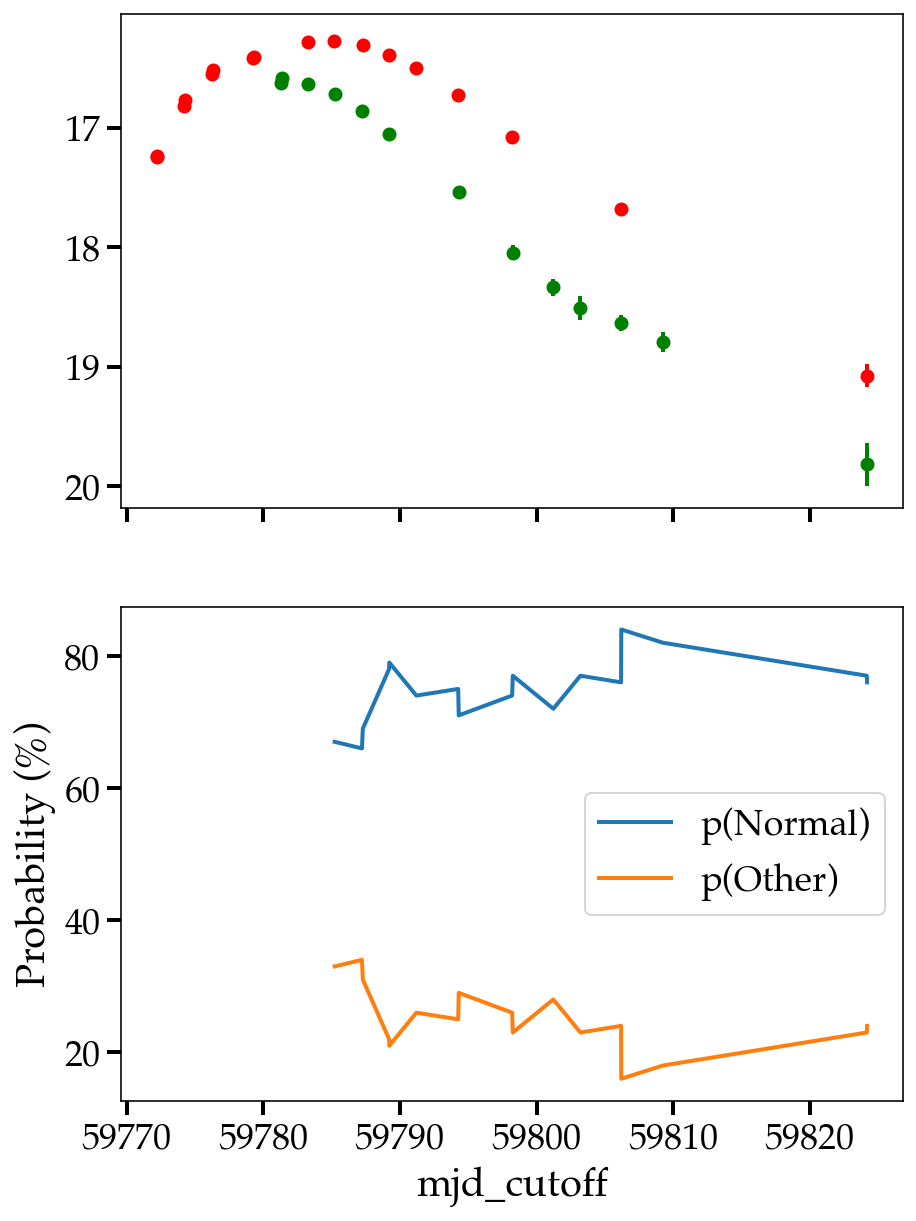

In [57]:
# 2022oqm (host assoc is wrong)
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF22aasxgjp', 
                          anom_thresh=50, 
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
                          #df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"
                         )

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF23aaggxna.
https://alerce.online/object/ZTF23aaggxna


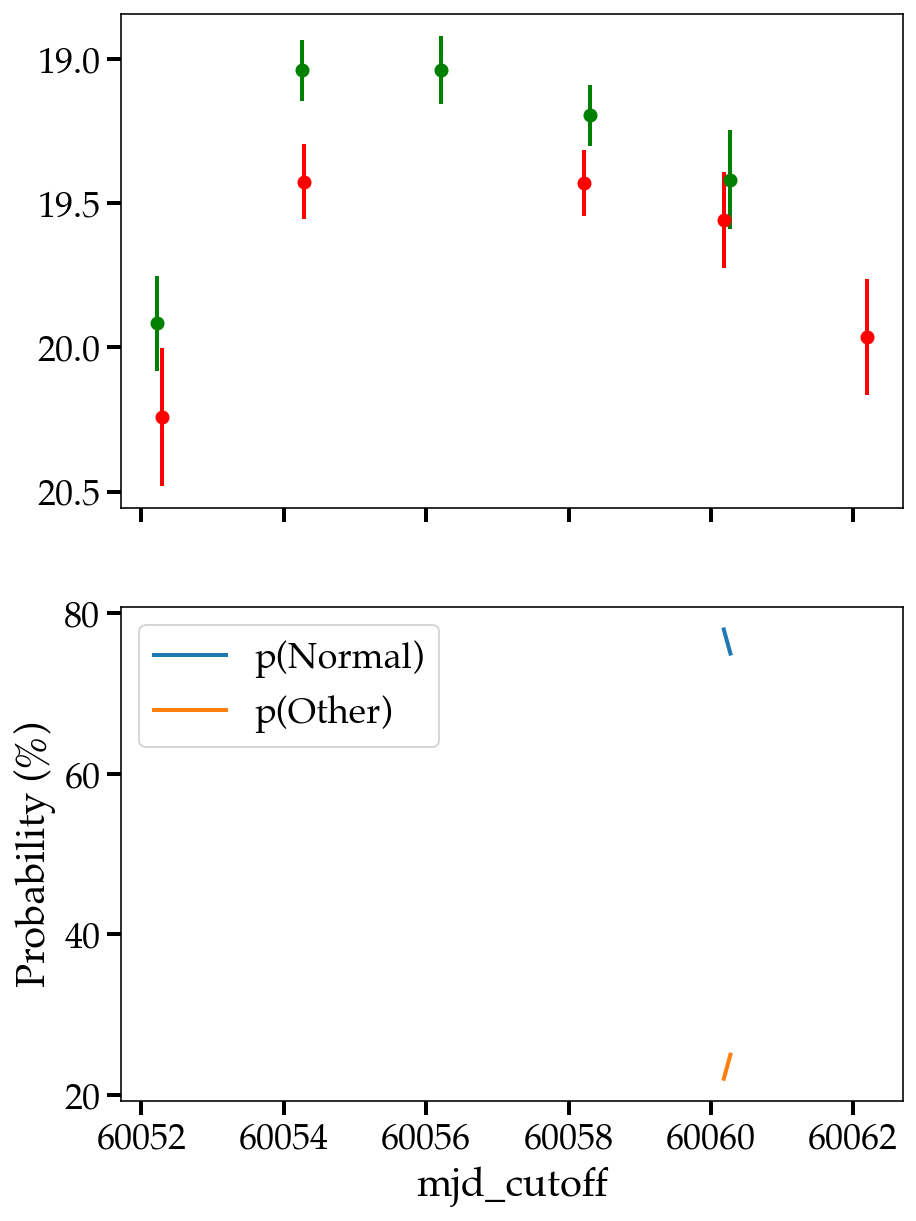

In [58]:
# 2023ggg (host assoc is wrong?)
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF23aaggxna', 
                          anom_thresh=50, 
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
                          #df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"
                         )

In [59]:
# 2023gpw 
# yKronRad	yExtNSigma are Nans, so can't run
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF23aagklwb', 
                          anom_thresh=50, 
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
                          #df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"
                         )

ValueError: Found array with 0 sample(s) (shape=(0, 120)) while a minimum of 1 is required by RandomForestClassifier.

In [71]:
# 2022nwx
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF22aapisdk', 
                          anom_thresh=50, 
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
                          #df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"
                         )

ValueError: Found array with 0 sample(s) (shape=(0, 120)) while a minimum of 1 is required by RandomForestClassifier.

In [61]:
# 2022odp - something Nan
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF22aapkbkl', 
                          anom_thresh=50, 
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
                          #df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"
                         )

ValueError: Found array with 0 sample(s) (shape=(0, 120)) while a minimum of 1 is required by RandomForestClassifier.

In [62]:
# 2022xxf - gets HII region
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF22abnvurz', 
                          anom_thresh=50, 
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
                          #df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"
                         )

ValueError: Found array with 0 sample(s) (shape=(0, 120)) while a minimum of 1 is required by RandomForestClassifier.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


https://alerce.online/object/ZTF20abisysx


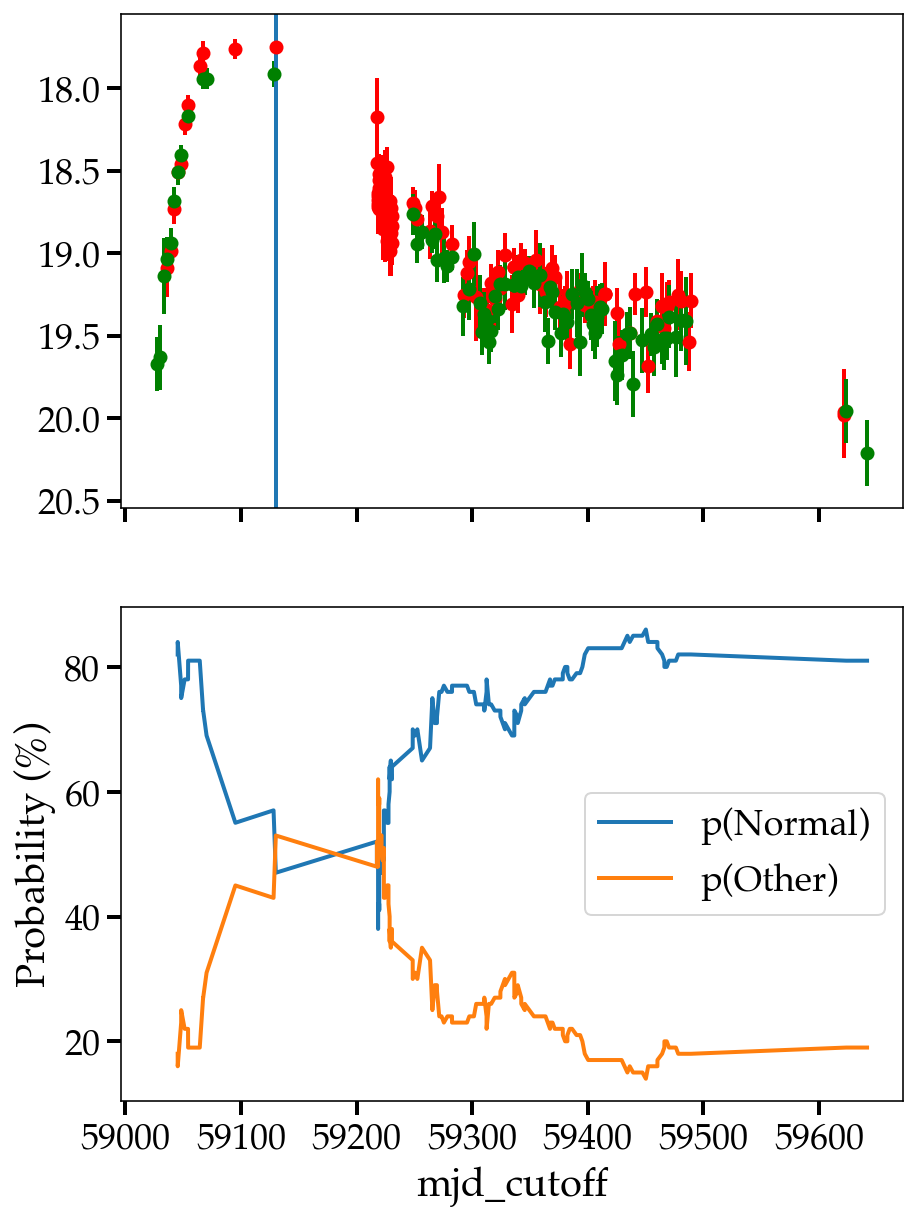

In [63]:
# 2020nov
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF20abisysx', 
                          anom_thresh=50, 
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
                          #df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"
                         )

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF20aatvdwr.
https://alerce.online/object/ZTF20aatvdwr


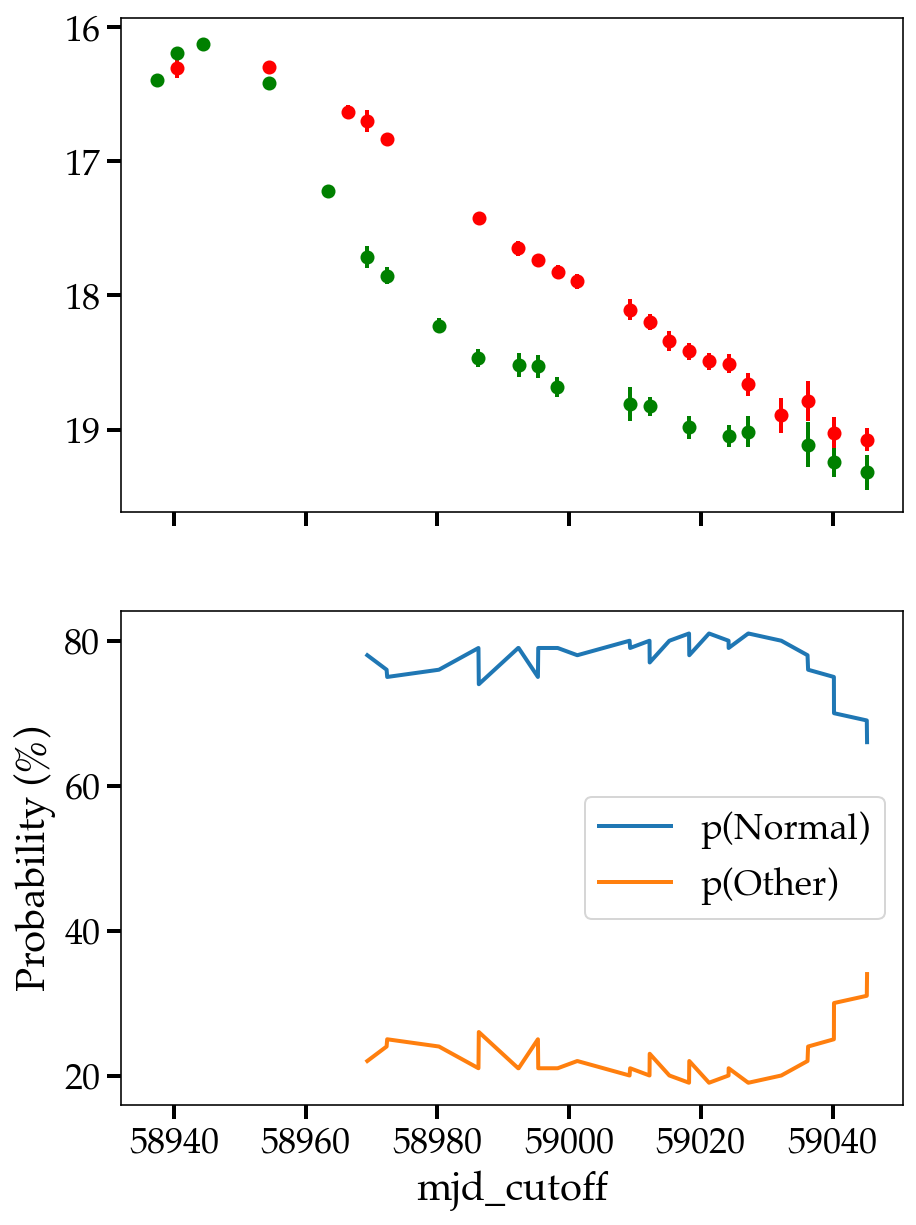

In [64]:
# 2020esm
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF20aatvdwr', 
                          anom_thresh=50, 
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
                          #df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"
                         )

In [65]:
# 2020oi
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF20aaelulu', 
                          anom_thresh=50, 
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
                          #df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"
                         )

ValueError: Found array with 0 sample(s) (shape=(0, 120)) while a minimum of 1 is required by RandomForestClassifier.

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Prediction doesn't exceed anom_threshold of 50% for ZTF19aamsetj.
https://alerce.online/object/ZTF19aamsetj


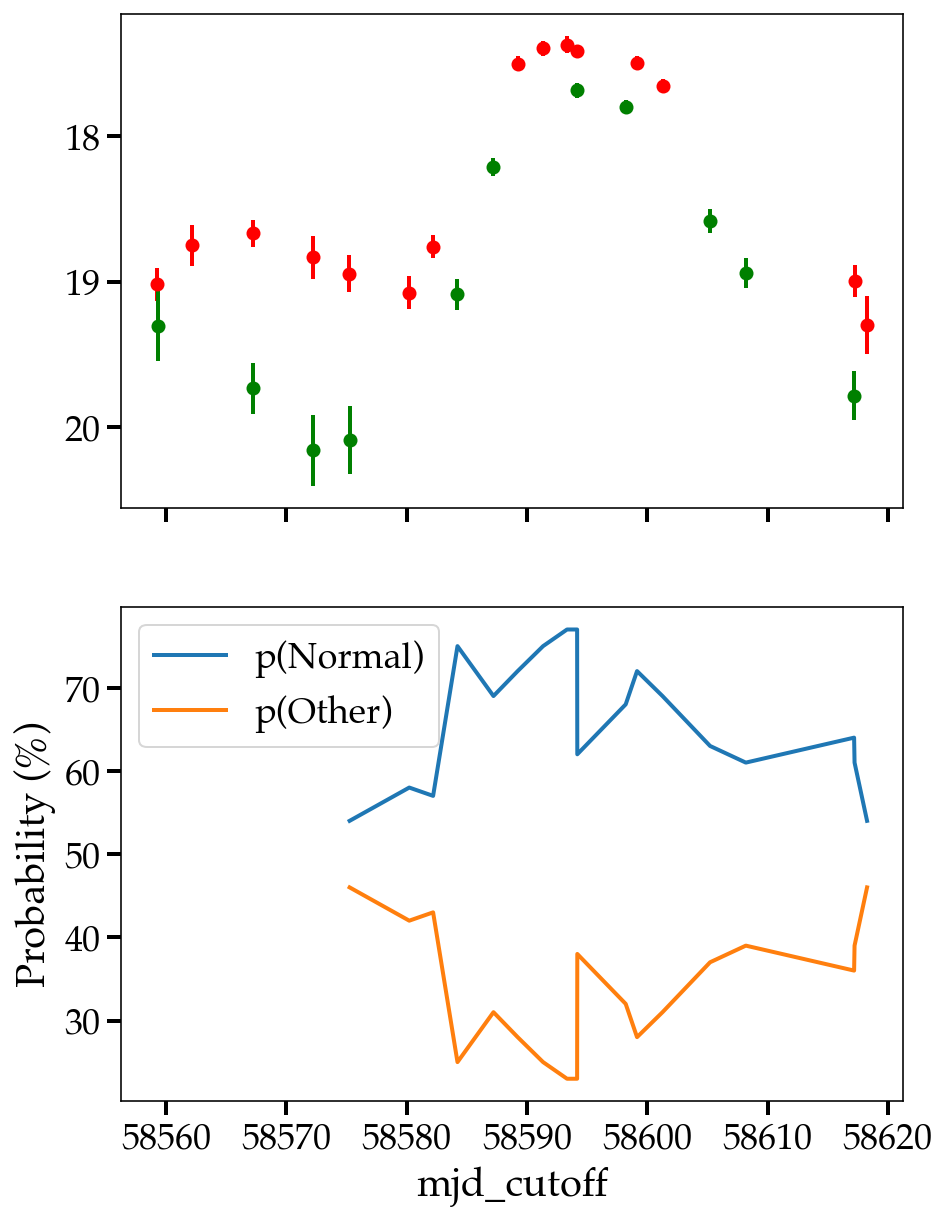

In [66]:
# 2019cad
plot_RFC_prob_vs_lc_ztfid(anom_ztfid='ZTF19aamsetj', 
                          anom_thresh=50, 
                          df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/CVAE_dataframes"
                          #df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/figures/CVAE/SMOTE_train_test_70-30_min14_kneighbors8/256_epochs=250_latent_dim=3_10000xClassLoss/dataframes"
                         )